# CNN Model 7

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 64
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 3 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 21:27:26.446510: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 21:27:26.490266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 64

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 21:27:53.461846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:27:53.612732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:27:53.616741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model7'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 8192)              0         


 dense (Dense)               (None, 256)               2097408   


 dense_1 (Dense)             (None, 1)                 257       


Total params: 2386465 (9.10 MB)


Trainable params: 2385569 (9.10 MB)


Non-trainable params: 896 (3.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 21:27:56.481903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 21:27:56.930987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/1204 [..............................] - ETA: 36:34 - loss: 0.9890 - accuracy: 0.4219 - auc: 0.4777

   4/1204 [..............................] - ETA: 27s - loss: 2.4826 - accuracy: 0.5586 - auc: 0.5304  

   7/1204 [..............................] - ETA: 26s - loss: 2.2227 - accuracy: 0.5469 - auc: 0.5777

  10/1204 [..............................] - ETA: 25s - loss: 1.8961 - accuracy: 0.6187 - auc: 0.6394

  13/1204 [..............................] - ETA: 25s - loss: 1.8591 - accuracy: 0.6322 - auc: 0.6657

  15/1204 [..............................] - ETA: 27s - loss: 1.7182 - accuracy: 0.6500 - auc: 0.6824

  18/1204 [..............................] - ETA: 27s - loss: 1.6851 - accuracy: 0.6597 - auc: 0.6919

  21/1204 [..............................] - ETA: 26s - loss: 1.5567 - accuracy: 0.6793 - auc: 0.7150

  24/1204 [..............................] - ETA: 26s - loss: 1.4574 - accuracy: 0.6940 - auc: 0.7276

  27/1204 [..............................] - ETA: 26s - loss: 1.3640 - accuracy: 0.7054 - auc: 0.7402

  30/1204 [..............................] - ETA: 26s - loss: 1.2859 - accuracy: 0.7104 - auc: 0.7454

  33/1204 [..............................] - ETA: 25s - loss: 1.2203 - accuracy: 0.7116 - auc: 0.7491

  36/1204 [..............................] - ETA: 25s - loss: 1.1619 - accuracy: 0.7179 - auc: 0.7526

  39/1204 [..............................] - ETA: 25s - loss: 1.1207 - accuracy: 0.7175 - auc: 0.7527

  42/1204 [>.............................] - ETA: 25s - loss: 1.0766 - accuracy: 0.7228 - auc: 0.7570

  45/1204 [>.............................] - ETA: 25s - loss: 1.0371 - accuracy: 0.7271 - auc: 0.7611

  48/1204 [>.............................] - ETA: 25s - loss: 1.0003 - accuracy: 0.7327 - auc: 0.7668

  51/1204 [>.............................] - ETA: 25s - loss: 0.9758 - accuracy: 0.7335 - auc: 0.7694

  54/1204 [>.............................] - ETA: 24s - loss: 0.9507 - accuracy: 0.7352 - auc: 0.7732

  57/1204 [>.............................] - ETA: 24s - loss: 0.9386 - accuracy: 0.7336 - auc: 0.7736

  60/1204 [>.............................] - ETA: 24s - loss: 0.9263 - accuracy: 0.7352 - auc: 0.7758

  63/1204 [>.............................] - ETA: 24s - loss: 0.9263 - accuracy: 0.7309 - auc: 0.7724

  66/1204 [>.............................] - ETA: 24s - loss: 0.9130 - accuracy: 0.7337 - auc: 0.7748

  69/1204 [>.............................] - ETA: 24s - loss: 0.9001 - accuracy: 0.7357 - auc: 0.7772

  72/1204 [>.............................] - ETA: 24s - loss: 0.8915 - accuracy: 0.7342 - auc: 0.7770

  75/1204 [>.............................] - ETA: 24s - loss: 0.8779 - accuracy: 0.7360 - auc: 0.7792

  78/1204 [>.............................] - ETA: 24s - loss: 0.8677 - accuracy: 0.7342 - auc: 0.7790

  81/1204 [=>............................] - ETA: 24s - loss: 0.8528 - accuracy: 0.7365 - auc: 0.7802

  84/1204 [=>............................] - ETA: 24s - loss: 0.8473 - accuracy: 0.7353 - auc: 0.7795

  87/1204 [=>............................] - ETA: 24s - loss: 0.8414 - accuracy: 0.7333 - auc: 0.7782

  88/1204 [=>............................] - ETA: 24s - loss: 0.8352 - accuracy: 0.7351 - auc: 0.7796

  91/1204 [=>............................] - ETA: 24s - loss: 0.8361 - accuracy: 0.7337 - auc: 0.7785

  94/1204 [=>............................] - ETA: 24s - loss: 0.8278 - accuracy: 0.7342 - auc: 0.7806

  97/1204 [=>............................] - ETA: 24s - loss: 0.8225 - accuracy: 0.7337 - auc: 0.7819

 100/1204 [=>............................] - ETA: 24s - loss: 0.8279 - accuracy: 0.7328 - auc: 0.7809

 103/1204 [=>............................] - ETA: 23s - loss: 0.8269 - accuracy: 0.7333 - auc: 0.7817

 106/1204 [=>............................] - ETA: 23s - loss: 0.8195 - accuracy: 0.7342 - auc: 0.7834

 109/1204 [=>............................] - ETA: 23s - loss: 0.8153 - accuracy: 0.7344 - auc: 0.7837

 112/1204 [=>............................] - ETA: 23s - loss: 0.8083 - accuracy: 0.7354 - auc: 0.7849

 115/1204 [=>............................] - ETA: 23s - loss: 0.7993 - accuracy: 0.7368 - auc: 0.7869

 118/1204 [=>............................] - ETA: 23s - loss: 0.7908 - accuracy: 0.7383 - auc: 0.7888

 121/1204 [==>...........................] - ETA: 23s - loss: 0.7866 - accuracy: 0.7388 - auc: 0.7893

 124/1204 [==>...........................] - ETA: 23s - loss: 0.7814 - accuracy: 0.7387 - auc: 0.7904

 127/1204 [==>...........................] - ETA: 23s - loss: 0.7738 - accuracy: 0.7388 - auc: 0.7924

 130/1204 [==>...........................] - ETA: 23s - loss: 0.7687 - accuracy: 0.7399 - auc: 0.7930

 133/1204 [==>...........................] - ETA: 23s - loss: 0.7656 - accuracy: 0.7399 - auc: 0.7928

 136/1204 [==>...........................] - ETA: 23s - loss: 0.7595 - accuracy: 0.7409 - auc: 0.7937

 139/1204 [==>...........................] - ETA: 23s - loss: 0.7547 - accuracy: 0.7418 - auc: 0.7942

 142/1204 [==>...........................] - ETA: 22s - loss: 0.7504 - accuracy: 0.7417 - auc: 0.7946

 145/1204 [==>...........................] - ETA: 22s - loss: 0.7480 - accuracy: 0.7427 - auc: 0.7953

 148/1204 [==>...........................] - ETA: 22s - loss: 0.7461 - accuracy: 0.7430 - auc: 0.7958

 151/1204 [==>...........................] - ETA: 22s - loss: 0.7438 - accuracy: 0.7424 - auc: 0.7963

 154/1204 [==>...........................] - ETA: 22s - loss: 0.7430 - accuracy: 0.7433 - auc: 0.7969

 157/1204 [==>...........................] - ETA: 22s - loss: 0.7414 - accuracy: 0.7438 - auc: 0.7974

 160/1204 [==>...........................] - ETA: 22s - loss: 0.7395 - accuracy: 0.7441 - auc: 0.7977

 163/1204 [===>..........................] - ETA: 22s - loss: 0.7355 - accuracy: 0.7449 - auc: 0.7986

 166/1204 [===>..........................] - ETA: 22s - loss: 0.7355 - accuracy: 0.7437 - auc: 0.7978

 169/1204 [===>..........................] - ETA: 22s - loss: 0.7324 - accuracy: 0.7436 - auc: 0.7980

 172/1204 [===>..........................] - ETA: 22s - loss: 0.7292 - accuracy: 0.7440 - auc: 0.7986

 175/1204 [===>..........................] - ETA: 22s - loss: 0.7309 - accuracy: 0.7429 - auc: 0.7975

 178/1204 [===>..........................] - ETA: 22s - loss: 0.7315 - accuracy: 0.7420 - auc: 0.7969

 181/1204 [===>..........................] - ETA: 22s - loss: 0.7286 - accuracy: 0.7430 - auc: 0.7979

 184/1204 [===>..........................] - ETA: 22s - loss: 0.7267 - accuracy: 0.7427 - auc: 0.7979

 187/1204 [===>..........................] - ETA: 22s - loss: 0.7237 - accuracy: 0.7425 - auc: 0.7987

 190/1204 [===>..........................] - ETA: 22s - loss: 0.7219 - accuracy: 0.7424 - auc: 0.7991

 193/1204 [===>..........................] - ETA: 22s - loss: 0.7170 - accuracy: 0.7438 - auc: 0.8007

 196/1204 [===>..........................] - ETA: 22s - loss: 0.7142 - accuracy: 0.7446 - auc: 0.8012

 199/1204 [===>..........................] - ETA: 21s - loss: 0.7120 - accuracy: 0.7452 - auc: 0.8017

 202/1204 [====>.........................] - ETA: 21s - loss: 0.7081 - accuracy: 0.7459 - auc: 0.8025

 205/1204 [====>.........................] - ETA: 21s - loss: 0.7049 - accuracy: 0.7462 - auc: 0.8030

 208/1204 [====>.........................] - ETA: 21s - loss: 0.7041 - accuracy: 0.7461 - auc: 0.8027

 211/1204 [====>.........................] - ETA: 21s - loss: 0.7021 - accuracy: 0.7461 - auc: 0.8024

 214/1204 [====>.........................] - ETA: 21s - loss: 0.6990 - accuracy: 0.7464 - auc: 0.8029

 217/1204 [====>.........................] - ETA: 21s - loss: 0.6970 - accuracy: 0.7466 - auc: 0.8032

 220/1204 [====>.........................] - ETA: 21s - loss: 0.6944 - accuracy: 0.7467 - auc: 0.8033

 223/1204 [====>.........................] - ETA: 21s - loss: 0.6924 - accuracy: 0.7468 - auc: 0.8038

 226/1204 [====>.........................] - ETA: 21s - loss: 0.6901 - accuracy: 0.7475 - auc: 0.8042

 229/1204 [====>.........................] - ETA: 21s - loss: 0.6881 - accuracy: 0.7480 - auc: 0.8044

 232/1204 [====>.........................] - ETA: 21s - loss: 0.6847 - accuracy: 0.7488 - auc: 0.8050

 235/1204 [====>.........................] - ETA: 21s - loss: 0.6820 - accuracy: 0.7489 - auc: 0.8053

 238/1204 [====>.........................] - ETA: 21s - loss: 0.6793 - accuracy: 0.7495 - auc: 0.8056

 241/1204 [=====>........................] - ETA: 20s - loss: 0.6774 - accuracy: 0.7495 - auc: 0.8059

 244/1204 [=====>........................] - ETA: 20s - loss: 0.6756 - accuracy: 0.7493 - auc: 0.8062

 247/1204 [=====>........................] - ETA: 20s - loss: 0.6740 - accuracy: 0.7491 - auc: 0.8063

 250/1204 [=====>........................] - ETA: 20s - loss: 0.6717 - accuracy: 0.7497 - auc: 0.8067

 253/1204 [=====>........................] - ETA: 20s - loss: 0.6699 - accuracy: 0.7502 - auc: 0.8069

 256/1204 [=====>........................] - ETA: 20s - loss: 0.6679 - accuracy: 0.7507 - auc: 0.8070

 259/1204 [=====>........................] - ETA: 20s - loss: 0.6649 - accuracy: 0.7513 - auc: 0.8079

 262/1204 [=====>........................] - ETA: 20s - loss: 0.6640 - accuracy: 0.7514 - auc: 0.8079

 265/1204 [=====>........................] - ETA: 20s - loss: 0.6600 - accuracy: 0.7523 - auc: 0.8094

 268/1204 [=====>........................] - ETA: 20s - loss: 0.6589 - accuracy: 0.7528 - auc: 0.8099

 271/1204 [=====>........................] - ETA: 20s - loss: 0.6578 - accuracy: 0.7535 - auc: 0.8106

 274/1204 [=====>........................] - ETA: 20s - loss: 0.6565 - accuracy: 0.7538 - auc: 0.8111

 277/1204 [=====>........................] - ETA: 20s - loss: 0.6558 - accuracy: 0.7537 - auc: 0.8112

 280/1204 [=====>........................] - ETA: 20s - loss: 0.6529 - accuracy: 0.7545 - auc: 0.8121

 283/1204 [======>.......................] - ETA: 20s - loss: 0.6506 - accuracy: 0.7550 - auc: 0.8129

 286/1204 [======>.......................] - ETA: 19s - loss: 0.6496 - accuracy: 0.7554 - auc: 0.8130

 289/1204 [======>.......................] - ETA: 19s - loss: 0.6479 - accuracy: 0.7558 - auc: 0.8133

 292/1204 [======>.......................] - ETA: 19s - loss: 0.6472 - accuracy: 0.7559 - auc: 0.8133

 295/1204 [======>.......................] - ETA: 19s - loss: 0.6460 - accuracy: 0.7558 - auc: 0.8135

 298/1204 [======>.......................] - ETA: 19s - loss: 0.6447 - accuracy: 0.7562 - auc: 0.8140

 301/1204 [======>.......................] - ETA: 19s - loss: 0.6441 - accuracy: 0.7566 - auc: 0.8143

 304/1204 [======>.......................] - ETA: 19s - loss: 0.6441 - accuracy: 0.7563 - auc: 0.8139

 307/1204 [======>.......................] - ETA: 19s - loss: 0.6428 - accuracy: 0.7569 - auc: 0.8141

 310/1204 [======>.......................] - ETA: 19s - loss: 0.6419 - accuracy: 0.7570 - auc: 0.8143

 313/1204 [======>.......................] - ETA: 19s - loss: 0.6417 - accuracy: 0.7565 - auc: 0.8139

 316/1204 [======>.......................] - ETA: 19s - loss: 0.6412 - accuracy: 0.7567 - auc: 0.8140

 319/1204 [======>.......................] - ETA: 19s - loss: 0.6403 - accuracy: 0.7564 - auc: 0.8141

 322/1204 [=======>......................] - ETA: 19s - loss: 0.6388 - accuracy: 0.7567 - auc: 0.8146

 325/1204 [=======>......................] - ETA: 19s - loss: 0.6412 - accuracy: 0.7566 - auc: 0.8142

 328/1204 [=======>......................] - ETA: 18s - loss: 0.6407 - accuracy: 0.7570 - auc: 0.8147

 331/1204 [=======>......................] - ETA: 18s - loss: 0.6404 - accuracy: 0.7572 - auc: 0.8151

 334/1204 [=======>......................] - ETA: 18s - loss: 0.6394 - accuracy: 0.7579 - auc: 0.8156

 337/1204 [=======>......................] - ETA: 18s - loss: 0.6379 - accuracy: 0.7584 - auc: 0.8163

 340/1204 [=======>......................] - ETA: 18s - loss: 0.6364 - accuracy: 0.7588 - auc: 0.8167

 343/1204 [=======>......................] - ETA: 18s - loss: 0.6355 - accuracy: 0.7592 - auc: 0.8169

 346/1204 [=======>......................] - ETA: 18s - loss: 0.6348 - accuracy: 0.7592 - auc: 0.8171

 349/1204 [=======>......................] - ETA: 18s - loss: 0.6334 - accuracy: 0.7594 - auc: 0.8174

 352/1204 [=======>......................] - ETA: 18s - loss: 0.6323 - accuracy: 0.7597 - auc: 0.8174

 355/1204 [=======>......................] - ETA: 18s - loss: 0.6316 - accuracy: 0.7596 - auc: 0.8174

 358/1204 [=======>......................] - ETA: 18s - loss: 0.6310 - accuracy: 0.7593 - auc: 0.8173

 361/1204 [=======>......................] - ETA: 18s - loss: 0.6298 - accuracy: 0.7596 - auc: 0.8178

 364/1204 [========>.....................] - ETA: 18s - loss: 0.6278 - accuracy: 0.7600 - auc: 0.8185

 367/1204 [========>.....................] - ETA: 18s - loss: 0.6269 - accuracy: 0.7602 - auc: 0.8186

 370/1204 [========>.....................] - ETA: 18s - loss: 0.6261 - accuracy: 0.7605 - auc: 0.8189

 373/1204 [========>.....................] - ETA: 17s - loss: 0.6255 - accuracy: 0.7608 - auc: 0.8191

 376/1204 [========>.....................] - ETA: 17s - loss: 0.6243 - accuracy: 0.7612 - auc: 0.8193

 379/1204 [========>.....................] - ETA: 17s - loss: 0.6234 - accuracy: 0.7615 - auc: 0.8196

 382/1204 [========>.....................] - ETA: 17s - loss: 0.6231 - accuracy: 0.7614 - auc: 0.8195

 385/1204 [========>.....................] - ETA: 17s - loss: 0.6234 - accuracy: 0.7615 - auc: 0.8192

 388/1204 [========>.....................] - ETA: 17s - loss: 0.6239 - accuracy: 0.7612 - auc: 0.8189

 391/1204 [========>.....................] - ETA: 17s - loss: 0.6229 - accuracy: 0.7614 - auc: 0.8191

 394/1204 [========>.....................] - ETA: 17s - loss: 0.6221 - accuracy: 0.7617 - auc: 0.8193

 397/1204 [========>.....................] - ETA: 17s - loss: 0.6215 - accuracy: 0.7617 - auc: 0.8193

 400/1204 [========>.....................] - ETA: 17s - loss: 0.6213 - accuracy: 0.7614 - auc: 0.8191

 403/1204 [=========>....................] - ETA: 17s - loss: 0.6201 - accuracy: 0.7616 - auc: 0.8195

 406/1204 [=========>....................] - ETA: 17s - loss: 0.6187 - accuracy: 0.7620 - auc: 0.8199

 409/1204 [=========>....................] - ETA: 17s - loss: 0.6172 - accuracy: 0.7623 - auc: 0.8203

 412/1204 [=========>....................] - ETA: 17s - loss: 0.6158 - accuracy: 0.7628 - auc: 0.8206

 415/1204 [=========>....................] - ETA: 17s - loss: 0.6143 - accuracy: 0.7634 - auc: 0.8213

 418/1204 [=========>....................] - ETA: 16s - loss: 0.6135 - accuracy: 0.7635 - auc: 0.8214

 421/1204 [=========>....................] - ETA: 16s - loss: 0.6122 - accuracy: 0.7637 - auc: 0.8218

 424/1204 [=========>....................] - ETA: 16s - loss: 0.6116 - accuracy: 0.7639 - auc: 0.8220

 427/1204 [=========>....................] - ETA: 16s - loss: 0.6104 - accuracy: 0.7643 - auc: 0.8223

 430/1204 [=========>....................] - ETA: 16s - loss: 0.6095 - accuracy: 0.7646 - auc: 0.8226

 433/1204 [=========>....................] - ETA: 16s - loss: 0.6085 - accuracy: 0.7650 - auc: 0.8229

 436/1204 [=========>....................] - ETA: 16s - loss: 0.6077 - accuracy: 0.7651 - auc: 0.8230

 439/1204 [=========>....................] - ETA: 16s - loss: 0.6071 - accuracy: 0.7653 - auc: 0.8231

 442/1204 [==========>...................] - ETA: 16s - loss: 0.6053 - accuracy: 0.7660 - auc: 0.8237

 445/1204 [==========>...................] - ETA: 16s - loss: 0.6045 - accuracy: 0.7662 - auc: 0.8240

 448/1204 [==========>...................] - ETA: 16s - loss: 0.6035 - accuracy: 0.7666 - auc: 0.8244

 451/1204 [==========>...................] - ETA: 16s - loss: 0.6027 - accuracy: 0.7668 - auc: 0.8247

 454/1204 [==========>...................] - ETA: 16s - loss: 0.6016 - accuracy: 0.7671 - auc: 0.8250

 457/1204 [==========>...................] - ETA: 16s - loss: 0.6014 - accuracy: 0.7670 - auc: 0.8249

 460/1204 [==========>...................] - ETA: 16s - loss: 0.6009 - accuracy: 0.7672 - auc: 0.8251

 463/1204 [==========>...................] - ETA: 15s - loss: 0.6003 - accuracy: 0.7670 - auc: 0.8252

 466/1204 [==========>...................] - ETA: 15s - loss: 0.5999 - accuracy: 0.7669 - auc: 0.8252

 469/1204 [==========>...................] - ETA: 15s - loss: 0.5991 - accuracy: 0.7671 - auc: 0.8255

 472/1204 [==========>...................] - ETA: 15s - loss: 0.5988 - accuracy: 0.7671 - auc: 0.8257

 475/1204 [==========>...................] - ETA: 15s - loss: 0.5988 - accuracy: 0.7670 - auc: 0.8256

 478/1204 [==========>...................] - ETA: 15s - loss: 0.5976 - accuracy: 0.7675 - auc: 0.8261

 481/1204 [==========>...................] - ETA: 15s - loss: 0.5963 - accuracy: 0.7682 - auc: 0.8268

 484/1204 [===========>..................] - ETA: 15s - loss: 0.5960 - accuracy: 0.7685 - auc: 0.8271

 487/1204 [===========>..................] - ETA: 15s - loss: 0.5956 - accuracy: 0.7685 - auc: 0.8274

 490/1204 [===========>..................] - ETA: 15s - loss: 0.5951 - accuracy: 0.7688 - auc: 0.8275

 493/1204 [===========>..................] - ETA: 15s - loss: 0.5943 - accuracy: 0.7688 - auc: 0.8277

 496/1204 [===========>..................] - ETA: 15s - loss: 0.5949 - accuracy: 0.7686 - auc: 0.8275

 499/1204 [===========>..................] - ETA: 15s - loss: 0.5947 - accuracy: 0.7684 - auc: 0.8275

 502/1204 [===========>..................] - ETA: 15s - loss: 0.5941 - accuracy: 0.7687 - auc: 0.8276

 505/1204 [===========>..................] - ETA: 15s - loss: 0.5935 - accuracy: 0.7689 - auc: 0.8278

 508/1204 [===========>..................] - ETA: 15s - loss: 0.5925 - accuracy: 0.7693 - auc: 0.8283

 511/1204 [===========>..................] - ETA: 14s - loss: 0.5913 - accuracy: 0.7696 - auc: 0.8288

 514/1204 [===========>..................] - ETA: 14s - loss: 0.5901 - accuracy: 0.7699 - auc: 0.8292

 517/1204 [===========>..................] - ETA: 14s - loss: 0.5896 - accuracy: 0.7702 - auc: 0.8294

 520/1204 [===========>..................] - ETA: 14s - loss: 0.5896 - accuracy: 0.7697 - auc: 0.8293

 523/1204 [============>.................] - ETA: 14s - loss: 0.5887 - accuracy: 0.7700 - auc: 0.8295

 526/1204 [============>.................] - ETA: 14s - loss: 0.5883 - accuracy: 0.7702 - auc: 0.8296

 529/1204 [============>.................] - ETA: 14s - loss: 0.5874 - accuracy: 0.7703 - auc: 0.8298

 532/1204 [============>.................] - ETA: 14s - loss: 0.5859 - accuracy: 0.7709 - auc: 0.8303

 535/1204 [============>.................] - ETA: 14s - loss: 0.5853 - accuracy: 0.7711 - auc: 0.8306

 538/1204 [============>.................] - ETA: 14s - loss: 0.5852 - accuracy: 0.7710 - auc: 0.8306

 541/1204 [============>.................] - ETA: 14s - loss: 0.5846 - accuracy: 0.7712 - auc: 0.8309

 544/1204 [============>.................] - ETA: 14s - loss: 0.5849 - accuracy: 0.7712 - auc: 0.8307

 547/1204 [============>.................] - ETA: 14s - loss: 0.5837 - accuracy: 0.7716 - auc: 0.8312

 550/1204 [============>.................] - ETA: 14s - loss: 0.5831 - accuracy: 0.7715 - auc: 0.8313

 553/1204 [============>.................] - ETA: 14s - loss: 0.5823 - accuracy: 0.7717 - auc: 0.8314

 556/1204 [============>.................] - ETA: 13s - loss: 0.5818 - accuracy: 0.7718 - auc: 0.8315

 559/1204 [============>.................] - ETA: 13s - loss: 0.5814 - accuracy: 0.7719 - auc: 0.8316

 562/1204 [=============>................] - ETA: 13s - loss: 0.5811 - accuracy: 0.7718 - auc: 0.8316

 565/1204 [=============>................] - ETA: 13s - loss: 0.5804 - accuracy: 0.7720 - auc: 0.8317

 568/1204 [=============>................] - ETA: 13s - loss: 0.5802 - accuracy: 0.7721 - auc: 0.8318

 571/1204 [=============>................] - ETA: 13s - loss: 0.5795 - accuracy: 0.7723 - auc: 0.8320

 574/1204 [=============>................] - ETA: 13s - loss: 0.5794 - accuracy: 0.7723 - auc: 0.8321

 577/1204 [=============>................] - ETA: 13s - loss: 0.5795 - accuracy: 0.7722 - auc: 0.8320

 580/1204 [=============>................] - ETA: 13s - loss: 0.5787 - accuracy: 0.7724 - auc: 0.8323

 583/1204 [=============>................] - ETA: 13s - loss: 0.5783 - accuracy: 0.7724 - auc: 0.8324

 586/1204 [=============>................] - ETA: 13s - loss: 0.5784 - accuracy: 0.7724 - auc: 0.8324

 589/1204 [=============>................] - ETA: 13s - loss: 0.5777 - accuracy: 0.7724 - auc: 0.8325

 592/1204 [=============>................] - ETA: 13s - loss: 0.5771 - accuracy: 0.7725 - auc: 0.8327

 595/1204 [=============>................] - ETA: 13s - loss: 0.5763 - accuracy: 0.7728 - auc: 0.8330

 598/1204 [=============>................] - ETA: 13s - loss: 0.5755 - accuracy: 0.7730 - auc: 0.8332

 601/1204 [=============>................] - ETA: 12s - loss: 0.5749 - accuracy: 0.7731 - auc: 0.8333

 604/1204 [==============>...............] - ETA: 12s - loss: 0.5745 - accuracy: 0.7733 - auc: 0.8335

 607/1204 [==============>...............] - ETA: 12s - loss: 0.5735 - accuracy: 0.7736 - auc: 0.8340

 610/1204 [==============>...............] - ETA: 12s - loss: 0.5728 - accuracy: 0.7737 - auc: 0.8342

 613/1204 [==============>...............] - ETA: 12s - loss: 0.5730 - accuracy: 0.7737 - auc: 0.8342

 616/1204 [==============>...............] - ETA: 12s - loss: 0.5727 - accuracy: 0.7736 - auc: 0.8342

 619/1204 [==============>...............] - ETA: 12s - loss: 0.5723 - accuracy: 0.7741 - auc: 0.8344

 622/1204 [==============>...............] - ETA: 12s - loss: 0.5720 - accuracy: 0.7743 - auc: 0.8344

 625/1204 [==============>...............] - ETA: 12s - loss: 0.5719 - accuracy: 0.7742 - auc: 0.8344

 628/1204 [==============>...............] - ETA: 12s - loss: 0.5716 - accuracy: 0.7744 - auc: 0.8346

 631/1204 [==============>...............] - ETA: 12s - loss: 0.5706 - accuracy: 0.7747 - auc: 0.8350

 634/1204 [==============>...............] - ETA: 12s - loss: 0.5699 - accuracy: 0.7750 - auc: 0.8352

 637/1204 [==============>...............] - ETA: 12s - loss: 0.5691 - accuracy: 0.7753 - auc: 0.8356

 640/1204 [==============>...............] - ETA: 12s - loss: 0.5685 - accuracy: 0.7755 - auc: 0.8359

 643/1204 [===============>..............] - ETA: 12s - loss: 0.5681 - accuracy: 0.7756 - auc: 0.8360

 646/1204 [===============>..............] - ETA: 12s - loss: 0.5673 - accuracy: 0.7759 - auc: 0.8363

 649/1204 [===============>..............] - ETA: 11s - loss: 0.5667 - accuracy: 0.7758 - auc: 0.8363

 652/1204 [===============>..............] - ETA: 11s - loss: 0.5663 - accuracy: 0.7759 - auc: 0.8364

 655/1204 [===============>..............] - ETA: 11s - loss: 0.5655 - accuracy: 0.7762 - auc: 0.8367

 658/1204 [===============>..............] - ETA: 11s - loss: 0.5648 - accuracy: 0.7765 - auc: 0.8369

 661/1204 [===============>..............] - ETA: 11s - loss: 0.5645 - accuracy: 0.7768 - auc: 0.8372

 664/1204 [===============>..............] - ETA: 11s - loss: 0.5646 - accuracy: 0.7770 - auc: 0.8372

 667/1204 [===============>..............] - ETA: 11s - loss: 0.5641 - accuracy: 0.7772 - auc: 0.8374

 670/1204 [===============>..............] - ETA: 11s - loss: 0.5637 - accuracy: 0.7774 - auc: 0.8375

 673/1204 [===============>..............] - ETA: 11s - loss: 0.5632 - accuracy: 0.7776 - auc: 0.8376

 676/1204 [===============>..............] - ETA: 11s - loss: 0.5628 - accuracy: 0.7775 - auc: 0.8377

 679/1204 [===============>..............] - ETA: 11s - loss: 0.5629 - accuracy: 0.7772 - auc: 0.8375

 682/1204 [===============>..............] - ETA: 11s - loss: 0.5628 - accuracy: 0.7773 - auc: 0.8375

 685/1204 [================>.............] - ETA: 11s - loss: 0.5622 - accuracy: 0.7774 - auc: 0.8377

 688/1204 [================>.............] - ETA: 11s - loss: 0.5624 - accuracy: 0.7774 - auc: 0.8376

 691/1204 [================>.............] - ETA: 11s - loss: 0.5623 - accuracy: 0.7775 - auc: 0.8377

 694/1204 [================>.............] - ETA: 10s - loss: 0.5616 - accuracy: 0.7777 - auc: 0.8379

 697/1204 [================>.............] - ETA: 10s - loss: 0.5610 - accuracy: 0.7780 - auc: 0.8381

 700/1204 [================>.............] - ETA: 10s - loss: 0.5602 - accuracy: 0.7782 - auc: 0.8383

 703/1204 [================>.............] - ETA: 10s - loss: 0.5591 - accuracy: 0.7786 - auc: 0.8388

 706/1204 [================>.............] - ETA: 10s - loss: 0.5585 - accuracy: 0.7788 - auc: 0.8390

 709/1204 [================>.............] - ETA: 10s - loss: 0.5580 - accuracy: 0.7789 - auc: 0.8391

 712/1204 [================>.............] - ETA: 10s - loss: 0.5576 - accuracy: 0.7791 - auc: 0.8393

 715/1204 [================>.............] - ETA: 10s - loss: 0.5572 - accuracy: 0.7793 - auc: 0.8394

 718/1204 [================>.............] - ETA: 10s - loss: 0.5565 - accuracy: 0.7796 - auc: 0.8397

 721/1204 [================>.............] - ETA: 10s - loss: 0.5560 - accuracy: 0.7797 - auc: 0.8398

 724/1204 [=================>............] - ETA: 10s - loss: 0.5559 - accuracy: 0.7798 - auc: 0.8399

 727/1204 [=================>............] - ETA: 10s - loss: 0.5551 - accuracy: 0.7801 - auc: 0.8401

 730/1204 [=================>............] - ETA: 10s - loss: 0.5543 - accuracy: 0.7804 - auc: 0.8403

 733/1204 [=================>............] - ETA: 10s - loss: 0.5540 - accuracy: 0.7806 - auc: 0.8405

 736/1204 [=================>............] - ETA: 10s - loss: 0.5539 - accuracy: 0.7806 - auc: 0.8406

 739/1204 [=================>............] - ETA: 10s - loss: 0.5538 - accuracy: 0.7805 - auc: 0.8406

 742/1204 [=================>............] - ETA: 9s - loss: 0.5538 - accuracy: 0.7805 - auc: 0.8407 

 745/1204 [=================>............] - ETA: 9s - loss: 0.5541 - accuracy: 0.7805 - auc: 0.8406

 748/1204 [=================>............] - ETA: 9s - loss: 0.5541 - accuracy: 0.7805 - auc: 0.8407

 751/1204 [=================>............] - ETA: 9s - loss: 0.5542 - accuracy: 0.7804 - auc: 0.8406

 754/1204 [=================>............] - ETA: 9s - loss: 0.5534 - accuracy: 0.7808 - auc: 0.8410

 757/1204 [=================>............] - ETA: 9s - loss: 0.5535 - accuracy: 0.7810 - auc: 0.8411

 760/1204 [=================>............] - ETA: 9s - loss: 0.5532 - accuracy: 0.7809 - auc: 0.8412

 763/1204 [==================>...........] - ETA: 9s - loss: 0.5534 - accuracy: 0.7810 - auc: 0.8413

 766/1204 [==================>...........] - ETA: 9s - loss: 0.5535 - accuracy: 0.7812 - auc: 0.8413

 769/1204 [==================>...........] - ETA: 9s - loss: 0.5533 - accuracy: 0.7811 - auc: 0.8413

 772/1204 [==================>...........] - ETA: 9s - loss: 0.5529 - accuracy: 0.7812 - auc: 0.8415

 775/1204 [==================>...........] - ETA: 9s - loss: 0.5524 - accuracy: 0.7813 - auc: 0.8415

 778/1204 [==================>...........] - ETA: 9s - loss: 0.5521 - accuracy: 0.7814 - auc: 0.8415

 781/1204 [==================>...........] - ETA: 9s - loss: 0.5516 - accuracy: 0.7816 - auc: 0.8417

 784/1204 [==================>...........] - ETA: 9s - loss: 0.5508 - accuracy: 0.7818 - auc: 0.8420

 787/1204 [==================>...........] - ETA: 8s - loss: 0.5500 - accuracy: 0.7821 - auc: 0.8423

 790/1204 [==================>...........] - ETA: 8s - loss: 0.5494 - accuracy: 0.7823 - auc: 0.8425

 793/1204 [==================>...........] - ETA: 8s - loss: 0.5487 - accuracy: 0.7825 - auc: 0.8428

 796/1204 [==================>...........] - ETA: 8s - loss: 0.5483 - accuracy: 0.7827 - auc: 0.8429

 799/1204 [==================>...........] - ETA: 8s - loss: 0.5480 - accuracy: 0.7827 - auc: 0.8429

 802/1204 [==================>...........] - ETA: 8s - loss: 0.5478 - accuracy: 0.7827 - auc: 0.8429

 805/1204 [===================>..........] - ETA: 8s - loss: 0.5471 - accuracy: 0.7829 - auc: 0.8431

 808/1204 [===================>..........] - ETA: 8s - loss: 0.5468 - accuracy: 0.7830 - auc: 0.8432

 811/1204 [===================>..........] - ETA: 8s - loss: 0.5466 - accuracy: 0.7830 - auc: 0.8433

 814/1204 [===================>..........] - ETA: 8s - loss: 0.5461 - accuracy: 0.7832 - auc: 0.8435

 817/1204 [===================>..........] - ETA: 8s - loss: 0.5461 - accuracy: 0.7831 - auc: 0.8435

 820/1204 [===================>..........] - ETA: 8s - loss: 0.5463 - accuracy: 0.7831 - auc: 0.8435

 823/1204 [===================>..........] - ETA: 8s - loss: 0.5463 - accuracy: 0.7830 - auc: 0.8435

 826/1204 [===================>..........] - ETA: 8s - loss: 0.5459 - accuracy: 0.7831 - auc: 0.8436

 829/1204 [===================>..........] - ETA: 8s - loss: 0.5454 - accuracy: 0.7832 - auc: 0.8438

 832/1204 [===================>..........] - ETA: 8s - loss: 0.5452 - accuracy: 0.7833 - auc: 0.8439

 835/1204 [===================>..........] - ETA: 7s - loss: 0.5451 - accuracy: 0.7835 - auc: 0.8440

 838/1204 [===================>..........] - ETA: 7s - loss: 0.5454 - accuracy: 0.7834 - auc: 0.8440

 841/1204 [===================>..........] - ETA: 7s - loss: 0.5459 - accuracy: 0.7832 - auc: 0.8438

 844/1204 [====================>.........] - ETA: 7s - loss: 0.5457 - accuracy: 0.7833 - auc: 0.8439

 847/1204 [====================>.........] - ETA: 7s - loss: 0.5453 - accuracy: 0.7833 - auc: 0.8441

 850/1204 [====================>.........] - ETA: 7s - loss: 0.5447 - accuracy: 0.7834 - auc: 0.8443

 853/1204 [====================>.........] - ETA: 7s - loss: 0.5445 - accuracy: 0.7834 - auc: 0.8443

 856/1204 [====================>.........] - ETA: 7s - loss: 0.5442 - accuracy: 0.7833 - auc: 0.8443

 859/1204 [====================>.........] - ETA: 7s - loss: 0.5440 - accuracy: 0.7834 - auc: 0.8444

 862/1204 [====================>.........] - ETA: 7s - loss: 0.5445 - accuracy: 0.7833 - auc: 0.8444

 865/1204 [====================>.........] - ETA: 7s - loss: 0.5440 - accuracy: 0.7835 - auc: 0.8446

 868/1204 [====================>.........] - ETA: 7s - loss: 0.5439 - accuracy: 0.7835 - auc: 0.8446

 871/1204 [====================>.........] - ETA: 7s - loss: 0.5435 - accuracy: 0.7835 - auc: 0.8447

 874/1204 [====================>.........] - ETA: 7s - loss: 0.5429 - accuracy: 0.7838 - auc: 0.8450

 877/1204 [====================>.........] - ETA: 7s - loss: 0.5427 - accuracy: 0.7838 - auc: 0.8451

 880/1204 [====================>.........] - ETA: 6s - loss: 0.5424 - accuracy: 0.7839 - auc: 0.8452

 883/1204 [=====================>........] - ETA: 6s - loss: 0.5422 - accuracy: 0.7840 - auc: 0.8454

 886/1204 [=====================>........] - ETA: 6s - loss: 0.5418 - accuracy: 0.7842 - auc: 0.8455

 889/1204 [=====================>........] - ETA: 6s - loss: 0.5415 - accuracy: 0.7843 - auc: 0.8456

 892/1204 [=====================>........] - ETA: 6s - loss: 0.5411 - accuracy: 0.7844 - auc: 0.8457

 895/1204 [=====================>........] - ETA: 6s - loss: 0.5405 - accuracy: 0.7846 - auc: 0.8459

 898/1204 [=====================>........] - ETA: 6s - loss: 0.5402 - accuracy: 0.7847 - auc: 0.8460

 901/1204 [=====================>........] - ETA: 6s - loss: 0.5402 - accuracy: 0.7847 - auc: 0.8461

 904/1204 [=====================>........] - ETA: 6s - loss: 0.5403 - accuracy: 0.7846 - auc: 0.8460

 907/1204 [=====================>........] - ETA: 6s - loss: 0.5398 - accuracy: 0.7847 - auc: 0.8462

 910/1204 [=====================>........] - ETA: 6s - loss: 0.5393 - accuracy: 0.7848 - auc: 0.8464

 913/1204 [=====================>........] - ETA: 6s - loss: 0.5389 - accuracy: 0.7850 - auc: 0.8466

 916/1204 [=====================>........] - ETA: 6s - loss: 0.5385 - accuracy: 0.7852 - auc: 0.8467

 919/1204 [=====================>........] - ETA: 6s - loss: 0.5381 - accuracy: 0.7853 - auc: 0.8468

 922/1204 [=====================>........] - ETA: 6s - loss: 0.5380 - accuracy: 0.7853 - auc: 0.8468

 925/1204 [======================>.......] - ETA: 5s - loss: 0.5378 - accuracy: 0.7853 - auc: 0.8468

 928/1204 [======================>.......] - ETA: 5s - loss: 0.5375 - accuracy: 0.7853 - auc: 0.8468

 931/1204 [======================>.......] - ETA: 5s - loss: 0.5374 - accuracy: 0.7854 - auc: 0.8468

 934/1204 [======================>.......] - ETA: 5s - loss: 0.5376 - accuracy: 0.7855 - auc: 0.8468

 937/1204 [======================>.......] - ETA: 5s - loss: 0.5373 - accuracy: 0.7856 - auc: 0.8469

 940/1204 [======================>.......] - ETA: 5s - loss: 0.5373 - accuracy: 0.7857 - auc: 0.8470

 943/1204 [======================>.......] - ETA: 5s - loss: 0.5367 - accuracy: 0.7858 - auc: 0.8472

 946/1204 [======================>.......] - ETA: 5s - loss: 0.5365 - accuracy: 0.7858 - auc: 0.8472

 949/1204 [======================>.......] - ETA: 5s - loss: 0.5363 - accuracy: 0.7859 - auc: 0.8472

 952/1204 [======================>.......] - ETA: 5s - loss: 0.5360 - accuracy: 0.7860 - auc: 0.8473

 955/1204 [======================>.......] - ETA: 5s - loss: 0.5352 - accuracy: 0.7863 - auc: 0.8475

 958/1204 [======================>.......] - ETA: 5s - loss: 0.5349 - accuracy: 0.7864 - auc: 0.8476

 961/1204 [======================>.......] - ETA: 5s - loss: 0.5344 - accuracy: 0.7865 - auc: 0.8478

 964/1204 [=======================>......] - ETA: 5s - loss: 0.5341 - accuracy: 0.7866 - auc: 0.8479

 967/1204 [=======================>......] - ETA: 5s - loss: 0.5336 - accuracy: 0.7869 - auc: 0.8481

 970/1204 [=======================>......] - ETA: 5s - loss: 0.5338 - accuracy: 0.7868 - auc: 0.8480

 973/1204 [=======================>......] - ETA: 4s - loss: 0.5334 - accuracy: 0.7870 - auc: 0.8481

 976/1204 [=======================>......] - ETA: 4s - loss: 0.5330 - accuracy: 0.7871 - auc: 0.8482

 979/1204 [=======================>......] - ETA: 4s - loss: 0.5324 - accuracy: 0.7873 - auc: 0.8483

 982/1204 [=======================>......] - ETA: 4s - loss: 0.5323 - accuracy: 0.7875 - auc: 0.8484

 985/1204 [=======================>......] - ETA: 4s - loss: 0.5320 - accuracy: 0.7876 - auc: 0.8484

 988/1204 [=======================>......] - ETA: 4s - loss: 0.5318 - accuracy: 0.7877 - auc: 0.8485

 991/1204 [=======================>......] - ETA: 4s - loss: 0.5319 - accuracy: 0.7878 - auc: 0.8485

 994/1204 [=======================>......] - ETA: 4s - loss: 0.5320 - accuracy: 0.7877 - auc: 0.8485

 997/1204 [=======================>......] - ETA: 4s - loss: 0.5316 - accuracy: 0.7879 - auc: 0.8487

1000/1204 [=======================>......] - ETA: 4s - loss: 0.5320 - accuracy: 0.7878 - auc: 0.8486

1003/1204 [=======================>......] - ETA: 4s - loss: 0.5318 - accuracy: 0.7879 - auc: 0.8488

1006/1204 [========================>.....] - ETA: 4s - loss: 0.5321 - accuracy: 0.7879 - auc: 0.8487

1009/1204 [========================>.....] - ETA: 4s - loss: 0.5318 - accuracy: 0.7880 - auc: 0.8488

1012/1204 [========================>.....] - ETA: 4s - loss: 0.5318 - accuracy: 0.7881 - auc: 0.8488

1015/1204 [========================>.....] - ETA: 4s - loss: 0.5314 - accuracy: 0.7881 - auc: 0.8490

1018/1204 [========================>.....] - ETA: 4s - loss: 0.5310 - accuracy: 0.7883 - auc: 0.8491

1021/1204 [========================>.....] - ETA: 3s - loss: 0.5311 - accuracy: 0.7883 - auc: 0.8490

1024/1204 [========================>.....] - ETA: 3s - loss: 0.5306 - accuracy: 0.7885 - auc: 0.8493

1027/1204 [========================>.....] - ETA: 3s - loss: 0.5307 - accuracy: 0.7886 - auc: 0.8494

1030/1204 [========================>.....] - ETA: 3s - loss: 0.5304 - accuracy: 0.7889 - auc: 0.8496

1033/1204 [========================>.....] - ETA: 3s - loss: 0.5298 - accuracy: 0.7891 - auc: 0.8499

1036/1204 [========================>.....] - ETA: 3s - loss: 0.5295 - accuracy: 0.7891 - auc: 0.8499

1039/1204 [========================>.....] - ETA: 3s - loss: 0.5294 - accuracy: 0.7891 - auc: 0.8499

1042/1204 [========================>.....] - ETA: 3s - loss: 0.5290 - accuracy: 0.7892 - auc: 0.8500

1045/1204 [=========================>....] - ETA: 3s - loss: 0.5285 - accuracy: 0.7894 - auc: 0.8502

1048/1204 [=========================>....] - ETA: 3s - loss: 0.5283 - accuracy: 0.7894 - auc: 0.8502

1051/1204 [=========================>....] - ETA: 3s - loss: 0.5277 - accuracy: 0.7896 - auc: 0.8505

1054/1204 [=========================>....] - ETA: 3s - loss: 0.5272 - accuracy: 0.7897 - auc: 0.8507

1057/1204 [=========================>....] - ETA: 3s - loss: 0.5274 - accuracy: 0.7897 - auc: 0.8506

1060/1204 [=========================>....] - ETA: 3s - loss: 0.5273 - accuracy: 0.7898 - auc: 0.8507

1063/1204 [=========================>....] - ETA: 3s - loss: 0.5274 - accuracy: 0.7896 - auc: 0.8507

1066/1204 [=========================>....] - ETA: 2s - loss: 0.5269 - accuracy: 0.7898 - auc: 0.8509

1069/1204 [=========================>....] - ETA: 2s - loss: 0.5265 - accuracy: 0.7899 - auc: 0.8510

1072/1204 [=========================>....] - ETA: 2s - loss: 0.5262 - accuracy: 0.7900 - auc: 0.8511

1075/1204 [=========================>....] - ETA: 2s - loss: 0.5256 - accuracy: 0.7903 - auc: 0.8514

1078/1204 [=========================>....] - ETA: 2s - loss: 0.5257 - accuracy: 0.7904 - auc: 0.8514

1081/1204 [=========================>....] - ETA: 2s - loss: 0.5256 - accuracy: 0.7903 - auc: 0.8514

1084/1204 [==========================>...] - ETA: 2s - loss: 0.5253 - accuracy: 0.7904 - auc: 0.8515

1087/1204 [==========================>...] - ETA: 2s - loss: 0.5253 - accuracy: 0.7903 - auc: 0.8513

1090/1204 [==========================>...] - ETA: 2s - loss: 0.5252 - accuracy: 0.7904 - auc: 0.8513

1093/1204 [==========================>...] - ETA: 2s - loss: 0.5249 - accuracy: 0.7905 - auc: 0.8514

1096/1204 [==========================>...] - ETA: 2s - loss: 0.5243 - accuracy: 0.7906 - auc: 0.8517

1099/1204 [==========================>...] - ETA: 2s - loss: 0.5243 - accuracy: 0.7908 - auc: 0.8518

1102/1204 [==========================>...] - ETA: 2s - loss: 0.5238 - accuracy: 0.7910 - auc: 0.8520

1105/1204 [==========================>...] - ETA: 2s - loss: 0.5237 - accuracy: 0.7911 - auc: 0.8521

1108/1204 [==========================>...] - ETA: 2s - loss: 0.5233 - accuracy: 0.7912 - auc: 0.8524

1111/1204 [==========================>...] - ETA: 2s - loss: 0.5232 - accuracy: 0.7912 - auc: 0.8523

1114/1204 [==========================>...] - ETA: 1s - loss: 0.5231 - accuracy: 0.7912 - auc: 0.8523

1117/1204 [==========================>...] - ETA: 1s - loss: 0.5231 - accuracy: 0.7911 - auc: 0.8523

1120/1204 [==========================>...] - ETA: 1s - loss: 0.5229 - accuracy: 0.7911 - auc: 0.8523

1123/1204 [==========================>...] - ETA: 1s - loss: 0.5228 - accuracy: 0.7911 - auc: 0.8523

1126/1204 [===========================>..] - ETA: 1s - loss: 0.5228 - accuracy: 0.7911 - auc: 0.8523

1129/1204 [===========================>..] - ETA: 1s - loss: 0.5224 - accuracy: 0.7913 - auc: 0.8525

1132/1204 [===========================>..] - ETA: 1s - loss: 0.5225 - accuracy: 0.7913 - auc: 0.8524

1135/1204 [===========================>..] - ETA: 1s - loss: 0.5223 - accuracy: 0.7912 - auc: 0.8525

1138/1204 [===========================>..] - ETA: 1s - loss: 0.5221 - accuracy: 0.7913 - auc: 0.8526

1141/1204 [===========================>..] - ETA: 1s - loss: 0.5220 - accuracy: 0.7913 - auc: 0.8527

1144/1204 [===========================>..] - ETA: 1s - loss: 0.5219 - accuracy: 0.7913 - auc: 0.8527

1147/1204 [===========================>..] - ETA: 1s - loss: 0.5217 - accuracy: 0.7914 - auc: 0.8528

1150/1204 [===========================>..] - ETA: 1s - loss: 0.5217 - accuracy: 0.7914 - auc: 0.8528

1153/1204 [===========================>..] - ETA: 1s - loss: 0.5221 - accuracy: 0.7914 - auc: 0.8527

1156/1204 [===========================>..] - ETA: 1s - loss: 0.5223 - accuracy: 0.7912 - auc: 0.8526

1159/1204 [===========================>..] - ETA: 0s - loss: 0.5219 - accuracy: 0.7913 - auc: 0.8528

1162/1204 [===========================>..] - ETA: 0s - loss: 0.5219 - accuracy: 0.7913 - auc: 0.8529

1165/1204 [============================>.] - ETA: 0s - loss: 0.5218 - accuracy: 0.7915 - auc: 0.8530

1168/1204 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7914 - auc: 0.8530

1171/1204 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7916 - auc: 0.8531

1174/1204 [============================>.] - ETA: 0s - loss: 0.5222 - accuracy: 0.7917 - auc: 0.8531

1177/1204 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7917 - auc: 0.8532

1180/1204 [============================>.] - ETA: 0s - loss: 0.5222 - accuracy: 0.7916 - auc: 0.8532

1183/1204 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7917 - auc: 0.8533

1186/1204 [============================>.] - ETA: 0s - loss: 0.5221 - accuracy: 0.7917 - auc: 0.8533

1189/1204 [============================>.] - ETA: 0s - loss: 0.5219 - accuracy: 0.7918 - auc: 0.8534

1192/1204 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.7919 - auc: 0.8535

1195/1204 [============================>.] - ETA: 0s - loss: 0.5215 - accuracy: 0.7920 - auc: 0.8536

1198/1204 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.7921 - auc: 0.8538

1201/1204 [============================>.] - ETA: 0s - loss: 0.5207 - accuracy: 0.7922 - auc: 0.8539

1204/1204 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.7922 - auc: 0.8540


Epoch 1: val_loss improved from inf to 0.46124, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 36s 28ms/step - loss: 0.5206 - accuracy: 0.7922 - auc: 0.8540 - val_loss: 0.4612 - val_accuracy: 0.7875 - val_auc: 0.8729 - lr: 1.0000e-04


Epoch 2/15


   1/1204 [..............................] - ETA: 46s - loss: 0.4488 - accuracy: 0.7969 - auc: 0.9069

   4/1204 [..............................] - ETA: 25s - loss: 0.3778 - accuracy: 0.8320 - auc: 0.9060

   7/1204 [..............................] - ETA: 25s - loss: 0.4345 - accuracy: 0.8192 - auc: 0.8904

  10/1204 [..............................] - ETA: 25s - loss: 0.4022 - accuracy: 0.8313 - auc: 0.9037

  13/1204 [..............................] - ETA: 25s - loss: 0.4034 - accuracy: 0.8317 - auc: 0.9006

  16/1204 [..............................] - ETA: 25s - loss: 0.3978 - accuracy: 0.8320 - auc: 0.9041

  19/1204 [..............................] - ETA: 25s - loss: 0.4026 - accuracy: 0.8347 - auc: 0.9009

  22/1204 [..............................] - ETA: 25s - loss: 0.4118 - accuracy: 0.8281 - auc: 0.8953

  25/1204 [..............................] - ETA: 25s - loss: 0.4117 - accuracy: 0.8269 - auc: 0.8943

  28/1204 [..............................] - ETA: 25s - loss: 0.4056 - accuracy: 0.8304 - auc: 0.8954

  31/1204 [..............................] - ETA: 25s - loss: 0.4052 - accuracy: 0.8296 - auc: 0.8948

  34/1204 [..............................] - ETA: 25s - loss: 0.4105 - accuracy: 0.8258 - auc: 0.8923

  37/1204 [..............................] - ETA: 25s - loss: 0.4023 - accuracy: 0.8298 - auc: 0.8964

  40/1204 [..............................] - ETA: 24s - loss: 0.4016 - accuracy: 0.8281 - auc: 0.8962

  43/1204 [>.............................] - ETA: 24s - loss: 0.3968 - accuracy: 0.8314 - auc: 0.8988

  46/1204 [>.............................] - ETA: 24s - loss: 0.3987 - accuracy: 0.8308 - auc: 0.8982

  49/1204 [>.............................] - ETA: 24s - loss: 0.3974 - accuracy: 0.8307 - auc: 0.8991

  52/1204 [>.............................] - ETA: 24s - loss: 0.4009 - accuracy: 0.8284 - auc: 0.8972

  55/1204 [>.............................] - ETA: 24s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8966

  58/1204 [>.............................] - ETA: 24s - loss: 0.4041 - accuracy: 0.8262 - auc: 0.8969

  61/1204 [>.............................] - ETA: 24s - loss: 0.4053 - accuracy: 0.8251 - auc: 0.8956

  64/1204 [>.............................] - ETA: 24s - loss: 0.4114 - accuracy: 0.8228 - auc: 0.8937

  67/1204 [>.............................] - ETA: 24s - loss: 0.4131 - accuracy: 0.8225 - auc: 0.8933

  70/1204 [>.............................] - ETA: 24s - loss: 0.4202 - accuracy: 0.8228 - auc: 0.8925

  73/1204 [>.............................] - ETA: 24s - loss: 0.4221 - accuracy: 0.8221 - auc: 0.8919

  76/1204 [>.............................] - ETA: 24s - loss: 0.4175 - accuracy: 0.8230 - auc: 0.8937

  79/1204 [>.............................] - ETA: 24s - loss: 0.4190 - accuracy: 0.8222 - auc: 0.8928

  82/1204 [=>............................] - ETA: 24s - loss: 0.4198 - accuracy: 0.8216 - auc: 0.8918

  85/1204 [=>............................] - ETA: 23s - loss: 0.4167 - accuracy: 0.8235 - auc: 0.8926

  88/1204 [=>............................] - ETA: 23s - loss: 0.4153 - accuracy: 0.8248 - auc: 0.8931

  91/1204 [=>............................] - ETA: 23s - loss: 0.4174 - accuracy: 0.8238 - auc: 0.8921

  94/1204 [=>............................] - ETA: 23s - loss: 0.4146 - accuracy: 0.8248 - auc: 0.8934

  97/1204 [=>............................] - ETA: 23s - loss: 0.4133 - accuracy: 0.8249 - auc: 0.8938

 100/1204 [=>............................] - ETA: 23s - loss: 0.4111 - accuracy: 0.8266 - auc: 0.8951

 103/1204 [=>............................] - ETA: 23s - loss: 0.4131 - accuracy: 0.8251 - auc: 0.8943

 106/1204 [=>............................] - ETA: 23s - loss: 0.4132 - accuracy: 0.8247 - auc: 0.8940

 109/1204 [=>............................] - ETA: 23s - loss: 0.4154 - accuracy: 0.8243 - auc: 0.8928

 112/1204 [=>............................] - ETA: 23s - loss: 0.4179 - accuracy: 0.8225 - auc: 0.8913

 115/1204 [=>............................] - ETA: 23s - loss: 0.4167 - accuracy: 0.8231 - auc: 0.8919

 118/1204 [=>............................] - ETA: 23s - loss: 0.4174 - accuracy: 0.8235 - auc: 0.8916

 121/1204 [==>...........................] - ETA: 23s - loss: 0.4181 - accuracy: 0.8239 - auc: 0.8912

 124/1204 [==>...........................] - ETA: 23s - loss: 0.4203 - accuracy: 0.8235 - auc: 0.8906

 127/1204 [==>...........................] - ETA: 23s - loss: 0.4204 - accuracy: 0.8233 - auc: 0.8906

 130/1204 [==>...........................] - ETA: 23s - loss: 0.4205 - accuracy: 0.8238 - auc: 0.8906

 133/1204 [==>...........................] - ETA: 22s - loss: 0.4191 - accuracy: 0.8238 - auc: 0.8908

 136/1204 [==>...........................] - ETA: 22s - loss: 0.4193 - accuracy: 0.8238 - auc: 0.8906

 139/1204 [==>...........................] - ETA: 22s - loss: 0.4181 - accuracy: 0.8242 - auc: 0.8910

 142/1204 [==>...........................] - ETA: 22s - loss: 0.4174 - accuracy: 0.8248 - auc: 0.8915

 145/1204 [==>...........................] - ETA: 22s - loss: 0.4161 - accuracy: 0.8248 - auc: 0.8924

 148/1204 [==>...........................] - ETA: 22s - loss: 0.4144 - accuracy: 0.8254 - auc: 0.8933

 151/1204 [==>...........................] - ETA: 22s - loss: 0.4141 - accuracy: 0.8258 - auc: 0.8934

 154/1204 [==>...........................] - ETA: 22s - loss: 0.4118 - accuracy: 0.8270 - auc: 0.8945

 157/1204 [==>...........................] - ETA: 22s - loss: 0.4122 - accuracy: 0.8267 - auc: 0.8944

 160/1204 [==>...........................] - ETA: 22s - loss: 0.4136 - accuracy: 0.8263 - auc: 0.8937

 163/1204 [===>..........................] - ETA: 22s - loss: 0.4148 - accuracy: 0.8260 - auc: 0.8933

 166/1204 [===>..........................] - ETA: 22s - loss: 0.4153 - accuracy: 0.8257 - auc: 0.8930

 169/1204 [===>..........................] - ETA: 22s - loss: 0.4140 - accuracy: 0.8260 - auc: 0.8936

 172/1204 [===>..........................] - ETA: 22s - loss: 0.4138 - accuracy: 0.8262 - auc: 0.8938

 175/1204 [===>..........................] - ETA: 22s - loss: 0.4158 - accuracy: 0.8255 - auc: 0.8928

 178/1204 [===>..........................] - ETA: 21s - loss: 0.4142 - accuracy: 0.8264 - auc: 0.8935

 181/1204 [===>..........................] - ETA: 21s - loss: 0.4132 - accuracy: 0.8267 - auc: 0.8938

 184/1204 [===>..........................] - ETA: 21s - loss: 0.4142 - accuracy: 0.8271 - auc: 0.8938

 187/1204 [===>..........................] - ETA: 21s - loss: 0.4151 - accuracy: 0.8271 - auc: 0.8936

 190/1204 [===>..........................] - ETA: 21s - loss: 0.4135 - accuracy: 0.8277 - auc: 0.8944

 193/1204 [===>..........................] - ETA: 21s - loss: 0.4136 - accuracy: 0.8280 - auc: 0.8944

 196/1204 [===>..........................] - ETA: 21s - loss: 0.4129 - accuracy: 0.8282 - auc: 0.8946

 199/1204 [===>..........................] - ETA: 21s - loss: 0.4119 - accuracy: 0.8290 - auc: 0.8950

 202/1204 [====>.........................] - ETA: 21s - loss: 0.4126 - accuracy: 0.8286 - auc: 0.8945

 205/1204 [====>.........................] - ETA: 21s - loss: 0.4117 - accuracy: 0.8289 - auc: 0.8947

 208/1204 [====>.........................] - ETA: 21s - loss: 0.4139 - accuracy: 0.8284 - auc: 0.8940

 211/1204 [====>.........................] - ETA: 21s - loss: 0.4143 - accuracy: 0.8287 - auc: 0.8940

 214/1204 [====>.........................] - ETA: 21s - loss: 0.4155 - accuracy: 0.8280 - auc: 0.8936

 217/1204 [====>.........................] - ETA: 21s - loss: 0.4155 - accuracy: 0.8279 - auc: 0.8936

 220/1204 [====>.........................] - ETA: 21s - loss: 0.4152 - accuracy: 0.8273 - auc: 0.8936

 223/1204 [====>.........................] - ETA: 21s - loss: 0.4150 - accuracy: 0.8275 - auc: 0.8936

 226/1204 [====>.........................] - ETA: 20s - loss: 0.4140 - accuracy: 0.8280 - auc: 0.8940

 229/1204 [====>.........................] - ETA: 20s - loss: 0.4139 - accuracy: 0.8281 - auc: 0.8940

 232/1204 [====>.........................] - ETA: 20s - loss: 0.4136 - accuracy: 0.8282 - auc: 0.8942

 235/1204 [====>.........................] - ETA: 20s - loss: 0.4132 - accuracy: 0.8285 - auc: 0.8945

 238/1204 [====>.........................] - ETA: 20s - loss: 0.4140 - accuracy: 0.8285 - auc: 0.8942

 241/1204 [=====>........................] - ETA: 20s - loss: 0.4137 - accuracy: 0.8288 - auc: 0.8945

 244/1204 [=====>........................] - ETA: 20s - loss: 0.4142 - accuracy: 0.8286 - auc: 0.8941

 247/1204 [=====>........................] - ETA: 20s - loss: 0.4141 - accuracy: 0.8286 - auc: 0.8942

 250/1204 [=====>........................] - ETA: 20s - loss: 0.4135 - accuracy: 0.8288 - auc: 0.8943

 253/1204 [=====>........................] - ETA: 20s - loss: 0.4123 - accuracy: 0.8294 - auc: 0.8947

 256/1204 [=====>........................] - ETA: 20s - loss: 0.4134 - accuracy: 0.8293 - auc: 0.8945

 259/1204 [=====>........................] - ETA: 20s - loss: 0.4128 - accuracy: 0.8296 - auc: 0.8948

 262/1204 [=====>........................] - ETA: 20s - loss: 0.4146 - accuracy: 0.8290 - auc: 0.8944

 265/1204 [=====>........................] - ETA: 20s - loss: 0.4148 - accuracy: 0.8287 - auc: 0.8944

 268/1204 [=====>........................] - ETA: 20s - loss: 0.4161 - accuracy: 0.8285 - auc: 0.8940

 271/1204 [=====>........................] - ETA: 19s - loss: 0.4158 - accuracy: 0.8288 - auc: 0.8941

 274/1204 [=====>........................] - ETA: 19s - loss: 0.4158 - accuracy: 0.8286 - auc: 0.8941

 277/1204 [=====>........................] - ETA: 19s - loss: 0.4168 - accuracy: 0.8282 - auc: 0.8936

 280/1204 [=====>........................] - ETA: 19s - loss: 0.4172 - accuracy: 0.8281 - auc: 0.8936

 283/1204 [======>.......................] - ETA: 19s - loss: 0.4194 - accuracy: 0.8280 - auc: 0.8928

 286/1204 [======>.......................] - ETA: 19s - loss: 0.4196 - accuracy: 0.8280 - auc: 0.8929

 289/1204 [======>.......................] - ETA: 19s - loss: 0.4187 - accuracy: 0.8283 - auc: 0.8933

 292/1204 [======>.......................] - ETA: 19s - loss: 0.4177 - accuracy: 0.8286 - auc: 0.8938

 295/1204 [======>.......................] - ETA: 19s - loss: 0.4176 - accuracy: 0.8288 - auc: 0.8939

 298/1204 [======>.......................] - ETA: 19s - loss: 0.4178 - accuracy: 0.8288 - auc: 0.8941

 301/1204 [======>.......................] - ETA: 19s - loss: 0.4165 - accuracy: 0.8296 - auc: 0.8945

 304/1204 [======>.......................] - ETA: 19s - loss: 0.4161 - accuracy: 0.8297 - auc: 0.8947

 307/1204 [======>.......................] - ETA: 19s - loss: 0.4156 - accuracy: 0.8299 - auc: 0.8947

 310/1204 [======>.......................] - ETA: 19s - loss: 0.4153 - accuracy: 0.8300 - auc: 0.8948

 313/1204 [======>.......................] - ETA: 19s - loss: 0.4148 - accuracy: 0.8301 - auc: 0.8950

 316/1204 [======>.......................] - ETA: 19s - loss: 0.4144 - accuracy: 0.8303 - auc: 0.8951

 319/1204 [======>.......................] - ETA: 18s - loss: 0.4144 - accuracy: 0.8304 - auc: 0.8952

 322/1204 [=======>......................] - ETA: 18s - loss: 0.4144 - accuracy: 0.8304 - auc: 0.8952

 325/1204 [=======>......................] - ETA: 18s - loss: 0.4143 - accuracy: 0.8308 - auc: 0.8953

 328/1204 [=======>......................] - ETA: 18s - loss: 0.4144 - accuracy: 0.8305 - auc: 0.8952

 331/1204 [=======>......................] - ETA: 18s - loss: 0.4130 - accuracy: 0.8312 - auc: 0.8958

 334/1204 [=======>......................] - ETA: 18s - loss: 0.4128 - accuracy: 0.8311 - auc: 0.8958

 337/1204 [=======>......................] - ETA: 18s - loss: 0.4124 - accuracy: 0.8310 - auc: 0.8960

 340/1204 [=======>......................] - ETA: 18s - loss: 0.4124 - accuracy: 0.8311 - auc: 0.8959

 343/1204 [=======>......................] - ETA: 18s - loss: 0.4123 - accuracy: 0.8310 - auc: 0.8960

 346/1204 [=======>......................] - ETA: 18s - loss: 0.4130 - accuracy: 0.8309 - auc: 0.8956

 349/1204 [=======>......................] - ETA: 18s - loss: 0.4122 - accuracy: 0.8311 - auc: 0.8959

 352/1204 [=======>......................] - ETA: 18s - loss: 0.4114 - accuracy: 0.8313 - auc: 0.8962

 355/1204 [=======>......................] - ETA: 18s - loss: 0.4112 - accuracy: 0.8316 - auc: 0.8963

 358/1204 [=======>......................] - ETA: 18s - loss: 0.4118 - accuracy: 0.8314 - auc: 0.8961

 361/1204 [=======>......................] - ETA: 18s - loss: 0.4119 - accuracy: 0.8311 - auc: 0.8962

 364/1204 [========>.....................] - ETA: 18s - loss: 0.4121 - accuracy: 0.8309 - auc: 0.8963

 367/1204 [========>.....................] - ETA: 17s - loss: 0.4119 - accuracy: 0.8311 - auc: 0.8963

 370/1204 [========>.....................] - ETA: 17s - loss: 0.4114 - accuracy: 0.8313 - auc: 0.8964

 373/1204 [========>.....................] - ETA: 17s - loss: 0.4110 - accuracy: 0.8311 - auc: 0.8965

 376/1204 [========>.....................] - ETA: 17s - loss: 0.4113 - accuracy: 0.8310 - auc: 0.8963

 379/1204 [========>.....................] - ETA: 17s - loss: 0.4119 - accuracy: 0.8307 - auc: 0.8961

 382/1204 [========>.....................] - ETA: 17s - loss: 0.4117 - accuracy: 0.8307 - auc: 0.8962

 385/1204 [========>.....................] - ETA: 17s - loss: 0.4113 - accuracy: 0.8310 - auc: 0.8963

 388/1204 [========>.....................] - ETA: 17s - loss: 0.4110 - accuracy: 0.8313 - auc: 0.8965

 391/1204 [========>.....................] - ETA: 17s - loss: 0.4112 - accuracy: 0.8311 - auc: 0.8963

 394/1204 [========>.....................] - ETA: 17s - loss: 0.4106 - accuracy: 0.8314 - auc: 0.8966

 397/1204 [========>.....................] - ETA: 17s - loss: 0.4101 - accuracy: 0.8317 - auc: 0.8967

 400/1204 [========>.....................] - ETA: 17s - loss: 0.4106 - accuracy: 0.8316 - auc: 0.8964

 403/1204 [=========>....................] - ETA: 17s - loss: 0.4104 - accuracy: 0.8316 - auc: 0.8964

 406/1204 [=========>....................] - ETA: 17s - loss: 0.4098 - accuracy: 0.8317 - auc: 0.8965

 409/1204 [=========>....................] - ETA: 17s - loss: 0.4102 - accuracy: 0.8316 - auc: 0.8963

 412/1204 [=========>....................] - ETA: 17s - loss: 0.4098 - accuracy: 0.8318 - auc: 0.8965

 415/1204 [=========>....................] - ETA: 16s - loss: 0.4094 - accuracy: 0.8320 - auc: 0.8968

 418/1204 [=========>....................] - ETA: 16s - loss: 0.4088 - accuracy: 0.8322 - auc: 0.8971

 421/1204 [=========>....................] - ETA: 16s - loss: 0.4089 - accuracy: 0.8320 - auc: 0.8970

 424/1204 [=========>....................] - ETA: 16s - loss: 0.4086 - accuracy: 0.8320 - auc: 0.8971

 427/1204 [=========>....................] - ETA: 16s - loss: 0.4084 - accuracy: 0.8320 - auc: 0.8972

 430/1204 [=========>....................] - ETA: 16s - loss: 0.4085 - accuracy: 0.8320 - auc: 0.8972

 433/1204 [=========>....................] - ETA: 16s - loss: 0.4083 - accuracy: 0.8320 - auc: 0.8973

 436/1204 [=========>....................] - ETA: 16s - loss: 0.4079 - accuracy: 0.8320 - auc: 0.8974

 439/1204 [=========>....................] - ETA: 16s - loss: 0.4076 - accuracy: 0.8322 - auc: 0.8975

 442/1204 [==========>...................] - ETA: 16s - loss: 0.4070 - accuracy: 0.8325 - auc: 0.8977

 445/1204 [==========>...................] - ETA: 16s - loss: 0.4067 - accuracy: 0.8327 - auc: 0.8979

 448/1204 [==========>...................] - ETA: 16s - loss: 0.4063 - accuracy: 0.8329 - auc: 0.8980

 451/1204 [==========>...................] - ETA: 16s - loss: 0.4057 - accuracy: 0.8332 - auc: 0.8983

 454/1204 [==========>...................] - ETA: 16s - loss: 0.4060 - accuracy: 0.8332 - auc: 0.8982

 457/1204 [==========>...................] - ETA: 16s - loss: 0.4056 - accuracy: 0.8333 - auc: 0.8984

 460/1204 [==========>...................] - ETA: 15s - loss: 0.4059 - accuracy: 0.8332 - auc: 0.8983

 463/1204 [==========>...................] - ETA: 15s - loss: 0.4052 - accuracy: 0.8336 - auc: 0.8986

 466/1204 [==========>...................] - ETA: 15s - loss: 0.4048 - accuracy: 0.8336 - auc: 0.8987

 469/1204 [==========>...................] - ETA: 15s - loss: 0.4042 - accuracy: 0.8338 - auc: 0.8990

 472/1204 [==========>...................] - ETA: 15s - loss: 0.4037 - accuracy: 0.8339 - auc: 0.8992

 475/1204 [==========>...................] - ETA: 15s - loss: 0.4034 - accuracy: 0.8342 - auc: 0.8994

 478/1204 [==========>...................] - ETA: 15s - loss: 0.4033 - accuracy: 0.8342 - auc: 0.8995

 481/1204 [==========>...................] - ETA: 15s - loss: 0.4032 - accuracy: 0.8342 - auc: 0.8995

 484/1204 [===========>..................] - ETA: 15s - loss: 0.4038 - accuracy: 0.8340 - auc: 0.8993

 487/1204 [===========>..................] - ETA: 15s - loss: 0.4029 - accuracy: 0.8344 - auc: 0.8997

 490/1204 [===========>..................] - ETA: 15s - loss: 0.4037 - accuracy: 0.8340 - auc: 0.8993

 493/1204 [===========>..................] - ETA: 15s - loss: 0.4039 - accuracy: 0.8338 - auc: 0.8993

 496/1204 [===========>..................] - ETA: 15s - loss: 0.4033 - accuracy: 0.8340 - auc: 0.8996

 499/1204 [===========>..................] - ETA: 15s - loss: 0.4041 - accuracy: 0.8337 - auc: 0.8992

 502/1204 [===========>..................] - ETA: 15s - loss: 0.4042 - accuracy: 0.8336 - auc: 0.8992

 505/1204 [===========>..................] - ETA: 15s - loss: 0.4039 - accuracy: 0.8338 - auc: 0.8993

 508/1204 [===========>..................] - ETA: 14s - loss: 0.4032 - accuracy: 0.8341 - auc: 0.8996

 511/1204 [===========>..................] - ETA: 14s - loss: 0.4042 - accuracy: 0.8339 - auc: 0.8993

 514/1204 [===========>..................] - ETA: 14s - loss: 0.4045 - accuracy: 0.8338 - auc: 0.8992

 517/1204 [===========>..................] - ETA: 14s - loss: 0.4049 - accuracy: 0.8334 - auc: 0.8990

 520/1204 [===========>..................] - ETA: 14s - loss: 0.4049 - accuracy: 0.8332 - auc: 0.8990

 523/1204 [============>.................] - ETA: 14s - loss: 0.4042 - accuracy: 0.8334 - auc: 0.8992

 526/1204 [============>.................] - ETA: 14s - loss: 0.4038 - accuracy: 0.8335 - auc: 0.8995

 529/1204 [============>.................] - ETA: 14s - loss: 0.4037 - accuracy: 0.8337 - auc: 0.8996

 532/1204 [============>.................] - ETA: 14s - loss: 0.4038 - accuracy: 0.8335 - auc: 0.8995

 535/1204 [============>.................] - ETA: 14s - loss: 0.4032 - accuracy: 0.8338 - auc: 0.8998

 538/1204 [============>.................] - ETA: 14s - loss: 0.4028 - accuracy: 0.8338 - auc: 0.9000

 541/1204 [============>.................] - ETA: 14s - loss: 0.4024 - accuracy: 0.8338 - auc: 0.9001

 544/1204 [============>.................] - ETA: 14s - loss: 0.4027 - accuracy: 0.8336 - auc: 0.9000

 547/1204 [============>.................] - ETA: 14s - loss: 0.4024 - accuracy: 0.8337 - auc: 0.9001

 550/1204 [============>.................] - ETA: 14s - loss: 0.4022 - accuracy: 0.8338 - auc: 0.9001

 553/1204 [============>.................] - ETA: 13s - loss: 0.4021 - accuracy: 0.8338 - auc: 0.9002

 556/1204 [============>.................] - ETA: 13s - loss: 0.4019 - accuracy: 0.8338 - auc: 0.9002

 559/1204 [============>.................] - ETA: 13s - loss: 0.4016 - accuracy: 0.8341 - auc: 0.9004

 562/1204 [=============>................] - ETA: 13s - loss: 0.4017 - accuracy: 0.8341 - auc: 0.9004

 565/1204 [=============>................] - ETA: 13s - loss: 0.4013 - accuracy: 0.8342 - auc: 0.9005

 568/1204 [=============>................] - ETA: 13s - loss: 0.4015 - accuracy: 0.8341 - auc: 0.9005

 571/1204 [=============>................] - ETA: 13s - loss: 0.4014 - accuracy: 0.8341 - auc: 0.9005

 574/1204 [=============>................] - ETA: 13s - loss: 0.4008 - accuracy: 0.8344 - auc: 0.9008

 577/1204 [=============>................] - ETA: 13s - loss: 0.4004 - accuracy: 0.8345 - auc: 0.9009

 580/1204 [=============>................] - ETA: 13s - loss: 0.4003 - accuracy: 0.8346 - auc: 0.9010

 583/1204 [=============>................] - ETA: 13s - loss: 0.4011 - accuracy: 0.8342 - auc: 0.9008

 586/1204 [=============>................] - ETA: 13s - loss: 0.4010 - accuracy: 0.8343 - auc: 0.9008

 589/1204 [=============>................] - ETA: 13s - loss: 0.4010 - accuracy: 0.8342 - auc: 0.9008

 592/1204 [=============>................] - ETA: 13s - loss: 0.4005 - accuracy: 0.8343 - auc: 0.9009

 595/1204 [=============>................] - ETA: 13s - loss: 0.4004 - accuracy: 0.8344 - auc: 0.9009

 598/1204 [=============>................] - ETA: 13s - loss: 0.4007 - accuracy: 0.8341 - auc: 0.9008

 601/1204 [=============>................] - ETA: 12s - loss: 0.4008 - accuracy: 0.8343 - auc: 0.9007

 604/1204 [==============>...............] - ETA: 12s - loss: 0.4009 - accuracy: 0.8341 - auc: 0.9006

 607/1204 [==============>...............] - ETA: 12s - loss: 0.4003 - accuracy: 0.8343 - auc: 0.9008

 610/1204 [==============>...............] - ETA: 12s - loss: 0.4004 - accuracy: 0.8344 - auc: 0.9008

 613/1204 [==============>...............] - ETA: 12s - loss: 0.4000 - accuracy: 0.8346 - auc: 0.9009

 616/1204 [==============>...............] - ETA: 12s - loss: 0.4005 - accuracy: 0.8345 - auc: 0.9008

 619/1204 [==============>...............] - ETA: 12s - loss: 0.4009 - accuracy: 0.8345 - auc: 0.9006

 622/1204 [==============>...............] - ETA: 12s - loss: 0.4004 - accuracy: 0.8347 - auc: 0.9008

 625/1204 [==============>...............] - ETA: 12s - loss: 0.4000 - accuracy: 0.8348 - auc: 0.9010

 628/1204 [==============>...............] - ETA: 12s - loss: 0.4007 - accuracy: 0.8344 - auc: 0.9007

 631/1204 [==============>...............] - ETA: 12s - loss: 0.4002 - accuracy: 0.8346 - auc: 0.9008

 634/1204 [==============>...............] - ETA: 12s - loss: 0.4005 - accuracy: 0.8346 - auc: 0.9008

 637/1204 [==============>...............] - ETA: 12s - loss: 0.4002 - accuracy: 0.8347 - auc: 0.9009

 640/1204 [==============>...............] - ETA: 12s - loss: 0.4003 - accuracy: 0.8347 - auc: 0.9009

 643/1204 [===============>..............] - ETA: 12s - loss: 0.4001 - accuracy: 0.8349 - auc: 0.9010

 646/1204 [===============>..............] - ETA: 11s - loss: 0.3995 - accuracy: 0.8351 - auc: 0.9013

 649/1204 [===============>..............] - ETA: 11s - loss: 0.3992 - accuracy: 0.8353 - auc: 0.9014

 652/1204 [===============>..............] - ETA: 11s - loss: 0.3990 - accuracy: 0.8353 - auc: 0.9015

 655/1204 [===============>..............] - ETA: 11s - loss: 0.3988 - accuracy: 0.8354 - auc: 0.9016

 658/1204 [===============>..............] - ETA: 11s - loss: 0.3986 - accuracy: 0.8355 - auc: 0.9016

 661/1204 [===============>..............] - ETA: 11s - loss: 0.3986 - accuracy: 0.8355 - auc: 0.9016

 664/1204 [===============>..............] - ETA: 11s - loss: 0.3983 - accuracy: 0.8355 - auc: 0.9017

 667/1204 [===============>..............] - ETA: 11s - loss: 0.3980 - accuracy: 0.8356 - auc: 0.9018

 670/1204 [===============>..............] - ETA: 11s - loss: 0.3978 - accuracy: 0.8358 - auc: 0.9019

 673/1204 [===============>..............] - ETA: 11s - loss: 0.3979 - accuracy: 0.8358 - auc: 0.9019

 676/1204 [===============>..............] - ETA: 11s - loss: 0.3978 - accuracy: 0.8358 - auc: 0.9019

 679/1204 [===============>..............] - ETA: 11s - loss: 0.3974 - accuracy: 0.8361 - auc: 0.9020

 682/1204 [===============>..............] - ETA: 11s - loss: 0.3975 - accuracy: 0.8360 - auc: 0.9019

 685/1204 [================>.............] - ETA: 11s - loss: 0.3977 - accuracy: 0.8360 - auc: 0.9018

 688/1204 [================>.............] - ETA: 11s - loss: 0.3974 - accuracy: 0.8361 - auc: 0.9019

 691/1204 [================>.............] - ETA: 10s - loss: 0.3978 - accuracy: 0.8359 - auc: 0.9018

 694/1204 [================>.............] - ETA: 10s - loss: 0.3975 - accuracy: 0.8362 - auc: 0.9019

 697/1204 [================>.............] - ETA: 10s - loss: 0.3976 - accuracy: 0.8361 - auc: 0.9018

 700/1204 [================>.............] - ETA: 10s - loss: 0.3976 - accuracy: 0.8361 - auc: 0.9018

 703/1204 [================>.............] - ETA: 10s - loss: 0.3975 - accuracy: 0.8362 - auc: 0.9018

 706/1204 [================>.............] - ETA: 10s - loss: 0.3970 - accuracy: 0.8364 - auc: 0.9020

 709/1204 [================>.............] - ETA: 10s - loss: 0.3976 - accuracy: 0.8363 - auc: 0.9018

 712/1204 [================>.............] - ETA: 10s - loss: 0.3975 - accuracy: 0.8364 - auc: 0.9018

 715/1204 [================>.............] - ETA: 10s - loss: 0.3977 - accuracy: 0.8363 - auc: 0.9017

 718/1204 [================>.............] - ETA: 10s - loss: 0.3974 - accuracy: 0.8365 - auc: 0.9019

 721/1204 [================>.............] - ETA: 10s - loss: 0.3973 - accuracy: 0.8367 - auc: 0.9019

 724/1204 [=================>............] - ETA: 10s - loss: 0.3970 - accuracy: 0.8368 - auc: 0.9020

 727/1204 [=================>............] - ETA: 10s - loss: 0.3966 - accuracy: 0.8369 - auc: 0.9022

 730/1204 [=================>............] - ETA: 10s - loss: 0.3967 - accuracy: 0.8369 - auc: 0.9020

 733/1204 [=================>............] - ETA: 10s - loss: 0.3966 - accuracy: 0.8370 - auc: 0.9021

 736/1204 [=================>............] - ETA: 10s - loss: 0.3969 - accuracy: 0.8369 - auc: 0.9020

 739/1204 [=================>............] - ETA: 9s - loss: 0.3967 - accuracy: 0.8370 - auc: 0.9021 

 742/1204 [=================>............] - ETA: 9s - loss: 0.3964 - accuracy: 0.8371 - auc: 0.9022

 745/1204 [=================>............] - ETA: 9s - loss: 0.3965 - accuracy: 0.8373 - auc: 0.9023

 748/1204 [=================>............] - ETA: 9s - loss: 0.3962 - accuracy: 0.8374 - auc: 0.9025

 751/1204 [=================>............] - ETA: 9s - loss: 0.3958 - accuracy: 0.8375 - auc: 0.9026

 754/1204 [=================>............] - ETA: 9s - loss: 0.3960 - accuracy: 0.8375 - auc: 0.9026

 757/1204 [=================>............] - ETA: 9s - loss: 0.3955 - accuracy: 0.8376 - auc: 0.9027

 760/1204 [=================>............] - ETA: 9s - loss: 0.3956 - accuracy: 0.8375 - auc: 0.9027

 763/1204 [==================>...........] - ETA: 9s - loss: 0.3954 - accuracy: 0.8376 - auc: 0.9028

 766/1204 [==================>...........] - ETA: 9s - loss: 0.3953 - accuracy: 0.8377 - auc: 0.9028

 769/1204 [==================>...........] - ETA: 9s - loss: 0.3948 - accuracy: 0.8380 - auc: 0.9030

 772/1204 [==================>...........] - ETA: 9s - loss: 0.3947 - accuracy: 0.8380 - auc: 0.9030

 775/1204 [==================>...........] - ETA: 9s - loss: 0.3950 - accuracy: 0.8379 - auc: 0.9030

 778/1204 [==================>...........] - ETA: 9s - loss: 0.3949 - accuracy: 0.8378 - auc: 0.9030

 781/1204 [==================>...........] - ETA: 9s - loss: 0.3951 - accuracy: 0.8377 - auc: 0.9029

 784/1204 [==================>...........] - ETA: 9s - loss: 0.3951 - accuracy: 0.8376 - auc: 0.9028

 787/1204 [==================>...........] - ETA: 8s - loss: 0.3949 - accuracy: 0.8377 - auc: 0.9029

 790/1204 [==================>...........] - ETA: 8s - loss: 0.3951 - accuracy: 0.8377 - auc: 0.9028

 793/1204 [==================>...........] - ETA: 8s - loss: 0.3956 - accuracy: 0.8374 - auc: 0.9026

 796/1204 [==================>...........] - ETA: 8s - loss: 0.3957 - accuracy: 0.8376 - auc: 0.9027

 799/1204 [==================>...........] - ETA: 8s - loss: 0.3964 - accuracy: 0.8376 - auc: 0.9025

 802/1204 [==================>...........] - ETA: 8s - loss: 0.3968 - accuracy: 0.8377 - auc: 0.9025

 805/1204 [===================>..........] - ETA: 8s - loss: 0.3971 - accuracy: 0.8377 - auc: 0.9024

 808/1204 [===================>..........] - ETA: 8s - loss: 0.3973 - accuracy: 0.8375 - auc: 0.9024

 811/1204 [===================>..........] - ETA: 8s - loss: 0.3975 - accuracy: 0.8375 - auc: 0.9023

 814/1204 [===================>..........] - ETA: 8s - loss: 0.3975 - accuracy: 0.8376 - auc: 0.9023

 817/1204 [===================>..........] - ETA: 8s - loss: 0.3973 - accuracy: 0.8376 - auc: 0.9024

 820/1204 [===================>..........] - ETA: 8s - loss: 0.3978 - accuracy: 0.8374 - auc: 0.9021

 823/1204 [===================>..........] - ETA: 8s - loss: 0.3979 - accuracy: 0.8375 - auc: 0.9021

 826/1204 [===================>..........] - ETA: 8s - loss: 0.3978 - accuracy: 0.8374 - auc: 0.9022

 829/1204 [===================>..........] - ETA: 8s - loss: 0.3980 - accuracy: 0.8374 - auc: 0.9021

 832/1204 [===================>..........] - ETA: 7s - loss: 0.3978 - accuracy: 0.8375 - auc: 0.9022

 835/1204 [===================>..........] - ETA: 7s - loss: 0.3976 - accuracy: 0.8374 - auc: 0.9022

 838/1204 [===================>..........] - ETA: 7s - loss: 0.3975 - accuracy: 0.8375 - auc: 0.9023

 841/1204 [===================>..........] - ETA: 7s - loss: 0.3978 - accuracy: 0.8374 - auc: 0.9022

 844/1204 [====================>.........] - ETA: 7s - loss: 0.3976 - accuracy: 0.8375 - auc: 0.9023

 847/1204 [====================>.........] - ETA: 7s - loss: 0.3977 - accuracy: 0.8376 - auc: 0.9023

 850/1204 [====================>.........] - ETA: 7s - loss: 0.3978 - accuracy: 0.8375 - auc: 0.9023

 853/1204 [====================>.........] - ETA: 7s - loss: 0.3978 - accuracy: 0.8376 - auc: 0.9023

 856/1204 [====================>.........] - ETA: 7s - loss: 0.3976 - accuracy: 0.8376 - auc: 0.9024

 859/1204 [====================>.........] - ETA: 7s - loss: 0.3975 - accuracy: 0.8376 - auc: 0.9025

 862/1204 [====================>.........] - ETA: 7s - loss: 0.3974 - accuracy: 0.8378 - auc: 0.9025

 865/1204 [====================>.........] - ETA: 7s - loss: 0.3972 - accuracy: 0.8380 - auc: 0.9027

 868/1204 [====================>.........] - ETA: 7s - loss: 0.3974 - accuracy: 0.8380 - auc: 0.9027

 871/1204 [====================>.........] - ETA: 7s - loss: 0.3975 - accuracy: 0.8381 - auc: 0.9027

 874/1204 [====================>.........] - ETA: 7s - loss: 0.3975 - accuracy: 0.8382 - auc: 0.9027

 877/1204 [====================>.........] - ETA: 7s - loss: 0.3977 - accuracy: 0.8381 - auc: 0.9026

 880/1204 [====================>.........] - ETA: 6s - loss: 0.3977 - accuracy: 0.8382 - auc: 0.9026

 883/1204 [=====================>........] - ETA: 6s - loss: 0.3977 - accuracy: 0.8381 - auc: 0.9025

 886/1204 [=====================>........] - ETA: 6s - loss: 0.3976 - accuracy: 0.8382 - auc: 0.9025

 889/1204 [=====================>........] - ETA: 6s - loss: 0.3978 - accuracy: 0.8382 - auc: 0.9024

 892/1204 [=====================>........] - ETA: 6s - loss: 0.3976 - accuracy: 0.8383 - auc: 0.9025

 895/1204 [=====================>........] - ETA: 6s - loss: 0.3977 - accuracy: 0.8383 - auc: 0.9025

 898/1204 [=====================>........] - ETA: 6s - loss: 0.3976 - accuracy: 0.8384 - auc: 0.9026

 901/1204 [=====================>........] - ETA: 6s - loss: 0.3977 - accuracy: 0.8383 - auc: 0.9026

 904/1204 [=====================>........] - ETA: 6s - loss: 0.3974 - accuracy: 0.8384 - auc: 0.9026

 907/1204 [=====================>........] - ETA: 6s - loss: 0.3974 - accuracy: 0.8385 - auc: 0.9026

 910/1204 [=====================>........] - ETA: 6s - loss: 0.3975 - accuracy: 0.8385 - auc: 0.9026

 913/1204 [=====================>........] - ETA: 6s - loss: 0.3971 - accuracy: 0.8387 - auc: 0.9028

 916/1204 [=====================>........] - ETA: 6s - loss: 0.3969 - accuracy: 0.8388 - auc: 0.9029

 919/1204 [=====================>........] - ETA: 6s - loss: 0.3968 - accuracy: 0.8387 - auc: 0.9029

 922/1204 [=====================>........] - ETA: 6s - loss: 0.3970 - accuracy: 0.8387 - auc: 0.9028

 925/1204 [======================>.......] - ETA: 5s - loss: 0.3971 - accuracy: 0.8386 - auc: 0.9028

 928/1204 [======================>.......] - ETA: 5s - loss: 0.3969 - accuracy: 0.8387 - auc: 0.9028

 931/1204 [======================>.......] - ETA: 5s - loss: 0.3968 - accuracy: 0.8387 - auc: 0.9028

 934/1204 [======================>.......] - ETA: 5s - loss: 0.3966 - accuracy: 0.8389 - auc: 0.9029

 937/1204 [======================>.......] - ETA: 5s - loss: 0.3966 - accuracy: 0.8389 - auc: 0.9029

 940/1204 [======================>.......] - ETA: 5s - loss: 0.3966 - accuracy: 0.8388 - auc: 0.9029

 943/1204 [======================>.......] - ETA: 5s - loss: 0.3965 - accuracy: 0.8388 - auc: 0.9029

 946/1204 [======================>.......] - ETA: 5s - loss: 0.3963 - accuracy: 0.8388 - auc: 0.9030

 949/1204 [======================>.......] - ETA: 5s - loss: 0.3962 - accuracy: 0.8388 - auc: 0.9030

 952/1204 [======================>.......] - ETA: 5s - loss: 0.3960 - accuracy: 0.8389 - auc: 0.9031

 955/1204 [======================>.......] - ETA: 5s - loss: 0.3960 - accuracy: 0.8390 - auc: 0.9031

 958/1204 [======================>.......] - ETA: 5s - loss: 0.3957 - accuracy: 0.8390 - auc: 0.9032

 961/1204 [======================>.......] - ETA: 5s - loss: 0.3955 - accuracy: 0.8391 - auc: 0.9033

 964/1204 [=======================>......] - ETA: 5s - loss: 0.3955 - accuracy: 0.8391 - auc: 0.9034

 967/1204 [=======================>......] - ETA: 5s - loss: 0.3956 - accuracy: 0.8391 - auc: 0.9033

 970/1204 [=======================>......] - ETA: 5s - loss: 0.3956 - accuracy: 0.8391 - auc: 0.9033

 973/1204 [=======================>......] - ETA: 4s - loss: 0.3955 - accuracy: 0.8392 - auc: 0.9033

 976/1204 [=======================>......] - ETA: 4s - loss: 0.3954 - accuracy: 0.8393 - auc: 0.9034

 979/1204 [=======================>......] - ETA: 4s - loss: 0.3952 - accuracy: 0.8394 - auc: 0.9034

 982/1204 [=======================>......] - ETA: 4s - loss: 0.3950 - accuracy: 0.8394 - auc: 0.9035

 985/1204 [=======================>......] - ETA: 4s - loss: 0.3951 - accuracy: 0.8395 - auc: 0.9034

 988/1204 [=======================>......] - ETA: 4s - loss: 0.3950 - accuracy: 0.8395 - auc: 0.9035

 991/1204 [=======================>......] - ETA: 4s - loss: 0.3950 - accuracy: 0.8394 - auc: 0.9034

 994/1204 [=======================>......] - ETA: 4s - loss: 0.3947 - accuracy: 0.8395 - auc: 0.9036

 997/1204 [=======================>......] - ETA: 4s - loss: 0.3948 - accuracy: 0.8396 - auc: 0.9035

1000/1204 [=======================>......] - ETA: 4s - loss: 0.3947 - accuracy: 0.8395 - auc: 0.9036

1003/1204 [=======================>......] - ETA: 4s - loss: 0.3948 - accuracy: 0.8393 - auc: 0.9036

1006/1204 [========================>.....] - ETA: 4s - loss: 0.3948 - accuracy: 0.8394 - auc: 0.9035

1009/1204 [========================>.....] - ETA: 4s - loss: 0.3947 - accuracy: 0.8394 - auc: 0.9036

1012/1204 [========================>.....] - ETA: 4s - loss: 0.3949 - accuracy: 0.8393 - auc: 0.9035

1015/1204 [========================>.....] - ETA: 4s - loss: 0.3951 - accuracy: 0.8393 - auc: 0.9035

1018/1204 [========================>.....] - ETA: 3s - loss: 0.3950 - accuracy: 0.8393 - auc: 0.9035

1021/1204 [========================>.....] - ETA: 3s - loss: 0.3946 - accuracy: 0.8394 - auc: 0.9037

1024/1204 [========================>.....] - ETA: 3s - loss: 0.3945 - accuracy: 0.8396 - auc: 0.9038

1027/1204 [========================>.....] - ETA: 3s - loss: 0.3944 - accuracy: 0.8397 - auc: 0.9039

1030/1204 [========================>.....] - ETA: 3s - loss: 0.3946 - accuracy: 0.8395 - auc: 0.9038

1033/1204 [========================>.....] - ETA: 3s - loss: 0.3943 - accuracy: 0.8397 - auc: 0.9039

1036/1204 [========================>.....] - ETA: 3s - loss: 0.3941 - accuracy: 0.8398 - auc: 0.9040

1039/1204 [========================>.....] - ETA: 3s - loss: 0.3942 - accuracy: 0.8398 - auc: 0.9040

1042/1204 [========================>.....] - ETA: 3s - loss: 0.3939 - accuracy: 0.8399 - auc: 0.9041

1045/1204 [=========================>....] - ETA: 3s - loss: 0.3939 - accuracy: 0.8399 - auc: 0.9041

1048/1204 [=========================>....] - ETA: 3s - loss: 0.3941 - accuracy: 0.8398 - auc: 0.9041

1051/1204 [=========================>....] - ETA: 3s - loss: 0.3937 - accuracy: 0.8400 - auc: 0.9043

1054/1204 [=========================>....] - ETA: 3s - loss: 0.3941 - accuracy: 0.8398 - auc: 0.9041

1057/1204 [=========================>....] - ETA: 3s - loss: 0.3942 - accuracy: 0.8398 - auc: 0.9040

1060/1204 [=========================>....] - ETA: 3s - loss: 0.3943 - accuracy: 0.8398 - auc: 0.9040

1063/1204 [=========================>....] - ETA: 3s - loss: 0.3941 - accuracy: 0.8398 - auc: 0.9041

1066/1204 [=========================>....] - ETA: 2s - loss: 0.3944 - accuracy: 0.8397 - auc: 0.9040

1069/1204 [=========================>....] - ETA: 2s - loss: 0.3944 - accuracy: 0.8397 - auc: 0.9039

1072/1204 [=========================>....] - ETA: 2s - loss: 0.3944 - accuracy: 0.8398 - auc: 0.9040

1075/1204 [=========================>....] - ETA: 2s - loss: 0.3943 - accuracy: 0.8398 - auc: 0.9040

1078/1204 [=========================>....] - ETA: 2s - loss: 0.3943 - accuracy: 0.8397 - auc: 0.9041

1081/1204 [=========================>....] - ETA: 2s - loss: 0.3943 - accuracy: 0.8397 - auc: 0.9040

1084/1204 [==========================>...] - ETA: 2s - loss: 0.3940 - accuracy: 0.8398 - auc: 0.9041

1087/1204 [==========================>...] - ETA: 2s - loss: 0.3938 - accuracy: 0.8400 - auc: 0.9042

1090/1204 [==========================>...] - ETA: 2s - loss: 0.3936 - accuracy: 0.8401 - auc: 0.9043

1093/1204 [==========================>...] - ETA: 2s - loss: 0.3938 - accuracy: 0.8400 - auc: 0.9042

1096/1204 [==========================>...] - ETA: 2s - loss: 0.3937 - accuracy: 0.8400 - auc: 0.9043

1099/1204 [==========================>...] - ETA: 2s - loss: 0.3935 - accuracy: 0.8401 - auc: 0.9043

1102/1204 [==========================>...] - ETA: 2s - loss: 0.3934 - accuracy: 0.8401 - auc: 0.9044

1105/1204 [==========================>...] - ETA: 2s - loss: 0.3935 - accuracy: 0.8400 - auc: 0.9043

1108/1204 [==========================>...] - ETA: 2s - loss: 0.3933 - accuracy: 0.8400 - auc: 0.9044

1111/1204 [==========================>...] - ETA: 1s - loss: 0.3931 - accuracy: 0.8401 - auc: 0.9045

1114/1204 [==========================>...] - ETA: 1s - loss: 0.3933 - accuracy: 0.8400 - auc: 0.9044

1117/1204 [==========================>...] - ETA: 1s - loss: 0.3933 - accuracy: 0.8399 - auc: 0.9044

1120/1204 [==========================>...] - ETA: 1s - loss: 0.3933 - accuracy: 0.8399 - auc: 0.9044

1123/1204 [==========================>...] - ETA: 1s - loss: 0.3934 - accuracy: 0.8399 - auc: 0.9044

1126/1204 [===========================>..] - ETA: 1s - loss: 0.3932 - accuracy: 0.8400 - auc: 0.9044

1129/1204 [===========================>..] - ETA: 1s - loss: 0.3933 - accuracy: 0.8400 - auc: 0.9044

1132/1204 [===========================>..] - ETA: 1s - loss: 0.3933 - accuracy: 0.8399 - auc: 0.9044

1135/1204 [===========================>..] - ETA: 1s - loss: 0.3933 - accuracy: 0.8398 - auc: 0.9044

1138/1204 [===========================>..] - ETA: 1s - loss: 0.3936 - accuracy: 0.8397 - auc: 0.9043

1141/1204 [===========================>..] - ETA: 1s - loss: 0.3933 - accuracy: 0.8398 - auc: 0.9045

1144/1204 [===========================>..] - ETA: 1s - loss: 0.3934 - accuracy: 0.8399 - auc: 0.9044

1147/1204 [===========================>..] - ETA: 1s - loss: 0.3932 - accuracy: 0.8399 - auc: 0.9045

1150/1204 [===========================>..] - ETA: 1s - loss: 0.3932 - accuracy: 0.8400 - auc: 0.9045

1153/1204 [===========================>..] - ETA: 1s - loss: 0.3932 - accuracy: 0.8399 - auc: 0.9045

1156/1204 [===========================>..] - ETA: 1s - loss: 0.3935 - accuracy: 0.8397 - auc: 0.9044

1159/1204 [===========================>..] - ETA: 0s - loss: 0.3932 - accuracy: 0.8398 - auc: 0.9045

1162/1204 [===========================>..] - ETA: 0s - loss: 0.3932 - accuracy: 0.8398 - auc: 0.9045

1165/1204 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.8399 - auc: 0.9046

1168/1204 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8399 - auc: 0.9046

1171/1204 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.8399 - auc: 0.9047

1174/1204 [============================>.] - ETA: 0s - loss: 0.3928 - accuracy: 0.8400 - auc: 0.9048

1177/1204 [============================>.] - ETA: 0s - loss: 0.3927 - accuracy: 0.8400 - auc: 0.9048

1180/1204 [============================>.] - ETA: 0s - loss: 0.3925 - accuracy: 0.8401 - auc: 0.9049

1183/1204 [============================>.] - ETA: 0s - loss: 0.3923 - accuracy: 0.8402 - auc: 0.9050

1186/1204 [============================>.] - ETA: 0s - loss: 0.3920 - accuracy: 0.8404 - auc: 0.9051

1189/1204 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8404 - auc: 0.9052

1192/1204 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8404 - auc: 0.9052

1195/1204 [============================>.] - ETA: 0s - loss: 0.3915 - accuracy: 0.8406 - auc: 0.9053

1198/1204 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8407 - auc: 0.9054

1201/1204 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8408 - auc: 0.9055

1204/1204 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8406 - auc: 0.9054


Epoch 2: val_loss improved from 0.46124 to 0.36245, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 30s 25ms/step - loss: 0.3914 - accuracy: 0.8406 - auc: 0.9054 - val_loss: 0.3624 - val_accuracy: 0.8508 - val_auc: 0.9214 - lr: 1.0000e-04


Epoch 3/15


   1/1204 [..............................] - ETA: 46s - loss: 0.1845 - accuracy: 0.9531 - auc: 0.9845

   4/1204 [..............................] - ETA: 25s - loss: 0.3275 - accuracy: 0.8828 - auc: 0.9392

   7/1204 [..............................] - ETA: 25s - loss: 0.3568 - accuracy: 0.8571 - auc: 0.9258

  10/1204 [..............................] - ETA: 25s - loss: 0.3784 - accuracy: 0.8516 - auc: 0.9120

  13/1204 [..............................] - ETA: 25s - loss: 0.3802 - accuracy: 0.8486 - auc: 0.9106

  16/1204 [..............................] - ETA: 25s - loss: 0.3825 - accuracy: 0.8457 - auc: 0.9092

  19/1204 [..............................] - ETA: 25s - loss: 0.3937 - accuracy: 0.8363 - auc: 0.9059

  22/1204 [..............................] - ETA: 25s - loss: 0.3931 - accuracy: 0.8352 - auc: 0.9068

  25/1204 [..............................] - ETA: 25s - loss: 0.3777 - accuracy: 0.8419 - auc: 0.9130

  28/1204 [..............................] - ETA: 25s - loss: 0.3773 - accuracy: 0.8454 - auc: 0.9124

  31/1204 [..............................] - ETA: 25s - loss: 0.3750 - accuracy: 0.8488 - auc: 0.9124

  34/1204 [..............................] - ETA: 25s - loss: 0.3704 - accuracy: 0.8525 - auc: 0.9150

  37/1204 [..............................] - ETA: 25s - loss: 0.3656 - accuracy: 0.8539 - auc: 0.9163

  40/1204 [..............................] - ETA: 25s - loss: 0.3622 - accuracy: 0.8543 - auc: 0.9176

  43/1204 [>.............................] - ETA: 25s - loss: 0.3598 - accuracy: 0.8554 - auc: 0.9181

  46/1204 [>.............................] - ETA: 25s - loss: 0.3599 - accuracy: 0.8553 - auc: 0.9174

  49/1204 [>.............................] - ETA: 25s - loss: 0.3566 - accuracy: 0.8546 - auc: 0.9191

  52/1204 [>.............................] - ETA: 24s - loss: 0.3514 - accuracy: 0.8573 - auc: 0.9209

  55/1204 [>.............................] - ETA: 24s - loss: 0.3564 - accuracy: 0.8545 - auc: 0.9191

  58/1204 [>.............................] - ETA: 24s - loss: 0.3586 - accuracy: 0.8526 - auc: 0.9182

  61/1204 [>.............................] - ETA: 24s - loss: 0.3548 - accuracy: 0.8537 - auc: 0.9201

  64/1204 [>.............................] - ETA: 24s - loss: 0.3598 - accuracy: 0.8525 - auc: 0.9184

  67/1204 [>.............................] - ETA: 24s - loss: 0.3597 - accuracy: 0.8535 - auc: 0.9189

  70/1204 [>.............................] - ETA: 24s - loss: 0.3673 - accuracy: 0.8509 - auc: 0.9155

  73/1204 [>.............................] - ETA: 24s - loss: 0.3681 - accuracy: 0.8502 - auc: 0.9155

  76/1204 [>.............................] - ETA: 24s - loss: 0.3687 - accuracy: 0.8505 - auc: 0.9161

  79/1204 [>.............................] - ETA: 24s - loss: 0.3725 - accuracy: 0.8499 - auc: 0.9158

  82/1204 [=>............................] - ETA: 24s - loss: 0.3716 - accuracy: 0.8502 - auc: 0.9159

  85/1204 [=>............................] - ETA: 24s - loss: 0.3715 - accuracy: 0.8500 - auc: 0.9158

  88/1204 [=>............................] - ETA: 24s - loss: 0.3682 - accuracy: 0.8510 - auc: 0.9168

  91/1204 [=>............................] - ETA: 24s - loss: 0.3676 - accuracy: 0.8520 - auc: 0.9167

  94/1204 [=>............................] - ETA: 24s - loss: 0.3657 - accuracy: 0.8522 - auc: 0.9174

  97/1204 [=>............................] - ETA: 23s - loss: 0.3670 - accuracy: 0.8513 - auc: 0.9166

 100/1204 [=>............................] - ETA: 23s - loss: 0.3660 - accuracy: 0.8519 - auc: 0.9167

 103/1204 [=>............................] - ETA: 23s - loss: 0.3694 - accuracy: 0.8495 - auc: 0.9153

 106/1204 [=>............................] - ETA: 23s - loss: 0.3675 - accuracy: 0.8496 - auc: 0.9162

 109/1204 [=>............................] - ETA: 23s - loss: 0.3670 - accuracy: 0.8496 - auc: 0.9162

 112/1204 [=>............................] - ETA: 23s - loss: 0.3660 - accuracy: 0.8499 - auc: 0.9165

 115/1204 [=>............................] - ETA: 23s - loss: 0.3667 - accuracy: 0.8490 - auc: 0.9161

 118/1204 [=>............................] - ETA: 23s - loss: 0.3677 - accuracy: 0.8485 - auc: 0.9158

 121/1204 [==>...........................] - ETA: 23s - loss: 0.3672 - accuracy: 0.8483 - auc: 0.9161

 124/1204 [==>...........................] - ETA: 23s - loss: 0.3664 - accuracy: 0.8485 - auc: 0.9164

 127/1204 [==>...........................] - ETA: 23s - loss: 0.3653 - accuracy: 0.8489 - auc: 0.9167

 130/1204 [==>...........................] - ETA: 23s - loss: 0.3644 - accuracy: 0.8495 - auc: 0.9171

 133/1204 [==>...........................] - ETA: 23s - loss: 0.3625 - accuracy: 0.8501 - auc: 0.9180

 136/1204 [==>...........................] - ETA: 23s - loss: 0.3628 - accuracy: 0.8497 - auc: 0.9181

 139/1204 [==>...........................] - ETA: 23s - loss: 0.3642 - accuracy: 0.8487 - auc: 0.9175

 142/1204 [==>...........................] - ETA: 23s - loss: 0.3661 - accuracy: 0.8477 - auc: 0.9169

 145/1204 [==>...........................] - ETA: 22s - loss: 0.3654 - accuracy: 0.8477 - auc: 0.9171

 148/1204 [==>...........................] - ETA: 22s - loss: 0.3645 - accuracy: 0.8485 - auc: 0.9175

 151/1204 [==>...........................] - ETA: 22s - loss: 0.3641 - accuracy: 0.8485 - auc: 0.9177

 154/1204 [==>...........................] - ETA: 22s - loss: 0.3634 - accuracy: 0.8485 - auc: 0.9179

 157/1204 [==>...........................] - ETA: 22s - loss: 0.3636 - accuracy: 0.8485 - auc: 0.9179

 160/1204 [==>...........................] - ETA: 22s - loss: 0.3620 - accuracy: 0.8490 - auc: 0.9184

 163/1204 [===>..........................] - ETA: 22s - loss: 0.3622 - accuracy: 0.8489 - auc: 0.9182

 166/1204 [===>..........................] - ETA: 22s - loss: 0.3620 - accuracy: 0.8489 - auc: 0.9184

 169/1204 [===>..........................] - ETA: 22s - loss: 0.3629 - accuracy: 0.8487 - auc: 0.9181

 172/1204 [===>..........................] - ETA: 22s - loss: 0.3620 - accuracy: 0.8491 - auc: 0.9184

 175/1204 [===>..........................] - ETA: 22s - loss: 0.3631 - accuracy: 0.8486 - auc: 0.9179

 178/1204 [===>..........................] - ETA: 22s - loss: 0.3628 - accuracy: 0.8481 - auc: 0.9181

 181/1204 [===>..........................] - ETA: 22s - loss: 0.3660 - accuracy: 0.8470 - auc: 0.9168

 184/1204 [===>..........................] - ETA: 22s - loss: 0.3690 - accuracy: 0.8460 - auc: 0.9156

 187/1204 [===>..........................] - ETA: 22s - loss: 0.3693 - accuracy: 0.8458 - auc: 0.9156

 190/1204 [===>..........................] - ETA: 21s - loss: 0.3710 - accuracy: 0.8454 - auc: 0.9154

 193/1204 [===>..........................] - ETA: 21s - loss: 0.3714 - accuracy: 0.8457 - auc: 0.9155

 196/1204 [===>..........................] - ETA: 21s - loss: 0.3714 - accuracy: 0.8456 - auc: 0.9155

 199/1204 [===>..........................] - ETA: 21s - loss: 0.3723 - accuracy: 0.8449 - auc: 0.9151

 202/1204 [====>.........................] - ETA: 21s - loss: 0.3748 - accuracy: 0.8440 - auc: 0.9141

 205/1204 [====>.........................] - ETA: 21s - loss: 0.3751 - accuracy: 0.8439 - auc: 0.9141

 208/1204 [====>.........................] - ETA: 21s - loss: 0.3767 - accuracy: 0.8434 - auc: 0.9133

 211/1204 [====>.........................] - ETA: 21s - loss: 0.3771 - accuracy: 0.8432 - auc: 0.9131

 214/1204 [====>.........................] - ETA: 21s - loss: 0.3773 - accuracy: 0.8432 - auc: 0.9131

 217/1204 [====>.........................] - ETA: 21s - loss: 0.3767 - accuracy: 0.8435 - auc: 0.9133

 220/1204 [====>.........................] - ETA: 21s - loss: 0.3754 - accuracy: 0.8442 - auc: 0.9137

 223/1204 [====>.........................] - ETA: 21s - loss: 0.3749 - accuracy: 0.8440 - auc: 0.9140

 226/1204 [====>.........................] - ETA: 21s - loss: 0.3743 - accuracy: 0.8442 - auc: 0.9143

 229/1204 [====>.........................] - ETA: 21s - loss: 0.3742 - accuracy: 0.8440 - auc: 0.9143

 232/1204 [====>.........................] - ETA: 21s - loss: 0.3728 - accuracy: 0.8446 - auc: 0.9148

 235/1204 [====>.........................] - ETA: 21s - loss: 0.3721 - accuracy: 0.8449 - auc: 0.9151

 238/1204 [====>.........................] - ETA: 20s - loss: 0.3722 - accuracy: 0.8443 - auc: 0.9150

 241/1204 [=====>........................] - ETA: 20s - loss: 0.3712 - accuracy: 0.8446 - auc: 0.9154

 244/1204 [=====>........................] - ETA: 20s - loss: 0.3707 - accuracy: 0.8447 - auc: 0.9156

 247/1204 [=====>........................] - ETA: 20s - loss: 0.3702 - accuracy: 0.8449 - auc: 0.9160

 250/1204 [=====>........................] - ETA: 20s - loss: 0.3694 - accuracy: 0.8453 - auc: 0.9162

 253/1204 [=====>........................] - ETA: 20s - loss: 0.3692 - accuracy: 0.8452 - auc: 0.9163

 256/1204 [=====>........................] - ETA: 20s - loss: 0.3684 - accuracy: 0.8456 - auc: 0.9167

 259/1204 [=====>........................] - ETA: 20s - loss: 0.3685 - accuracy: 0.8456 - auc: 0.9166

 262/1204 [=====>........................] - ETA: 20s - loss: 0.3684 - accuracy: 0.8455 - auc: 0.9166

 265/1204 [=====>........................] - ETA: 20s - loss: 0.3686 - accuracy: 0.8450 - auc: 0.9166

 268/1204 [=====>........................] - ETA: 20s - loss: 0.3681 - accuracy: 0.8452 - auc: 0.9166

 271/1204 [=====>........................] - ETA: 20s - loss: 0.3679 - accuracy: 0.8452 - auc: 0.9167

 274/1204 [=====>........................] - ETA: 20s - loss: 0.3667 - accuracy: 0.8458 - auc: 0.9172

 277/1204 [=====>........................] - ETA: 20s - loss: 0.3665 - accuracy: 0.8457 - auc: 0.9174

 280/1204 [=====>........................] - ETA: 20s - loss: 0.3658 - accuracy: 0.8460 - auc: 0.9177

 283/1204 [======>.......................] - ETA: 19s - loss: 0.3658 - accuracy: 0.8458 - auc: 0.9177

 286/1204 [======>.......................] - ETA: 19s - loss: 0.3652 - accuracy: 0.8462 - auc: 0.9180

 289/1204 [======>.......................] - ETA: 19s - loss: 0.3658 - accuracy: 0.8461 - auc: 0.9176

 292/1204 [======>.......................] - ETA: 19s - loss: 0.3646 - accuracy: 0.8464 - auc: 0.9181

 295/1204 [======>.......................] - ETA: 19s - loss: 0.3637 - accuracy: 0.8467 - auc: 0.9183

 298/1204 [======>.......................] - ETA: 19s - loss: 0.3631 - accuracy: 0.8469 - auc: 0.9186

 301/1204 [======>.......................] - ETA: 19s - loss: 0.3634 - accuracy: 0.8467 - auc: 0.9185

 304/1204 [======>.......................] - ETA: 19s - loss: 0.3633 - accuracy: 0.8467 - auc: 0.9185

 307/1204 [======>.......................] - ETA: 19s - loss: 0.3649 - accuracy: 0.8460 - auc: 0.9179

 310/1204 [======>.......................] - ETA: 19s - loss: 0.3645 - accuracy: 0.8462 - auc: 0.9180

 313/1204 [======>.......................] - ETA: 19s - loss: 0.3640 - accuracy: 0.8463 - auc: 0.9182

 316/1204 [======>.......................] - ETA: 19s - loss: 0.3634 - accuracy: 0.8467 - auc: 0.9183

 319/1204 [======>.......................] - ETA: 19s - loss: 0.3637 - accuracy: 0.8468 - auc: 0.9182

 322/1204 [=======>......................] - ETA: 19s - loss: 0.3632 - accuracy: 0.8471 - auc: 0.9185

 325/1204 [=======>......................] - ETA: 19s - loss: 0.3624 - accuracy: 0.8478 - auc: 0.9188

 328/1204 [=======>......................] - ETA: 18s - loss: 0.3623 - accuracy: 0.8480 - auc: 0.9190

 331/1204 [=======>......................] - ETA: 18s - loss: 0.3616 - accuracy: 0.8483 - auc: 0.9193

 334/1204 [=======>......................] - ETA: 18s - loss: 0.3619 - accuracy: 0.8479 - auc: 0.9192

 337/1204 [=======>......................] - ETA: 18s - loss: 0.3621 - accuracy: 0.8478 - auc: 0.9191

 340/1204 [=======>......................] - ETA: 18s - loss: 0.3615 - accuracy: 0.8479 - auc: 0.9193

 343/1204 [=======>......................] - ETA: 18s - loss: 0.3611 - accuracy: 0.8483 - auc: 0.9195

 346/1204 [=======>......................] - ETA: 18s - loss: 0.3618 - accuracy: 0.8479 - auc: 0.9192

 349/1204 [=======>......................] - ETA: 18s - loss: 0.3610 - accuracy: 0.8484 - auc: 0.9195

 352/1204 [=======>......................] - ETA: 18s - loss: 0.3605 - accuracy: 0.8488 - auc: 0.9196

 355/1204 [=======>......................] - ETA: 18s - loss: 0.3601 - accuracy: 0.8490 - auc: 0.9198

 358/1204 [=======>......................] - ETA: 18s - loss: 0.3596 - accuracy: 0.8494 - auc: 0.9201

 361/1204 [=======>......................] - ETA: 18s - loss: 0.3590 - accuracy: 0.8495 - auc: 0.9203

 364/1204 [========>.....................] - ETA: 18s - loss: 0.3583 - accuracy: 0.8498 - auc: 0.9206

 367/1204 [========>.....................] - ETA: 18s - loss: 0.3577 - accuracy: 0.8502 - auc: 0.9208

 370/1204 [========>.....................] - ETA: 18s - loss: 0.3581 - accuracy: 0.8499 - auc: 0.9207

 373/1204 [========>.....................] - ETA: 18s - loss: 0.3584 - accuracy: 0.8496 - auc: 0.9206

 376/1204 [========>.....................] - ETA: 17s - loss: 0.3584 - accuracy: 0.8494 - auc: 0.9205

 379/1204 [========>.....................] - ETA: 17s - loss: 0.3587 - accuracy: 0.8494 - auc: 0.9204

 382/1204 [========>.....................] - ETA: 17s - loss: 0.3589 - accuracy: 0.8492 - auc: 0.9203

 385/1204 [========>.....................] - ETA: 17s - loss: 0.3596 - accuracy: 0.8491 - auc: 0.9200

 388/1204 [========>.....................] - ETA: 17s - loss: 0.3602 - accuracy: 0.8491 - auc: 0.9198

 391/1204 [========>.....................] - ETA: 17s - loss: 0.3609 - accuracy: 0.8487 - auc: 0.9196

 394/1204 [========>.....................] - ETA: 17s - loss: 0.3627 - accuracy: 0.8481 - auc: 0.9190

 397/1204 [========>.....................] - ETA: 17s - loss: 0.3634 - accuracy: 0.8478 - auc: 0.9188

 400/1204 [========>.....................] - ETA: 17s - loss: 0.3643 - accuracy: 0.8477 - auc: 0.9184

 403/1204 [=========>....................] - ETA: 17s - loss: 0.3641 - accuracy: 0.8480 - auc: 0.9185

 406/1204 [=========>....................] - ETA: 17s - loss: 0.3641 - accuracy: 0.8479 - auc: 0.9185

 409/1204 [=========>....................] - ETA: 17s - loss: 0.3637 - accuracy: 0.8479 - auc: 0.9186

 412/1204 [=========>....................] - ETA: 17s - loss: 0.3639 - accuracy: 0.8478 - auc: 0.9185

 415/1204 [=========>....................] - ETA: 17s - loss: 0.3637 - accuracy: 0.8478 - auc: 0.9185

 418/1204 [=========>....................] - ETA: 17s - loss: 0.3632 - accuracy: 0.8481 - auc: 0.9187

 421/1204 [=========>....................] - ETA: 16s - loss: 0.3628 - accuracy: 0.8484 - auc: 0.9189

 424/1204 [=========>....................] - ETA: 16s - loss: 0.3624 - accuracy: 0.8485 - auc: 0.9190

 427/1204 [=========>....................] - ETA: 16s - loss: 0.3624 - accuracy: 0.8484 - auc: 0.9190

 430/1204 [=========>....................] - ETA: 16s - loss: 0.3622 - accuracy: 0.8485 - auc: 0.9190

 433/1204 [=========>....................] - ETA: 16s - loss: 0.3619 - accuracy: 0.8485 - auc: 0.9192

 436/1204 [=========>....................] - ETA: 16s - loss: 0.3616 - accuracy: 0.8486 - auc: 0.9193

 439/1204 [=========>....................] - ETA: 16s - loss: 0.3615 - accuracy: 0.8485 - auc: 0.9194

 442/1204 [==========>...................] - ETA: 16s - loss: 0.3615 - accuracy: 0.8486 - auc: 0.9193

 445/1204 [==========>...................] - ETA: 16s - loss: 0.3613 - accuracy: 0.8486 - auc: 0.9194

 448/1204 [==========>...................] - ETA: 16s - loss: 0.3612 - accuracy: 0.8487 - auc: 0.9195

 451/1204 [==========>...................] - ETA: 16s - loss: 0.3608 - accuracy: 0.8491 - auc: 0.9197

 454/1204 [==========>...................] - ETA: 16s - loss: 0.3606 - accuracy: 0.8491 - auc: 0.9198

 457/1204 [==========>...................] - ETA: 16s - loss: 0.3605 - accuracy: 0.8490 - auc: 0.9198

 460/1204 [==========>...................] - ETA: 16s - loss: 0.3600 - accuracy: 0.8493 - auc: 0.9199

 463/1204 [==========>...................] - ETA: 16s - loss: 0.3599 - accuracy: 0.8493 - auc: 0.9201

 466/1204 [==========>...................] - ETA: 15s - loss: 0.3600 - accuracy: 0.8492 - auc: 0.9200

 469/1204 [==========>...................] - ETA: 15s - loss: 0.3595 - accuracy: 0.8493 - auc: 0.9202

 472/1204 [==========>...................] - ETA: 15s - loss: 0.3591 - accuracy: 0.8495 - auc: 0.9203

 475/1204 [==========>...................] - ETA: 15s - loss: 0.3588 - accuracy: 0.8496 - auc: 0.9204

 478/1204 [==========>...................] - ETA: 15s - loss: 0.3585 - accuracy: 0.8499 - auc: 0.9205

 481/1204 [==========>...................] - ETA: 15s - loss: 0.3584 - accuracy: 0.8499 - auc: 0.9206

 484/1204 [===========>..................] - ETA: 15s - loss: 0.3580 - accuracy: 0.8502 - auc: 0.9207

 487/1204 [===========>..................] - ETA: 15s - loss: 0.3575 - accuracy: 0.8503 - auc: 0.9210

 490/1204 [===========>..................] - ETA: 15s - loss: 0.3571 - accuracy: 0.8504 - auc: 0.9211

 493/1204 [===========>..................] - ETA: 15s - loss: 0.3566 - accuracy: 0.8507 - auc: 0.9213

 496/1204 [===========>..................] - ETA: 15s - loss: 0.3562 - accuracy: 0.8508 - auc: 0.9215

 499/1204 [===========>..................] - ETA: 15s - loss: 0.3561 - accuracy: 0.8511 - auc: 0.9215

 502/1204 [===========>..................] - ETA: 15s - loss: 0.3562 - accuracy: 0.8509 - auc: 0.9215

 505/1204 [===========>..................] - ETA: 15s - loss: 0.3561 - accuracy: 0.8511 - auc: 0.9215

 508/1204 [===========>..................] - ETA: 15s - loss: 0.3559 - accuracy: 0.8511 - auc: 0.9216

 511/1204 [===========>..................] - ETA: 15s - loss: 0.3561 - accuracy: 0.8510 - auc: 0.9216

 514/1204 [===========>..................] - ETA: 14s - loss: 0.3562 - accuracy: 0.8510 - auc: 0.9216

 517/1204 [===========>..................] - ETA: 14s - loss: 0.3568 - accuracy: 0.8511 - auc: 0.9213

 520/1204 [===========>..................] - ETA: 14s - loss: 0.3566 - accuracy: 0.8509 - auc: 0.9214

 523/1204 [============>.................] - ETA: 14s - loss: 0.3571 - accuracy: 0.8506 - auc: 0.9211

 526/1204 [============>.................] - ETA: 14s - loss: 0.3570 - accuracy: 0.8507 - auc: 0.9212

 529/1204 [============>.................] - ETA: 14s - loss: 0.3570 - accuracy: 0.8508 - auc: 0.9212

 532/1204 [============>.................] - ETA: 14s - loss: 0.3575 - accuracy: 0.8505 - auc: 0.9210

 535/1204 [============>.................] - ETA: 14s - loss: 0.3571 - accuracy: 0.8505 - auc: 0.9212

 538/1204 [============>.................] - ETA: 14s - loss: 0.3567 - accuracy: 0.8507 - auc: 0.9214

 541/1204 [============>.................] - ETA: 14s - loss: 0.3575 - accuracy: 0.8505 - auc: 0.9211

 544/1204 [============>.................] - ETA: 14s - loss: 0.3571 - accuracy: 0.8507 - auc: 0.9214

 547/1204 [============>.................] - ETA: 14s - loss: 0.3569 - accuracy: 0.8509 - auc: 0.9214

 550/1204 [============>.................] - ETA: 14s - loss: 0.3566 - accuracy: 0.8510 - auc: 0.9216

 553/1204 [============>.................] - ETA: 14s - loss: 0.3568 - accuracy: 0.8507 - auc: 0.9215

 556/1204 [============>.................] - ETA: 14s - loss: 0.3564 - accuracy: 0.8509 - auc: 0.9216

 559/1204 [============>.................] - ETA: 13s - loss: 0.3566 - accuracy: 0.8509 - auc: 0.9215

 562/1204 [=============>................] - ETA: 13s - loss: 0.3572 - accuracy: 0.8508 - auc: 0.9213

 565/1204 [=============>................] - ETA: 13s - loss: 0.3567 - accuracy: 0.8509 - auc: 0.9214

 568/1204 [=============>................] - ETA: 13s - loss: 0.3567 - accuracy: 0.8510 - auc: 0.9214

 571/1204 [=============>................] - ETA: 13s - loss: 0.3573 - accuracy: 0.8508 - auc: 0.9212

 574/1204 [=============>................] - ETA: 13s - loss: 0.3569 - accuracy: 0.8509 - auc: 0.9213

 577/1204 [=============>................] - ETA: 13s - loss: 0.3571 - accuracy: 0.8508 - auc: 0.9212

 580/1204 [=============>................] - ETA: 13s - loss: 0.3575 - accuracy: 0.8508 - auc: 0.9211

 583/1204 [=============>................] - ETA: 13s - loss: 0.3571 - accuracy: 0.8510 - auc: 0.9212

 586/1204 [=============>................] - ETA: 13s - loss: 0.3573 - accuracy: 0.8507 - auc: 0.9212

 589/1204 [=============>................] - ETA: 13s - loss: 0.3576 - accuracy: 0.8506 - auc: 0.9211

 592/1204 [=============>................] - ETA: 13s - loss: 0.3576 - accuracy: 0.8505 - auc: 0.9211

 595/1204 [=============>................] - ETA: 13s - loss: 0.3574 - accuracy: 0.8506 - auc: 0.9211

 598/1204 [=============>................] - ETA: 13s - loss: 0.3572 - accuracy: 0.8508 - auc: 0.9211

 601/1204 [=============>................] - ETA: 13s - loss: 0.3571 - accuracy: 0.8507 - auc: 0.9212

 604/1204 [==============>...............] - ETA: 12s - loss: 0.3569 - accuracy: 0.8509 - auc: 0.9212

 607/1204 [==============>...............] - ETA: 12s - loss: 0.3567 - accuracy: 0.8509 - auc: 0.9213

 610/1204 [==============>...............] - ETA: 12s - loss: 0.3567 - accuracy: 0.8511 - auc: 0.9212

 613/1204 [==============>...............] - ETA: 12s - loss: 0.3564 - accuracy: 0.8512 - auc: 0.9213

 616/1204 [==============>...............] - ETA: 12s - loss: 0.3559 - accuracy: 0.8514 - auc: 0.9215

 619/1204 [==============>...............] - ETA: 12s - loss: 0.3560 - accuracy: 0.8513 - auc: 0.9214

 622/1204 [==============>...............] - ETA: 12s - loss: 0.3560 - accuracy: 0.8513 - auc: 0.9214

 625/1204 [==============>...............] - ETA: 12s - loss: 0.3556 - accuracy: 0.8514 - auc: 0.9215

 628/1204 [==============>...............] - ETA: 12s - loss: 0.3557 - accuracy: 0.8514 - auc: 0.9215

 631/1204 [==============>...............] - ETA: 12s - loss: 0.3557 - accuracy: 0.8515 - auc: 0.9216

 634/1204 [==============>...............] - ETA: 12s - loss: 0.3552 - accuracy: 0.8516 - auc: 0.9217

 637/1204 [==============>...............] - ETA: 12s - loss: 0.3549 - accuracy: 0.8517 - auc: 0.9219

 640/1204 [==============>...............] - ETA: 12s - loss: 0.3546 - accuracy: 0.8519 - auc: 0.9220

 643/1204 [===============>..............] - ETA: 12s - loss: 0.3542 - accuracy: 0.8521 - auc: 0.9222

 646/1204 [===============>..............] - ETA: 12s - loss: 0.3543 - accuracy: 0.8521 - auc: 0.9222

 649/1204 [===============>..............] - ETA: 12s - loss: 0.3541 - accuracy: 0.8522 - auc: 0.9223

 652/1204 [===============>..............] - ETA: 11s - loss: 0.3540 - accuracy: 0.8522 - auc: 0.9222

 655/1204 [===============>..............] - ETA: 11s - loss: 0.3538 - accuracy: 0.8523 - auc: 0.9223

 658/1204 [===============>..............] - ETA: 11s - loss: 0.3537 - accuracy: 0.8523 - auc: 0.9224

 661/1204 [===============>..............] - ETA: 11s - loss: 0.3531 - accuracy: 0.8525 - auc: 0.9226

 664/1204 [===============>..............] - ETA: 11s - loss: 0.3530 - accuracy: 0.8525 - auc: 0.9226

 667/1204 [===============>..............] - ETA: 11s - loss: 0.3531 - accuracy: 0.8524 - auc: 0.9226

 670/1204 [===============>..............] - ETA: 11s - loss: 0.3531 - accuracy: 0.8524 - auc: 0.9225

 673/1204 [===============>..............] - ETA: 11s - loss: 0.3530 - accuracy: 0.8525 - auc: 0.9226

 676/1204 [===============>..............] - ETA: 11s - loss: 0.3533 - accuracy: 0.8525 - auc: 0.9225

 679/1204 [===============>..............] - ETA: 11s - loss: 0.3534 - accuracy: 0.8524 - auc: 0.9225

 682/1204 [===============>..............] - ETA: 11s - loss: 0.3539 - accuracy: 0.8522 - auc: 0.9223

 685/1204 [================>.............] - ETA: 11s - loss: 0.3542 - accuracy: 0.8521 - auc: 0.9222

 688/1204 [================>.............] - ETA: 11s - loss: 0.3548 - accuracy: 0.8518 - auc: 0.9220

 691/1204 [================>.............] - ETA: 11s - loss: 0.3547 - accuracy: 0.8520 - auc: 0.9221

 694/1204 [================>.............] - ETA: 11s - loss: 0.3562 - accuracy: 0.8518 - auc: 0.9215

 697/1204 [================>.............] - ETA: 10s - loss: 0.3572 - accuracy: 0.8518 - auc: 0.9213

 700/1204 [================>.............] - ETA: 10s - loss: 0.3576 - accuracy: 0.8517 - auc: 0.9212

 703/1204 [================>.............] - ETA: 10s - loss: 0.3579 - accuracy: 0.8516 - auc: 0.9211

 706/1204 [================>.............] - ETA: 10s - loss: 0.3583 - accuracy: 0.8515 - auc: 0.9209

 709/1204 [================>.............] - ETA: 10s - loss: 0.3582 - accuracy: 0.8515 - auc: 0.9209

 712/1204 [================>.............] - ETA: 10s - loss: 0.3584 - accuracy: 0.8514 - auc: 0.9209

 715/1204 [================>.............] - ETA: 10s - loss: 0.3579 - accuracy: 0.8516 - auc: 0.9210

 718/1204 [================>.............] - ETA: 10s - loss: 0.3577 - accuracy: 0.8517 - auc: 0.9211

 721/1204 [================>.............] - ETA: 10s - loss: 0.3580 - accuracy: 0.8516 - auc: 0.9210

 724/1204 [=================>............] - ETA: 10s - loss: 0.3579 - accuracy: 0.8517 - auc: 0.9211

 727/1204 [=================>............] - ETA: 10s - loss: 0.3583 - accuracy: 0.8516 - auc: 0.9209

 730/1204 [=================>............] - ETA: 10s - loss: 0.3585 - accuracy: 0.8515 - auc: 0.9208

 733/1204 [=================>............] - ETA: 10s - loss: 0.3588 - accuracy: 0.8514 - auc: 0.9207

 736/1204 [=================>............] - ETA: 10s - loss: 0.3590 - accuracy: 0.8513 - auc: 0.9205

 739/1204 [=================>............] - ETA: 10s - loss: 0.3590 - accuracy: 0.8514 - auc: 0.9206

 742/1204 [=================>............] - ETA: 9s - loss: 0.3593 - accuracy: 0.8514 - auc: 0.9206 

 745/1204 [=================>............] - ETA: 9s - loss: 0.3595 - accuracy: 0.8514 - auc: 0.9205

 748/1204 [=================>............] - ETA: 9s - loss: 0.3595 - accuracy: 0.8515 - auc: 0.9205

 751/1204 [=================>............] - ETA: 9s - loss: 0.3596 - accuracy: 0.8514 - auc: 0.9205

 754/1204 [=================>............] - ETA: 9s - loss: 0.3594 - accuracy: 0.8514 - auc: 0.9205

 757/1204 [=================>............] - ETA: 9s - loss: 0.3593 - accuracy: 0.8514 - auc: 0.9205

 760/1204 [=================>............] - ETA: 9s - loss: 0.3592 - accuracy: 0.8514 - auc: 0.9206

 763/1204 [==================>...........] - ETA: 9s - loss: 0.3592 - accuracy: 0.8514 - auc: 0.9206

 766/1204 [==================>...........] - ETA: 9s - loss: 0.3592 - accuracy: 0.8513 - auc: 0.9205

 769/1204 [==================>...........] - ETA: 9s - loss: 0.3589 - accuracy: 0.8515 - auc: 0.9207

 772/1204 [==================>...........] - ETA: 9s - loss: 0.3590 - accuracy: 0.8515 - auc: 0.9207

 775/1204 [==================>...........] - ETA: 9s - loss: 0.3593 - accuracy: 0.8514 - auc: 0.9206

 778/1204 [==================>...........] - ETA: 9s - loss: 0.3594 - accuracy: 0.8515 - auc: 0.9207

 781/1204 [==================>...........] - ETA: 9s - loss: 0.3596 - accuracy: 0.8514 - auc: 0.9206

 784/1204 [==================>...........] - ETA: 9s - loss: 0.3598 - accuracy: 0.8513 - auc: 0.9205

 787/1204 [==================>...........] - ETA: 9s - loss: 0.3599 - accuracy: 0.8513 - auc: 0.9205

 790/1204 [==================>...........] - ETA: 8s - loss: 0.3601 - accuracy: 0.8514 - auc: 0.9205

 793/1204 [==================>...........] - ETA: 8s - loss: 0.3600 - accuracy: 0.8513 - auc: 0.9205

 796/1204 [==================>...........] - ETA: 8s - loss: 0.3601 - accuracy: 0.8513 - auc: 0.9204

 799/1204 [==================>...........] - ETA: 8s - loss: 0.3598 - accuracy: 0.8515 - auc: 0.9205

 802/1204 [==================>...........] - ETA: 8s - loss: 0.3599 - accuracy: 0.8516 - auc: 0.9205

 805/1204 [===================>..........] - ETA: 8s - loss: 0.3598 - accuracy: 0.8516 - auc: 0.9205

 808/1204 [===================>..........] - ETA: 8s - loss: 0.3601 - accuracy: 0.8515 - auc: 0.9204

 811/1204 [===================>..........] - ETA: 8s - loss: 0.3600 - accuracy: 0.8516 - auc: 0.9204

 814/1204 [===================>..........] - ETA: 8s - loss: 0.3601 - accuracy: 0.8516 - auc: 0.9204

 817/1204 [===================>..........] - ETA: 8s - loss: 0.3600 - accuracy: 0.8516 - auc: 0.9204

 820/1204 [===================>..........] - ETA: 8s - loss: 0.3599 - accuracy: 0.8518 - auc: 0.9204

 823/1204 [===================>..........] - ETA: 8s - loss: 0.3599 - accuracy: 0.8517 - auc: 0.9204

 826/1204 [===================>..........] - ETA: 8s - loss: 0.3596 - accuracy: 0.8517 - auc: 0.9205

 829/1204 [===================>..........] - ETA: 8s - loss: 0.3596 - accuracy: 0.8518 - auc: 0.9206

 832/1204 [===================>..........] - ETA: 8s - loss: 0.3592 - accuracy: 0.8520 - auc: 0.9207

 835/1204 [===================>..........] - ETA: 7s - loss: 0.3593 - accuracy: 0.8520 - auc: 0.9207

 838/1204 [===================>..........] - ETA: 7s - loss: 0.3591 - accuracy: 0.8521 - auc: 0.9207

 841/1204 [===================>..........] - ETA: 7s - loss: 0.3589 - accuracy: 0.8521 - auc: 0.9208

 844/1204 [====================>.........] - ETA: 7s - loss: 0.3585 - accuracy: 0.8522 - auc: 0.9210

 847/1204 [====================>.........] - ETA: 7s - loss: 0.3584 - accuracy: 0.8522 - auc: 0.9210

 850/1204 [====================>.........] - ETA: 7s - loss: 0.3583 - accuracy: 0.8522 - auc: 0.9211

 853/1204 [====================>.........] - ETA: 7s - loss: 0.3584 - accuracy: 0.8522 - auc: 0.9210

 856/1204 [====================>.........] - ETA: 7s - loss: 0.3586 - accuracy: 0.8523 - auc: 0.9210

 859/1204 [====================>.........] - ETA: 7s - loss: 0.3584 - accuracy: 0.8524 - auc: 0.9211

 862/1204 [====================>.........] - ETA: 7s - loss: 0.3582 - accuracy: 0.8525 - auc: 0.9212

 865/1204 [====================>.........] - ETA: 7s - loss: 0.3580 - accuracy: 0.8526 - auc: 0.9213

 868/1204 [====================>.........] - ETA: 7s - loss: 0.3576 - accuracy: 0.8528 - auc: 0.9214

 871/1204 [====================>.........] - ETA: 7s - loss: 0.3577 - accuracy: 0.8528 - auc: 0.9214

 874/1204 [====================>.........] - ETA: 7s - loss: 0.3577 - accuracy: 0.8528 - auc: 0.9214

 877/1204 [====================>.........] - ETA: 7s - loss: 0.3577 - accuracy: 0.8528 - auc: 0.9214

 880/1204 [====================>.........] - ETA: 7s - loss: 0.3574 - accuracy: 0.8529 - auc: 0.9215

 883/1204 [=====================>........] - ETA: 6s - loss: 0.3575 - accuracy: 0.8529 - auc: 0.9214

 886/1204 [=====================>........] - ETA: 6s - loss: 0.3574 - accuracy: 0.8530 - auc: 0.9215

 889/1204 [=====================>........] - ETA: 6s - loss: 0.3573 - accuracy: 0.8530 - auc: 0.9215

 892/1204 [=====================>........] - ETA: 6s - loss: 0.3570 - accuracy: 0.8531 - auc: 0.9216

 895/1204 [=====================>........] - ETA: 6s - loss: 0.3571 - accuracy: 0.8531 - auc: 0.9216

 898/1204 [=====================>........] - ETA: 6s - loss: 0.3568 - accuracy: 0.8532 - auc: 0.9217

 901/1204 [=====================>........] - ETA: 6s - loss: 0.3568 - accuracy: 0.8531 - auc: 0.9217

 904/1204 [=====================>........] - ETA: 6s - loss: 0.3567 - accuracy: 0.8532 - auc: 0.9218

 907/1204 [=====================>........] - ETA: 6s - loss: 0.3568 - accuracy: 0.8531 - auc: 0.9218

 910/1204 [=====================>........] - ETA: 6s - loss: 0.3566 - accuracy: 0.8532 - auc: 0.9218

 913/1204 [=====================>........] - ETA: 6s - loss: 0.3567 - accuracy: 0.8532 - auc: 0.9218

 916/1204 [=====================>........] - ETA: 6s - loss: 0.3566 - accuracy: 0.8532 - auc: 0.9218

 919/1204 [=====================>........] - ETA: 6s - loss: 0.3562 - accuracy: 0.8533 - auc: 0.9220

 922/1204 [=====================>........] - ETA: 6s - loss: 0.3562 - accuracy: 0.8534 - auc: 0.9220

 925/1204 [======================>.......] - ETA: 6s - loss: 0.3565 - accuracy: 0.8534 - auc: 0.9220

 928/1204 [======================>.......] - ETA: 5s - loss: 0.3564 - accuracy: 0.8534 - auc: 0.9220

 931/1204 [======================>.......] - ETA: 5s - loss: 0.3562 - accuracy: 0.8534 - auc: 0.9220

 934/1204 [======================>.......] - ETA: 5s - loss: 0.3563 - accuracy: 0.8533 - auc: 0.9220

 937/1204 [======================>.......] - ETA: 5s - loss: 0.3564 - accuracy: 0.8533 - auc: 0.9219

 940/1204 [======================>.......] - ETA: 5s - loss: 0.3563 - accuracy: 0.8534 - auc: 0.9220

 943/1204 [======================>.......] - ETA: 5s - loss: 0.3562 - accuracy: 0.8535 - auc: 0.9220

 946/1204 [======================>.......] - ETA: 5s - loss: 0.3561 - accuracy: 0.8534 - auc: 0.9220

 949/1204 [======================>.......] - ETA: 5s - loss: 0.3559 - accuracy: 0.8535 - auc: 0.9221

 952/1204 [======================>.......] - ETA: 5s - loss: 0.3559 - accuracy: 0.8536 - auc: 0.9221

 955/1204 [======================>.......] - ETA: 5s - loss: 0.3556 - accuracy: 0.8537 - auc: 0.9221

 958/1204 [======================>.......] - ETA: 5s - loss: 0.3558 - accuracy: 0.8537 - auc: 0.9221

 961/1204 [======================>.......] - ETA: 5s - loss: 0.3557 - accuracy: 0.8537 - auc: 0.9221

 964/1204 [=======================>......] - ETA: 5s - loss: 0.3557 - accuracy: 0.8537 - auc: 0.9221

 967/1204 [=======================>......] - ETA: 5s - loss: 0.3558 - accuracy: 0.8537 - auc: 0.9220

 970/1204 [=======================>......] - ETA: 5s - loss: 0.3560 - accuracy: 0.8535 - auc: 0.9219

 973/1204 [=======================>......] - ETA: 4s - loss: 0.3560 - accuracy: 0.8535 - auc: 0.9219

 976/1204 [=======================>......] - ETA: 4s - loss: 0.3562 - accuracy: 0.8535 - auc: 0.9218

 979/1204 [=======================>......] - ETA: 4s - loss: 0.3564 - accuracy: 0.8535 - auc: 0.9218

 982/1204 [=======================>......] - ETA: 4s - loss: 0.3565 - accuracy: 0.8535 - auc: 0.9218

 985/1204 [=======================>......] - ETA: 4s - loss: 0.3564 - accuracy: 0.8535 - auc: 0.9218

 988/1204 [=======================>......] - ETA: 4s - loss: 0.3567 - accuracy: 0.8534 - auc: 0.9217

 991/1204 [=======================>......] - ETA: 4s - loss: 0.3565 - accuracy: 0.8535 - auc: 0.9218

 994/1204 [=======================>......] - ETA: 4s - loss: 0.3566 - accuracy: 0.8535 - auc: 0.9218

 997/1204 [=======================>......] - ETA: 4s - loss: 0.3563 - accuracy: 0.8536 - auc: 0.9219

1000/1204 [=======================>......] - ETA: 4s - loss: 0.3564 - accuracy: 0.8536 - auc: 0.9219

1003/1204 [=======================>......] - ETA: 4s - loss: 0.3565 - accuracy: 0.8536 - auc: 0.9219

1006/1204 [========================>.....] - ETA: 4s - loss: 0.3564 - accuracy: 0.8536 - auc: 0.9219

1009/1204 [========================>.....] - ETA: 4s - loss: 0.3566 - accuracy: 0.8536 - auc: 0.9218

1012/1204 [========================>.....] - ETA: 4s - loss: 0.3564 - accuracy: 0.8536 - auc: 0.9219

1015/1204 [========================>.....] - ETA: 4s - loss: 0.3563 - accuracy: 0.8536 - auc: 0.9219

1018/1204 [========================>.....] - ETA: 4s - loss: 0.3562 - accuracy: 0.8538 - auc: 0.9220

1021/1204 [========================>.....] - ETA: 3s - loss: 0.3560 - accuracy: 0.8539 - auc: 0.9221

1024/1204 [========================>.....] - ETA: 3s - loss: 0.3558 - accuracy: 0.8539 - auc: 0.9222

1027/1204 [========================>.....] - ETA: 3s - loss: 0.3556 - accuracy: 0.8540 - auc: 0.9222

1030/1204 [========================>.....] - ETA: 3s - loss: 0.3553 - accuracy: 0.8541 - auc: 0.9224

1033/1204 [========================>.....] - ETA: 3s - loss: 0.3551 - accuracy: 0.8541 - auc: 0.9224

1036/1204 [========================>.....] - ETA: 3s - loss: 0.3549 - accuracy: 0.8542 - auc: 0.9225

1039/1204 [========================>.....] - ETA: 3s - loss: 0.3548 - accuracy: 0.8542 - auc: 0.9226

1042/1204 [========================>.....] - ETA: 3s - loss: 0.3546 - accuracy: 0.8543 - auc: 0.9227

1045/1204 [=========================>....] - ETA: 3s - loss: 0.3543 - accuracy: 0.8544 - auc: 0.9228

1048/1204 [=========================>....] - ETA: 3s - loss: 0.3543 - accuracy: 0.8545 - auc: 0.9228

1051/1204 [=========================>....] - ETA: 3s - loss: 0.3544 - accuracy: 0.8544 - auc: 0.9228

1054/1204 [=========================>....] - ETA: 3s - loss: 0.3542 - accuracy: 0.8545 - auc: 0.9228

1057/1204 [=========================>....] - ETA: 3s - loss: 0.3546 - accuracy: 0.8543 - auc: 0.9227

1060/1204 [=========================>....] - ETA: 3s - loss: 0.3547 - accuracy: 0.8543 - auc: 0.9226

1063/1204 [=========================>....] - ETA: 3s - loss: 0.3545 - accuracy: 0.8544 - auc: 0.9227

1066/1204 [=========================>....] - ETA: 2s - loss: 0.3542 - accuracy: 0.8545 - auc: 0.9228

1069/1204 [=========================>....] - ETA: 2s - loss: 0.3540 - accuracy: 0.8546 - auc: 0.9229

1072/1204 [=========================>....] - ETA: 2s - loss: 0.3539 - accuracy: 0.8546 - auc: 0.9229

1075/1204 [=========================>....] - ETA: 2s - loss: 0.3540 - accuracy: 0.8545 - auc: 0.9229

1078/1204 [=========================>....] - ETA: 2s - loss: 0.3539 - accuracy: 0.8545 - auc: 0.9229

1081/1204 [=========================>....] - ETA: 2s - loss: 0.3537 - accuracy: 0.8546 - auc: 0.9230

1084/1204 [==========================>...] - ETA: 2s - loss: 0.3536 - accuracy: 0.8547 - auc: 0.9230

1087/1204 [==========================>...] - ETA: 2s - loss: 0.3535 - accuracy: 0.8547 - auc: 0.9231

1090/1204 [==========================>...] - ETA: 2s - loss: 0.3534 - accuracy: 0.8548 - auc: 0.9231

1093/1204 [==========================>...] - ETA: 2s - loss: 0.3531 - accuracy: 0.8549 - auc: 0.9232

1096/1204 [==========================>...] - ETA: 2s - loss: 0.3530 - accuracy: 0.8550 - auc: 0.9233

1099/1204 [==========================>...] - ETA: 2s - loss: 0.3530 - accuracy: 0.8550 - auc: 0.9232

1102/1204 [==========================>...] - ETA: 2s - loss: 0.3527 - accuracy: 0.8550 - auc: 0.9233

1105/1204 [==========================>...] - ETA: 2s - loss: 0.3526 - accuracy: 0.8551 - auc: 0.9234

1108/1204 [==========================>...] - ETA: 2s - loss: 0.3527 - accuracy: 0.8550 - auc: 0.9234

1111/1204 [==========================>...] - ETA: 2s - loss: 0.3524 - accuracy: 0.8551 - auc: 0.9234

1114/1204 [==========================>...] - ETA: 1s - loss: 0.3524 - accuracy: 0.8551 - auc: 0.9235

1117/1204 [==========================>...] - ETA: 1s - loss: 0.3524 - accuracy: 0.8551 - auc: 0.9234

1120/1204 [==========================>...] - ETA: 1s - loss: 0.3524 - accuracy: 0.8551 - auc: 0.9234

1123/1204 [==========================>...] - ETA: 1s - loss: 0.3525 - accuracy: 0.8551 - auc: 0.9234

1126/1204 [===========================>..] - ETA: 1s - loss: 0.3522 - accuracy: 0.8551 - auc: 0.9235

1129/1204 [===========================>..] - ETA: 1s - loss: 0.3521 - accuracy: 0.8551 - auc: 0.9235

1132/1204 [===========================>..] - ETA: 1s - loss: 0.3519 - accuracy: 0.8551 - auc: 0.9236

1135/1204 [===========================>..] - ETA: 1s - loss: 0.3519 - accuracy: 0.8551 - auc: 0.9236

1138/1204 [===========================>..] - ETA: 1s - loss: 0.3519 - accuracy: 0.8551 - auc: 0.9236

1141/1204 [===========================>..] - ETA: 1s - loss: 0.3519 - accuracy: 0.8551 - auc: 0.9236

1144/1204 [===========================>..] - ETA: 1s - loss: 0.3522 - accuracy: 0.8550 - auc: 0.9235

1147/1204 [===========================>..] - ETA: 1s - loss: 0.3521 - accuracy: 0.8550 - auc: 0.9235

1150/1204 [===========================>..] - ETA: 1s - loss: 0.3519 - accuracy: 0.8551 - auc: 0.9236

1153/1204 [===========================>..] - ETA: 1s - loss: 0.3516 - accuracy: 0.8552 - auc: 0.9237

1156/1204 [===========================>..] - ETA: 1s - loss: 0.3515 - accuracy: 0.8553 - auc: 0.9238

1159/1204 [===========================>..] - ETA: 0s - loss: 0.3512 - accuracy: 0.8554 - auc: 0.9239

1162/1204 [===========================>..] - ETA: 0s - loss: 0.3510 - accuracy: 0.8556 - auc: 0.9239

1165/1204 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.8556 - auc: 0.9240

1168/1204 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.8556 - auc: 0.9240

1171/1204 [============================>.] - ETA: 0s - loss: 0.3510 - accuracy: 0.8557 - auc: 0.9240

1174/1204 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.8557 - auc: 0.9240

1177/1204 [============================>.] - ETA: 0s - loss: 0.3510 - accuracy: 0.8556 - auc: 0.9240

1180/1204 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.8556 - auc: 0.9240

1183/1204 [============================>.] - ETA: 0s - loss: 0.3507 - accuracy: 0.8556 - auc: 0.9241

1186/1204 [============================>.] - ETA: 0s - loss: 0.3507 - accuracy: 0.8557 - auc: 0.9241

1189/1204 [============================>.] - ETA: 0s - loss: 0.3505 - accuracy: 0.8558 - auc: 0.9242

1192/1204 [============================>.] - ETA: 0s - loss: 0.3503 - accuracy: 0.8558 - auc: 0.9242

1195/1204 [============================>.] - ETA: 0s - loss: 0.3503 - accuracy: 0.8559 - auc: 0.9243

1198/1204 [============================>.] - ETA: 0s - loss: 0.3500 - accuracy: 0.8560 - auc: 0.9244

1201/1204 [============================>.] - ETA: 0s - loss: 0.3499 - accuracy: 0.8560 - auc: 0.9244

1204/1204 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8561 - auc: 0.9244


Epoch 3: val_loss improved from 0.36245 to 0.33201, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 30s 25ms/step - loss: 0.3498 - accuracy: 0.8561 - auc: 0.9244 - val_loss: 0.3320 - val_accuracy: 0.8683 - val_auc: 0.9376 - lr: 1.0000e-04


Epoch 4/15


   1/1204 [..............................] - ETA: 46s - loss: 0.1443 - accuracy: 0.9531 - auc: 0.9967

   4/1204 [..............................] - ETA: 25s - loss: 0.2564 - accuracy: 0.8984 - auc: 0.9573

   7/1204 [..............................] - ETA: 25s - loss: 0.2842 - accuracy: 0.8795 - auc: 0.9462

  10/1204 [..............................] - ETA: 25s - loss: 0.2994 - accuracy: 0.8734 - auc: 0.9405

  13/1204 [..............................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8666 - auc: 0.9332

  16/1204 [..............................] - ETA: 25s - loss: 0.3188 - accuracy: 0.8691 - auc: 0.9308

  19/1204 [..............................] - ETA: 25s - loss: 0.3103 - accuracy: 0.8758 - auc: 0.9344

  22/1204 [..............................] - ETA: 25s - loss: 0.3105 - accuracy: 0.8750 - auc: 0.9355

  25/1204 [..............................] - ETA: 25s - loss: 0.3103 - accuracy: 0.8731 - auc: 0.9358

  28/1204 [..............................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8661 - auc: 0.9305

  31/1204 [..............................] - ETA: 25s - loss: 0.3250 - accuracy: 0.8674 - auc: 0.9308

  34/1204 [..............................] - ETA: 24s - loss: 0.3206 - accuracy: 0.8690 - auc: 0.9327

  37/1204 [..............................] - ETA: 24s - loss: 0.3188 - accuracy: 0.8708 - auc: 0.9331

  40/1204 [..............................] - ETA: 24s - loss: 0.3336 - accuracy: 0.8684 - auc: 0.9273

  43/1204 [>.............................] - ETA: 24s - loss: 0.3319 - accuracy: 0.8692 - auc: 0.9284

  46/1204 [>.............................] - ETA: 24s - loss: 0.3375 - accuracy: 0.8689 - auc: 0.9278

  49/1204 [>.............................] - ETA: 24s - loss: 0.3432 - accuracy: 0.8680 - auc: 0.9258

  52/1204 [>.............................] - ETA: 24s - loss: 0.3503 - accuracy: 0.8675 - auc: 0.9235

  55/1204 [>.............................] - ETA: 24s - loss: 0.3568 - accuracy: 0.8662 - auc: 0.9216

  58/1204 [>.............................] - ETA: 24s - loss: 0.3643 - accuracy: 0.8631 - auc: 0.9199

  61/1204 [>.............................] - ETA: 24s - loss: 0.3659 - accuracy: 0.8627 - auc: 0.9201

  64/1204 [>.............................] - ETA: 24s - loss: 0.3772 - accuracy: 0.8594 - auc: 0.9166

  67/1204 [>.............................] - ETA: 24s - loss: 0.3774 - accuracy: 0.8596 - auc: 0.9166

  70/1204 [>.............................] - ETA: 24s - loss: 0.3768 - accuracy: 0.8587 - auc: 0.9168

  73/1204 [>.............................] - ETA: 24s - loss: 0.3816 - accuracy: 0.8577 - auc: 0.9156

  76/1204 [>.............................] - ETA: 24s - loss: 0.3901 - accuracy: 0.8551 - auc: 0.9128

  79/1204 [>.............................] - ETA: 24s - loss: 0.3904 - accuracy: 0.8548 - auc: 0.9128

  82/1204 [=>............................] - ETA: 24s - loss: 0.3900 - accuracy: 0.8540 - auc: 0.9131

  85/1204 [=>............................] - ETA: 23s - loss: 0.3902 - accuracy: 0.8528 - auc: 0.9130

  88/1204 [=>............................] - ETA: 23s - loss: 0.3899 - accuracy: 0.8530 - auc: 0.9128

  91/1204 [=>............................] - ETA: 23s - loss: 0.3948 - accuracy: 0.8503 - auc: 0.9111

  94/1204 [=>............................] - ETA: 23s - loss: 0.3935 - accuracy: 0.8506 - auc: 0.9115

  97/1204 [=>............................] - ETA: 23s - loss: 0.3912 - accuracy: 0.8518 - auc: 0.9122

 100/1204 [=>............................] - ETA: 23s - loss: 0.3876 - accuracy: 0.8525 - auc: 0.9134

 103/1204 [=>............................] - ETA: 23s - loss: 0.3840 - accuracy: 0.8541 - auc: 0.9145

 106/1204 [=>............................] - ETA: 23s - loss: 0.3810 - accuracy: 0.8550 - auc: 0.9156

 109/1204 [=>............................] - ETA: 23s - loss: 0.3798 - accuracy: 0.8551 - auc: 0.9159

 112/1204 [=>............................] - ETA: 23s - loss: 0.3788 - accuracy: 0.8548 - auc: 0.9161

 115/1204 [=>............................] - ETA: 23s - loss: 0.3766 - accuracy: 0.8553 - auc: 0.9165

 118/1204 [=>............................] - ETA: 23s - loss: 0.3752 - accuracy: 0.8550 - auc: 0.9169

 121/1204 [==>...........................] - ETA: 23s - loss: 0.3724 - accuracy: 0.8565 - auc: 0.9178

 124/1204 [==>...........................] - ETA: 23s - loss: 0.3720 - accuracy: 0.8557 - auc: 0.9179

 127/1204 [==>...........................] - ETA: 23s - loss: 0.3729 - accuracy: 0.8557 - auc: 0.9178

 130/1204 [==>...........................] - ETA: 23s - loss: 0.3714 - accuracy: 0.8562 - auc: 0.9180

 133/1204 [==>...........................] - ETA: 22s - loss: 0.3697 - accuracy: 0.8570 - auc: 0.9185

 136/1204 [==>...........................] - ETA: 22s - loss: 0.3689 - accuracy: 0.8577 - auc: 0.9186

 139/1204 [==>...........................] - ETA: 22s - loss: 0.3677 - accuracy: 0.8574 - auc: 0.9189

 142/1204 [==>...........................] - ETA: 22s - loss: 0.3668 - accuracy: 0.8575 - auc: 0.9193

 145/1204 [==>...........................] - ETA: 22s - loss: 0.3669 - accuracy: 0.8571 - auc: 0.9192

 148/1204 [==>...........................] - ETA: 22s - loss: 0.3651 - accuracy: 0.8571 - auc: 0.9197

 151/1204 [==>...........................] - ETA: 22s - loss: 0.3650 - accuracy: 0.8568 - auc: 0.9197

 154/1204 [==>...........................] - ETA: 22s - loss: 0.3635 - accuracy: 0.8567 - auc: 0.9200

 157/1204 [==>...........................] - ETA: 22s - loss: 0.3625 - accuracy: 0.8562 - auc: 0.9204

 160/1204 [==>...........................] - ETA: 22s - loss: 0.3609 - accuracy: 0.8573 - auc: 0.9211

 163/1204 [===>..........................] - ETA: 22s - loss: 0.3604 - accuracy: 0.8577 - auc: 0.9212

 166/1204 [===>..........................] - ETA: 22s - loss: 0.3585 - accuracy: 0.8586 - auc: 0.9219

 169/1204 [===>..........................] - ETA: 22s - loss: 0.3576 - accuracy: 0.8588 - auc: 0.9222

 172/1204 [===>..........................] - ETA: 22s - loss: 0.3570 - accuracy: 0.8589 - auc: 0.9224

 175/1204 [===>..........................] - ETA: 22s - loss: 0.3560 - accuracy: 0.8596 - auc: 0.9228

 178/1204 [===>..........................] - ETA: 22s - loss: 0.3548 - accuracy: 0.8601 - auc: 0.9232

 181/1204 [===>..........................] - ETA: 21s - loss: 0.3543 - accuracy: 0.8601 - auc: 0.9235

 184/1204 [===>..........................] - ETA: 21s - loss: 0.3534 - accuracy: 0.8604 - auc: 0.9237

 187/1204 [===>..........................] - ETA: 21s - loss: 0.3539 - accuracy: 0.8595 - auc: 0.9236

 190/1204 [===>..........................] - ETA: 21s - loss: 0.3542 - accuracy: 0.8590 - auc: 0.9235

 193/1204 [===>..........................] - ETA: 21s - loss: 0.3541 - accuracy: 0.8588 - auc: 0.9236

 196/1204 [===>..........................] - ETA: 21s - loss: 0.3525 - accuracy: 0.8598 - auc: 0.9240

 199/1204 [===>..........................] - ETA: 21s - loss: 0.3515 - accuracy: 0.8598 - auc: 0.9244

 202/1204 [====>.........................] - ETA: 21s - loss: 0.3504 - accuracy: 0.8601 - auc: 0.9247

 205/1204 [====>.........................] - ETA: 21s - loss: 0.3497 - accuracy: 0.8604 - auc: 0.9250

 208/1204 [====>.........................] - ETA: 21s - loss: 0.3495 - accuracy: 0.8604 - auc: 0.9250

 211/1204 [====>.........................] - ETA: 21s - loss: 0.3486 - accuracy: 0.8604 - auc: 0.9253

 214/1204 [====>.........................] - ETA: 21s - loss: 0.3483 - accuracy: 0.8605 - auc: 0.9255

 217/1204 [====>.........................] - ETA: 21s - loss: 0.3484 - accuracy: 0.8607 - auc: 0.9255

 220/1204 [====>.........................] - ETA: 21s - loss: 0.3485 - accuracy: 0.8604 - auc: 0.9255

 223/1204 [====>.........................] - ETA: 21s - loss: 0.3486 - accuracy: 0.8606 - auc: 0.9255

 226/1204 [====>.........................] - ETA: 20s - loss: 0.3474 - accuracy: 0.8610 - auc: 0.9258

 229/1204 [====>.........................] - ETA: 20s - loss: 0.3466 - accuracy: 0.8615 - auc: 0.9260

 232/1204 [====>.........................] - ETA: 20s - loss: 0.3467 - accuracy: 0.8613 - auc: 0.9260

 235/1204 [====>.........................] - ETA: 20s - loss: 0.3462 - accuracy: 0.8616 - auc: 0.9262

 238/1204 [====>.........................] - ETA: 20s - loss: 0.3467 - accuracy: 0.8613 - auc: 0.9262

 241/1204 [=====>........................] - ETA: 20s - loss: 0.3463 - accuracy: 0.8615 - auc: 0.9264

 244/1204 [=====>........................] - ETA: 20s - loss: 0.3473 - accuracy: 0.8614 - auc: 0.9259

 247/1204 [=====>........................] - ETA: 20s - loss: 0.3485 - accuracy: 0.8615 - auc: 0.9254

 250/1204 [=====>........................] - ETA: 20s - loss: 0.3493 - accuracy: 0.8614 - auc: 0.9252

 253/1204 [=====>........................] - ETA: 20s - loss: 0.3491 - accuracy: 0.8617 - auc: 0.9252

 256/1204 [=====>........................] - ETA: 20s - loss: 0.3494 - accuracy: 0.8615 - auc: 0.9251

 259/1204 [=====>........................] - ETA: 20s - loss: 0.3490 - accuracy: 0.8614 - auc: 0.9252

 262/1204 [=====>........................] - ETA: 20s - loss: 0.3490 - accuracy: 0.8613 - auc: 0.9251

 265/1204 [=====>........................] - ETA: 20s - loss: 0.3486 - accuracy: 0.8616 - auc: 0.9254

 268/1204 [=====>........................] - ETA: 20s - loss: 0.3498 - accuracy: 0.8612 - auc: 0.9250

 271/1204 [=====>........................] - ETA: 20s - loss: 0.3504 - accuracy: 0.8613 - auc: 0.9250

 274/1204 [=====>........................] - ETA: 19s - loss: 0.3503 - accuracy: 0.8614 - auc: 0.9250

 277/1204 [=====>........................] - ETA: 19s - loss: 0.3503 - accuracy: 0.8614 - auc: 0.9251

 280/1204 [=====>........................] - ETA: 19s - loss: 0.3495 - accuracy: 0.8618 - auc: 0.9254

 283/1204 [======>.......................] - ETA: 19s - loss: 0.3488 - accuracy: 0.8621 - auc: 0.9257

 286/1204 [======>.......................] - ETA: 19s - loss: 0.3488 - accuracy: 0.8621 - auc: 0.9257

 289/1204 [======>.......................] - ETA: 19s - loss: 0.3483 - accuracy: 0.8621 - auc: 0.9259

 292/1204 [======>.......................] - ETA: 19s - loss: 0.3477 - accuracy: 0.8622 - auc: 0.9260

 295/1204 [======>.......................] - ETA: 19s - loss: 0.3471 - accuracy: 0.8623 - auc: 0.9262

 298/1204 [======>.......................] - ETA: 19s - loss: 0.3474 - accuracy: 0.8620 - auc: 0.9261

 301/1204 [======>.......................] - ETA: 19s - loss: 0.3472 - accuracy: 0.8622 - auc: 0.9261

 304/1204 [======>.......................] - ETA: 19s - loss: 0.3471 - accuracy: 0.8621 - auc: 0.9261

 307/1204 [======>.......................] - ETA: 19s - loss: 0.3461 - accuracy: 0.8626 - auc: 0.9265

 310/1204 [======>.......................] - ETA: 19s - loss: 0.3462 - accuracy: 0.8628 - auc: 0.9264

 313/1204 [======>.......................] - ETA: 19s - loss: 0.3455 - accuracy: 0.8631 - auc: 0.9266

 316/1204 [======>.......................] - ETA: 19s - loss: 0.3449 - accuracy: 0.8634 - auc: 0.9268

 319/1204 [======>.......................] - ETA: 18s - loss: 0.3444 - accuracy: 0.8637 - auc: 0.9271

 322/1204 [=======>......................] - ETA: 18s - loss: 0.3439 - accuracy: 0.8637 - auc: 0.9273

 325/1204 [=======>......................] - ETA: 18s - loss: 0.3429 - accuracy: 0.8641 - auc: 0.9276

 328/1204 [=======>......................] - ETA: 18s - loss: 0.3427 - accuracy: 0.8641 - auc: 0.9277

 331/1204 [=======>......................] - ETA: 18s - loss: 0.3422 - accuracy: 0.8643 - auc: 0.9279

 334/1204 [=======>......................] - ETA: 18s - loss: 0.3422 - accuracy: 0.8645 - auc: 0.9279

 337/1204 [=======>......................] - ETA: 18s - loss: 0.3424 - accuracy: 0.8643 - auc: 0.9279

 340/1204 [=======>......................] - ETA: 18s - loss: 0.3430 - accuracy: 0.8638 - auc: 0.9277

 343/1204 [=======>......................] - ETA: 18s - loss: 0.3425 - accuracy: 0.8639 - auc: 0.9279

 346/1204 [=======>......................] - ETA: 18s - loss: 0.3423 - accuracy: 0.8640 - auc: 0.9278

 349/1204 [=======>......................] - ETA: 18s - loss: 0.3421 - accuracy: 0.8641 - auc: 0.9279

 352/1204 [=======>......................] - ETA: 18s - loss: 0.3422 - accuracy: 0.8640 - auc: 0.9279

 355/1204 [=======>......................] - ETA: 18s - loss: 0.3421 - accuracy: 0.8640 - auc: 0.9279

 358/1204 [=======>......................] - ETA: 18s - loss: 0.3422 - accuracy: 0.8638 - auc: 0.9279

 361/1204 [=======>......................] - ETA: 18s - loss: 0.3420 - accuracy: 0.8639 - auc: 0.9278

 364/1204 [========>.....................] - ETA: 18s - loss: 0.3422 - accuracy: 0.8638 - auc: 0.9278

 367/1204 [========>.....................] - ETA: 17s - loss: 0.3422 - accuracy: 0.8639 - auc: 0.9277

 370/1204 [========>.....................] - ETA: 17s - loss: 0.3423 - accuracy: 0.8639 - auc: 0.9277

 373/1204 [========>.....................] - ETA: 17s - loss: 0.3417 - accuracy: 0.8641 - auc: 0.9279

 376/1204 [========>.....................] - ETA: 17s - loss: 0.3412 - accuracy: 0.8644 - auc: 0.9281

 379/1204 [========>.....................] - ETA: 17s - loss: 0.3409 - accuracy: 0.8643 - auc: 0.9282

 382/1204 [========>.....................] - ETA: 17s - loss: 0.3399 - accuracy: 0.8645 - auc: 0.9285

 385/1204 [========>.....................] - ETA: 17s - loss: 0.3402 - accuracy: 0.8645 - auc: 0.9284

 388/1204 [========>.....................] - ETA: 17s - loss: 0.3401 - accuracy: 0.8644 - auc: 0.9284

 391/1204 [========>.....................] - ETA: 17s - loss: 0.3396 - accuracy: 0.8645 - auc: 0.9286

 394/1204 [========>.....................] - ETA: 17s - loss: 0.3398 - accuracy: 0.8643 - auc: 0.9285

 397/1204 [========>.....................] - ETA: 17s - loss: 0.3399 - accuracy: 0.8643 - auc: 0.9285

 400/1204 [========>.....................] - ETA: 17s - loss: 0.3399 - accuracy: 0.8642 - auc: 0.9284

 403/1204 [=========>....................] - ETA: 17s - loss: 0.3395 - accuracy: 0.8643 - auc: 0.9286

 406/1204 [=========>....................] - ETA: 17s - loss: 0.3399 - accuracy: 0.8640 - auc: 0.9284

 409/1204 [=========>....................] - ETA: 17s - loss: 0.3401 - accuracy: 0.8638 - auc: 0.9283

 412/1204 [=========>....................] - ETA: 17s - loss: 0.3417 - accuracy: 0.8636 - auc: 0.9280

 415/1204 [=========>....................] - ETA: 16s - loss: 0.3422 - accuracy: 0.8636 - auc: 0.9279

 418/1204 [=========>....................] - ETA: 16s - loss: 0.3436 - accuracy: 0.8632 - auc: 0.9274

 421/1204 [=========>....................] - ETA: 16s - loss: 0.3436 - accuracy: 0.8632 - auc: 0.9274

 424/1204 [=========>....................] - ETA: 16s - loss: 0.3440 - accuracy: 0.8632 - auc: 0.9273

 427/1204 [=========>....................] - ETA: 16s - loss: 0.3436 - accuracy: 0.8634 - auc: 0.9275

 430/1204 [=========>....................] - ETA: 16s - loss: 0.3430 - accuracy: 0.8637 - auc: 0.9277

 433/1204 [=========>....................] - ETA: 16s - loss: 0.3432 - accuracy: 0.8636 - auc: 0.9277

 436/1204 [=========>....................] - ETA: 16s - loss: 0.3427 - accuracy: 0.8639 - auc: 0.9278

 439/1204 [=========>....................] - ETA: 16s - loss: 0.3427 - accuracy: 0.8640 - auc: 0.9278

 442/1204 [==========>...................] - ETA: 16s - loss: 0.3422 - accuracy: 0.8643 - auc: 0.9279

 445/1204 [==========>...................] - ETA: 16s - loss: 0.3419 - accuracy: 0.8644 - auc: 0.9280

 448/1204 [==========>...................] - ETA: 16s - loss: 0.3426 - accuracy: 0.8640 - auc: 0.9278

 451/1204 [==========>...................] - ETA: 16s - loss: 0.3419 - accuracy: 0.8645 - auc: 0.9280

 454/1204 [==========>...................] - ETA: 16s - loss: 0.3412 - accuracy: 0.8648 - auc: 0.9283

 457/1204 [==========>...................] - ETA: 16s - loss: 0.3409 - accuracy: 0.8651 - auc: 0.9284

 460/1204 [==========>...................] - ETA: 15s - loss: 0.3400 - accuracy: 0.8653 - auc: 0.9287

 463/1204 [==========>...................] - ETA: 15s - loss: 0.3395 - accuracy: 0.8655 - auc: 0.9289

 466/1204 [==========>...................] - ETA: 15s - loss: 0.3400 - accuracy: 0.8653 - auc: 0.9288

 469/1204 [==========>...................] - ETA: 15s - loss: 0.3407 - accuracy: 0.8652 - auc: 0.9286

 472/1204 [==========>...................] - ETA: 15s - loss: 0.3405 - accuracy: 0.8650 - auc: 0.9286

 475/1204 [==========>...................] - ETA: 15s - loss: 0.3406 - accuracy: 0.8649 - auc: 0.9286

 478/1204 [==========>...................] - ETA: 15s - loss: 0.3403 - accuracy: 0.8649 - auc: 0.9287

 481/1204 [==========>...................] - ETA: 15s - loss: 0.3399 - accuracy: 0.8650 - auc: 0.9288

 484/1204 [===========>..................] - ETA: 15s - loss: 0.3395 - accuracy: 0.8654 - auc: 0.9290

 487/1204 [===========>..................] - ETA: 15s - loss: 0.3391 - accuracy: 0.8654 - auc: 0.9291

 490/1204 [===========>..................] - ETA: 15s - loss: 0.3386 - accuracy: 0.8655 - auc: 0.9292

 493/1204 [===========>..................] - ETA: 15s - loss: 0.3381 - accuracy: 0.8657 - auc: 0.9294

 496/1204 [===========>..................] - ETA: 15s - loss: 0.3380 - accuracy: 0.8658 - auc: 0.9295

 499/1204 [===========>..................] - ETA: 15s - loss: 0.3378 - accuracy: 0.8658 - auc: 0.9296

 502/1204 [===========>..................] - ETA: 15s - loss: 0.3376 - accuracy: 0.8658 - auc: 0.9297

 505/1204 [===========>..................] - ETA: 15s - loss: 0.3372 - accuracy: 0.8659 - auc: 0.9297

 508/1204 [===========>..................] - ETA: 14s - loss: 0.3372 - accuracy: 0.8658 - auc: 0.9297

 511/1204 [===========>..................] - ETA: 14s - loss: 0.3374 - accuracy: 0.8656 - auc: 0.9296

 514/1204 [===========>..................] - ETA: 14s - loss: 0.3370 - accuracy: 0.8657 - auc: 0.9298

 517/1204 [===========>..................] - ETA: 14s - loss: 0.3368 - accuracy: 0.8658 - auc: 0.9299

 520/1204 [===========>..................] - ETA: 14s - loss: 0.3365 - accuracy: 0.8659 - auc: 0.9300

 523/1204 [============>.................] - ETA: 14s - loss: 0.3370 - accuracy: 0.8658 - auc: 0.9298

 526/1204 [============>.................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8659 - auc: 0.9300

 529/1204 [============>.................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8659 - auc: 0.9300

 532/1204 [============>.................] - ETA: 14s - loss: 0.3362 - accuracy: 0.8659 - auc: 0.9300

 535/1204 [============>.................] - ETA: 14s - loss: 0.3368 - accuracy: 0.8655 - auc: 0.9298

 538/1204 [============>.................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8656 - auc: 0.9299

 541/1204 [============>.................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8656 - auc: 0.9299

 544/1204 [============>.................] - ETA: 14s - loss: 0.3358 - accuracy: 0.8658 - auc: 0.9301

 547/1204 [============>.................] - ETA: 14s - loss: 0.3356 - accuracy: 0.8660 - auc: 0.9302

 550/1204 [============>.................] - ETA: 14s - loss: 0.3357 - accuracy: 0.8660 - auc: 0.9301

 553/1204 [============>.................] - ETA: 13s - loss: 0.3352 - accuracy: 0.8662 - auc: 0.9303

 556/1204 [============>.................] - ETA: 13s - loss: 0.3351 - accuracy: 0.8662 - auc: 0.9304

 559/1204 [============>.................] - ETA: 13s - loss: 0.3353 - accuracy: 0.8662 - auc: 0.9303

 562/1204 [=============>................] - ETA: 13s - loss: 0.3354 - accuracy: 0.8660 - auc: 0.9303

 565/1204 [=============>................] - ETA: 13s - loss: 0.3352 - accuracy: 0.8661 - auc: 0.9304

 568/1204 [=============>................] - ETA: 13s - loss: 0.3353 - accuracy: 0.8659 - auc: 0.9303

 571/1204 [=============>................] - ETA: 13s - loss: 0.3350 - accuracy: 0.8661 - auc: 0.9304

 574/1204 [=============>................] - ETA: 13s - loss: 0.3350 - accuracy: 0.8661 - auc: 0.9304

 577/1204 [=============>................] - ETA: 13s - loss: 0.3353 - accuracy: 0.8660 - auc: 0.9303

 580/1204 [=============>................] - ETA: 13s - loss: 0.3350 - accuracy: 0.8662 - auc: 0.9304

 583/1204 [=============>................] - ETA: 13s - loss: 0.3351 - accuracy: 0.8661 - auc: 0.9304

 586/1204 [=============>................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8663 - auc: 0.9304

 589/1204 [=============>................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8662 - auc: 0.9305

 592/1204 [=============>................] - ETA: 13s - loss: 0.3355 - accuracy: 0.8660 - auc: 0.9302

 595/1204 [=============>................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8664 - auc: 0.9304

 598/1204 [=============>................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8665 - auc: 0.9304

 601/1204 [=============>................] - ETA: 12s - loss: 0.3351 - accuracy: 0.8663 - auc: 0.9303

 604/1204 [==============>...............] - ETA: 12s - loss: 0.3347 - accuracy: 0.8664 - auc: 0.9304

 607/1204 [==============>...............] - ETA: 12s - loss: 0.3345 - accuracy: 0.8665 - auc: 0.9305

 610/1204 [==============>...............] - ETA: 12s - loss: 0.3341 - accuracy: 0.8666 - auc: 0.9306

 613/1204 [==============>...............] - ETA: 12s - loss: 0.3336 - accuracy: 0.8668 - auc: 0.9308

 616/1204 [==============>...............] - ETA: 12s - loss: 0.3336 - accuracy: 0.8667 - auc: 0.9308

 619/1204 [==============>...............] - ETA: 12s - loss: 0.3339 - accuracy: 0.8666 - auc: 0.9307

 622/1204 [==============>...............] - ETA: 12s - loss: 0.3336 - accuracy: 0.8666 - auc: 0.9308

 625/1204 [==============>...............] - ETA: 12s - loss: 0.3334 - accuracy: 0.8668 - auc: 0.9308

 628/1204 [==============>...............] - ETA: 12s - loss: 0.3335 - accuracy: 0.8667 - auc: 0.9308

 631/1204 [==============>...............] - ETA: 12s - loss: 0.3333 - accuracy: 0.8667 - auc: 0.9309

 634/1204 [==============>...............] - ETA: 12s - loss: 0.3330 - accuracy: 0.8667 - auc: 0.9310

 637/1204 [==============>...............] - ETA: 12s - loss: 0.3325 - accuracy: 0.8670 - auc: 0.9312

 640/1204 [==============>...............] - ETA: 12s - loss: 0.3321 - accuracy: 0.8671 - auc: 0.9313

 643/1204 [===============>..............] - ETA: 12s - loss: 0.3315 - accuracy: 0.8673 - auc: 0.9315

 646/1204 [===============>..............] - ETA: 11s - loss: 0.3312 - accuracy: 0.8675 - auc: 0.9316

 649/1204 [===============>..............] - ETA: 11s - loss: 0.3308 - accuracy: 0.8677 - auc: 0.9318

 652/1204 [===============>..............] - ETA: 11s - loss: 0.3308 - accuracy: 0.8677 - auc: 0.9318

 655/1204 [===============>..............] - ETA: 11s - loss: 0.3304 - accuracy: 0.8678 - auc: 0.9319

 658/1204 [===============>..............] - ETA: 11s - loss: 0.3305 - accuracy: 0.8678 - auc: 0.9319

 661/1204 [===============>..............] - ETA: 11s - loss: 0.3304 - accuracy: 0.8677 - auc: 0.9319

 664/1204 [===============>..............] - ETA: 11s - loss: 0.3301 - accuracy: 0.8678 - auc: 0.9320

 667/1204 [===============>..............] - ETA: 11s - loss: 0.3297 - accuracy: 0.8679 - auc: 0.9321

 670/1204 [===============>..............] - ETA: 11s - loss: 0.3294 - accuracy: 0.8680 - auc: 0.9322

 673/1204 [===============>..............] - ETA: 11s - loss: 0.3289 - accuracy: 0.8683 - auc: 0.9324

 676/1204 [===============>..............] - ETA: 11s - loss: 0.3289 - accuracy: 0.8682 - auc: 0.9324

 679/1204 [===============>..............] - ETA: 11s - loss: 0.3289 - accuracy: 0.8683 - auc: 0.9324

 682/1204 [===============>..............] - ETA: 11s - loss: 0.3295 - accuracy: 0.8681 - auc: 0.9322

 685/1204 [================>.............] - ETA: 11s - loss: 0.3295 - accuracy: 0.8681 - auc: 0.9321

 688/1204 [================>.............] - ETA: 11s - loss: 0.3296 - accuracy: 0.8680 - auc: 0.9321

 691/1204 [================>.............] - ETA: 11s - loss: 0.3295 - accuracy: 0.8679 - auc: 0.9321

 694/1204 [================>.............] - ETA: 10s - loss: 0.3295 - accuracy: 0.8679 - auc: 0.9321

 697/1204 [================>.............] - ETA: 10s - loss: 0.3294 - accuracy: 0.8679 - auc: 0.9321

 700/1204 [================>.............] - ETA: 10s - loss: 0.3295 - accuracy: 0.8679 - auc: 0.9321

 703/1204 [================>.............] - ETA: 10s - loss: 0.3297 - accuracy: 0.8678 - auc: 0.9320

 706/1204 [================>.............] - ETA: 10s - loss: 0.3296 - accuracy: 0.8678 - auc: 0.9321

 709/1204 [================>.............] - ETA: 10s - loss: 0.3299 - accuracy: 0.8675 - auc: 0.9320

 712/1204 [================>.............] - ETA: 10s - loss: 0.3297 - accuracy: 0.8675 - auc: 0.9320

 715/1204 [================>.............] - ETA: 10s - loss: 0.3296 - accuracy: 0.8674 - auc: 0.9320

 718/1204 [================>.............] - ETA: 10s - loss: 0.3294 - accuracy: 0.8675 - auc: 0.9321

 721/1204 [================>.............] - ETA: 10s - loss: 0.3297 - accuracy: 0.8674 - auc: 0.9320

 724/1204 [=================>............] - ETA: 10s - loss: 0.3293 - accuracy: 0.8676 - auc: 0.9322

 727/1204 [=================>............] - ETA: 10s - loss: 0.3289 - accuracy: 0.8677 - auc: 0.9323

 730/1204 [=================>............] - ETA: 10s - loss: 0.3288 - accuracy: 0.8678 - auc: 0.9324

 733/1204 [=================>............] - ETA: 10s - loss: 0.3287 - accuracy: 0.8680 - auc: 0.9324

 736/1204 [=================>............] - ETA: 10s - loss: 0.3284 - accuracy: 0.8681 - auc: 0.9325

 739/1204 [=================>............] - ETA: 9s - loss: 0.3284 - accuracy: 0.8680 - auc: 0.9325 

 742/1204 [=================>............] - ETA: 9s - loss: 0.3282 - accuracy: 0.8681 - auc: 0.9326

 745/1204 [=================>............] - ETA: 9s - loss: 0.3283 - accuracy: 0.8680 - auc: 0.9325

 748/1204 [=================>............] - ETA: 9s - loss: 0.3280 - accuracy: 0.8682 - auc: 0.9326

 751/1204 [=================>............] - ETA: 9s - loss: 0.3278 - accuracy: 0.8683 - auc: 0.9327

 754/1204 [=================>............] - ETA: 9s - loss: 0.3275 - accuracy: 0.8684 - auc: 0.9328

 757/1204 [=================>............] - ETA: 9s - loss: 0.3272 - accuracy: 0.8685 - auc: 0.9329

 760/1204 [=================>............] - ETA: 9s - loss: 0.3276 - accuracy: 0.8683 - auc: 0.9327

 763/1204 [==================>...........] - ETA: 9s - loss: 0.3274 - accuracy: 0.8683 - auc: 0.9328

 766/1204 [==================>...........] - ETA: 9s - loss: 0.3271 - accuracy: 0.8684 - auc: 0.9329

 769/1204 [==================>...........] - ETA: 9s - loss: 0.3273 - accuracy: 0.8684 - auc: 0.9329

 772/1204 [==================>...........] - ETA: 9s - loss: 0.3270 - accuracy: 0.8685 - auc: 0.9330

 775/1204 [==================>...........] - ETA: 9s - loss: 0.3275 - accuracy: 0.8683 - auc: 0.9328

 778/1204 [==================>...........] - ETA: 9s - loss: 0.3276 - accuracy: 0.8683 - auc: 0.9328

 781/1204 [==================>...........] - ETA: 9s - loss: 0.3278 - accuracy: 0.8682 - auc: 0.9327

 784/1204 [==================>...........] - ETA: 9s - loss: 0.3276 - accuracy: 0.8683 - auc: 0.9328

 787/1204 [==================>...........] - ETA: 8s - loss: 0.3276 - accuracy: 0.8682 - auc: 0.9328

 790/1204 [==================>...........] - ETA: 8s - loss: 0.3274 - accuracy: 0.8682 - auc: 0.9329

 793/1204 [==================>...........] - ETA: 8s - loss: 0.3270 - accuracy: 0.8684 - auc: 0.9330

 796/1204 [==================>...........] - ETA: 8s - loss: 0.3269 - accuracy: 0.8685 - auc: 0.9331

 799/1204 [==================>...........] - ETA: 8s - loss: 0.3265 - accuracy: 0.8686 - auc: 0.9332

 802/1204 [==================>...........] - ETA: 8s - loss: 0.3263 - accuracy: 0.8687 - auc: 0.9333

 805/1204 [===================>..........] - ETA: 8s - loss: 0.3262 - accuracy: 0.8688 - auc: 0.9333

 808/1204 [===================>..........] - ETA: 8s - loss: 0.3260 - accuracy: 0.8688 - auc: 0.9334

 811/1204 [===================>..........] - ETA: 8s - loss: 0.3261 - accuracy: 0.8687 - auc: 0.9334

 814/1204 [===================>..........] - ETA: 8s - loss: 0.3258 - accuracy: 0.8688 - auc: 0.9335

 817/1204 [===================>..........] - ETA: 8s - loss: 0.3260 - accuracy: 0.8687 - auc: 0.9334

 820/1204 [===================>..........] - ETA: 8s - loss: 0.3260 - accuracy: 0.8687 - auc: 0.9334

 823/1204 [===================>..........] - ETA: 8s - loss: 0.3261 - accuracy: 0.8687 - auc: 0.9334

 826/1204 [===================>..........] - ETA: 8s - loss: 0.3259 - accuracy: 0.8688 - auc: 0.9334

 829/1204 [===================>..........] - ETA: 8s - loss: 0.3259 - accuracy: 0.8687 - auc: 0.9334

 832/1204 [===================>..........] - ETA: 7s - loss: 0.3260 - accuracy: 0.8688 - auc: 0.9334

 835/1204 [===================>..........] - ETA: 7s - loss: 0.3265 - accuracy: 0.8686 - auc: 0.9333

 838/1204 [===================>..........] - ETA: 7s - loss: 0.3262 - accuracy: 0.8688 - auc: 0.9334

 841/1204 [===================>..........] - ETA: 7s - loss: 0.3260 - accuracy: 0.8688 - auc: 0.9334

 844/1204 [====================>.........] - ETA: 7s - loss: 0.3258 - accuracy: 0.8689 - auc: 0.9335

 847/1204 [====================>.........] - ETA: 7s - loss: 0.3256 - accuracy: 0.8689 - auc: 0.9336

 850/1204 [====================>.........] - ETA: 7s - loss: 0.3254 - accuracy: 0.8691 - auc: 0.9337

 853/1204 [====================>.........] - ETA: 7s - loss: 0.3255 - accuracy: 0.8690 - auc: 0.9337

 856/1204 [====================>.........] - ETA: 7s - loss: 0.3253 - accuracy: 0.8692 - auc: 0.9338

 859/1204 [====================>.........] - ETA: 7s - loss: 0.3252 - accuracy: 0.8692 - auc: 0.9338

 862/1204 [====================>.........] - ETA: 7s - loss: 0.3252 - accuracy: 0.8692 - auc: 0.9338

 865/1204 [====================>.........] - ETA: 7s - loss: 0.3250 - accuracy: 0.8692 - auc: 0.9338

 868/1204 [====================>.........] - ETA: 7s - loss: 0.3245 - accuracy: 0.8695 - auc: 0.9340

 871/1204 [====================>.........] - ETA: 7s - loss: 0.3244 - accuracy: 0.8696 - auc: 0.9341

 874/1204 [====================>.........] - ETA: 7s - loss: 0.3244 - accuracy: 0.8696 - auc: 0.9341

 877/1204 [====================>.........] - ETA: 7s - loss: 0.3241 - accuracy: 0.8697 - auc: 0.9342

 880/1204 [====================>.........] - ETA: 6s - loss: 0.3239 - accuracy: 0.8697 - auc: 0.9343

 883/1204 [=====================>........] - ETA: 6s - loss: 0.3239 - accuracy: 0.8698 - auc: 0.9343

 886/1204 [=====================>........] - ETA: 6s - loss: 0.3236 - accuracy: 0.8700 - auc: 0.9344

 889/1204 [=====================>........] - ETA: 6s - loss: 0.3237 - accuracy: 0.8699 - auc: 0.9343

 892/1204 [=====================>........] - ETA: 6s - loss: 0.3237 - accuracy: 0.8699 - auc: 0.9344

 895/1204 [=====================>........] - ETA: 6s - loss: 0.3239 - accuracy: 0.8699 - auc: 0.9343

 898/1204 [=====================>........] - ETA: 6s - loss: 0.3238 - accuracy: 0.8698 - auc: 0.9343

 901/1204 [=====================>........] - ETA: 6s - loss: 0.3237 - accuracy: 0.8698 - auc: 0.9343

 904/1204 [=====================>........] - ETA: 6s - loss: 0.3239 - accuracy: 0.8697 - auc: 0.9342

 907/1204 [=====================>........] - ETA: 6s - loss: 0.3238 - accuracy: 0.8698 - auc: 0.9343

 910/1204 [=====================>........] - ETA: 6s - loss: 0.3237 - accuracy: 0.8700 - auc: 0.9343

 913/1204 [=====================>........] - ETA: 6s - loss: 0.3238 - accuracy: 0.8700 - auc: 0.9343

 916/1204 [=====================>........] - ETA: 6s - loss: 0.3236 - accuracy: 0.8699 - auc: 0.9344

 919/1204 [=====================>........] - ETA: 6s - loss: 0.3236 - accuracy: 0.8700 - auc: 0.9344

 922/1204 [=====================>........] - ETA: 6s - loss: 0.3237 - accuracy: 0.8700 - auc: 0.9344

 925/1204 [======================>.......] - ETA: 5s - loss: 0.3236 - accuracy: 0.8700 - auc: 0.9344

 928/1204 [======================>.......] - ETA: 5s - loss: 0.3240 - accuracy: 0.8699 - auc: 0.9343

 931/1204 [======================>.......] - ETA: 5s - loss: 0.3240 - accuracy: 0.8699 - auc: 0.9343

 934/1204 [======================>.......] - ETA: 5s - loss: 0.3240 - accuracy: 0.8700 - auc: 0.9343

 937/1204 [======================>.......] - ETA: 5s - loss: 0.3236 - accuracy: 0.8702 - auc: 0.9344

 940/1204 [======================>.......] - ETA: 5s - loss: 0.3241 - accuracy: 0.8701 - auc: 0.9343

 943/1204 [======================>.......] - ETA: 5s - loss: 0.3241 - accuracy: 0.8702 - auc: 0.9342

 946/1204 [======================>.......] - ETA: 5s - loss: 0.3242 - accuracy: 0.8701 - auc: 0.9342

 949/1204 [======================>.......] - ETA: 5s - loss: 0.3239 - accuracy: 0.8702 - auc: 0.9343

 952/1204 [======================>.......] - ETA: 5s - loss: 0.3236 - accuracy: 0.8704 - auc: 0.9344

 955/1204 [======================>.......] - ETA: 5s - loss: 0.3236 - accuracy: 0.8704 - auc: 0.9344

 958/1204 [======================>.......] - ETA: 5s - loss: 0.3233 - accuracy: 0.8704 - auc: 0.9345

 961/1204 [======================>.......] - ETA: 5s - loss: 0.3238 - accuracy: 0.8703 - auc: 0.9343

 964/1204 [=======================>......] - ETA: 5s - loss: 0.3237 - accuracy: 0.8703 - auc: 0.9343

 967/1204 [=======================>......] - ETA: 5s - loss: 0.3235 - accuracy: 0.8703 - auc: 0.9344

 970/1204 [=======================>......] - ETA: 5s - loss: 0.3234 - accuracy: 0.8704 - auc: 0.9344

 973/1204 [=======================>......] - ETA: 4s - loss: 0.3231 - accuracy: 0.8705 - auc: 0.9345

 976/1204 [=======================>......] - ETA: 4s - loss: 0.3231 - accuracy: 0.8705 - auc: 0.9345

 979/1204 [=======================>......] - ETA: 4s - loss: 0.3231 - accuracy: 0.8705 - auc: 0.9345

 982/1204 [=======================>......] - ETA: 4s - loss: 0.3230 - accuracy: 0.8705 - auc: 0.9345

 985/1204 [=======================>......] - ETA: 4s - loss: 0.3229 - accuracy: 0.8706 - auc: 0.9346

 988/1204 [=======================>......] - ETA: 4s - loss: 0.3225 - accuracy: 0.8707 - auc: 0.9347

 991/1204 [=======================>......] - ETA: 4s - loss: 0.3224 - accuracy: 0.8708 - auc: 0.9347

 994/1204 [=======================>......] - ETA: 4s - loss: 0.3223 - accuracy: 0.8709 - auc: 0.9348

 997/1204 [=======================>......] - ETA: 4s - loss: 0.3221 - accuracy: 0.8710 - auc: 0.9349

1000/1204 [=======================>......] - ETA: 4s - loss: 0.3221 - accuracy: 0.8708 - auc: 0.9348

1003/1204 [=======================>......] - ETA: 4s - loss: 0.3223 - accuracy: 0.8707 - auc: 0.9348

1006/1204 [========================>.....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8708 - auc: 0.9348

1009/1204 [========================>.....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8708 - auc: 0.9349

1012/1204 [========================>.....] - ETA: 4s - loss: 0.3218 - accuracy: 0.8710 - auc: 0.9350

1015/1204 [========================>.....] - ETA: 4s - loss: 0.3219 - accuracy: 0.8710 - auc: 0.9350

1018/1204 [========================>.....] - ETA: 3s - loss: 0.3219 - accuracy: 0.8709 - auc: 0.9350

1021/1204 [========================>.....] - ETA: 3s - loss: 0.3221 - accuracy: 0.8709 - auc: 0.9349

1024/1204 [========================>.....] - ETA: 3s - loss: 0.3222 - accuracy: 0.8710 - auc: 0.9349

1027/1204 [========================>.....] - ETA: 3s - loss: 0.3221 - accuracy: 0.8710 - auc: 0.9349

1030/1204 [========================>.....] - ETA: 3s - loss: 0.3221 - accuracy: 0.8711 - auc: 0.9349

1033/1204 [========================>.....] - ETA: 3s - loss: 0.3219 - accuracy: 0.8712 - auc: 0.9350

1036/1204 [========================>.....] - ETA: 3s - loss: 0.3220 - accuracy: 0.8711 - auc: 0.9349

1039/1204 [========================>.....] - ETA: 3s - loss: 0.3223 - accuracy: 0.8709 - auc: 0.9349

1042/1204 [========================>.....] - ETA: 3s - loss: 0.3221 - accuracy: 0.8710 - auc: 0.9350

1045/1204 [=========================>....] - ETA: 3s - loss: 0.3218 - accuracy: 0.8711 - auc: 0.9351

1048/1204 [=========================>....] - ETA: 3s - loss: 0.3216 - accuracy: 0.8711 - auc: 0.9351

1051/1204 [=========================>....] - ETA: 3s - loss: 0.3217 - accuracy: 0.8711 - auc: 0.9351

1054/1204 [=========================>....] - ETA: 3s - loss: 0.3215 - accuracy: 0.8712 - auc: 0.9352

1057/1204 [=========================>....] - ETA: 3s - loss: 0.3214 - accuracy: 0.8712 - auc: 0.9352

1060/1204 [=========================>....] - ETA: 3s - loss: 0.3214 - accuracy: 0.8712 - auc: 0.9352

1063/1204 [=========================>....] - ETA: 3s - loss: 0.3214 - accuracy: 0.8712 - auc: 0.9352

1066/1204 [=========================>....] - ETA: 2s - loss: 0.3211 - accuracy: 0.8713 - auc: 0.9353

1069/1204 [=========================>....] - ETA: 2s - loss: 0.3212 - accuracy: 0.8712 - auc: 0.9353

1072/1204 [=========================>....] - ETA: 2s - loss: 0.3212 - accuracy: 0.8712 - auc: 0.9352

1075/1204 [=========================>....] - ETA: 2s - loss: 0.3214 - accuracy: 0.8711 - auc: 0.9352

1078/1204 [=========================>....] - ETA: 2s - loss: 0.3216 - accuracy: 0.8710 - auc: 0.9351

1081/1204 [=========================>....] - ETA: 2s - loss: 0.3213 - accuracy: 0.8712 - auc: 0.9352

1084/1204 [==========================>...] - ETA: 2s - loss: 0.3211 - accuracy: 0.8712 - auc: 0.9353

1087/1204 [==========================>...] - ETA: 2s - loss: 0.3212 - accuracy: 0.8712 - auc: 0.9352

1090/1204 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8713 - auc: 0.9353

1093/1204 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8712 - auc: 0.9353

1096/1204 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8713 - auc: 0.9354

1099/1204 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8713 - auc: 0.9354

1102/1204 [==========================>...] - ETA: 2s - loss: 0.3209 - accuracy: 0.8713 - auc: 0.9354

1105/1204 [==========================>...] - ETA: 2s - loss: 0.3208 - accuracy: 0.8713 - auc: 0.9354

1108/1204 [==========================>...] - ETA: 2s - loss: 0.3208 - accuracy: 0.8713 - auc: 0.9355

1111/1204 [==========================>...] - ETA: 1s - loss: 0.3207 - accuracy: 0.8713 - auc: 0.9355

1114/1204 [==========================>...] - ETA: 1s - loss: 0.3206 - accuracy: 0.8714 - auc: 0.9355

1117/1204 [==========================>...] - ETA: 1s - loss: 0.3205 - accuracy: 0.8714 - auc: 0.9355

1120/1204 [==========================>...] - ETA: 1s - loss: 0.3204 - accuracy: 0.8715 - auc: 0.9355

1123/1204 [==========================>...] - ETA: 1s - loss: 0.3204 - accuracy: 0.8714 - auc: 0.9355

1126/1204 [===========================>..] - ETA: 1s - loss: 0.3205 - accuracy: 0.8714 - auc: 0.9355

1129/1204 [===========================>..] - ETA: 1s - loss: 0.3206 - accuracy: 0.8714 - auc: 0.9355

1132/1204 [===========================>..] - ETA: 1s - loss: 0.3205 - accuracy: 0.8714 - auc: 0.9355

1135/1204 [===========================>..] - ETA: 1s - loss: 0.3204 - accuracy: 0.8714 - auc: 0.9356

1138/1204 [===========================>..] - ETA: 1s - loss: 0.3203 - accuracy: 0.8715 - auc: 0.9356

1141/1204 [===========================>..] - ETA: 1s - loss: 0.3204 - accuracy: 0.8714 - auc: 0.9356

1144/1204 [===========================>..] - ETA: 1s - loss: 0.3203 - accuracy: 0.8714 - auc: 0.9357

1147/1204 [===========================>..] - ETA: 1s - loss: 0.3202 - accuracy: 0.8714 - auc: 0.9357

1150/1204 [===========================>..] - ETA: 1s - loss: 0.3201 - accuracy: 0.8714 - auc: 0.9357

1153/1204 [===========================>..] - ETA: 1s - loss: 0.3200 - accuracy: 0.8714 - auc: 0.9358

1156/1204 [===========================>..] - ETA: 1s - loss: 0.3199 - accuracy: 0.8714 - auc: 0.9358

1159/1204 [===========================>..] - ETA: 0s - loss: 0.3199 - accuracy: 0.8714 - auc: 0.9358

1162/1204 [===========================>..] - ETA: 0s - loss: 0.3196 - accuracy: 0.8715 - auc: 0.9359

1165/1204 [============================>.] - ETA: 0s - loss: 0.3195 - accuracy: 0.8715 - auc: 0.9359

1168/1204 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.8716 - auc: 0.9360

1171/1204 [============================>.] - ETA: 0s - loss: 0.3193 - accuracy: 0.8716 - auc: 0.9360

1174/1204 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.8717 - auc: 0.9360

1177/1204 [============================>.] - ETA: 0s - loss: 0.3191 - accuracy: 0.8717 - auc: 0.9361

1180/1204 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.8717 - auc: 0.9360

1183/1204 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.8718 - auc: 0.9360

1186/1204 [============================>.] - ETA: 0s - loss: 0.3191 - accuracy: 0.8718 - auc: 0.9361

1189/1204 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8719 - auc: 0.9362

1192/1204 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8719 - auc: 0.9362

1195/1204 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8718 - auc: 0.9362

1198/1204 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8718 - auc: 0.9361

1201/1204 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8718 - auc: 0.9362

1204/1204 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8718 - auc: 0.9362


Epoch 4: val_loss did not improve from 0.33201



Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


1204/1204 [==============================] - 29s 24ms/step - loss: 0.3189 - accuracy: 0.8718 - auc: 0.9362 - val_loss: 0.3388 - val_accuracy: 0.8648 - val_auc: 0.9263 - lr: 1.0000e-04


Epoch 5/15


   1/1204 [..............................] - ETA: 45s - loss: 0.3153 - accuracy: 0.8594 - auc: 0.9531

   4/1204 [..............................] - ETA: 25s - loss: 0.2428 - accuracy: 0.8984 - auc: 0.9621

   7/1204 [..............................] - ETA: 25s - loss: 0.2579 - accuracy: 0.8929 - auc: 0.9589

  10/1204 [..............................] - ETA: 25s - loss: 0.2666 - accuracy: 0.8859 - auc: 0.9562

  13/1204 [..............................] - ETA: 25s - loss: 0.2757 - accuracy: 0.8834 - auc: 0.9518

  16/1204 [..............................] - ETA: 25s - loss: 0.2640 - accuracy: 0.8916 - auc: 0.9552

  19/1204 [..............................] - ETA: 25s - loss: 0.2723 - accuracy: 0.8906 - auc: 0.9507

  22/1204 [..............................] - ETA: 25s - loss: 0.2695 - accuracy: 0.8928 - auc: 0.9515

  25/1204 [..............................] - ETA: 25s - loss: 0.2637 - accuracy: 0.8925 - auc: 0.9542

  28/1204 [..............................] - ETA: 25s - loss: 0.2572 - accuracy: 0.8973 - auc: 0.9558

  31/1204 [..............................] - ETA: 25s - loss: 0.2553 - accuracy: 0.8957 - auc: 0.9569

  34/1204 [..............................] - ETA: 24s - loss: 0.2581 - accuracy: 0.8961 - auc: 0.9558

  37/1204 [..............................] - ETA: 24s - loss: 0.2671 - accuracy: 0.8910 - auc: 0.9534

  40/1204 [..............................] - ETA: 24s - loss: 0.2666 - accuracy: 0.8895 - auc: 0.9543

  43/1204 [>.............................] - ETA: 24s - loss: 0.2637 - accuracy: 0.8910 - auc: 0.9552

  46/1204 [>.............................] - ETA: 24s - loss: 0.2638 - accuracy: 0.8910 - auc: 0.9551

  49/1204 [>.............................] - ETA: 24s - loss: 0.2624 - accuracy: 0.8919 - auc: 0.9557

  52/1204 [>.............................] - ETA: 24s - loss: 0.2601 - accuracy: 0.8927 - auc: 0.9566

  55/1204 [>.............................] - ETA: 24s - loss: 0.2582 - accuracy: 0.8940 - auc: 0.9573

  58/1204 [>.............................] - ETA: 24s - loss: 0.2586 - accuracy: 0.8928 - auc: 0.9575

  61/1204 [>.............................] - ETA: 24s - loss: 0.2621 - accuracy: 0.8906 - auc: 0.9562

  64/1204 [>.............................] - ETA: 24s - loss: 0.2611 - accuracy: 0.8911 - auc: 0.9565

  67/1204 [>.............................] - ETA: 24s - loss: 0.2632 - accuracy: 0.8911 - auc: 0.9558

  70/1204 [>.............................] - ETA: 24s - loss: 0.2660 - accuracy: 0.8895 - auc: 0.9550

  73/1204 [>.............................] - ETA: 24s - loss: 0.2669 - accuracy: 0.8891 - auc: 0.9548

  76/1204 [>.............................] - ETA: 24s - loss: 0.2669 - accuracy: 0.8892 - auc: 0.9548

  79/1204 [>.............................] - ETA: 24s - loss: 0.2664 - accuracy: 0.8890 - auc: 0.9549

  82/1204 [=>............................] - ETA: 24s - loss: 0.2640 - accuracy: 0.8906 - auc: 0.9558

  85/1204 [=>............................] - ETA: 24s - loss: 0.2640 - accuracy: 0.8912 - auc: 0.9559

  88/1204 [=>............................] - ETA: 24s - loss: 0.2659 - accuracy: 0.8904 - auc: 0.9551

  91/1204 [=>............................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8884 - auc: 0.9541

  94/1204 [=>............................] - ETA: 23s - loss: 0.2687 - accuracy: 0.8890 - auc: 0.9540

  97/1204 [=>............................] - ETA: 23s - loss: 0.2688 - accuracy: 0.8892 - auc: 0.9543

 100/1204 [=>............................] - ETA: 23s - loss: 0.2697 - accuracy: 0.8891 - auc: 0.9539

 103/1204 [=>............................] - ETA: 23s - loss: 0.2700 - accuracy: 0.8891 - auc: 0.9537

 106/1204 [=>............................] - ETA: 23s - loss: 0.2690 - accuracy: 0.8896 - auc: 0.9540

 109/1204 [=>............................] - ETA: 23s - loss: 0.2692 - accuracy: 0.8896 - auc: 0.9541

 112/1204 [=>............................] - ETA: 23s - loss: 0.2688 - accuracy: 0.8895 - auc: 0.9544

 115/1204 [=>............................] - ETA: 23s - loss: 0.2681 - accuracy: 0.8901 - auc: 0.9546

 118/1204 [=>............................] - ETA: 23s - loss: 0.2667 - accuracy: 0.8905 - auc: 0.9553

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2660 - accuracy: 0.8910 - auc: 0.9555

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2653 - accuracy: 0.8919 - auc: 0.9558

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2668 - accuracy: 0.8917 - auc: 0.9554

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2655 - accuracy: 0.8923 - auc: 0.9558

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2658 - accuracy: 0.8918 - auc: 0.9558

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2645 - accuracy: 0.8925 - auc: 0.9563

 139/1204 [==>...........................] - ETA: 22s - loss: 0.2646 - accuracy: 0.8924 - auc: 0.9563

 142/1204 [==>...........................] - ETA: 22s - loss: 0.2632 - accuracy: 0.8935 - auc: 0.9567

 145/1204 [==>...........................] - ETA: 22s - loss: 0.2649 - accuracy: 0.8932 - auc: 0.9562

 148/1204 [==>...........................] - ETA: 22s - loss: 0.2643 - accuracy: 0.8935 - auc: 0.9565

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2627 - accuracy: 0.8944 - auc: 0.9570

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2632 - accuracy: 0.8938 - auc: 0.9569

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2630 - accuracy: 0.8936 - auc: 0.9570

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2632 - accuracy: 0.8928 - auc: 0.9571

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2622 - accuracy: 0.8935 - auc: 0.9573

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2628 - accuracy: 0.8932 - auc: 0.9571

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2633 - accuracy: 0.8929 - auc: 0.9568

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2636 - accuracy: 0.8928 - auc: 0.9567

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8928 - auc: 0.9568

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2622 - accuracy: 0.8934 - auc: 0.9573

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2623 - accuracy: 0.8930 - auc: 0.9572

 184/1204 [===>..........................] - ETA: 21s - loss: 0.2620 - accuracy: 0.8933 - auc: 0.9572

 187/1204 [===>..........................] - ETA: 21s - loss: 0.2612 - accuracy: 0.8937 - auc: 0.9576

 190/1204 [===>..........................] - ETA: 21s - loss: 0.2617 - accuracy: 0.8933 - auc: 0.9574

 193/1204 [===>..........................] - ETA: 21s - loss: 0.2614 - accuracy: 0.8935 - auc: 0.9575

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2619 - accuracy: 0.8933 - auc: 0.9573

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2617 - accuracy: 0.8935 - auc: 0.9574

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2612 - accuracy: 0.8941 - auc: 0.9576

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2619 - accuracy: 0.8938 - auc: 0.9573

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2616 - accuracy: 0.8941 - auc: 0.9573

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2615 - accuracy: 0.8945 - auc: 0.9574

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2615 - accuracy: 0.8943 - auc: 0.9574

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2609 - accuracy: 0.8946 - auc: 0.9577

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2621 - accuracy: 0.8942 - auc: 0.9572

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2618 - accuracy: 0.8944 - auc: 0.9572

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2614 - accuracy: 0.8944 - auc: 0.9574

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2611 - accuracy: 0.8944 - auc: 0.9576

 232/1204 [====>.........................] - ETA: 20s - loss: 0.2605 - accuracy: 0.8948 - auc: 0.9578

 235/1204 [====>.........................] - ETA: 20s - loss: 0.2600 - accuracy: 0.8951 - auc: 0.9579

 238/1204 [====>.........................] - ETA: 20s - loss: 0.2599 - accuracy: 0.8951 - auc: 0.9579

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2596 - accuracy: 0.8950 - auc: 0.9580

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2596 - accuracy: 0.8949 - auc: 0.9581

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2596 - accuracy: 0.8949 - auc: 0.9582

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2597 - accuracy: 0.8950 - auc: 0.9582

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2599 - accuracy: 0.8949 - auc: 0.9582

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2591 - accuracy: 0.8952 - auc: 0.9585

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2585 - accuracy: 0.8954 - auc: 0.9587

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2580 - accuracy: 0.8957 - auc: 0.9589

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2572 - accuracy: 0.8960 - auc: 0.9591

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2572 - accuracy: 0.8961 - auc: 0.9591

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2570 - accuracy: 0.8961 - auc: 0.9591

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2568 - accuracy: 0.8963 - auc: 0.9592

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2568 - accuracy: 0.8964 - auc: 0.9592

 280/1204 [=====>........................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8967 - auc: 0.9594

 283/1204 [======>.......................] - ETA: 19s - loss: 0.2557 - accuracy: 0.8966 - auc: 0.9595

 286/1204 [======>.......................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8964 - auc: 0.9594

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2566 - accuracy: 0.8965 - auc: 0.9592

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2559 - accuracy: 0.8970 - auc: 0.9594

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2554 - accuracy: 0.8972 - auc: 0.9595

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2549 - accuracy: 0.8976 - auc: 0.9597

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2543 - accuracy: 0.8979 - auc: 0.9599

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2544 - accuracy: 0.8978 - auc: 0.9599

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2543 - accuracy: 0.8979 - auc: 0.9599

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2550 - accuracy: 0.8977 - auc: 0.9596

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2549 - accuracy: 0.8976 - auc: 0.9596

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2542 - accuracy: 0.8981 - auc: 0.9599

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2548 - accuracy: 0.8978 - auc: 0.9598

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2545 - accuracy: 0.8978 - auc: 0.9599

 325/1204 [=======>......................] - ETA: 18s - loss: 0.2542 - accuracy: 0.8979 - auc: 0.9601

 328/1204 [=======>......................] - ETA: 18s - loss: 0.2541 - accuracy: 0.8982 - auc: 0.9601

 331/1204 [=======>......................] - ETA: 18s - loss: 0.2544 - accuracy: 0.8980 - auc: 0.9600

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2538 - accuracy: 0.8985 - auc: 0.9601

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2542 - accuracy: 0.8985 - auc: 0.9600

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2540 - accuracy: 0.8987 - auc: 0.9600

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2541 - accuracy: 0.8988 - auc: 0.9600

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2539 - accuracy: 0.8988 - auc: 0.9601

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2536 - accuracy: 0.8990 - auc: 0.9602

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2538 - accuracy: 0.8990 - auc: 0.9601

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2539 - accuracy: 0.8989 - auc: 0.9600

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2538 - accuracy: 0.8989 - auc: 0.9601

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2539 - accuracy: 0.8989 - auc: 0.9600

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2541 - accuracy: 0.8987 - auc: 0.9599

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2543 - accuracy: 0.8985 - auc: 0.9599

 370/1204 [========>.....................] - ETA: 17s - loss: 0.2544 - accuracy: 0.8984 - auc: 0.9599

 373/1204 [========>.....................] - ETA: 17s - loss: 0.2545 - accuracy: 0.8982 - auc: 0.9599

 376/1204 [========>.....................] - ETA: 17s - loss: 0.2547 - accuracy: 0.8981 - auc: 0.9598

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2545 - accuracy: 0.8982 - auc: 0.9598

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2543 - accuracy: 0.8983 - auc: 0.9599

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2540 - accuracy: 0.8986 - auc: 0.9599

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2537 - accuracy: 0.8988 - auc: 0.9601

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2535 - accuracy: 0.8988 - auc: 0.9602

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2538 - accuracy: 0.8985 - auc: 0.9601

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2545 - accuracy: 0.8982 - auc: 0.9599

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2547 - accuracy: 0.8980 - auc: 0.9598

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2549 - accuracy: 0.8980 - auc: 0.9597

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2550 - accuracy: 0.8977 - auc: 0.9597

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2551 - accuracy: 0.8977 - auc: 0.9596

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2548 - accuracy: 0.8979 - auc: 0.9597

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2545 - accuracy: 0.8982 - auc: 0.9598

 418/1204 [=========>....................] - ETA: 16s - loss: 0.2542 - accuracy: 0.8981 - auc: 0.9599

 421/1204 [=========>....................] - ETA: 16s - loss: 0.2537 - accuracy: 0.8984 - auc: 0.9601

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2534 - accuracy: 0.8984 - auc: 0.9602

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2533 - accuracy: 0.8985 - auc: 0.9602

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2531 - accuracy: 0.8987 - auc: 0.9602

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2527 - accuracy: 0.8989 - auc: 0.9604

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2525 - accuracy: 0.8989 - auc: 0.9605

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2522 - accuracy: 0.8989 - auc: 0.9606

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2520 - accuracy: 0.8990 - auc: 0.9606

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2518 - accuracy: 0.8991 - auc: 0.9607

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2518 - accuracy: 0.8991 - auc: 0.9607

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2517 - accuracy: 0.8991 - auc: 0.9607

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2515 - accuracy: 0.8992 - auc: 0.9608

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2509 - accuracy: 0.8995 - auc: 0.9610

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2508 - accuracy: 0.8995 - auc: 0.9610

 463/1204 [==========>...................] - ETA: 15s - loss: 0.2507 - accuracy: 0.8997 - auc: 0.9611

 466/1204 [==========>...................] - ETA: 15s - loss: 0.2507 - accuracy: 0.8995 - auc: 0.9611

 469/1204 [==========>...................] - ETA: 15s - loss: 0.2508 - accuracy: 0.8995 - auc: 0.9611

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2504 - accuracy: 0.8996 - auc: 0.9612

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2505 - accuracy: 0.8998 - auc: 0.9612

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2507 - accuracy: 0.8996 - auc: 0.9611

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2506 - accuracy: 0.8996 - auc: 0.9612

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2508 - accuracy: 0.8995 - auc: 0.9611

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2510 - accuracy: 0.8995 - auc: 0.9610

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2506 - accuracy: 0.8996 - auc: 0.9611

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2508 - accuracy: 0.8995 - auc: 0.9611

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2507 - accuracy: 0.8994 - auc: 0.9611

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2504 - accuracy: 0.8996 - auc: 0.9613

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2502 - accuracy: 0.8997 - auc: 0.9613

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2503 - accuracy: 0.8997 - auc: 0.9612

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2501 - accuracy: 0.8996 - auc: 0.9613

 511/1204 [===========>..................] - ETA: 14s - loss: 0.2501 - accuracy: 0.8995 - auc: 0.9613

 514/1204 [===========>..................] - ETA: 14s - loss: 0.2502 - accuracy: 0.8996 - auc: 0.9613

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2498 - accuracy: 0.8997 - auc: 0.9614

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2497 - accuracy: 0.8997 - auc: 0.9614

 523/1204 [============>.................] - ETA: 14s - loss: 0.2501 - accuracy: 0.8995 - auc: 0.9613

 526/1204 [============>.................] - ETA: 14s - loss: 0.2500 - accuracy: 0.8997 - auc: 0.9614

 529/1204 [============>.................] - ETA: 14s - loss: 0.2501 - accuracy: 0.8996 - auc: 0.9613

 532/1204 [============>.................] - ETA: 14s - loss: 0.2501 - accuracy: 0.8995 - auc: 0.9613

 535/1204 [============>.................] - ETA: 14s - loss: 0.2499 - accuracy: 0.8996 - auc: 0.9613

 538/1204 [============>.................] - ETA: 14s - loss: 0.2497 - accuracy: 0.8997 - auc: 0.9614

 541/1204 [============>.................] - ETA: 14s - loss: 0.2500 - accuracy: 0.8993 - auc: 0.9613

 544/1204 [============>.................] - ETA: 14s - loss: 0.2500 - accuracy: 0.8994 - auc: 0.9613

 547/1204 [============>.................] - ETA: 14s - loss: 0.2499 - accuracy: 0.8993 - auc: 0.9613

 550/1204 [============>.................] - ETA: 14s - loss: 0.2501 - accuracy: 0.8992 - auc: 0.9613

 553/1204 [============>.................] - ETA: 14s - loss: 0.2502 - accuracy: 0.8991 - auc: 0.9613

 556/1204 [============>.................] - ETA: 13s - loss: 0.2503 - accuracy: 0.8991 - auc: 0.9613

 559/1204 [============>.................] - ETA: 13s - loss: 0.2503 - accuracy: 0.8989 - auc: 0.9613

 562/1204 [=============>................] - ETA: 13s - loss: 0.2507 - accuracy: 0.8987 - auc: 0.9612

 565/1204 [=============>................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8988 - auc: 0.9612

 568/1204 [=============>................] - ETA: 13s - loss: 0.2505 - accuracy: 0.8988 - auc: 0.9612

 571/1204 [=============>................] - ETA: 13s - loss: 0.2505 - accuracy: 0.8988 - auc: 0.9612

 574/1204 [=============>................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8988 - auc: 0.9612

 577/1204 [=============>................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8988 - auc: 0.9612

 580/1204 [=============>................] - ETA: 13s - loss: 0.2502 - accuracy: 0.8988 - auc: 0.9612

 583/1204 [=============>................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8987 - auc: 0.9612

 586/1204 [=============>................] - ETA: 13s - loss: 0.2505 - accuracy: 0.8986 - auc: 0.9612

 589/1204 [=============>................] - ETA: 13s - loss: 0.2505 - accuracy: 0.8986 - auc: 0.9612

 592/1204 [=============>................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8986 - auc: 0.9612

 595/1204 [=============>................] - ETA: 13s - loss: 0.2503 - accuracy: 0.8985 - auc: 0.9612

 598/1204 [=============>................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8983 - auc: 0.9612

 601/1204 [=============>................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8983 - auc: 0.9612

 604/1204 [==============>...............] - ETA: 12s - loss: 0.2504 - accuracy: 0.8983 - auc: 0.9612

 607/1204 [==============>...............] - ETA: 12s - loss: 0.2500 - accuracy: 0.8985 - auc: 0.9613

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2503 - accuracy: 0.8983 - auc: 0.9612

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2500 - accuracy: 0.8984 - auc: 0.9613

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2500 - accuracy: 0.8984 - auc: 0.9613

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2501 - accuracy: 0.8984 - auc: 0.9613

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8986 - auc: 0.9614

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2499 - accuracy: 0.8985 - auc: 0.9613

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2499 - accuracy: 0.8983 - auc: 0.9613

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2501 - accuracy: 0.8982 - auc: 0.9613

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8984 - auc: 0.9614

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8984 - auc: 0.9614

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8983 - auc: 0.9614

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8984 - auc: 0.9614

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8984 - auc: 0.9614

 649/1204 [===============>..............] - ETA: 11s - loss: 0.2499 - accuracy: 0.8983 - auc: 0.9613

 652/1204 [===============>..............] - ETA: 11s - loss: 0.2497 - accuracy: 0.8984 - auc: 0.9613

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2498 - accuracy: 0.8983 - auc: 0.9613

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2496 - accuracy: 0.8984 - auc: 0.9614

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2492 - accuracy: 0.8986 - auc: 0.9615

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2492 - accuracy: 0.8986 - auc: 0.9615

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2494 - accuracy: 0.8985 - auc: 0.9614

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2489 - accuracy: 0.8987 - auc: 0.9616

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2488 - accuracy: 0.8988 - auc: 0.9616

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2486 - accuracy: 0.8988 - auc: 0.9617

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2488 - accuracy: 0.8986 - auc: 0.9616

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2490 - accuracy: 0.8986 - auc: 0.9615

 685/1204 [================>.............] - ETA: 11s - loss: 0.2490 - accuracy: 0.8986 - auc: 0.9615

 688/1204 [================>.............] - ETA: 11s - loss: 0.2488 - accuracy: 0.8986 - auc: 0.9615

 691/1204 [================>.............] - ETA: 11s - loss: 0.2488 - accuracy: 0.8987 - auc: 0.9615

 694/1204 [================>.............] - ETA: 11s - loss: 0.2488 - accuracy: 0.8986 - auc: 0.9615

 697/1204 [================>.............] - ETA: 10s - loss: 0.2487 - accuracy: 0.8987 - auc: 0.9616

 700/1204 [================>.............] - ETA: 10s - loss: 0.2488 - accuracy: 0.8985 - auc: 0.9615

 703/1204 [================>.............] - ETA: 10s - loss: 0.2489 - accuracy: 0.8984 - auc: 0.9615

 706/1204 [================>.............] - ETA: 10s - loss: 0.2487 - accuracy: 0.8985 - auc: 0.9615

 709/1204 [================>.............] - ETA: 10s - loss: 0.2485 - accuracy: 0.8984 - auc: 0.9616

 712/1204 [================>.............] - ETA: 10s - loss: 0.2486 - accuracy: 0.8984 - auc: 0.9616

 715/1204 [================>.............] - ETA: 10s - loss: 0.2485 - accuracy: 0.8984 - auc: 0.9616

 718/1204 [================>.............] - ETA: 10s - loss: 0.2486 - accuracy: 0.8985 - auc: 0.9616

 721/1204 [================>.............] - ETA: 10s - loss: 0.2487 - accuracy: 0.8984 - auc: 0.9615

 724/1204 [=================>............] - ETA: 10s - loss: 0.2485 - accuracy: 0.8986 - auc: 0.9616

 727/1204 [=================>............] - ETA: 10s - loss: 0.2486 - accuracy: 0.8986 - auc: 0.9616

 730/1204 [=================>............] - ETA: 10s - loss: 0.2484 - accuracy: 0.8987 - auc: 0.9616

 733/1204 [=================>............] - ETA: 10s - loss: 0.2484 - accuracy: 0.8987 - auc: 0.9616

 736/1204 [=================>............] - ETA: 10s - loss: 0.2484 - accuracy: 0.8987 - auc: 0.9616

 739/1204 [=================>............] - ETA: 10s - loss: 0.2485 - accuracy: 0.8987 - auc: 0.9616

 742/1204 [=================>............] - ETA: 9s - loss: 0.2483 - accuracy: 0.8989 - auc: 0.9616 

 745/1204 [=================>............] - ETA: 9s - loss: 0.2481 - accuracy: 0.8990 - auc: 0.9617

 748/1204 [=================>............] - ETA: 9s - loss: 0.2482 - accuracy: 0.8990 - auc: 0.9617

 751/1204 [=================>............] - ETA: 9s - loss: 0.2481 - accuracy: 0.8990 - auc: 0.9617

 754/1204 [=================>............] - ETA: 9s - loss: 0.2480 - accuracy: 0.8990 - auc: 0.9617

 757/1204 [=================>............] - ETA: 9s - loss: 0.2479 - accuracy: 0.8991 - auc: 0.9617

 760/1204 [=================>............] - ETA: 9s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9618

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2474 - accuracy: 0.8993 - auc: 0.9619

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2472 - accuracy: 0.8993 - auc: 0.9620

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2472 - accuracy: 0.8993 - auc: 0.9620

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2471 - accuracy: 0.8992 - auc: 0.9620

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2472 - accuracy: 0.8993 - auc: 0.9620

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2470 - accuracy: 0.8994 - auc: 0.9621

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2471 - accuracy: 0.8993 - auc: 0.9620

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2473 - accuracy: 0.8992 - auc: 0.9620

 787/1204 [==================>...........] - ETA: 8s - loss: 0.2470 - accuracy: 0.8993 - auc: 0.9620

 790/1204 [==================>...........] - ETA: 8s - loss: 0.2472 - accuracy: 0.8992 - auc: 0.9620

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2471 - accuracy: 0.8992 - auc: 0.9620

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2468 - accuracy: 0.8993 - auc: 0.9621

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2467 - accuracy: 0.8994 - auc: 0.9621

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2467 - accuracy: 0.8995 - auc: 0.9621

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2467 - accuracy: 0.8995 - auc: 0.9621

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2465 - accuracy: 0.8997 - auc: 0.9622

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2464 - accuracy: 0.8997 - auc: 0.9622

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2462 - accuracy: 0.8998 - auc: 0.9623

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2464 - accuracy: 0.8997 - auc: 0.9622

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2463 - accuracy: 0.8997 - auc: 0.9622

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2464 - accuracy: 0.8997 - auc: 0.9622

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2462 - accuracy: 0.8997 - auc: 0.9622

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2462 - accuracy: 0.8997 - auc: 0.9623

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2461 - accuracy: 0.8997 - auc: 0.9623

 835/1204 [===================>..........] - ETA: 7s - loss: 0.2460 - accuracy: 0.8997 - auc: 0.9623

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2459 - accuracy: 0.8998 - auc: 0.9624

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2456 - accuracy: 0.8999 - auc: 0.9625

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2456 - accuracy: 0.8999 - auc: 0.9624

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9625

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2456 - accuracy: 0.9000 - auc: 0.9625

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9625

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2457 - accuracy: 0.9000 - auc: 0.9624

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2454 - accuracy: 0.9001 - auc: 0.9625

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9625

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2454 - accuracy: 0.9003 - auc: 0.9625

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2453 - accuracy: 0.9003 - auc: 0.9625

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2452 - accuracy: 0.9004 - auc: 0.9626

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2451 - accuracy: 0.9005 - auc: 0.9626

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9625

 880/1204 [====================>.........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9625

 883/1204 [=====================>........] - ETA: 6s - loss: 0.2453 - accuracy: 0.9006 - auc: 0.9626

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9625

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9625

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2455 - accuracy: 0.9006 - auc: 0.9625

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9006 - auc: 0.9625

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9006 - auc: 0.9625

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2452 - accuracy: 0.9006 - auc: 0.9625

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2453 - accuracy: 0.9006 - auc: 0.9625

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2452 - accuracy: 0.9007 - auc: 0.9626

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9007 - auc: 0.9625

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2453 - accuracy: 0.9007 - auc: 0.9625

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9006 - auc: 0.9625

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2455 - accuracy: 0.9006 - auc: 0.9625

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2456 - accuracy: 0.9006 - auc: 0.9625

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2454 - accuracy: 0.9006 - auc: 0.9625

 928/1204 [======================>.......] - ETA: 5s - loss: 0.2453 - accuracy: 0.9008 - auc: 0.9626

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2451 - accuracy: 0.9009 - auc: 0.9626

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2452 - accuracy: 0.9009 - auc: 0.9626

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2451 - accuracy: 0.9009 - auc: 0.9626

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2450 - accuracy: 0.9010 - auc: 0.9626

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2450 - accuracy: 0.9010 - auc: 0.9626

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2451 - accuracy: 0.9010 - auc: 0.9626

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2452 - accuracy: 0.9009 - auc: 0.9625

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2453 - accuracy: 0.9009 - auc: 0.9625

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2453 - accuracy: 0.9010 - auc: 0.9625

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2452 - accuracy: 0.9010 - auc: 0.9625

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2452 - accuracy: 0.9010 - auc: 0.9625

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2453 - accuracy: 0.9009 - auc: 0.9625

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2452 - accuracy: 0.9010 - auc: 0.9625

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2453 - accuracy: 0.9010 - auc: 0.9625

 973/1204 [=======================>......] - ETA: 4s - loss: 0.2453 - accuracy: 0.9009 - auc: 0.9625

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2453 - accuracy: 0.9010 - auc: 0.9624

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2451 - accuracy: 0.9011 - auc: 0.9625

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2452 - accuracy: 0.9011 - auc: 0.9625

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2452 - accuracy: 0.9011 - auc: 0.9625

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2450 - accuracy: 0.9012 - auc: 0.9625

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2451 - accuracy: 0.9012 - auc: 0.9625

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2450 - accuracy: 0.9012 - auc: 0.9625

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2449 - accuracy: 0.9012 - auc: 0.9626

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2447 - accuracy: 0.9012 - auc: 0.9626

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2447 - accuracy: 0.9012 - auc: 0.9626

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2445 - accuracy: 0.9013 - auc: 0.9627

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2444 - accuracy: 0.9014 - auc: 0.9627

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2443 - accuracy: 0.9014 - auc: 0.9628

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2443 - accuracy: 0.9014 - auc: 0.9628

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2442 - accuracy: 0.9015 - auc: 0.9628

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2442 - accuracy: 0.9015 - auc: 0.9628

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2441 - accuracy: 0.9015 - auc: 0.9629

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2440 - accuracy: 0.9016 - auc: 0.9629

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2441 - accuracy: 0.9016 - auc: 0.9629

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2439 - accuracy: 0.9017 - auc: 0.9629

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2439 - accuracy: 0.9017 - auc: 0.9629

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2439 - accuracy: 0.9017 - auc: 0.9629

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2438 - accuracy: 0.9018 - auc: 0.9630

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2437 - accuracy: 0.9018 - auc: 0.9630

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2438 - accuracy: 0.9019 - auc: 0.9630

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2437 - accuracy: 0.9019 - auc: 0.9630

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2437 - accuracy: 0.9019 - auc: 0.9630

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2436 - accuracy: 0.9019 - auc: 0.9630

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2435 - accuracy: 0.9020 - auc: 0.9630

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2434 - accuracy: 0.9021 - auc: 0.9630

1066/1204 [=========================>....] - ETA: 2s - loss: 0.2433 - accuracy: 0.9021 - auc: 0.9631

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2431 - accuracy: 0.9023 - auc: 0.9631

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2431 - accuracy: 0.9022 - auc: 0.9631

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2430 - accuracy: 0.9022 - auc: 0.9631

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2431 - accuracy: 0.9022 - auc: 0.9631

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2430 - accuracy: 0.9023 - auc: 0.9632

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2429 - accuracy: 0.9023 - auc: 0.9632

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2428 - accuracy: 0.9023 - auc: 0.9632

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2429 - accuracy: 0.9022 - auc: 0.9632

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2431 - accuracy: 0.9021 - auc: 0.9631

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2430 - accuracy: 0.9021 - auc: 0.9632

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2431 - accuracy: 0.9021 - auc: 0.9631

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2428 - accuracy: 0.9022 - auc: 0.9632

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2426 - accuracy: 0.9022 - auc: 0.9633

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2426 - accuracy: 0.9022 - auc: 0.9633

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2425 - accuracy: 0.9023 - auc: 0.9633

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2423 - accuracy: 0.9024 - auc: 0.9634

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2423 - accuracy: 0.9023 - auc: 0.9634

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2423 - accuracy: 0.9023 - auc: 0.9634

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2424 - accuracy: 0.9024 - auc: 0.9634

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2425 - accuracy: 0.9023 - auc: 0.9633

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2423 - accuracy: 0.9023 - auc: 0.9634

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2421 - accuracy: 0.9024 - auc: 0.9634

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2421 - accuracy: 0.9024 - auc: 0.9635

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2421 - accuracy: 0.9024 - auc: 0.9635

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2420 - accuracy: 0.9024 - auc: 0.9635

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2418 - accuracy: 0.9025 - auc: 0.9636

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2418 - accuracy: 0.9025 - auc: 0.9635

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2417 - accuracy: 0.9026 - auc: 0.9636

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2418 - accuracy: 0.9025 - auc: 0.9636

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2418 - accuracy: 0.9025 - auc: 0.9636

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2415 - accuracy: 0.9027 - auc: 0.9636

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2413 - accuracy: 0.9028 - auc: 0.9637

1165/1204 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9028 - auc: 0.9637

1168/1204 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9028 - auc: 0.9637

1171/1204 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9029 - auc: 0.9637

1174/1204 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9029 - auc: 0.9637

1177/1204 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9030 - auc: 0.9638

1180/1204 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9030 - auc: 0.9638

1183/1204 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9031 - auc: 0.9638

1186/1204 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9030 - auc: 0.9638

1189/1204 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9031 - auc: 0.9638

1192/1204 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9031 - auc: 0.9638

1195/1204 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9032 - auc: 0.9638

1198/1204 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9032 - auc: 0.9638

1201/1204 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9032 - auc: 0.9638

1204/1204 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9033 - auc: 0.9638


Epoch 5: val_loss improved from 0.33201 to 0.26461, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 30s 25ms/step - loss: 0.2408 - accuracy: 0.9033 - auc: 0.9638 - val_loss: 0.2646 - val_accuracy: 0.8900 - val_auc: 0.9579 - lr: 1.0000e-05


Epoch 6/15


   1/1204 [..............................] - ETA: 45s - loss: 0.2542 - accuracy: 0.9062 - auc: 0.9595

   4/1204 [..............................] - ETA: 25s - loss: 0.2560 - accuracy: 0.8906 - auc: 0.9739

   7/1204 [..............................] - ETA: 25s - loss: 0.2347 - accuracy: 0.9062 - auc: 0.9697

  10/1204 [..............................] - ETA: 25s - loss: 0.2526 - accuracy: 0.9031 - auc: 0.9591

  13/1204 [..............................] - ETA: 25s - loss: 0.2539 - accuracy: 0.9038 - auc: 0.9582

  16/1204 [..............................] - ETA: 25s - loss: 0.2364 - accuracy: 0.9072 - auc: 0.9641

  19/1204 [..............................] - ETA: 25s - loss: 0.2398 - accuracy: 0.9046 - auc: 0.9629

  22/1204 [..............................] - ETA: 25s - loss: 0.2410 - accuracy: 0.9027 - auc: 0.9624

  25/1204 [..............................] - ETA: 25s - loss: 0.2357 - accuracy: 0.9038 - auc: 0.9640

  28/1204 [..............................] - ETA: 25s - loss: 0.2279 - accuracy: 0.9068 - auc: 0.9663

  31/1204 [..............................] - ETA: 25s - loss: 0.2327 - accuracy: 0.9027 - auc: 0.9648

  34/1204 [..............................] - ETA: 25s - loss: 0.2340 - accuracy: 0.9012 - auc: 0.9643

  37/1204 [..............................] - ETA: 25s - loss: 0.2387 - accuracy: 0.9003 - auc: 0.9628

  40/1204 [..............................] - ETA: 25s - loss: 0.2411 - accuracy: 0.8992 - auc: 0.9626

  43/1204 [>.............................] - ETA: 24s - loss: 0.2423 - accuracy: 0.8993 - auc: 0.9623

  46/1204 [>.............................] - ETA: 24s - loss: 0.2421 - accuracy: 0.8995 - auc: 0.9620

  49/1204 [>.............................] - ETA: 24s - loss: 0.2419 - accuracy: 0.8996 - auc: 0.9620

  52/1204 [>.............................] - ETA: 24s - loss: 0.2412 - accuracy: 0.9005 - auc: 0.9622

  55/1204 [>.............................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9014 - auc: 0.9628

  58/1204 [>.............................] - ETA: 24s - loss: 0.2378 - accuracy: 0.9025 - auc: 0.9635

  61/1204 [>.............................] - ETA: 24s - loss: 0.2400 - accuracy: 0.9022 - auc: 0.9630

  64/1204 [>.............................] - ETA: 24s - loss: 0.2406 - accuracy: 0.9023 - auc: 0.9630

  67/1204 [>.............................] - ETA: 24s - loss: 0.2388 - accuracy: 0.9028 - auc: 0.9635

  70/1204 [>.............................] - ETA: 24s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9636

  73/1204 [>.............................] - ETA: 24s - loss: 0.2397 - accuracy: 0.9037 - auc: 0.9633

  76/1204 [>.............................] - ETA: 24s - loss: 0.2423 - accuracy: 0.9040 - auc: 0.9622

  79/1204 [>.............................] - ETA: 24s - loss: 0.2410 - accuracy: 0.9043 - auc: 0.9626

  82/1204 [=>............................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9053 - auc: 0.9632

  85/1204 [=>............................] - ETA: 24s - loss: 0.2409 - accuracy: 0.9053 - auc: 0.9630

  88/1204 [=>............................] - ETA: 24s - loss: 0.2409 - accuracy: 0.9059 - auc: 0.9629

  91/1204 [=>............................] - ETA: 24s - loss: 0.2408 - accuracy: 0.9054 - auc: 0.9630

  94/1204 [=>............................] - ETA: 23s - loss: 0.2402 - accuracy: 0.9054 - auc: 0.9633

  97/1204 [=>............................] - ETA: 23s - loss: 0.2386 - accuracy: 0.9062 - auc: 0.9637

 100/1204 [=>............................] - ETA: 23s - loss: 0.2388 - accuracy: 0.9052 - auc: 0.9636

 103/1204 [=>............................] - ETA: 23s - loss: 0.2408 - accuracy: 0.9040 - auc: 0.9628

 106/1204 [=>............................] - ETA: 23s - loss: 0.2405 - accuracy: 0.9042 - auc: 0.9629

 109/1204 [=>............................] - ETA: 23s - loss: 0.2393 - accuracy: 0.9047 - auc: 0.9633

 112/1204 [=>............................] - ETA: 23s - loss: 0.2391 - accuracy: 0.9047 - auc: 0.9634

 115/1204 [=>............................] - ETA: 23s - loss: 0.2397 - accuracy: 0.9041 - auc: 0.9633

 118/1204 [=>............................] - ETA: 23s - loss: 0.2391 - accuracy: 0.9045 - auc: 0.9634

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2413 - accuracy: 0.9039 - auc: 0.9628

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2415 - accuracy: 0.9028 - auc: 0.9628

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2419 - accuracy: 0.9032 - auc: 0.9627

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2436 - accuracy: 0.9023 - auc: 0.9622

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2449 - accuracy: 0.9021 - auc: 0.9619

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2445 - accuracy: 0.9018 - auc: 0.9620

 139/1204 [==>...........................] - ETA: 22s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9621

 142/1204 [==>...........................] - ETA: 22s - loss: 0.2458 - accuracy: 0.9016 - auc: 0.9618

 145/1204 [==>...........................] - ETA: 22s - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9618

 148/1204 [==>...........................] - ETA: 22s - loss: 0.2454 - accuracy: 0.9017 - auc: 0.9619

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2467 - accuracy: 0.9012 - auc: 0.9615

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2462 - accuracy: 0.9014 - auc: 0.9616

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2454 - accuracy: 0.9017 - auc: 0.9618

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2446 - accuracy: 0.9022 - auc: 0.9620

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2435 - accuracy: 0.9026 - auc: 0.9623

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2442 - accuracy: 0.9026 - auc: 0.9621

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2438 - accuracy: 0.9026 - auc: 0.9623

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2447 - accuracy: 0.9019 - auc: 0.9620

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2449 - accuracy: 0.9015 - auc: 0.9620

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2450 - accuracy: 0.9017 - auc: 0.9620

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2445 - accuracy: 0.9016 - auc: 0.9621

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2457 - accuracy: 0.9012 - auc: 0.9617

 187/1204 [===>..........................] - ETA: 21s - loss: 0.2456 - accuracy: 0.9008 - auc: 0.9617

 190/1204 [===>..........................] - ETA: 21s - loss: 0.2455 - accuracy: 0.9007 - auc: 0.9618

 193/1204 [===>..........................] - ETA: 21s - loss: 0.2453 - accuracy: 0.9015 - auc: 0.9619

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2442 - accuracy: 0.9021 - auc: 0.9622

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9620

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2448 - accuracy: 0.9021 - auc: 0.9620

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2448 - accuracy: 0.9021 - auc: 0.9621

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2450 - accuracy: 0.9020 - auc: 0.9620

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2453 - accuracy: 0.9020 - auc: 0.9620

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2453 - accuracy: 0.9021 - auc: 0.9620

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2450 - accuracy: 0.9021 - auc: 0.9621

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2446 - accuracy: 0.9024 - auc: 0.9621

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2438 - accuracy: 0.9027 - auc: 0.9623

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2441 - accuracy: 0.9024 - auc: 0.9623

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2438 - accuracy: 0.9024 - auc: 0.9624

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2445 - accuracy: 0.9025 - auc: 0.9623

 235/1204 [====>.........................] - ETA: 20s - loss: 0.2443 - accuracy: 0.9025 - auc: 0.9624

 238/1204 [====>.........................] - ETA: 20s - loss: 0.2438 - accuracy: 0.9028 - auc: 0.9626

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2441 - accuracy: 0.9027 - auc: 0.9626

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2440 - accuracy: 0.9025 - auc: 0.9626

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2443 - accuracy: 0.9024 - auc: 0.9625

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2442 - accuracy: 0.9026 - auc: 0.9626

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2435 - accuracy: 0.9029 - auc: 0.9628

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2434 - accuracy: 0.9028 - auc: 0.9628

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2430 - accuracy: 0.9030 - auc: 0.9629

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2423 - accuracy: 0.9034 - auc: 0.9631

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2429 - accuracy: 0.9032 - auc: 0.9628

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2432 - accuracy: 0.9031 - auc: 0.9627

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2432 - accuracy: 0.9031 - auc: 0.9628

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2430 - accuracy: 0.9032 - auc: 0.9628

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2426 - accuracy: 0.9034 - auc: 0.9630

 280/1204 [=====>........................] - ETA: 19s - loss: 0.2422 - accuracy: 0.9033 - auc: 0.9630

 283/1204 [======>.......................] - ETA: 19s - loss: 0.2421 - accuracy: 0.9037 - auc: 0.9631

 286/1204 [======>.......................] - ETA: 19s - loss: 0.2426 - accuracy: 0.9034 - auc: 0.9629

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2424 - accuracy: 0.9033 - auc: 0.9630

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2420 - accuracy: 0.9035 - auc: 0.9632

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2413 - accuracy: 0.9038 - auc: 0.9634

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2412 - accuracy: 0.9040 - auc: 0.9634

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2414 - accuracy: 0.9039 - auc: 0.9634

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2410 - accuracy: 0.9039 - auc: 0.9635

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2409 - accuracy: 0.9040 - auc: 0.9636

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2403 - accuracy: 0.9043 - auc: 0.9638

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2400 - accuracy: 0.9047 - auc: 0.9638

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2399 - accuracy: 0.9046 - auc: 0.9639

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2395 - accuracy: 0.9049 - auc: 0.9640

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2394 - accuracy: 0.9051 - auc: 0.9640

 325/1204 [=======>......................] - ETA: 18s - loss: 0.2392 - accuracy: 0.9050 - auc: 0.9641

 328/1204 [=======>......................] - ETA: 18s - loss: 0.2394 - accuracy: 0.9048 - auc: 0.9640

 331/1204 [=======>......................] - ETA: 18s - loss: 0.2394 - accuracy: 0.9046 - auc: 0.9641

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2395 - accuracy: 0.9047 - auc: 0.9640

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2401 - accuracy: 0.9045 - auc: 0.9637

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2403 - accuracy: 0.9043 - auc: 0.9637

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2400 - accuracy: 0.9042 - auc: 0.9638

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2395 - accuracy: 0.9046 - auc: 0.9639

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2401 - accuracy: 0.9043 - auc: 0.9637

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2401 - accuracy: 0.9043 - auc: 0.9637

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2397 - accuracy: 0.9046 - auc: 0.9637

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2398 - accuracy: 0.9043 - auc: 0.9637

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2396 - accuracy: 0.9045 - auc: 0.9637

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2400 - accuracy: 0.9042 - auc: 0.9636

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2400 - accuracy: 0.9040 - auc: 0.9636

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2400 - accuracy: 0.9040 - auc: 0.9636

 373/1204 [========>.....................] - ETA: 17s - loss: 0.2404 - accuracy: 0.9039 - auc: 0.9635

 376/1204 [========>.....................] - ETA: 17s - loss: 0.2408 - accuracy: 0.9039 - auc: 0.9634

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2407 - accuracy: 0.9039 - auc: 0.9634

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2407 - accuracy: 0.9038 - auc: 0.9634

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2408 - accuracy: 0.9037 - auc: 0.9634

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2408 - accuracy: 0.9039 - auc: 0.9633

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2412 - accuracy: 0.9036 - auc: 0.9632

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2417 - accuracy: 0.9032 - auc: 0.9631

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2414 - accuracy: 0.9033 - auc: 0.9632

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2412 - accuracy: 0.9034 - auc: 0.9633

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2410 - accuracy: 0.9035 - auc: 0.9634

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2405 - accuracy: 0.9037 - auc: 0.9635

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2406 - accuracy: 0.9036 - auc: 0.9635

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2402 - accuracy: 0.9038 - auc: 0.9636

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2403 - accuracy: 0.9038 - auc: 0.9635

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2400 - accuracy: 0.9039 - auc: 0.9637

 421/1204 [=========>....................] - ETA: 16s - loss: 0.2401 - accuracy: 0.9038 - auc: 0.9636

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2402 - accuracy: 0.9038 - auc: 0.9636

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2403 - accuracy: 0.9038 - auc: 0.9636

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2401 - accuracy: 0.9037 - auc: 0.9637

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2401 - accuracy: 0.9038 - auc: 0.9637

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2397 - accuracy: 0.9040 - auc: 0.9637

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2393 - accuracy: 0.9042 - auc: 0.9639

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2389 - accuracy: 0.9043 - auc: 0.9640

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2389 - accuracy: 0.9042 - auc: 0.9640

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2395 - accuracy: 0.9038 - auc: 0.9639

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2394 - accuracy: 0.9038 - auc: 0.9639

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2396 - accuracy: 0.9035 - auc: 0.9639

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2394 - accuracy: 0.9037 - auc: 0.9639

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2390 - accuracy: 0.9039 - auc: 0.9640

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2392 - accuracy: 0.9039 - auc: 0.9640

 466/1204 [==========>...................] - ETA: 15s - loss: 0.2393 - accuracy: 0.9037 - auc: 0.9639

 469/1204 [==========>...................] - ETA: 15s - loss: 0.2389 - accuracy: 0.9039 - auc: 0.9640

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2386 - accuracy: 0.9040 - auc: 0.9641

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2386 - accuracy: 0.9040 - auc: 0.9641

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2385 - accuracy: 0.9042 - auc: 0.9641

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2389 - accuracy: 0.9041 - auc: 0.9641

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2387 - accuracy: 0.9042 - auc: 0.9642

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2388 - accuracy: 0.9040 - auc: 0.9641

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2388 - accuracy: 0.9039 - auc: 0.9641

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2384 - accuracy: 0.9042 - auc: 0.9643

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2384 - accuracy: 0.9042 - auc: 0.9643

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2382 - accuracy: 0.9042 - auc: 0.9644

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9644

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2378 - accuracy: 0.9045 - auc: 0.9645

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2382 - accuracy: 0.9043 - auc: 0.9644

 511/1204 [===========>..................] - ETA: 14s - loss: 0.2381 - accuracy: 0.9043 - auc: 0.9644

 514/1204 [===========>..................] - ETA: 14s - loss: 0.2382 - accuracy: 0.9042 - auc: 0.9644

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2380 - accuracy: 0.9042 - auc: 0.9645

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2379 - accuracy: 0.9042 - auc: 0.9646

 523/1204 [============>.................] - ETA: 14s - loss: 0.2377 - accuracy: 0.9043 - auc: 0.9646

 526/1204 [============>.................] - ETA: 14s - loss: 0.2373 - accuracy: 0.9046 - auc: 0.9648

 529/1204 [============>.................] - ETA: 14s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9647

 532/1204 [============>.................] - ETA: 14s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9647

 535/1204 [============>.................] - ETA: 14s - loss: 0.2374 - accuracy: 0.9046 - auc: 0.9647

 538/1204 [============>.................] - ETA: 14s - loss: 0.2372 - accuracy: 0.9047 - auc: 0.9647

 541/1204 [============>.................] - ETA: 14s - loss: 0.2373 - accuracy: 0.9046 - auc: 0.9647

 544/1204 [============>.................] - ETA: 14s - loss: 0.2371 - accuracy: 0.9047 - auc: 0.9648

 547/1204 [============>.................] - ETA: 14s - loss: 0.2368 - accuracy: 0.9048 - auc: 0.9648

 550/1204 [============>.................] - ETA: 14s - loss: 0.2370 - accuracy: 0.9047 - auc: 0.9648

 553/1204 [============>.................] - ETA: 14s - loss: 0.2370 - accuracy: 0.9047 - auc: 0.9648

 556/1204 [============>.................] - ETA: 14s - loss: 0.2369 - accuracy: 0.9046 - auc: 0.9648

 559/1204 [============>.................] - ETA: 13s - loss: 0.2368 - accuracy: 0.9048 - auc: 0.9649

 562/1204 [=============>................] - ETA: 13s - loss: 0.2368 - accuracy: 0.9049 - auc: 0.9649

 565/1204 [=============>................] - ETA: 13s - loss: 0.2364 - accuracy: 0.9051 - auc: 0.9650

 568/1204 [=============>................] - ETA: 13s - loss: 0.2362 - accuracy: 0.9052 - auc: 0.9651

 571/1204 [=============>................] - ETA: 13s - loss: 0.2364 - accuracy: 0.9051 - auc: 0.9650

 574/1204 [=============>................] - ETA: 13s - loss: 0.2366 - accuracy: 0.9049 - auc: 0.9649

 577/1204 [=============>................] - ETA: 13s - loss: 0.2366 - accuracy: 0.9048 - auc: 0.9649

 580/1204 [=============>................] - ETA: 13s - loss: 0.2368 - accuracy: 0.9046 - auc: 0.9649

 583/1204 [=============>................] - ETA: 13s - loss: 0.2373 - accuracy: 0.9044 - auc: 0.9648

 586/1204 [=============>................] - ETA: 13s - loss: 0.2375 - accuracy: 0.9043 - auc: 0.9647

 589/1204 [=============>................] - ETA: 13s - loss: 0.2375 - accuracy: 0.9043 - auc: 0.9647

 592/1204 [=============>................] - ETA: 13s - loss: 0.2375 - accuracy: 0.9044 - auc: 0.9647

 595/1204 [=============>................] - ETA: 13s - loss: 0.2376 - accuracy: 0.9044 - auc: 0.9646

 598/1204 [=============>................] - ETA: 13s - loss: 0.2377 - accuracy: 0.9044 - auc: 0.9646

 601/1204 [=============>................] - ETA: 13s - loss: 0.2380 - accuracy: 0.9043 - auc: 0.9645

 604/1204 [==============>...............] - ETA: 12s - loss: 0.2380 - accuracy: 0.9043 - auc: 0.9645

 607/1204 [==============>...............] - ETA: 12s - loss: 0.2380 - accuracy: 0.9044 - auc: 0.9645

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2377 - accuracy: 0.9046 - auc: 0.9646

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2377 - accuracy: 0.9045 - auc: 0.9646

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9045 - auc: 0.9645

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2379 - accuracy: 0.9045 - auc: 0.9645

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2376 - accuracy: 0.9046 - auc: 0.9646

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2376 - accuracy: 0.9047 - auc: 0.9646

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9046 - auc: 0.9645

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2376 - accuracy: 0.9048 - auc: 0.9646

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2374 - accuracy: 0.9050 - auc: 0.9647

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2371 - accuracy: 0.9051 - auc: 0.9647

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2369 - accuracy: 0.9052 - auc: 0.9648

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9648

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2369 - accuracy: 0.9052 - auc: 0.9648

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9648

 652/1204 [===============>..............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9055 - auc: 0.9649

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9056 - auc: 0.9649

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9056 - auc: 0.9649

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9058 - auc: 0.9649

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9056 - auc: 0.9649

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2362 - accuracy: 0.9057 - auc: 0.9649

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2362 - accuracy: 0.9056 - auc: 0.9649

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2361 - accuracy: 0.9056 - auc: 0.9649

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2359 - accuracy: 0.9057 - auc: 0.9650

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2359 - accuracy: 0.9057 - auc: 0.9650

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2360 - accuracy: 0.9056 - auc: 0.9649

 685/1204 [================>.............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9055 - auc: 0.9648

 688/1204 [================>.............] - ETA: 11s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9649

 691/1204 [================>.............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9054 - auc: 0.9648

 694/1204 [================>.............] - ETA: 11s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9648

 697/1204 [================>.............] - ETA: 10s - loss: 0.2364 - accuracy: 0.9054 - auc: 0.9648

 700/1204 [================>.............] - ETA: 10s - loss: 0.2364 - accuracy: 0.9054 - auc: 0.9648

 703/1204 [================>.............] - ETA: 10s - loss: 0.2363 - accuracy: 0.9055 - auc: 0.9648

 706/1204 [================>.............] - ETA: 10s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9649

 709/1204 [================>.............] - ETA: 10s - loss: 0.2359 - accuracy: 0.9056 - auc: 0.9650

 712/1204 [================>.............] - ETA: 10s - loss: 0.2358 - accuracy: 0.9056 - auc: 0.9650

 715/1204 [================>.............] - ETA: 10s - loss: 0.2358 - accuracy: 0.9056 - auc: 0.9650

 718/1204 [================>.............] - ETA: 10s - loss: 0.2358 - accuracy: 0.9055 - auc: 0.9650

 721/1204 [================>.............] - ETA: 10s - loss: 0.2355 - accuracy: 0.9056 - auc: 0.9651

 724/1204 [=================>............] - ETA: 10s - loss: 0.2355 - accuracy: 0.9056 - auc: 0.9651

 727/1204 [=================>............] - ETA: 10s - loss: 0.2355 - accuracy: 0.9056 - auc: 0.9651

 730/1204 [=================>............] - ETA: 10s - loss: 0.2358 - accuracy: 0.9054 - auc: 0.9650

 733/1204 [=================>............] - ETA: 10s - loss: 0.2355 - accuracy: 0.9056 - auc: 0.9651

 736/1204 [=================>............] - ETA: 10s - loss: 0.2356 - accuracy: 0.9055 - auc: 0.9650

 739/1204 [=================>............] - ETA: 10s - loss: 0.2355 - accuracy: 0.9055 - auc: 0.9650

 742/1204 [=================>............] - ETA: 10s - loss: 0.2355 - accuracy: 0.9056 - auc: 0.9650

 745/1204 [=================>............] - ETA: 9s - loss: 0.2353 - accuracy: 0.9056 - auc: 0.9651 

 748/1204 [=================>............] - ETA: 9s - loss: 0.2352 - accuracy: 0.9057 - auc: 0.9652

 751/1204 [=================>............] - ETA: 9s - loss: 0.2351 - accuracy: 0.9058 - auc: 0.9652

 754/1204 [=================>............] - ETA: 9s - loss: 0.2350 - accuracy: 0.9058 - auc: 0.9652

 757/1204 [=================>............] - ETA: 9s - loss: 0.2347 - accuracy: 0.9059 - auc: 0.9653

 760/1204 [=================>............] - ETA: 9s - loss: 0.2348 - accuracy: 0.9059 - auc: 0.9653

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2348 - accuracy: 0.9060 - auc: 0.9652

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2348 - accuracy: 0.9059 - auc: 0.9652

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2349 - accuracy: 0.9059 - auc: 0.9652

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2350 - accuracy: 0.9058 - auc: 0.9652

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2349 - accuracy: 0.9059 - auc: 0.9652

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2348 - accuracy: 0.9058 - auc: 0.9652

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2349 - accuracy: 0.9057 - auc: 0.9652

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2348 - accuracy: 0.9057 - auc: 0.9653

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2349 - accuracy: 0.9056 - auc: 0.9652

 790/1204 [==================>...........] - ETA: 8s - loss: 0.2349 - accuracy: 0.9056 - auc: 0.9653

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2347 - accuracy: 0.9057 - auc: 0.9653

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2344 - accuracy: 0.9058 - auc: 0.9654

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2343 - accuracy: 0.9059 - auc: 0.9654

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2341 - accuracy: 0.9060 - auc: 0.9655

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2342 - accuracy: 0.9059 - auc: 0.9655

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2342 - accuracy: 0.9058 - auc: 0.9655

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2343 - accuracy: 0.9058 - auc: 0.9654

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2342 - accuracy: 0.9058 - auc: 0.9654

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2344 - accuracy: 0.9057 - auc: 0.9654

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2341 - accuracy: 0.9058 - auc: 0.9655

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2341 - accuracy: 0.9058 - auc: 0.9655

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2340 - accuracy: 0.9059 - auc: 0.9655

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2343 - accuracy: 0.9057 - auc: 0.9654

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2342 - accuracy: 0.9058 - auc: 0.9655

 835/1204 [===================>..........] - ETA: 7s - loss: 0.2340 - accuracy: 0.9059 - auc: 0.9655

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2339 - accuracy: 0.9059 - auc: 0.9655

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2339 - accuracy: 0.9060 - auc: 0.9656

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2337 - accuracy: 0.9061 - auc: 0.9656

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2336 - accuracy: 0.9061 - auc: 0.9656

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2336 - accuracy: 0.9061 - auc: 0.9657

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2336 - accuracy: 0.9061 - auc: 0.9657

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2337 - accuracy: 0.9061 - auc: 0.9656

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2338 - accuracy: 0.9061 - auc: 0.9656

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2338 - accuracy: 0.9061 - auc: 0.9656

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2336 - accuracy: 0.9062 - auc: 0.9657

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2336 - accuracy: 0.9062 - auc: 0.9657

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2335 - accuracy: 0.9063 - auc: 0.9657

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2336 - accuracy: 0.9063 - auc: 0.9657

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2334 - accuracy: 0.9064 - auc: 0.9657

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2335 - accuracy: 0.9064 - auc: 0.9657

 883/1204 [=====================>........] - ETA: 6s - loss: 0.2335 - accuracy: 0.9064 - auc: 0.9657

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2333 - accuracy: 0.9065 - auc: 0.9657

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2332 - accuracy: 0.9065 - auc: 0.9658

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2332 - accuracy: 0.9066 - auc: 0.9657

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2334 - accuracy: 0.9065 - auc: 0.9657

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2335 - accuracy: 0.9065 - auc: 0.9657

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2336 - accuracy: 0.9065 - auc: 0.9656

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2336 - accuracy: 0.9065 - auc: 0.9656

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2333 - accuracy: 0.9066 - auc: 0.9657

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2334 - accuracy: 0.9066 - auc: 0.9657

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2334 - accuracy: 0.9066 - auc: 0.9657

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2334 - accuracy: 0.9066 - auc: 0.9657

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2333 - accuracy: 0.9067 - auc: 0.9657

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2332 - accuracy: 0.9067 - auc: 0.9658

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2332 - accuracy: 0.9067 - auc: 0.9658

 928/1204 [======================>.......] - ETA: 5s - loss: 0.2334 - accuracy: 0.9066 - auc: 0.9657

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2334 - accuracy: 0.9068 - auc: 0.9657

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2335 - accuracy: 0.9068 - auc: 0.9657

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2334 - accuracy: 0.9069 - auc: 0.9657

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2335 - accuracy: 0.9068 - auc: 0.9657

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2335 - accuracy: 0.9068 - auc: 0.9657

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2335 - accuracy: 0.9068 - auc: 0.9657

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2334 - accuracy: 0.9069 - auc: 0.9657

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2333 - accuracy: 0.9069 - auc: 0.9657

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2333 - accuracy: 0.9070 - auc: 0.9657

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2334 - accuracy: 0.9069 - auc: 0.9657

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2336 - accuracy: 0.9069 - auc: 0.9656

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2335 - accuracy: 0.9068 - auc: 0.9657

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2333 - accuracy: 0.9069 - auc: 0.9657

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2333 - accuracy: 0.9069 - auc: 0.9657

 973/1204 [=======================>......] - ETA: 4s - loss: 0.2332 - accuracy: 0.9069 - auc: 0.9657

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2332 - accuracy: 0.9069 - auc: 0.9657

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2329 - accuracy: 0.9070 - auc: 0.9658

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2329 - accuracy: 0.9070 - auc: 0.9658

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2329 - accuracy: 0.9070 - auc: 0.9658

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2327 - accuracy: 0.9071 - auc: 0.9659

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9659

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9659

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9659

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9660

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2323 - accuracy: 0.9072 - auc: 0.9660

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2324 - accuracy: 0.9072 - auc: 0.9660

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2323 - accuracy: 0.9072 - auc: 0.9660

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2322 - accuracy: 0.9073 - auc: 0.9660

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2321 - accuracy: 0.9074 - auc: 0.9660

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2320 - accuracy: 0.9074 - auc: 0.9661

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2321 - accuracy: 0.9074 - auc: 0.9661

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2320 - accuracy: 0.9074 - auc: 0.9661

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2319 - accuracy: 0.9074 - auc: 0.9661

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2318 - accuracy: 0.9074 - auc: 0.9661

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2317 - accuracy: 0.9075 - auc: 0.9662

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2317 - accuracy: 0.9075 - auc: 0.9662

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2315 - accuracy: 0.9076 - auc: 0.9662

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2316 - accuracy: 0.9076 - auc: 0.9662

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2314 - accuracy: 0.9077 - auc: 0.9663

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2313 - accuracy: 0.9077 - auc: 0.9663

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2313 - accuracy: 0.9077 - auc: 0.9663

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2311 - accuracy: 0.9077 - auc: 0.9664

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2311 - accuracy: 0.9077 - auc: 0.9663

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2313 - accuracy: 0.9076 - auc: 0.9663

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2311 - accuracy: 0.9077 - auc: 0.9663

1066/1204 [=========================>....] - ETA: 2s - loss: 0.2310 - accuracy: 0.9077 - auc: 0.9664

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2309 - accuracy: 0.9077 - auc: 0.9664

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2309 - accuracy: 0.9077 - auc: 0.9664

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2309 - accuracy: 0.9077 - auc: 0.9664

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2310 - accuracy: 0.9076 - auc: 0.9664

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2312 - accuracy: 0.9074 - auc: 0.9663

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2312 - accuracy: 0.9074 - auc: 0.9663

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2312 - accuracy: 0.9074 - auc: 0.9663

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2310 - accuracy: 0.9075 - auc: 0.9664

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2308 - accuracy: 0.9076 - auc: 0.9664

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2309 - accuracy: 0.9076 - auc: 0.9664

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2309 - accuracy: 0.9076 - auc: 0.9664

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2309 - accuracy: 0.9076 - auc: 0.9664

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2309 - accuracy: 0.9076 - auc: 0.9664

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2309 - accuracy: 0.9076 - auc: 0.9664

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2307 - accuracy: 0.9076 - auc: 0.9665

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2305 - accuracy: 0.9077 - auc: 0.9665

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2307 - accuracy: 0.9076 - auc: 0.9665

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2307 - accuracy: 0.9076 - auc: 0.9665

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2306 - accuracy: 0.9076 - auc: 0.9665

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2308 - accuracy: 0.9075 - auc: 0.9665

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2308 - accuracy: 0.9075 - auc: 0.9664

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2309 - accuracy: 0.9074 - auc: 0.9664

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2307 - accuracy: 0.9075 - auc: 0.9665

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2307 - accuracy: 0.9076 - auc: 0.9665

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2308 - accuracy: 0.9076 - auc: 0.9665

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2308 - accuracy: 0.9075 - auc: 0.9665

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2307 - accuracy: 0.9076 - auc: 0.9665

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2305 - accuracy: 0.9076 - auc: 0.9666

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2304 - accuracy: 0.9077 - auc: 0.9666

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2302 - accuracy: 0.9078 - auc: 0.9667

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2301 - accuracy: 0.9079 - auc: 0.9667

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2300 - accuracy: 0.9079 - auc: 0.9667

1165/1204 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9079 - auc: 0.9667

1168/1204 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9079 - auc: 0.9668

1171/1204 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9079 - auc: 0.9668

1174/1204 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9080 - auc: 0.9668

1177/1204 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9079 - auc: 0.9668

1180/1204 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9079 - auc: 0.9668

1183/1204 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9078 - auc: 0.9667

1186/1204 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9078 - auc: 0.9667

1189/1204 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9078 - auc: 0.9667

1192/1204 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9078 - auc: 0.9667

1195/1204 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9078 - auc: 0.9667

1198/1204 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9078 - auc: 0.9667

1201/1204 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9079 - auc: 0.9668

1204/1204 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9080 - auc: 0.9668


Epoch 6: val_loss did not improve from 0.26461



Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


1204/1204 [==============================] - 29s 24ms/step - loss: 0.2296 - accuracy: 0.9080 - auc: 0.9668 - val_loss: 0.2769 - val_accuracy: 0.8847 - val_auc: 0.9593 - lr: 1.0000e-05


Epoch 7/15


   1/1204 [..............................] - ETA: 48s - loss: 0.2747 - accuracy: 0.9375 - auc: 0.9395

   4/1204 [..............................] - ETA: 25s - loss: 0.2413 - accuracy: 0.9062 - auc: 0.9627

   7/1204 [..............................] - ETA: 25s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9627

  10/1204 [..............................] - ETA: 25s - loss: 0.2421 - accuracy: 0.9047 - auc: 0.9632

  13/1204 [..............................] - ETA: 25s - loss: 0.2341 - accuracy: 0.9087 - auc: 0.9656

  16/1204 [..............................] - ETA: 25s - loss: 0.2360 - accuracy: 0.9033 - auc: 0.9647

  19/1204 [..............................] - ETA: 25s - loss: 0.2329 - accuracy: 0.9046 - auc: 0.9666

  22/1204 [..............................] - ETA: 25s - loss: 0.2315 - accuracy: 0.9048 - auc: 0.9666

  25/1204 [..............................] - ETA: 25s - loss: 0.2262 - accuracy: 0.9081 - auc: 0.9679

  28/1204 [..............................] - ETA: 25s - loss: 0.2262 - accuracy: 0.9079 - auc: 0.9674

  31/1204 [..............................] - ETA: 25s - loss: 0.2219 - accuracy: 0.9093 - auc: 0.9682

  34/1204 [..............................] - ETA: 25s - loss: 0.2220 - accuracy: 0.9072 - auc: 0.9688

  37/1204 [..............................] - ETA: 25s - loss: 0.2209 - accuracy: 0.9088 - auc: 0.9693

  40/1204 [..............................] - ETA: 25s - loss: 0.2219 - accuracy: 0.9094 - auc: 0.9693

  43/1204 [>.............................] - ETA: 25s - loss: 0.2234 - accuracy: 0.9084 - auc: 0.9691

  46/1204 [>.............................] - ETA: 25s - loss: 0.2201 - accuracy: 0.9110 - auc: 0.9696

  49/1204 [>.............................] - ETA: 25s - loss: 0.2203 - accuracy: 0.9094 - auc: 0.9696

  52/1204 [>.............................] - ETA: 25s - loss: 0.2213 - accuracy: 0.9084 - auc: 0.9694

  55/1204 [>.............................] - ETA: 24s - loss: 0.2215 - accuracy: 0.9091 - auc: 0.9691

  58/1204 [>.............................] - ETA: 24s - loss: 0.2224 - accuracy: 0.9095 - auc: 0.9685

  61/1204 [>.............................] - ETA: 24s - loss: 0.2235 - accuracy: 0.9083 - auc: 0.9681

  64/1204 [>.............................] - ETA: 24s - loss: 0.2243 - accuracy: 0.9070 - auc: 0.9680

  67/1204 [>.............................] - ETA: 24s - loss: 0.2210 - accuracy: 0.9086 - auc: 0.9691

  70/1204 [>.............................] - ETA: 24s - loss: 0.2211 - accuracy: 0.9096 - auc: 0.9689

  73/1204 [>.............................] - ETA: 24s - loss: 0.2231 - accuracy: 0.9092 - auc: 0.9683

  76/1204 [>.............................] - ETA: 24s - loss: 0.2232 - accuracy: 0.9095 - auc: 0.9681

  79/1204 [>.............................] - ETA: 24s - loss: 0.2240 - accuracy: 0.9090 - auc: 0.9680

  82/1204 [=>............................] - ETA: 24s - loss: 0.2214 - accuracy: 0.9104 - auc: 0.9688

  85/1204 [=>............................] - ETA: 24s - loss: 0.2234 - accuracy: 0.9092 - auc: 0.9681

  88/1204 [=>............................] - ETA: 24s - loss: 0.2239 - accuracy: 0.9096 - auc: 0.9680

  91/1204 [=>............................] - ETA: 24s - loss: 0.2238 - accuracy: 0.9093 - auc: 0.9679

  94/1204 [=>............................] - ETA: 24s - loss: 0.2246 - accuracy: 0.9091 - auc: 0.9677

  97/1204 [=>............................] - ETA: 24s - loss: 0.2248 - accuracy: 0.9090 - auc: 0.9675

 100/1204 [=>............................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9086 - auc: 0.9675

 103/1204 [=>............................] - ETA: 23s - loss: 0.2238 - accuracy: 0.9091 - auc: 0.9679

 106/1204 [=>............................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9089 - auc: 0.9680

 109/1204 [=>............................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9091 - auc: 0.9680

 112/1204 [=>............................] - ETA: 23s - loss: 0.2255 - accuracy: 0.9082 - auc: 0.9675

 115/1204 [=>............................] - ETA: 23s - loss: 0.2270 - accuracy: 0.9071 - auc: 0.9670

 118/1204 [=>............................] - ETA: 23s - loss: 0.2298 - accuracy: 0.9056 - auc: 0.9663

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2295 - accuracy: 0.9060 - auc: 0.9665

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2317 - accuracy: 0.9056 - auc: 0.9660

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2308 - accuracy: 0.9060 - auc: 0.9662

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2311 - accuracy: 0.9056 - auc: 0.9663

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2298 - accuracy: 0.9062 - auc: 0.9667

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2304 - accuracy: 0.9062 - auc: 0.9666

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2296 - accuracy: 0.9066 - auc: 0.9668

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2297 - accuracy: 0.9066 - auc: 0.9667

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2302 - accuracy: 0.9060 - auc: 0.9666

 148/1204 [==>...........................] - ETA: 22s - loss: 0.2312 - accuracy: 0.9056 - auc: 0.9663

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2325 - accuracy: 0.9050 - auc: 0.9659

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2319 - accuracy: 0.9048 - auc: 0.9661

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2312 - accuracy: 0.9052 - auc: 0.9663

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2314 - accuracy: 0.9052 - auc: 0.9662

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2320 - accuracy: 0.9048 - auc: 0.9660

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2322 - accuracy: 0.9044 - auc: 0.9660

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2322 - accuracy: 0.9043 - auc: 0.9660

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2325 - accuracy: 0.9039 - auc: 0.9659

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2330 - accuracy: 0.9036 - auc: 0.9659

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2336 - accuracy: 0.9035 - auc: 0.9657

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2338 - accuracy: 0.9037 - auc: 0.9655

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2336 - accuracy: 0.9039 - auc: 0.9655

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2331 - accuracy: 0.9043 - auc: 0.9657

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2332 - accuracy: 0.9042 - auc: 0.9657

 193/1204 [===>..........................] - ETA: 21s - loss: 0.2334 - accuracy: 0.9045 - auc: 0.9657

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2335 - accuracy: 0.9047 - auc: 0.9657

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2328 - accuracy: 0.9052 - auc: 0.9658

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2322 - accuracy: 0.9052 - auc: 0.9660

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2323 - accuracy: 0.9052 - auc: 0.9660

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2318 - accuracy: 0.9054 - auc: 0.9662

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2323 - accuracy: 0.9054 - auc: 0.9660

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2320 - accuracy: 0.9057 - auc: 0.9662

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2313 - accuracy: 0.9057 - auc: 0.9663

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2307 - accuracy: 0.9062 - auc: 0.9664

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2308 - accuracy: 0.9061 - auc: 0.9664

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2306 - accuracy: 0.9062 - auc: 0.9664

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2300 - accuracy: 0.9065 - auc: 0.9666

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2297 - accuracy: 0.9068 - auc: 0.9667

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2298 - accuracy: 0.9070 - auc: 0.9667

 238/1204 [====>.........................] - ETA: 20s - loss: 0.2293 - accuracy: 0.9072 - auc: 0.9668

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2294 - accuracy: 0.9066 - auc: 0.9668

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2293 - accuracy: 0.9065 - auc: 0.9669

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2290 - accuracy: 0.9066 - auc: 0.9669

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2295 - accuracy: 0.9061 - auc: 0.9668

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2297 - accuracy: 0.9060 - auc: 0.9667

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2301 - accuracy: 0.9059 - auc: 0.9667

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2304 - accuracy: 0.9056 - auc: 0.9666

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2304 - accuracy: 0.9054 - auc: 0.9667

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2298 - accuracy: 0.9054 - auc: 0.9668

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2299 - accuracy: 0.9054 - auc: 0.9669

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2298 - accuracy: 0.9055 - auc: 0.9669

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2295 - accuracy: 0.9057 - auc: 0.9669

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2296 - accuracy: 0.9060 - auc: 0.9669

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2294 - accuracy: 0.9060 - auc: 0.9669

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2297 - accuracy: 0.9059 - auc: 0.9667

 286/1204 [======>.......................] - ETA: 19s - loss: 0.2298 - accuracy: 0.9059 - auc: 0.9667

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2292 - accuracy: 0.9064 - auc: 0.9669

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2288 - accuracy: 0.9064 - auc: 0.9670

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2286 - accuracy: 0.9066 - auc: 0.9671

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2281 - accuracy: 0.9068 - auc: 0.9672

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2279 - accuracy: 0.9068 - auc: 0.9673

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2279 - accuracy: 0.9068 - auc: 0.9672

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2279 - accuracy: 0.9068 - auc: 0.9672

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2280 - accuracy: 0.9067 - auc: 0.9672

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2277 - accuracy: 0.9067 - auc: 0.9673

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9069 - auc: 0.9674

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9069 - auc: 0.9674

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9068 - auc: 0.9674

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2277 - accuracy: 0.9068 - auc: 0.9674

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9070 - auc: 0.9675

 331/1204 [=======>......................] - ETA: 18s - loss: 0.2273 - accuracy: 0.9070 - auc: 0.9675

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2272 - accuracy: 0.9071 - auc: 0.9675

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2270 - accuracy: 0.9074 - auc: 0.9675

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2272 - accuracy: 0.9073 - auc: 0.9674

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2271 - accuracy: 0.9074 - auc: 0.9675

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2270 - accuracy: 0.9076 - auc: 0.9675

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2274 - accuracy: 0.9075 - auc: 0.9674

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2272 - accuracy: 0.9076 - auc: 0.9675

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2270 - accuracy: 0.9077 - auc: 0.9675

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2268 - accuracy: 0.9077 - auc: 0.9676

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2264 - accuracy: 0.9079 - auc: 0.9677

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2265 - accuracy: 0.9078 - auc: 0.9677

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2269 - accuracy: 0.9077 - auc: 0.9675

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2273 - accuracy: 0.9074 - auc: 0.9675

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2275 - accuracy: 0.9074 - auc: 0.9674

 376/1204 [========>.....................] - ETA: 17s - loss: 0.2273 - accuracy: 0.9076 - auc: 0.9675

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2273 - accuracy: 0.9077 - auc: 0.9675

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2268 - accuracy: 0.9079 - auc: 0.9676

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2270 - accuracy: 0.9079 - auc: 0.9675

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2270 - accuracy: 0.9079 - auc: 0.9676

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2272 - accuracy: 0.9079 - auc: 0.9675

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2271 - accuracy: 0.9081 - auc: 0.9676

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9082 - auc: 0.9676

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9084 - auc: 0.9677

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2268 - accuracy: 0.9084 - auc: 0.9677

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9085 - auc: 0.9676

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2266 - accuracy: 0.9087 - auc: 0.9677

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9088 - auc: 0.9677

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9086 - auc: 0.9677

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9085 - auc: 0.9676

 421/1204 [=========>....................] - ETA: 16s - loss: 0.2265 - accuracy: 0.9086 - auc: 0.9678

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9085 - auc: 0.9676

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9087 - auc: 0.9676

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9085 - auc: 0.9676

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2268 - accuracy: 0.9086 - auc: 0.9676

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2268 - accuracy: 0.9086 - auc: 0.9676

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2265 - accuracy: 0.9087 - auc: 0.9677

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2266 - accuracy: 0.9087 - auc: 0.9677

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2264 - accuracy: 0.9088 - auc: 0.9677

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2266 - accuracy: 0.9087 - auc: 0.9677

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2263 - accuracy: 0.9089 - auc: 0.9677

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2263 - accuracy: 0.9089 - auc: 0.9677

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2258 - accuracy: 0.9091 - auc: 0.9679

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2257 - accuracy: 0.9092 - auc: 0.9679

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2257 - accuracy: 0.9093 - auc: 0.9679

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2253 - accuracy: 0.9093 - auc: 0.9681

 469/1204 [==========>...................] - ETA: 15s - loss: 0.2252 - accuracy: 0.9092 - auc: 0.9681

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2252 - accuracy: 0.9093 - auc: 0.9681

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2247 - accuracy: 0.9095 - auc: 0.9683

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2248 - accuracy: 0.9094 - auc: 0.9682

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2246 - accuracy: 0.9097 - auc: 0.9683

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2246 - accuracy: 0.9096 - auc: 0.9683

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2245 - accuracy: 0.9096 - auc: 0.9683

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2246 - accuracy: 0.9095 - auc: 0.9683

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2244 - accuracy: 0.9096 - auc: 0.9683

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2246 - accuracy: 0.9096 - auc: 0.9683

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2246 - accuracy: 0.9096 - auc: 0.9683

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2247 - accuracy: 0.9093 - auc: 0.9683

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2248 - accuracy: 0.9093 - auc: 0.9683

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2247 - accuracy: 0.9094 - auc: 0.9683

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2248 - accuracy: 0.9093 - auc: 0.9683

 514/1204 [===========>..................] - ETA: 14s - loss: 0.2247 - accuracy: 0.9092 - auc: 0.9684

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2245 - accuracy: 0.9093 - auc: 0.9684

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2245 - accuracy: 0.9093 - auc: 0.9684

 523/1204 [============>.................] - ETA: 14s - loss: 0.2242 - accuracy: 0.9094 - auc: 0.9685

 526/1204 [============>.................] - ETA: 14s - loss: 0.2244 - accuracy: 0.9094 - auc: 0.9685

 529/1204 [============>.................] - ETA: 14s - loss: 0.2241 - accuracy: 0.9096 - auc: 0.9685

 532/1204 [============>.................] - ETA: 14s - loss: 0.2247 - accuracy: 0.9093 - auc: 0.9683

 535/1204 [============>.................] - ETA: 14s - loss: 0.2248 - accuracy: 0.9093 - auc: 0.9683

 538/1204 [============>.................] - ETA: 14s - loss: 0.2248 - accuracy: 0.9093 - auc: 0.9683

 541/1204 [============>.................] - ETA: 14s - loss: 0.2247 - accuracy: 0.9092 - auc: 0.9684

 544/1204 [============>.................] - ETA: 14s - loss: 0.2246 - accuracy: 0.9093 - auc: 0.9684

 547/1204 [============>.................] - ETA: 14s - loss: 0.2242 - accuracy: 0.9094 - auc: 0.9685

 550/1204 [============>.................] - ETA: 14s - loss: 0.2240 - accuracy: 0.9095 - auc: 0.9686

 553/1204 [============>.................] - ETA: 14s - loss: 0.2238 - accuracy: 0.9096 - auc: 0.9686

 556/1204 [============>.................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9095 - auc: 0.9686

 559/1204 [============>.................] - ETA: 13s - loss: 0.2237 - accuracy: 0.9095 - auc: 0.9687

 562/1204 [=============>................] - ETA: 13s - loss: 0.2235 - accuracy: 0.9097 - auc: 0.9688

 565/1204 [=============>................] - ETA: 13s - loss: 0.2234 - accuracy: 0.9098 - auc: 0.9688

 568/1204 [=============>................] - ETA: 13s - loss: 0.2235 - accuracy: 0.9099 - auc: 0.9688

 571/1204 [=============>................] - ETA: 13s - loss: 0.2235 - accuracy: 0.9098 - auc: 0.9687

 574/1204 [=============>................] - ETA: 13s - loss: 0.2238 - accuracy: 0.9097 - auc: 0.9687

 577/1204 [=============>................] - ETA: 13s - loss: 0.2240 - accuracy: 0.9096 - auc: 0.9686

 580/1204 [=============>................] - ETA: 13s - loss: 0.2240 - accuracy: 0.9096 - auc: 0.9686

 583/1204 [=============>................] - ETA: 13s - loss: 0.2242 - accuracy: 0.9095 - auc: 0.9685

 586/1204 [=============>................] - ETA: 13s - loss: 0.2241 - accuracy: 0.9096 - auc: 0.9686

 589/1204 [=============>................] - ETA: 13s - loss: 0.2239 - accuracy: 0.9097 - auc: 0.9686

 592/1204 [=============>................] - ETA: 13s - loss: 0.2239 - accuracy: 0.9096 - auc: 0.9686

 595/1204 [=============>................] - ETA: 13s - loss: 0.2239 - accuracy: 0.9096 - auc: 0.9686

 598/1204 [=============>................] - ETA: 13s - loss: 0.2240 - accuracy: 0.9096 - auc: 0.9686

 601/1204 [=============>................] - ETA: 13s - loss: 0.2239 - accuracy: 0.9096 - auc: 0.9686

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9095 - auc: 0.9686

 607/1204 [==============>...............] - ETA: 12s - loss: 0.2241 - accuracy: 0.9094 - auc: 0.9686

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2244 - accuracy: 0.9092 - auc: 0.9685

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2242 - accuracy: 0.9093 - auc: 0.9685

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2239 - accuracy: 0.9094 - auc: 0.9686

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9095 - auc: 0.9686

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2239 - accuracy: 0.9096 - auc: 0.9686

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2239 - accuracy: 0.9095 - auc: 0.9686

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2241 - accuracy: 0.9095 - auc: 0.9685

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2239 - accuracy: 0.9095 - auc: 0.9686

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2238 - accuracy: 0.9096 - auc: 0.9687

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2237 - accuracy: 0.9096 - auc: 0.9687

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2235 - accuracy: 0.9097 - auc: 0.9687

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2234 - accuracy: 0.9097 - auc: 0.9688

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2233 - accuracy: 0.9099 - auc: 0.9688

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2230 - accuracy: 0.9100 - auc: 0.9689

 652/1204 [===============>..............] - ETA: 11s - loss: 0.2230 - accuracy: 0.9101 - auc: 0.9689

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2228 - accuracy: 0.9102 - auc: 0.9689

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2227 - accuracy: 0.9102 - auc: 0.9690

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2227 - accuracy: 0.9102 - auc: 0.9690

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2230 - accuracy: 0.9100 - auc: 0.9689

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2229 - accuracy: 0.9100 - auc: 0.9689

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2228 - accuracy: 0.9102 - auc: 0.9689

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2227 - accuracy: 0.9102 - auc: 0.9689

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2229 - accuracy: 0.9102 - auc: 0.9689

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2230 - accuracy: 0.9101 - auc: 0.9688

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2229 - accuracy: 0.9101 - auc: 0.9688

 685/1204 [================>.............] - ETA: 11s - loss: 0.2229 - accuracy: 0.9101 - auc: 0.9688

 688/1204 [================>.............] - ETA: 11s - loss: 0.2232 - accuracy: 0.9099 - auc: 0.9688

 691/1204 [================>.............] - ETA: 11s - loss: 0.2230 - accuracy: 0.9099 - auc: 0.9688

 694/1204 [================>.............] - ETA: 11s - loss: 0.2232 - accuracy: 0.9098 - auc: 0.9688

 697/1204 [================>.............] - ETA: 11s - loss: 0.2231 - accuracy: 0.9099 - auc: 0.9688

 700/1204 [================>.............] - ETA: 10s - loss: 0.2229 - accuracy: 0.9100 - auc: 0.9688

 703/1204 [================>.............] - ETA: 10s - loss: 0.2229 - accuracy: 0.9100 - auc: 0.9688

 706/1204 [================>.............] - ETA: 10s - loss: 0.2232 - accuracy: 0.9099 - auc: 0.9687

 709/1204 [================>.............] - ETA: 10s - loss: 0.2230 - accuracy: 0.9099 - auc: 0.9688

 712/1204 [================>.............] - ETA: 10s - loss: 0.2230 - accuracy: 0.9099 - auc: 0.9688

 715/1204 [================>.............] - ETA: 10s - loss: 0.2228 - accuracy: 0.9100 - auc: 0.9688

 718/1204 [================>.............] - ETA: 10s - loss: 0.2228 - accuracy: 0.9099 - auc: 0.9689

 721/1204 [================>.............] - ETA: 10s - loss: 0.2228 - accuracy: 0.9100 - auc: 0.9689

 724/1204 [=================>............] - ETA: 10s - loss: 0.2227 - accuracy: 0.9100 - auc: 0.9689

 727/1204 [=================>............] - ETA: 10s - loss: 0.2228 - accuracy: 0.9100 - auc: 0.9689

 730/1204 [=================>............] - ETA: 10s - loss: 0.2227 - accuracy: 0.9101 - auc: 0.9689

 733/1204 [=================>............] - ETA: 10s - loss: 0.2227 - accuracy: 0.9100 - auc: 0.9689

 736/1204 [=================>............] - ETA: 10s - loss: 0.2228 - accuracy: 0.9099 - auc: 0.9688

 739/1204 [=================>............] - ETA: 10s - loss: 0.2228 - accuracy: 0.9100 - auc: 0.9689

 742/1204 [=================>............] - ETA: 10s - loss: 0.2226 - accuracy: 0.9101 - auc: 0.9689

 745/1204 [=================>............] - ETA: 9s - loss: 0.2228 - accuracy: 0.9100 - auc: 0.9689 

 748/1204 [=================>............] - ETA: 9s - loss: 0.2227 - accuracy: 0.9101 - auc: 0.9689

 751/1204 [=================>............] - ETA: 9s - loss: 0.2225 - accuracy: 0.9101 - auc: 0.9690

 754/1204 [=================>............] - ETA: 9s - loss: 0.2224 - accuracy: 0.9101 - auc: 0.9690

 757/1204 [=================>............] - ETA: 9s - loss: 0.2225 - accuracy: 0.9101 - auc: 0.9689

 760/1204 [=================>............] - ETA: 9s - loss: 0.2226 - accuracy: 0.9101 - auc: 0.9689

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2226 - accuracy: 0.9101 - auc: 0.9689

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2225 - accuracy: 0.9101 - auc: 0.9690

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2225 - accuracy: 0.9101 - auc: 0.9690

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2224 - accuracy: 0.9102 - auc: 0.9690

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2226 - accuracy: 0.9101 - auc: 0.9689

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2225 - accuracy: 0.9102 - auc: 0.9689

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2223 - accuracy: 0.9102 - auc: 0.9690

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2221 - accuracy: 0.9103 - auc: 0.9691

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2222 - accuracy: 0.9102 - auc: 0.9690

 790/1204 [==================>...........] - ETA: 8s - loss: 0.2222 - accuracy: 0.9102 - auc: 0.9690

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2221 - accuracy: 0.9103 - auc: 0.9690

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9103 - auc: 0.9691

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9104 - auc: 0.9691

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9691

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9105 - auc: 0.9691

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9105 - auc: 0.9692

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9104 - auc: 0.9691

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9691

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9106 - auc: 0.9691

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9106 - auc: 0.9691

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9106 - auc: 0.9691

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9105 - auc: 0.9691

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2217 - accuracy: 0.9106 - auc: 0.9692

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9107 - auc: 0.9692

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9691

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9691

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9691

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9691

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9691

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9106 - auc: 0.9692

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9106 - auc: 0.9692

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2222 - accuracy: 0.9105 - auc: 0.9690

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9105 - auc: 0.9690

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9106 - auc: 0.9691

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9106 - auc: 0.9691

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9107 - auc: 0.9691

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2217 - accuracy: 0.9108 - auc: 0.9691

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2215 - accuracy: 0.9109 - auc: 0.9692

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2214 - accuracy: 0.9110 - auc: 0.9692

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2212 - accuracy: 0.9111 - auc: 0.9693

 883/1204 [=====================>........] - ETA: 6s - loss: 0.2211 - accuracy: 0.9111 - auc: 0.9693

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2215 - accuracy: 0.9110 - auc: 0.9692

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2212 - accuracy: 0.9111 - auc: 0.9693

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2214 - accuracy: 0.9110 - auc: 0.9693

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2216 - accuracy: 0.9110 - auc: 0.9692

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2215 - accuracy: 0.9110 - auc: 0.9692

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2216 - accuracy: 0.9109 - auc: 0.9692

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2220 - accuracy: 0.9108 - auc: 0.9691

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2219 - accuracy: 0.9110 - auc: 0.9691

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2219 - accuracy: 0.9110 - auc: 0.9691

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2219 - accuracy: 0.9110 - auc: 0.9691

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2217 - accuracy: 0.9111 - auc: 0.9692

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2217 - accuracy: 0.9112 - auc: 0.9692

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2216 - accuracy: 0.9112 - auc: 0.9692

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2216 - accuracy: 0.9113 - auc: 0.9692

 928/1204 [======================>.......] - ETA: 5s - loss: 0.2215 - accuracy: 0.9113 - auc: 0.9692

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2215 - accuracy: 0.9114 - auc: 0.9692

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2215 - accuracy: 0.9114 - auc: 0.9692

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9113 - auc: 0.9692

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9112 - auc: 0.9692

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2218 - accuracy: 0.9111 - auc: 0.9691

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2219 - accuracy: 0.9111 - auc: 0.9691

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2219 - accuracy: 0.9111 - auc: 0.9691

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2218 - accuracy: 0.9111 - auc: 0.9691

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2219 - accuracy: 0.9112 - auc: 0.9691

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2219 - accuracy: 0.9112 - auc: 0.9691

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9113 - auc: 0.9692

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2216 - accuracy: 0.9113 - auc: 0.9692

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9113 - auc: 0.9691

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2216 - accuracy: 0.9114 - auc: 0.9692

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2215 - accuracy: 0.9114 - auc: 0.9692

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2214 - accuracy: 0.9115 - auc: 0.9692

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2215 - accuracy: 0.9114 - auc: 0.9692

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2214 - accuracy: 0.9114 - auc: 0.9692

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2214 - accuracy: 0.9114 - auc: 0.9692

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2213 - accuracy: 0.9115 - auc: 0.9693

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2212 - accuracy: 0.9115 - auc: 0.9693

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2210 - accuracy: 0.9116 - auc: 0.9693

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2209 - accuracy: 0.9117 - auc: 0.9693

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2210 - accuracy: 0.9117 - auc: 0.9694

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2208 - accuracy: 0.9117 - auc: 0.9694

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2208 - accuracy: 0.9118 - auc: 0.9694

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2207 - accuracy: 0.9118 - auc: 0.9694

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2207 - accuracy: 0.9118 - auc: 0.9694

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2207 - accuracy: 0.9118 - auc: 0.9695

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2205 - accuracy: 0.9119 - auc: 0.9695

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9119 - auc: 0.9695

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9120 - auc: 0.9695

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9120 - auc: 0.9696

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2202 - accuracy: 0.9121 - auc: 0.9696

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9121 - auc: 0.9696

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9121 - auc: 0.9696

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9121 - auc: 0.9696

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9122 - auc: 0.9696

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2201 - accuracy: 0.9123 - auc: 0.9697

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2201 - accuracy: 0.9122 - auc: 0.9697

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9122 - auc: 0.9696

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2202 - accuracy: 0.9122 - auc: 0.9696

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2202 - accuracy: 0.9122 - auc: 0.9696

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2202 - accuracy: 0.9122 - auc: 0.9696

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9121 - auc: 0.9696

1066/1204 [=========================>....] - ETA: 2s - loss: 0.2202 - accuracy: 0.9122 - auc: 0.9696

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2201 - accuracy: 0.9122 - auc: 0.9696

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2201 - accuracy: 0.9122 - auc: 0.9696

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2201 - accuracy: 0.9122 - auc: 0.9696

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2200 - accuracy: 0.9122 - auc: 0.9697

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2198 - accuracy: 0.9123 - auc: 0.9697

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2197 - accuracy: 0.9123 - auc: 0.9697

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2196 - accuracy: 0.9124 - auc: 0.9698

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2196 - accuracy: 0.9124 - auc: 0.9698

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2195 - accuracy: 0.9125 - auc: 0.9698

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2195 - accuracy: 0.9125 - auc: 0.9698

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2194 - accuracy: 0.9125 - auc: 0.9698

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2195 - accuracy: 0.9125 - auc: 0.9698

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2194 - accuracy: 0.9125 - auc: 0.9698

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2194 - accuracy: 0.9125 - auc: 0.9699

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2193 - accuracy: 0.9126 - auc: 0.9699

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2192 - accuracy: 0.9126 - auc: 0.9699

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2192 - accuracy: 0.9127 - auc: 0.9699

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2193 - accuracy: 0.9125 - auc: 0.9699

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2193 - accuracy: 0.9126 - auc: 0.9699

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2191 - accuracy: 0.9126 - auc: 0.9699

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2191 - accuracy: 0.9126 - auc: 0.9699

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2190 - accuracy: 0.9126 - auc: 0.9699

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2190 - accuracy: 0.9126 - auc: 0.9700

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2189 - accuracy: 0.9126 - auc: 0.9700

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2188 - accuracy: 0.9126 - auc: 0.9700

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2186 - accuracy: 0.9127 - auc: 0.9701

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2185 - accuracy: 0.9127 - auc: 0.9701

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2184 - accuracy: 0.9128 - auc: 0.9701

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2184 - accuracy: 0.9128 - auc: 0.9701

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2183 - accuracy: 0.9129 - auc: 0.9702

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2182 - accuracy: 0.9129 - auc: 0.9702

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2182 - accuracy: 0.9130 - auc: 0.9702

1165/1204 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9131 - auc: 0.9703

1168/1204 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9131 - auc: 0.9703

1171/1204 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9131 - auc: 0.9703

1174/1204 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9132 - auc: 0.9703

1177/1204 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9132 - auc: 0.9703

1180/1204 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9131 - auc: 0.9702

1183/1204 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9129 - auc: 0.9702

1186/1204 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9130 - auc: 0.9702

1189/1204 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9130 - auc: 0.9703

1192/1204 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9130 - auc: 0.9703

1195/1204 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9130 - auc: 0.9703

1198/1204 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9131 - auc: 0.9703

1201/1204 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9131 - auc: 0.9703

1204/1204 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9131 - auc: 0.9703


Epoch 7: val_loss improved from 0.26461 to 0.25021, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 31s 25ms/step - loss: 0.2178 - accuracy: 0.9131 - auc: 0.9703 - val_loss: 0.2502 - val_accuracy: 0.8981 - val_auc: 0.9597 - lr: 1.0000e-06


Epoch 8/15


   1/1204 [..............................] - ETA: 46s - loss: 0.1323 - accuracy: 0.9531 - auc: 0.9980

   4/1204 [..............................] - ETA: 25s - loss: 0.1900 - accuracy: 0.9258 - auc: 0.9803

   7/1204 [..............................] - ETA: 25s - loss: 0.1880 - accuracy: 0.9286 - auc: 0.9811

  10/1204 [..............................] - ETA: 25s - loss: 0.2171 - accuracy: 0.9156 - auc: 0.9722

  13/1204 [..............................] - ETA: 25s - loss: 0.2070 - accuracy: 0.9255 - auc: 0.9743

  16/1204 [..............................] - ETA: 25s - loss: 0.2020 - accuracy: 0.9297 - auc: 0.9749

  19/1204 [..............................] - ETA: 25s - loss: 0.2005 - accuracy: 0.9252 - auc: 0.9757

  22/1204 [..............................] - ETA: 25s - loss: 0.2011 - accuracy: 0.9268 - auc: 0.9756

  25/1204 [..............................] - ETA: 25s - loss: 0.1993 - accuracy: 0.9269 - auc: 0.9760

  28/1204 [..............................] - ETA: 25s - loss: 0.1972 - accuracy: 0.9286 - auc: 0.9770

  31/1204 [..............................] - ETA: 25s - loss: 0.2021 - accuracy: 0.9249 - auc: 0.9752

  34/1204 [..............................] - ETA: 25s - loss: 0.2138 - accuracy: 0.9205 - auc: 0.9719

  37/1204 [..............................] - ETA: 25s - loss: 0.2084 - accuracy: 0.9227 - auc: 0.9735

  40/1204 [..............................] - ETA: 25s - loss: 0.2086 - accuracy: 0.9242 - auc: 0.9731

  43/1204 [>.............................] - ETA: 25s - loss: 0.2108 - accuracy: 0.9226 - auc: 0.9723

  46/1204 [>.............................] - ETA: 25s - loss: 0.2102 - accuracy: 0.9219 - auc: 0.9725

  49/1204 [>.............................] - ETA: 25s - loss: 0.2120 - accuracy: 0.9203 - auc: 0.9717

  52/1204 [>.............................] - ETA: 25s - loss: 0.2091 - accuracy: 0.9210 - auc: 0.9725

  55/1204 [>.............................] - ETA: 24s - loss: 0.2114 - accuracy: 0.9185 - auc: 0.9721

  58/1204 [>.............................] - ETA: 24s - loss: 0.2093 - accuracy: 0.9192 - auc: 0.9727

  61/1204 [>.............................] - ETA: 24s - loss: 0.2139 - accuracy: 0.9183 - auc: 0.9715

  64/1204 [>.............................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9180 - auc: 0.9714

  67/1204 [>.............................] - ETA: 24s - loss: 0.2118 - accuracy: 0.9186 - auc: 0.9721

  70/1204 [>.............................] - ETA: 24s - loss: 0.2123 - accuracy: 0.9183 - auc: 0.9720

  73/1204 [>.............................] - ETA: 24s - loss: 0.2112 - accuracy: 0.9185 - auc: 0.9723

  76/1204 [>.............................] - ETA: 24s - loss: 0.2112 - accuracy: 0.9180 - auc: 0.9723

  79/1204 [>.............................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9161 - auc: 0.9711

  82/1204 [=>............................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9162 - auc: 0.9712

  85/1204 [=>............................] - ETA: 24s - loss: 0.2159 - accuracy: 0.9153 - auc: 0.9707

  88/1204 [=>............................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9153 - auc: 0.9707

  91/1204 [=>............................] - ETA: 24s - loss: 0.2163 - accuracy: 0.9152 - auc: 0.9706

  94/1204 [=>............................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9154 - auc: 0.9707

  97/1204 [=>............................] - ETA: 24s - loss: 0.2181 - accuracy: 0.9143 - auc: 0.9702

 100/1204 [=>............................] - ETA: 24s - loss: 0.2221 - accuracy: 0.9117 - auc: 0.9689

 103/1204 [=>............................] - ETA: 23s - loss: 0.2209 - accuracy: 0.9120 - auc: 0.9692

 106/1204 [=>............................] - ETA: 23s - loss: 0.2201 - accuracy: 0.9123 - auc: 0.9696

 109/1204 [=>............................] - ETA: 23s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9695

 112/1204 [=>............................] - ETA: 23s - loss: 0.2222 - accuracy: 0.9113 - auc: 0.9693

 115/1204 [=>............................] - ETA: 23s - loss: 0.2237 - accuracy: 0.9105 - auc: 0.9687

 118/1204 [=>............................] - ETA: 23s - loss: 0.2248 - accuracy: 0.9098 - auc: 0.9682

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2238 - accuracy: 0.9103 - auc: 0.9685

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2245 - accuracy: 0.9100 - auc: 0.9682

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2243 - accuracy: 0.9099 - auc: 0.9684

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2257 - accuracy: 0.9095 - auc: 0.9681

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2268 - accuracy: 0.9094 - auc: 0.9678

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2256 - accuracy: 0.9103 - auc: 0.9681

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2261 - accuracy: 0.9097 - auc: 0.9680

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2255 - accuracy: 0.9099 - auc: 0.9681

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2258 - accuracy: 0.9095 - auc: 0.9681

 148/1204 [==>...........................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9096 - auc: 0.9681

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2246 - accuracy: 0.9103 - auc: 0.9685

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2248 - accuracy: 0.9102 - auc: 0.9684

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2235 - accuracy: 0.9108 - auc: 0.9688

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9106 - auc: 0.9687

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9103 - auc: 0.9686

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2262 - accuracy: 0.9093 - auc: 0.9681

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9100 - auc: 0.9684

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2255 - accuracy: 0.9104 - auc: 0.9684

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9681

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2258 - accuracy: 0.9100 - auc: 0.9683

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2261 - accuracy: 0.9100 - auc: 0.9683

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9100 - auc: 0.9684

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9099 - auc: 0.9684

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9685

 193/1204 [===>..........................] - ETA: 21s - loss: 0.2253 - accuracy: 0.9100 - auc: 0.9685

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2257 - accuracy: 0.9100 - auc: 0.9683

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2263 - accuracy: 0.9099 - auc: 0.9682

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9101 - auc: 0.9683

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2256 - accuracy: 0.9105 - auc: 0.9684

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9099 - auc: 0.9681

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2263 - accuracy: 0.9100 - auc: 0.9682

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2263 - accuracy: 0.9099 - auc: 0.9681

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2277 - accuracy: 0.9094 - auc: 0.9678

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2280 - accuracy: 0.9093 - auc: 0.9678

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2277 - accuracy: 0.9097 - auc: 0.9678

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9101 - auc: 0.9680

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2271 - accuracy: 0.9099 - auc: 0.9680

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2272 - accuracy: 0.9099 - auc: 0.9680

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2268 - accuracy: 0.9098 - auc: 0.9681

 238/1204 [====>.........................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9093 - auc: 0.9680

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9093 - auc: 0.9680

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2269 - accuracy: 0.9096 - auc: 0.9681

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9682

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2258 - accuracy: 0.9102 - auc: 0.9684

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2253 - accuracy: 0.9104 - auc: 0.9686

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2249 - accuracy: 0.9106 - auc: 0.9687

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2245 - accuracy: 0.9111 - auc: 0.9688

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2244 - accuracy: 0.9111 - auc: 0.9689

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9113 - auc: 0.9688

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2241 - accuracy: 0.9113 - auc: 0.9689

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2240 - accuracy: 0.9113 - auc: 0.9689

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9117 - auc: 0.9691

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9117 - auc: 0.9692

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2236 - accuracy: 0.9116 - auc: 0.9690

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2229 - accuracy: 0.9119 - auc: 0.9692

 286/1204 [======>.......................] - ETA: 19s - loss: 0.2231 - accuracy: 0.9117 - auc: 0.9691

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2227 - accuracy: 0.9117 - auc: 0.9693

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2227 - accuracy: 0.9117 - auc: 0.9692

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2226 - accuracy: 0.9119 - auc: 0.9693

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2227 - accuracy: 0.9119 - auc: 0.9692

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2227 - accuracy: 0.9119 - auc: 0.9692

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2226 - accuracy: 0.9120 - auc: 0.9693

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2228 - accuracy: 0.9121 - auc: 0.9692

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9119 - auc: 0.9691

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9117 - auc: 0.9691

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9115 - auc: 0.9692

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2227 - accuracy: 0.9116 - auc: 0.9692

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2222 - accuracy: 0.9119 - auc: 0.9694

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2220 - accuracy: 0.9120 - auc: 0.9694

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2218 - accuracy: 0.9122 - auc: 0.9694

 331/1204 [=======>......................] - ETA: 18s - loss: 0.2221 - accuracy: 0.9120 - auc: 0.9693

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2221 - accuracy: 0.9121 - auc: 0.9694

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2218 - accuracy: 0.9123 - auc: 0.9694

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2216 - accuracy: 0.9124 - auc: 0.9694

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2217 - accuracy: 0.9125 - auc: 0.9694

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9127 - auc: 0.9696

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2211 - accuracy: 0.9128 - auc: 0.9696

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2210 - accuracy: 0.9129 - auc: 0.9696

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9128 - auc: 0.9696

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9127 - auc: 0.9695

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9127 - auc: 0.9695

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9125 - auc: 0.9695

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2218 - accuracy: 0.9123 - auc: 0.9694

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9122 - auc: 0.9694

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2223 - accuracy: 0.9121 - auc: 0.9693

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2224 - accuracy: 0.9120 - auc: 0.9692

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2224 - accuracy: 0.9122 - auc: 0.9692

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2227 - accuracy: 0.9120 - auc: 0.9692

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2222 - accuracy: 0.9122 - auc: 0.9693

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2224 - accuracy: 0.9123 - auc: 0.9692

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9120 - auc: 0.9691

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2230 - accuracy: 0.9121 - auc: 0.9691

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2228 - accuracy: 0.9122 - auc: 0.9691

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2233 - accuracy: 0.9119 - auc: 0.9690

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2230 - accuracy: 0.9123 - auc: 0.9690

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2230 - accuracy: 0.9123 - auc: 0.9690

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2230 - accuracy: 0.9121 - auc: 0.9691

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2230 - accuracy: 0.9121 - auc: 0.9691

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2232 - accuracy: 0.9119 - auc: 0.9690

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2230 - accuracy: 0.9119 - auc: 0.9691

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2230 - accuracy: 0.9119 - auc: 0.9690

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2228 - accuracy: 0.9120 - auc: 0.9691

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2226 - accuracy: 0.9120 - auc: 0.9692

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2225 - accuracy: 0.9120 - auc: 0.9692

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2222 - accuracy: 0.9121 - auc: 0.9693

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2219 - accuracy: 0.9122 - auc: 0.9694

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2216 - accuracy: 0.9124 - auc: 0.9695

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2210 - accuracy: 0.9127 - auc: 0.9696

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2215 - accuracy: 0.9126 - auc: 0.9695

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2211 - accuracy: 0.9127 - auc: 0.9696

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9695

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2213 - accuracy: 0.9126 - auc: 0.9695

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2213 - accuracy: 0.9126 - auc: 0.9696

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2215 - accuracy: 0.9126 - auc: 0.9695

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9127 - auc: 0.9695

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9695

 469/1204 [==========>...................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9127 - auc: 0.9696

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9127 - auc: 0.9696

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9124 - auc: 0.9696

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9125 - auc: 0.9696

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2212 - accuracy: 0.9125 - auc: 0.9696

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2213 - accuracy: 0.9125 - auc: 0.9695

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2210 - accuracy: 0.9127 - auc: 0.9696

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2206 - accuracy: 0.9128 - auc: 0.9697

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2202 - accuracy: 0.9129 - auc: 0.9698

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2202 - accuracy: 0.9129 - auc: 0.9698

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2204 - accuracy: 0.9130 - auc: 0.9698

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2203 - accuracy: 0.9129 - auc: 0.9699

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2200 - accuracy: 0.9129 - auc: 0.9700

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2202 - accuracy: 0.9128 - auc: 0.9699

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2208 - accuracy: 0.9126 - auc: 0.9698

 514/1204 [===========>..................] - ETA: 14s - loss: 0.2208 - accuracy: 0.9126 - auc: 0.9698

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2207 - accuracy: 0.9128 - auc: 0.9698

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2205 - accuracy: 0.9130 - auc: 0.9699

 523/1204 [============>.................] - ETA: 14s - loss: 0.2204 - accuracy: 0.9129 - auc: 0.9699

 526/1204 [============>.................] - ETA: 14s - loss: 0.2202 - accuracy: 0.9130 - auc: 0.9700

 529/1204 [============>.................] - ETA: 14s - loss: 0.2204 - accuracy: 0.9128 - auc: 0.9699

 532/1204 [============>.................] - ETA: 14s - loss: 0.2201 - accuracy: 0.9129 - auc: 0.9700

 535/1204 [============>.................] - ETA: 14s - loss: 0.2199 - accuracy: 0.9128 - auc: 0.9700

 538/1204 [============>.................] - ETA: 14s - loss: 0.2200 - accuracy: 0.9127 - auc: 0.9700

 541/1204 [============>.................] - ETA: 14s - loss: 0.2200 - accuracy: 0.9127 - auc: 0.9700

 544/1204 [============>.................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9128 - auc: 0.9701

 547/1204 [============>.................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9127 - auc: 0.9701

 550/1204 [============>.................] - ETA: 14s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9702

 553/1204 [============>.................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9128 - auc: 0.9701

 556/1204 [============>.................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9127 - auc: 0.9701

 559/1204 [============>.................] - ETA: 14s - loss: 0.2201 - accuracy: 0.9126 - auc: 0.9700

 562/1204 [=============>................] - ETA: 13s - loss: 0.2197 - accuracy: 0.9127 - auc: 0.9701

 565/1204 [=============>................] - ETA: 13s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9702

 568/1204 [=============>................] - ETA: 13s - loss: 0.2195 - accuracy: 0.9127 - auc: 0.9702

 571/1204 [=============>................] - ETA: 13s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9702

 574/1204 [=============>................] - ETA: 13s - loss: 0.2197 - accuracy: 0.9127 - auc: 0.9702

 577/1204 [=============>................] - ETA: 13s - loss: 0.2200 - accuracy: 0.9127 - auc: 0.9701

 580/1204 [=============>................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9127 - auc: 0.9700

 583/1204 [=============>................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9127 - auc: 0.9700

 586/1204 [=============>................] - ETA: 13s - loss: 0.2202 - accuracy: 0.9126 - auc: 0.9700

 589/1204 [=============>................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9126 - auc: 0.9700

 592/1204 [=============>................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9126 - auc: 0.9700

 595/1204 [=============>................] - ETA: 13s - loss: 0.2200 - accuracy: 0.9126 - auc: 0.9700

 598/1204 [=============>................] - ETA: 13s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9701

 601/1204 [=============>................] - ETA: 13s - loss: 0.2198 - accuracy: 0.9127 - auc: 0.9701

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2197 - accuracy: 0.9127 - auc: 0.9701

 607/1204 [==============>...............] - ETA: 12s - loss: 0.2198 - accuracy: 0.9127 - auc: 0.9701

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2198 - accuracy: 0.9127 - auc: 0.9701

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9701

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9129 - auc: 0.9701

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2199 - accuracy: 0.9128 - auc: 0.9700

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9130 - auc: 0.9701

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9130 - auc: 0.9701

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9130 - auc: 0.9701

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2198 - accuracy: 0.9129 - auc: 0.9701

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2201 - accuracy: 0.9129 - auc: 0.9700

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2199 - accuracy: 0.9130 - auc: 0.9700

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9131 - auc: 0.9701

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9131 - auc: 0.9701

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9130 - auc: 0.9701

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2201 - accuracy: 0.9128 - auc: 0.9699

 652/1204 [===============>..............] - ETA: 11s - loss: 0.2202 - accuracy: 0.9127 - auc: 0.9699

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2200 - accuracy: 0.9128 - auc: 0.9699

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2200 - accuracy: 0.9128 - auc: 0.9699

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2197 - accuracy: 0.9130 - auc: 0.9700

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2199 - accuracy: 0.9129 - auc: 0.9700

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2198 - accuracy: 0.9129 - auc: 0.9700

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2199 - accuracy: 0.9128 - auc: 0.9699

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2197 - accuracy: 0.9128 - auc: 0.9700

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9700

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9700

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9700

 685/1204 [================>.............] - ETA: 11s - loss: 0.2195 - accuracy: 0.9128 - auc: 0.9700

 688/1204 [================>.............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9700

 691/1204 [================>.............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9700

 694/1204 [================>.............] - ETA: 11s - loss: 0.2198 - accuracy: 0.9127 - auc: 0.9699

 697/1204 [================>.............] - ETA: 11s - loss: 0.2197 - accuracy: 0.9128 - auc: 0.9699

 700/1204 [================>.............] - ETA: 10s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9700

 703/1204 [================>.............] - ETA: 10s - loss: 0.2197 - accuracy: 0.9128 - auc: 0.9699

 706/1204 [================>.............] - ETA: 10s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9700

 709/1204 [================>.............] - ETA: 10s - loss: 0.2195 - accuracy: 0.9129 - auc: 0.9700

 712/1204 [================>.............] - ETA: 10s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9700

 715/1204 [================>.............] - ETA: 10s - loss: 0.2195 - accuracy: 0.9128 - auc: 0.9700

 718/1204 [================>.............] - ETA: 10s - loss: 0.2194 - accuracy: 0.9129 - auc: 0.9700

 721/1204 [================>.............] - ETA: 10s - loss: 0.2195 - accuracy: 0.9129 - auc: 0.9700

 724/1204 [=================>............] - ETA: 10s - loss: 0.2194 - accuracy: 0.9129 - auc: 0.9700

 727/1204 [=================>............] - ETA: 10s - loss: 0.2193 - accuracy: 0.9129 - auc: 0.9700

 730/1204 [=================>............] - ETA: 10s - loss: 0.2194 - accuracy: 0.9129 - auc: 0.9700

 733/1204 [=================>............] - ETA: 10s - loss: 0.2192 - accuracy: 0.9130 - auc: 0.9701

 736/1204 [=================>............] - ETA: 10s - loss: 0.2193 - accuracy: 0.9129 - auc: 0.9700

 739/1204 [=================>............] - ETA: 10s - loss: 0.2193 - accuracy: 0.9129 - auc: 0.9700

 742/1204 [=================>............] - ETA: 10s - loss: 0.2191 - accuracy: 0.9130 - auc: 0.9701

 745/1204 [=================>............] - ETA: 9s - loss: 0.2192 - accuracy: 0.9130 - auc: 0.9700 

 748/1204 [=================>............] - ETA: 9s - loss: 0.2191 - accuracy: 0.9130 - auc: 0.9701

 751/1204 [=================>............] - ETA: 9s - loss: 0.2190 - accuracy: 0.9130 - auc: 0.9701

 754/1204 [=================>............] - ETA: 9s - loss: 0.2190 - accuracy: 0.9130 - auc: 0.9701

 757/1204 [=================>............] - ETA: 9s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9702

 760/1204 [=================>............] - ETA: 9s - loss: 0.2188 - accuracy: 0.9129 - auc: 0.9702

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2187 - accuracy: 0.9129 - auc: 0.9702

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2189 - accuracy: 0.9129 - auc: 0.9701

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9128 - auc: 0.9701

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2189 - accuracy: 0.9128 - auc: 0.9701

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2192 - accuracy: 0.9126 - auc: 0.9700

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2193 - accuracy: 0.9126 - auc: 0.9700

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2191 - accuracy: 0.9128 - auc: 0.9701

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2191 - accuracy: 0.9128 - auc: 0.9701

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2189 - accuracy: 0.9129 - auc: 0.9701

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2187 - accuracy: 0.9131 - auc: 0.9702

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9702

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2185 - accuracy: 0.9131 - auc: 0.9702

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9131 - auc: 0.9702

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2185 - accuracy: 0.9131 - auc: 0.9702

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2185 - accuracy: 0.9132 - auc: 0.9702

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9132 - auc: 0.9702

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9132 - auc: 0.9702

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9131 - auc: 0.9702

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9130 - auc: 0.9701

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9130 - auc: 0.9702

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9130 - auc: 0.9701

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2189 - accuracy: 0.9129 - auc: 0.9701

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9129 - auc: 0.9701

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2188 - accuracy: 0.9129 - auc: 0.9701

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2187 - accuracy: 0.9130 - auc: 0.9702

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2184 - accuracy: 0.9130 - auc: 0.9703

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2186 - accuracy: 0.9130 - auc: 0.9702

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9131 - auc: 0.9703

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9132 - auc: 0.9703

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9132 - auc: 0.9703

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9132 - auc: 0.9703

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2184 - accuracy: 0.9131 - auc: 0.9703

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2181 - accuracy: 0.9133 - auc: 0.9704

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2180 - accuracy: 0.9134 - auc: 0.9704

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2181 - accuracy: 0.9134 - auc: 0.9704

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2180 - accuracy: 0.9135 - auc: 0.9704

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2180 - accuracy: 0.9135 - auc: 0.9704

 883/1204 [=====================>........] - ETA: 6s - loss: 0.2179 - accuracy: 0.9135 - auc: 0.9704

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2181 - accuracy: 0.9134 - auc: 0.9704

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2181 - accuracy: 0.9134 - auc: 0.9704

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2183 - accuracy: 0.9134 - auc: 0.9703

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2181 - accuracy: 0.9135 - auc: 0.9704

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2182 - accuracy: 0.9134 - auc: 0.9704

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2183 - accuracy: 0.9134 - auc: 0.9703

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2184 - accuracy: 0.9133 - auc: 0.9703

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2185 - accuracy: 0.9134 - auc: 0.9703

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2183 - accuracy: 0.9135 - auc: 0.9703

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2182 - accuracy: 0.9135 - auc: 0.9704

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2180 - accuracy: 0.9136 - auc: 0.9704

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2180 - accuracy: 0.9135 - auc: 0.9704

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2182 - accuracy: 0.9135 - auc: 0.9703

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2182 - accuracy: 0.9135 - auc: 0.9703

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2183 - accuracy: 0.9135 - auc: 0.9703

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2182 - accuracy: 0.9135 - auc: 0.9703

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2181 - accuracy: 0.9135 - auc: 0.9704

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2181 - accuracy: 0.9135 - auc: 0.9704

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2181 - accuracy: 0.9135 - auc: 0.9704

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2181 - accuracy: 0.9135 - auc: 0.9704

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2179 - accuracy: 0.9136 - auc: 0.9704

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2180 - accuracy: 0.9137 - auc: 0.9704

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2179 - accuracy: 0.9137 - auc: 0.9704

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2178 - accuracy: 0.9137 - auc: 0.9704

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2177 - accuracy: 0.9138 - auc: 0.9705

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2177 - accuracy: 0.9138 - auc: 0.9705

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2175 - accuracy: 0.9139 - auc: 0.9705

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2174 - accuracy: 0.9140 - auc: 0.9705

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2173 - accuracy: 0.9140 - auc: 0.9706

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2174 - accuracy: 0.9140 - auc: 0.9705

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2174 - accuracy: 0.9141 - auc: 0.9705

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2175 - accuracy: 0.9140 - auc: 0.9705

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2174 - accuracy: 0.9140 - auc: 0.9705

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2174 - accuracy: 0.9140 - auc: 0.9705

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2175 - accuracy: 0.9140 - auc: 0.9705

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2177 - accuracy: 0.9139 - auc: 0.9704

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2176 - accuracy: 0.9140 - auc: 0.9704

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2176 - accuracy: 0.9140 - auc: 0.9704

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2175 - accuracy: 0.9140 - auc: 0.9704

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2175 - accuracy: 0.9141 - auc: 0.9705

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2177 - accuracy: 0.9141 - auc: 0.9704

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2177 - accuracy: 0.9141 - auc: 0.9704

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2176 - accuracy: 0.9142 - auc: 0.9704

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2175 - accuracy: 0.9142 - auc: 0.9705

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2175 - accuracy: 0.9141 - auc: 0.9705

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2176 - accuracy: 0.9141 - auc: 0.9704

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2174 - accuracy: 0.9142 - auc: 0.9705

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2172 - accuracy: 0.9144 - auc: 0.9706

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2171 - accuracy: 0.9144 - auc: 0.9706

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2170 - accuracy: 0.9144 - auc: 0.9706

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2172 - accuracy: 0.9143 - auc: 0.9706

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2172 - accuracy: 0.9143 - auc: 0.9706

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2173 - accuracy: 0.9143 - auc: 0.9706

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2172 - accuracy: 0.9143 - auc: 0.9706

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2171 - accuracy: 0.9144 - auc: 0.9706

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2171 - accuracy: 0.9143 - auc: 0.9706

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2169 - accuracy: 0.9144 - auc: 0.9707

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2169 - accuracy: 0.9144 - auc: 0.9707

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2169 - accuracy: 0.9145 - auc: 0.9707

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2168 - accuracy: 0.9145 - auc: 0.9707

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2166 - accuracy: 0.9146 - auc: 0.9708

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2166 - accuracy: 0.9146 - auc: 0.9708

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2166 - accuracy: 0.9146 - auc: 0.9708

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2165 - accuracy: 0.9146 - auc: 0.9708

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2164 - accuracy: 0.9146 - auc: 0.9708

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2164 - accuracy: 0.9146 - auc: 0.9708

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9147 - auc: 0.9708

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9147 - auc: 0.9709

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9147 - auc: 0.9709

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9147 - auc: 0.9709

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9148 - auc: 0.9709

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9147 - auc: 0.9709

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9147 - auc: 0.9709

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9147 - auc: 0.9709

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9148 - auc: 0.9709

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9148 - auc: 0.9709

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2161 - accuracy: 0.9148 - auc: 0.9709

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2160 - accuracy: 0.9148 - auc: 0.9709

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2159 - accuracy: 0.9149 - auc: 0.9710

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2158 - accuracy: 0.9149 - auc: 0.9710

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2158 - accuracy: 0.9149 - auc: 0.9710

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2158 - accuracy: 0.9149 - auc: 0.9710

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2158 - accuracy: 0.9148 - auc: 0.9710

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2157 - accuracy: 0.9148 - auc: 0.9710

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2158 - accuracy: 0.9147 - auc: 0.9710

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2158 - accuracy: 0.9148 - auc: 0.9710

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2158 - accuracy: 0.9147 - auc: 0.9710

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2157 - accuracy: 0.9148 - auc: 0.9710

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2157 - accuracy: 0.9149 - auc: 0.9710

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2156 - accuracy: 0.9149 - auc: 0.9711

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2155 - accuracy: 0.9149 - auc: 0.9711

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2154 - accuracy: 0.9150 - auc: 0.9711

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2154 - accuracy: 0.9150 - auc: 0.9711

1165/1204 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9150 - auc: 0.9712

1168/1204 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9151 - auc: 0.9712

1171/1204 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9151 - auc: 0.9712

1174/1204 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9152 - auc: 0.9712

1177/1204 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9151 - auc: 0.9712

1180/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9152 - auc: 0.9712

1183/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9153 - auc: 0.9712

1186/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9153 - auc: 0.9713

1189/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9153 - auc: 0.9713

1192/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9152 - auc: 0.9712

1195/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9153 - auc: 0.9713

1198/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9152 - auc: 0.9713

1201/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9152 - auc: 0.9713

1204/1204 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9153 - auc: 0.9713


Epoch 8: val_loss improved from 0.25021 to 0.24960, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 31s 26ms/step - loss: 0.2147 - accuracy: 0.9153 - auc: 0.9713 - val_loss: 0.2496 - val_accuracy: 0.8986 - val_auc: 0.9599 - lr: 1.0000e-06


Epoch 9/15


   1/1204 [..............................] - ETA: 46s - loss: 0.2792 - accuracy: 0.8750 - auc: 0.9562

   4/1204 [..............................] - ETA: 26s - loss: 0.2234 - accuracy: 0.9219 - auc: 0.9685

   7/1204 [..............................] - ETA: 25s - loss: 0.2217 - accuracy: 0.9219 - auc: 0.9706

  10/1204 [..............................] - ETA: 25s - loss: 0.2223 - accuracy: 0.9187 - auc: 0.9700

  13/1204 [..............................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9171 - auc: 0.9685

  16/1204 [..............................] - ETA: 25s - loss: 0.2314 - accuracy: 0.9131 - auc: 0.9663

  19/1204 [..............................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9161 - auc: 0.9676

  22/1204 [..............................] - ETA: 25s - loss: 0.2267 - accuracy: 0.9162 - auc: 0.9665

  25/1204 [..............................] - ETA: 25s - loss: 0.2280 - accuracy: 0.9137 - auc: 0.9664

  28/1204 [..............................] - ETA: 25s - loss: 0.2246 - accuracy: 0.9163 - auc: 0.9673

  31/1204 [..............................] - ETA: 25s - loss: 0.2264 - accuracy: 0.9143 - auc: 0.9669

  34/1204 [..............................] - ETA: 25s - loss: 0.2254 - accuracy: 0.9136 - auc: 0.9670

  37/1204 [..............................] - ETA: 25s - loss: 0.2227 - accuracy: 0.9143 - auc: 0.9678

  40/1204 [..............................] - ETA: 25s - loss: 0.2215 - accuracy: 0.9137 - auc: 0.9681

  43/1204 [>.............................] - ETA: 25s - loss: 0.2212 - accuracy: 0.9132 - auc: 0.9682

  46/1204 [>.............................] - ETA: 25s - loss: 0.2214 - accuracy: 0.9127 - auc: 0.9684

  49/1204 [>.............................] - ETA: 25s - loss: 0.2189 - accuracy: 0.9145 - auc: 0.9692

  52/1204 [>.............................] - ETA: 24s - loss: 0.2206 - accuracy: 0.9132 - auc: 0.9687

  55/1204 [>.............................] - ETA: 24s - loss: 0.2184 - accuracy: 0.9148 - auc: 0.9695

  58/1204 [>.............................] - ETA: 24s - loss: 0.2165 - accuracy: 0.9159 - auc: 0.9702

  61/1204 [>.............................] - ETA: 24s - loss: 0.2193 - accuracy: 0.9150 - auc: 0.9693

  64/1204 [>.............................] - ETA: 24s - loss: 0.2189 - accuracy: 0.9153 - auc: 0.9695

  67/1204 [>.............................] - ETA: 24s - loss: 0.2219 - accuracy: 0.9139 - auc: 0.9686

  70/1204 [>.............................] - ETA: 24s - loss: 0.2216 - accuracy: 0.9129 - auc: 0.9688

  73/1204 [>.............................] - ETA: 24s - loss: 0.2220 - accuracy: 0.9120 - auc: 0.9685

  76/1204 [>.............................] - ETA: 24s - loss: 0.2207 - accuracy: 0.9134 - auc: 0.9689

  79/1204 [>.............................] - ETA: 24s - loss: 0.2208 - accuracy: 0.9138 - auc: 0.9688

  82/1204 [=>............................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9137 - auc: 0.9681

  85/1204 [=>............................] - ETA: 24s - loss: 0.2207 - accuracy: 0.9147 - auc: 0.9688

  88/1204 [=>............................] - ETA: 24s - loss: 0.2196 - accuracy: 0.9153 - auc: 0.9691

  91/1204 [=>............................] - ETA: 24s - loss: 0.2260 - accuracy: 0.9129 - auc: 0.9672

  94/1204 [=>............................] - ETA: 24s - loss: 0.2259 - accuracy: 0.9131 - auc: 0.9671

  97/1204 [=>............................] - ETA: 24s - loss: 0.2263 - accuracy: 0.9117 - auc: 0.9671

 100/1204 [=>............................] - ETA: 23s - loss: 0.2259 - accuracy: 0.9114 - auc: 0.9672

 103/1204 [=>............................] - ETA: 23s - loss: 0.2274 - accuracy: 0.9108 - auc: 0.9669

 106/1204 [=>............................] - ETA: 23s - loss: 0.2261 - accuracy: 0.9114 - auc: 0.9672

 109/1204 [=>............................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9106 - auc: 0.9671

 112/1204 [=>............................] - ETA: 23s - loss: 0.2268 - accuracy: 0.9106 - auc: 0.9673

 115/1204 [=>............................] - ETA: 23s - loss: 0.2286 - accuracy: 0.9091 - auc: 0.9668

 118/1204 [=>............................] - ETA: 23s - loss: 0.2298 - accuracy: 0.9089 - auc: 0.9665

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2294 - accuracy: 0.9093 - auc: 0.9666

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2291 - accuracy: 0.9091 - auc: 0.9667

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2285 - accuracy: 0.9094 - auc: 0.9668

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2284 - accuracy: 0.9096 - auc: 0.9668

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2279 - accuracy: 0.9101 - auc: 0.9670

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2269 - accuracy: 0.9107 - auc: 0.9672

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2272 - accuracy: 0.9104 - auc: 0.9671

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2273 - accuracy: 0.9107 - auc: 0.9672

 145/1204 [==>...........................] - ETA: 22s - loss: 0.2260 - accuracy: 0.9116 - auc: 0.9676

 148/1204 [==>...........................] - ETA: 22s - loss: 0.2271 - accuracy: 0.9112 - auc: 0.9673

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2268 - accuracy: 0.9108 - auc: 0.9674

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2268 - accuracy: 0.9105 - auc: 0.9676

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2271 - accuracy: 0.9108 - auc: 0.9675

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2266 - accuracy: 0.9109 - auc: 0.9677

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2273 - accuracy: 0.9105 - auc: 0.9675

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2264 - accuracy: 0.9108 - auc: 0.9678

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2265 - accuracy: 0.9106 - auc: 0.9677

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2274 - accuracy: 0.9102 - auc: 0.9674

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9105 - auc: 0.9675

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2269 - accuracy: 0.9106 - auc: 0.9676

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2274 - accuracy: 0.9107 - auc: 0.9675

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2279 - accuracy: 0.9105 - auc: 0.9673

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2279 - accuracy: 0.9104 - auc: 0.9673

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2281 - accuracy: 0.9103 - auc: 0.9672

 193/1204 [===>..........................] - ETA: 21s - loss: 0.2298 - accuracy: 0.9099 - auc: 0.9667

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2301 - accuracy: 0.9098 - auc: 0.9666

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2304 - accuracy: 0.9095 - auc: 0.9666

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2300 - accuracy: 0.9098 - auc: 0.9667

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2299 - accuracy: 0.9098 - auc: 0.9667

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2300 - accuracy: 0.9102 - auc: 0.9667

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2301 - accuracy: 0.9100 - auc: 0.9666

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2299 - accuracy: 0.9101 - auc: 0.9667

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2289 - accuracy: 0.9105 - auc: 0.9670

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9108 - auc: 0.9673

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2276 - accuracy: 0.9109 - auc: 0.9673

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2274 - accuracy: 0.9108 - auc: 0.9674

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2275 - accuracy: 0.9109 - auc: 0.9674

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9106 - auc: 0.9674

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2273 - accuracy: 0.9106 - auc: 0.9676

 238/1204 [====>.........................] - ETA: 21s - loss: 0.2268 - accuracy: 0.9108 - auc: 0.9677

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9109 - auc: 0.9679

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9105 - auc: 0.9679

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9106 - auc: 0.9680

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2258 - accuracy: 0.9107 - auc: 0.9681

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2252 - accuracy: 0.9108 - auc: 0.9682

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2249 - accuracy: 0.9111 - auc: 0.9684

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2243 - accuracy: 0.9113 - auc: 0.9686

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2244 - accuracy: 0.9112 - auc: 0.9686

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2244 - accuracy: 0.9113 - auc: 0.9686

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2240 - accuracy: 0.9114 - auc: 0.9687

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2234 - accuracy: 0.9118 - auc: 0.9689

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9116 - auc: 0.9688

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2234 - accuracy: 0.9116 - auc: 0.9689

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9117 - auc: 0.9689

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2234 - accuracy: 0.9116 - auc: 0.9688

 286/1204 [======>.......................] - ETA: 19s - loss: 0.2231 - accuracy: 0.9118 - auc: 0.9689

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2228 - accuracy: 0.9120 - auc: 0.9690

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2221 - accuracy: 0.9124 - auc: 0.9692

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2218 - accuracy: 0.9126 - auc: 0.9693

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2219 - accuracy: 0.9123 - auc: 0.9692

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2215 - accuracy: 0.9123 - auc: 0.9694

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2215 - accuracy: 0.9122 - auc: 0.9693

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2221 - accuracy: 0.9120 - auc: 0.9692

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2223 - accuracy: 0.9118 - auc: 0.9692

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2220 - accuracy: 0.9120 - auc: 0.9693

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2222 - accuracy: 0.9118 - auc: 0.9692

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2220 - accuracy: 0.9117 - auc: 0.9692

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2216 - accuracy: 0.9121 - auc: 0.9693

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2211 - accuracy: 0.9124 - auc: 0.9694

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2214 - accuracy: 0.9120 - auc: 0.9694

 331/1204 [=======>......................] - ETA: 19s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9693

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2221 - accuracy: 0.9117 - auc: 0.9692

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2224 - accuracy: 0.9115 - auc: 0.9691

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2220 - accuracy: 0.9119 - auc: 0.9692

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2223 - accuracy: 0.9119 - auc: 0.9691

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2222 - accuracy: 0.9120 - auc: 0.9691

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9120 - auc: 0.9692

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2216 - accuracy: 0.9122 - auc: 0.9693

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9693

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9124 - auc: 0.9694

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2216 - accuracy: 0.9122 - auc: 0.9693

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2218 - accuracy: 0.9122 - auc: 0.9693

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2218 - accuracy: 0.9122 - auc: 0.9692

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2218 - accuracy: 0.9122 - auc: 0.9692

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9120 - auc: 0.9692

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9118 - auc: 0.9692

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9692

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9121 - auc: 0.9693

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9121 - auc: 0.9693

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9693

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9693

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2212 - accuracy: 0.9122 - auc: 0.9694

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2211 - accuracy: 0.9122 - auc: 0.9694

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2211 - accuracy: 0.9122 - auc: 0.9694

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2211 - accuracy: 0.9121 - auc: 0.9694

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9122 - auc: 0.9694

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9124 - auc: 0.9694

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2208 - accuracy: 0.9125 - auc: 0.9695

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2207 - accuracy: 0.9124 - auc: 0.9695

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2211 - accuracy: 0.9123 - auc: 0.9694

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2212 - accuracy: 0.9123 - auc: 0.9694

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2211 - accuracy: 0.9122 - auc: 0.9694

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2210 - accuracy: 0.9121 - auc: 0.9694

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2209 - accuracy: 0.9121 - auc: 0.9694

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9123 - auc: 0.9695

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2203 - accuracy: 0.9124 - auc: 0.9696

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9123 - auc: 0.9695

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2204 - accuracy: 0.9125 - auc: 0.9696

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9124 - auc: 0.9695

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9125 - auc: 0.9695

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2202 - accuracy: 0.9127 - auc: 0.9696

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2196 - accuracy: 0.9130 - auc: 0.9698

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2195 - accuracy: 0.9131 - auc: 0.9698

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2194 - accuracy: 0.9130 - auc: 0.9699

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2196 - accuracy: 0.9130 - auc: 0.9699

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2197 - accuracy: 0.9129 - auc: 0.9699

 469/1204 [==========>...................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9130 - auc: 0.9699

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9129 - auc: 0.9698

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9129 - auc: 0.9698

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2200 - accuracy: 0.9130 - auc: 0.9698

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9130 - auc: 0.9698

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9131 - auc: 0.9699

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2195 - accuracy: 0.9131 - auc: 0.9699

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2193 - accuracy: 0.9133 - auc: 0.9700

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9131 - auc: 0.9698

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9131 - auc: 0.9699

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9129 - auc: 0.9698

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9130 - auc: 0.9699

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9131 - auc: 0.9699

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9699

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9129 - auc: 0.9699

 514/1204 [===========>..................] - ETA: 15s - loss: 0.2194 - accuracy: 0.9130 - auc: 0.9700

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2194 - accuracy: 0.9131 - auc: 0.9700

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9129 - auc: 0.9699

 523/1204 [============>.................] - ETA: 14s - loss: 0.2201 - accuracy: 0.9126 - auc: 0.9698

 526/1204 [============>.................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9127 - auc: 0.9699

 529/1204 [============>.................] - ETA: 14s - loss: 0.2196 - accuracy: 0.9128 - auc: 0.9700

 532/1204 [============>.................] - ETA: 14s - loss: 0.2192 - accuracy: 0.9129 - auc: 0.9701

 535/1204 [============>.................] - ETA: 14s - loss: 0.2191 - accuracy: 0.9129 - auc: 0.9701

 538/1204 [============>.................] - ETA: 14s - loss: 0.2189 - accuracy: 0.9130 - auc: 0.9702

 541/1204 [============>.................] - ETA: 14s - loss: 0.2190 - accuracy: 0.9129 - auc: 0.9701

 544/1204 [============>.................] - ETA: 14s - loss: 0.2190 - accuracy: 0.9129 - auc: 0.9701

 547/1204 [============>.................] - ETA: 14s - loss: 0.2187 - accuracy: 0.9130 - auc: 0.9702

 550/1204 [============>.................] - ETA: 14s - loss: 0.2186 - accuracy: 0.9130 - auc: 0.9702

 553/1204 [============>.................] - ETA: 14s - loss: 0.2187 - accuracy: 0.9129 - auc: 0.9702

 556/1204 [============>.................] - ETA: 14s - loss: 0.2184 - accuracy: 0.9131 - auc: 0.9703

 559/1204 [============>.................] - ETA: 14s - loss: 0.2186 - accuracy: 0.9131 - auc: 0.9703

 562/1204 [=============>................] - ETA: 13s - loss: 0.2189 - accuracy: 0.9130 - auc: 0.9702

 565/1204 [=============>................] - ETA: 13s - loss: 0.2189 - accuracy: 0.9129 - auc: 0.9702

 568/1204 [=============>................] - ETA: 13s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9702

 571/1204 [=============>................] - ETA: 13s - loss: 0.2187 - accuracy: 0.9131 - auc: 0.9702

 574/1204 [=============>................] - ETA: 13s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9702

 577/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9132 - auc: 0.9703

 580/1204 [=============>................] - ETA: 13s - loss: 0.2190 - accuracy: 0.9129 - auc: 0.9701

 583/1204 [=============>................] - ETA: 13s - loss: 0.2193 - accuracy: 0.9127 - auc: 0.9701

 586/1204 [=============>................] - ETA: 13s - loss: 0.2194 - accuracy: 0.9126 - auc: 0.9700

 589/1204 [=============>................] - ETA: 13s - loss: 0.2193 - accuracy: 0.9127 - auc: 0.9701

 592/1204 [=============>................] - ETA: 13s - loss: 0.2196 - accuracy: 0.9125 - auc: 0.9700

 595/1204 [=============>................] - ETA: 13s - loss: 0.2195 - accuracy: 0.9125 - auc: 0.9700

 598/1204 [=============>................] - ETA: 13s - loss: 0.2193 - accuracy: 0.9126 - auc: 0.9701

 601/1204 [=============>................] - ETA: 13s - loss: 0.2193 - accuracy: 0.9125 - auc: 0.9701

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2193 - accuracy: 0.9124 - auc: 0.9701

 607/1204 [==============>...............] - ETA: 12s - loss: 0.2192 - accuracy: 0.9124 - auc: 0.9701

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2193 - accuracy: 0.9123 - auc: 0.9701

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2192 - accuracy: 0.9123 - auc: 0.9701

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2190 - accuracy: 0.9124 - auc: 0.9701

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2189 - accuracy: 0.9124 - auc: 0.9702

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2190 - accuracy: 0.9125 - auc: 0.9701

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2188 - accuracy: 0.9126 - auc: 0.9702

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2190 - accuracy: 0.9125 - auc: 0.9701

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2190 - accuracy: 0.9124 - auc: 0.9701

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2193 - accuracy: 0.9124 - auc: 0.9700

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2194 - accuracy: 0.9123 - auc: 0.9700

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2190 - accuracy: 0.9126 - auc: 0.9701

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2190 - accuracy: 0.9126 - auc: 0.9701

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2190 - accuracy: 0.9126 - auc: 0.9701

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2186 - accuracy: 0.9128 - auc: 0.9702

 652/1204 [===============>..............] - ETA: 12s - loss: 0.2185 - accuracy: 0.9129 - auc: 0.9703

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2184 - accuracy: 0.9130 - auc: 0.9703

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2182 - accuracy: 0.9130 - auc: 0.9703

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2185 - accuracy: 0.9129 - auc: 0.9702

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2183 - accuracy: 0.9130 - auc: 0.9703

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2182 - accuracy: 0.9130 - auc: 0.9703

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2183 - accuracy: 0.9129 - auc: 0.9703

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2183 - accuracy: 0.9129 - auc: 0.9703

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2180 - accuracy: 0.9130 - auc: 0.9704

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2186 - accuracy: 0.9128 - auc: 0.9702

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2185 - accuracy: 0.9128 - auc: 0.9702

 685/1204 [================>.............] - ETA: 11s - loss: 0.2187 - accuracy: 0.9127 - auc: 0.9702

 688/1204 [================>.............] - ETA: 11s - loss: 0.2187 - accuracy: 0.9127 - auc: 0.9702

 691/1204 [================>.............] - ETA: 11s - loss: 0.2188 - accuracy: 0.9126 - auc: 0.9701

 694/1204 [================>.............] - ETA: 11s - loss: 0.2186 - accuracy: 0.9127 - auc: 0.9702

 697/1204 [================>.............] - ETA: 11s - loss: 0.2185 - accuracy: 0.9128 - auc: 0.9702

 700/1204 [================>.............] - ETA: 10s - loss: 0.2184 - accuracy: 0.9129 - auc: 0.9702

 703/1204 [================>.............] - ETA: 10s - loss: 0.2187 - accuracy: 0.9127 - auc: 0.9702

 706/1204 [================>.............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9127 - auc: 0.9702

 709/1204 [================>.............] - ETA: 10s - loss: 0.2188 - accuracy: 0.9126 - auc: 0.9701

 712/1204 [================>.............] - ETA: 10s - loss: 0.2187 - accuracy: 0.9127 - auc: 0.9702

 715/1204 [================>.............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9127 - auc: 0.9702

 718/1204 [================>.............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9127 - auc: 0.9702

 721/1204 [================>.............] - ETA: 10s - loss: 0.2189 - accuracy: 0.9126 - auc: 0.9701

 724/1204 [=================>............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9128 - auc: 0.9702

 727/1204 [=================>............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9128 - auc: 0.9702

 730/1204 [=================>............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9128 - auc: 0.9702

 733/1204 [=================>............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9128 - auc: 0.9702

 736/1204 [=================>............] - ETA: 10s - loss: 0.2187 - accuracy: 0.9127 - auc: 0.9701

 739/1204 [=================>............] - ETA: 10s - loss: 0.2185 - accuracy: 0.9128 - auc: 0.9702

 742/1204 [=================>............] - ETA: 10s - loss: 0.2184 - accuracy: 0.9128 - auc: 0.9703

 745/1204 [=================>............] - ETA: 9s - loss: 0.2184 - accuracy: 0.9129 - auc: 0.9703 

 748/1204 [=================>............] - ETA: 9s - loss: 0.2182 - accuracy: 0.9130 - auc: 0.9703

 751/1204 [=================>............] - ETA: 9s - loss: 0.2183 - accuracy: 0.9130 - auc: 0.9703

 754/1204 [=================>............] - ETA: 9s - loss: 0.2182 - accuracy: 0.9129 - auc: 0.9703

 757/1204 [=================>............] - ETA: 9s - loss: 0.2181 - accuracy: 0.9129 - auc: 0.9703

 760/1204 [=================>............] - ETA: 9s - loss: 0.2178 - accuracy: 0.9131 - auc: 0.9704

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2178 - accuracy: 0.9130 - auc: 0.9704

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2178 - accuracy: 0.9130 - auc: 0.9704

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2176 - accuracy: 0.9131 - auc: 0.9705

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9704

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9704

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9704

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2175 - accuracy: 0.9132 - auc: 0.9705

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2172 - accuracy: 0.9133 - auc: 0.9706

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9134 - auc: 0.9706

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9134 - auc: 0.9706

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2171 - accuracy: 0.9134 - auc: 0.9706

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2171 - accuracy: 0.9134 - auc: 0.9706

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2174 - accuracy: 0.9133 - auc: 0.9705

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2172 - accuracy: 0.9133 - auc: 0.9706

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2173 - accuracy: 0.9134 - auc: 0.9705

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2171 - accuracy: 0.9134 - auc: 0.9706

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9706

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9705

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9705

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2170 - accuracy: 0.9134 - auc: 0.9706

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2171 - accuracy: 0.9133 - auc: 0.9706

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2168 - accuracy: 0.9134 - auc: 0.9707

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2167 - accuracy: 0.9134 - auc: 0.9707

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2167 - accuracy: 0.9134 - auc: 0.9707

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2168 - accuracy: 0.9134 - auc: 0.9707

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2168 - accuracy: 0.9134 - auc: 0.9707

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2165 - accuracy: 0.9135 - auc: 0.9708

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9708

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9708

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9708

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2165 - accuracy: 0.9136 - auc: 0.9708

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2165 - accuracy: 0.9136 - auc: 0.9708

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9137 - auc: 0.9709

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9137 - auc: 0.9709

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2166 - accuracy: 0.9135 - auc: 0.9707

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2167 - accuracy: 0.9135 - auc: 0.9707

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2166 - accuracy: 0.9136 - auc: 0.9707

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2166 - accuracy: 0.9136 - auc: 0.9708

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2168 - accuracy: 0.9136 - auc: 0.9707

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2169 - accuracy: 0.9136 - auc: 0.9707

 883/1204 [=====================>........] - ETA: 6s - loss: 0.2168 - accuracy: 0.9137 - auc: 0.9707

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2168 - accuracy: 0.9137 - auc: 0.9707

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2168 - accuracy: 0.9138 - auc: 0.9707

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2167 - accuracy: 0.9139 - auc: 0.9707

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2168 - accuracy: 0.9139 - auc: 0.9707

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2171 - accuracy: 0.9138 - auc: 0.9706

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2170 - accuracy: 0.9138 - auc: 0.9706

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2170 - accuracy: 0.9139 - auc: 0.9706

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2169 - accuracy: 0.9140 - auc: 0.9707

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2167 - accuracy: 0.9140 - auc: 0.9707

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2171 - accuracy: 0.9138 - auc: 0.9707

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2170 - accuracy: 0.9139 - auc: 0.9707

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9706

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9706

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9706

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2171 - accuracy: 0.9139 - auc: 0.9706

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2171 - accuracy: 0.9139 - auc: 0.9706

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2170 - accuracy: 0.9139 - auc: 0.9706

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2174 - accuracy: 0.9137 - auc: 0.9705

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2175 - accuracy: 0.9138 - auc: 0.9705

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2174 - accuracy: 0.9138 - auc: 0.9705

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2176 - accuracy: 0.9137 - auc: 0.9705

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2175 - accuracy: 0.9137 - auc: 0.9705

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2175 - accuracy: 0.9137 - auc: 0.9705

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9706

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2171 - accuracy: 0.9138 - auc: 0.9706

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2171 - accuracy: 0.9138 - auc: 0.9706

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2170 - accuracy: 0.9139 - auc: 0.9706

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2170 - accuracy: 0.9139 - auc: 0.9706

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2171 - accuracy: 0.9138 - auc: 0.9706

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2168 - accuracy: 0.9139 - auc: 0.9707

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2168 - accuracy: 0.9139 - auc: 0.9707

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2168 - accuracy: 0.9139 - auc: 0.9707

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2166 - accuracy: 0.9140 - auc: 0.9707

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2166 - accuracy: 0.9140 - auc: 0.9708

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2164 - accuracy: 0.9141 - auc: 0.9708

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2164 - accuracy: 0.9140 - auc: 0.9708

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2165 - accuracy: 0.9140 - auc: 0.9708

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2164 - accuracy: 0.9141 - auc: 0.9708

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2165 - accuracy: 0.9141 - auc: 0.9708

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2164 - accuracy: 0.9141 - auc: 0.9708

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2163 - accuracy: 0.9142 - auc: 0.9709

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2163 - accuracy: 0.9142 - auc: 0.9709

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2163 - accuracy: 0.9143 - auc: 0.9709

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2164 - accuracy: 0.9142 - auc: 0.9708

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2163 - accuracy: 0.9143 - auc: 0.9709

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2162 - accuracy: 0.9143 - auc: 0.9709

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2162 - accuracy: 0.9142 - auc: 0.9709

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2162 - accuracy: 0.9142 - auc: 0.9709

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2162 - accuracy: 0.9142 - auc: 0.9709

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2160 - accuracy: 0.9143 - auc: 0.9709

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2163 - accuracy: 0.9142 - auc: 0.9709

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2161 - accuracy: 0.9143 - auc: 0.9709

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2162 - accuracy: 0.9143 - auc: 0.9709

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2162 - accuracy: 0.9143 - auc: 0.9709

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2163 - accuracy: 0.9143 - auc: 0.9709

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2162 - accuracy: 0.9143 - auc: 0.9709

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2161 - accuracy: 0.9144 - auc: 0.9709

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9709

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2161 - accuracy: 0.9144 - auc: 0.9709

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9144 - auc: 0.9709

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9709

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2159 - accuracy: 0.9145 - auc: 0.9710

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9709

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9144 - auc: 0.9709

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9709

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9143 - auc: 0.9710

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9143 - auc: 0.9709

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2158 - accuracy: 0.9144 - auc: 0.9710

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2159 - accuracy: 0.9143 - auc: 0.9710

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2158 - accuracy: 0.9144 - auc: 0.9710

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2158 - accuracy: 0.9144 - auc: 0.9710

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2156 - accuracy: 0.9145 - auc: 0.9711

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2155 - accuracy: 0.9145 - auc: 0.9711

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2155 - accuracy: 0.9146 - auc: 0.9711

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2154 - accuracy: 0.9146 - auc: 0.9711

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2152 - accuracy: 0.9147 - auc: 0.9712

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2151 - accuracy: 0.9147 - auc: 0.9712

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2151 - accuracy: 0.9147 - auc: 0.9712

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2149 - accuracy: 0.9148 - auc: 0.9713

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1165/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1168/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9148 - auc: 0.9713

1171/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9148 - auc: 0.9713

1174/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1177/1204 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1180/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9147 - auc: 0.9713

1183/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9147 - auc: 0.9713

1186/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9146 - auc: 0.9713

1189/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9147 - auc: 0.9713

1192/1204 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1195/1204 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1198/1204 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1201/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9147 - auc: 0.9713

1204/1204 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713


Epoch 9: val_loss improved from 0.24960 to 0.24928, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 31s 25ms/step - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713 - val_loss: 0.2493 - val_accuracy: 0.8984 - val_auc: 0.9600 - lr: 1.0000e-06


Epoch 10/15


   1/1204 [..............................] - ETA: 45s - loss: 0.1323 - accuracy: 0.9531 - auc: 0.9936

   4/1204 [..............................] - ETA: 25s - loss: 0.2367 - accuracy: 0.9102 - auc: 0.9657

   7/1204 [..............................] - ETA: 25s - loss: 0.2332 - accuracy: 0.9085 - auc: 0.9638

  10/1204 [..............................] - ETA: 25s - loss: 0.2265 - accuracy: 0.9219 - auc: 0.9659

  13/1204 [..............................] - ETA: 25s - loss: 0.2155 - accuracy: 0.9255 - auc: 0.9694

  16/1204 [..............................] - ETA: 25s - loss: 0.2194 - accuracy: 0.9229 - auc: 0.9678

  19/1204 [..............................] - ETA: 25s - loss: 0.2136 - accuracy: 0.9235 - auc: 0.9698

  22/1204 [..............................] - ETA: 25s - loss: 0.2120 - accuracy: 0.9233 - auc: 0.9707

  25/1204 [..............................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9212 - auc: 0.9708

  28/1204 [..............................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9191 - auc: 0.9700

  31/1204 [..............................] - ETA: 25s - loss: 0.2111 - accuracy: 0.9209 - auc: 0.9714

  34/1204 [..............................] - ETA: 25s - loss: 0.2101 - accuracy: 0.9242 - auc: 0.9723

  37/1204 [..............................] - ETA: 25s - loss: 0.2104 - accuracy: 0.9236 - auc: 0.9722

  40/1204 [..............................] - ETA: 25s - loss: 0.2088 - accuracy: 0.9223 - auc: 0.9726

  43/1204 [>.............................] - ETA: 25s - loss: 0.2097 - accuracy: 0.9222 - auc: 0.9725

  46/1204 [>.............................] - ETA: 25s - loss: 0.2167 - accuracy: 0.9181 - auc: 0.9704

  49/1204 [>.............................] - ETA: 25s - loss: 0.2156 - accuracy: 0.9187 - auc: 0.9707

  52/1204 [>.............................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9189 - auc: 0.9710

  55/1204 [>.............................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9205 - auc: 0.9717

  58/1204 [>.............................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9189 - auc: 0.9713

  61/1204 [>.............................] - ETA: 24s - loss: 0.2119 - accuracy: 0.9198 - auc: 0.9719

  64/1204 [>.............................] - ETA: 24s - loss: 0.2108 - accuracy: 0.9199 - auc: 0.9722

  67/1204 [>.............................] - ETA: 24s - loss: 0.2107 - accuracy: 0.9198 - auc: 0.9722

  70/1204 [>.............................] - ETA: 24s - loss: 0.2104 - accuracy: 0.9199 - auc: 0.9723

  73/1204 [>.............................] - ETA: 24s - loss: 0.2117 - accuracy: 0.9180 - auc: 0.9720

  76/1204 [>.............................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9169 - auc: 0.9714

  79/1204 [>.............................] - ETA: 24s - loss: 0.2159 - accuracy: 0.9152 - auc: 0.9708

  82/1204 [=>............................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9162 - auc: 0.9709

  85/1204 [=>............................] - ETA: 24s - loss: 0.2157 - accuracy: 0.9162 - auc: 0.9706

  88/1204 [=>............................] - ETA: 24s - loss: 0.2152 - accuracy: 0.9165 - auc: 0.9707

  91/1204 [=>............................] - ETA: 24s - loss: 0.2165 - accuracy: 0.9155 - auc: 0.9704

  94/1204 [=>............................] - ETA: 24s - loss: 0.2195 - accuracy: 0.9141 - auc: 0.9695

  97/1204 [=>............................] - ETA: 24s - loss: 0.2200 - accuracy: 0.9138 - auc: 0.9694

 100/1204 [=>............................] - ETA: 24s - loss: 0.2204 - accuracy: 0.9134 - auc: 0.9693

 103/1204 [=>............................] - ETA: 23s - loss: 0.2224 - accuracy: 0.9126 - auc: 0.9687

 106/1204 [=>............................] - ETA: 23s - loss: 0.2221 - accuracy: 0.9124 - auc: 0.9688

 109/1204 [=>............................] - ETA: 23s - loss: 0.2204 - accuracy: 0.9131 - auc: 0.9693

 112/1204 [=>............................] - ETA: 23s - loss: 0.2217 - accuracy: 0.9125 - auc: 0.9689

 115/1204 [=>............................] - ETA: 23s - loss: 0.2230 - accuracy: 0.9111 - auc: 0.9685

 118/1204 [=>............................] - ETA: 23s - loss: 0.2240 - accuracy: 0.9111 - auc: 0.9682

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2239 - accuracy: 0.9117 - auc: 0.9682

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2244 - accuracy: 0.9112 - auc: 0.9680

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9115 - auc: 0.9679

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2234 - accuracy: 0.9121 - auc: 0.9685

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2228 - accuracy: 0.9124 - auc: 0.9686

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2245 - accuracy: 0.9114 - auc: 0.9683

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9106 - auc: 0.9682

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2250 - accuracy: 0.9103 - auc: 0.9683

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2252 - accuracy: 0.9103 - auc: 0.9683

 148/1204 [==>...........................] - ETA: 22s - loss: 0.2242 - accuracy: 0.9104 - auc: 0.9686

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9100 - auc: 0.9684

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9100 - auc: 0.9685

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2242 - accuracy: 0.9100 - auc: 0.9686

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2249 - accuracy: 0.9099 - auc: 0.9684

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2259 - accuracy: 0.9094 - auc: 0.9680

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2273 - accuracy: 0.9086 - auc: 0.9676

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2269 - accuracy: 0.9086 - auc: 0.9678

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2276 - accuracy: 0.9079 - auc: 0.9675

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2268 - accuracy: 0.9086 - auc: 0.9678

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2269 - accuracy: 0.9084 - auc: 0.9677

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2267 - accuracy: 0.9087 - auc: 0.9678

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2273 - accuracy: 0.9083 - auc: 0.9677

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9084 - auc: 0.9677

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2273 - accuracy: 0.9084 - auc: 0.9676

 193/1204 [===>..........................] - ETA: 21s - loss: 0.2274 - accuracy: 0.9084 - auc: 0.9676

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2272 - accuracy: 0.9086 - auc: 0.9676

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2276 - accuracy: 0.9088 - auc: 0.9676

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2272 - accuracy: 0.9086 - auc: 0.9676

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2273 - accuracy: 0.9085 - auc: 0.9677

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9084 - auc: 0.9675

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2280 - accuracy: 0.9082 - auc: 0.9674

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2274 - accuracy: 0.9087 - auc: 0.9676

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2273 - accuracy: 0.9089 - auc: 0.9676

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9093 - auc: 0.9678

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2268 - accuracy: 0.9089 - auc: 0.9677

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9087 - auc: 0.9677

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2267 - accuracy: 0.9087 - auc: 0.9678

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2267 - accuracy: 0.9087 - auc: 0.9678

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9088 - auc: 0.9679

 238/1204 [====>.........................] - ETA: 21s - loss: 0.2263 - accuracy: 0.9087 - auc: 0.9680

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2260 - accuracy: 0.9088 - auc: 0.9681

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2258 - accuracy: 0.9087 - auc: 0.9681

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2259 - accuracy: 0.9083 - auc: 0.9682

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9086 - auc: 0.9683

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9085 - auc: 0.9682

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9090 - auc: 0.9684

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9092 - auc: 0.9685

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2241 - accuracy: 0.9094 - auc: 0.9687

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2243 - accuracy: 0.9093 - auc: 0.9686

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9095 - auc: 0.9688

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2245 - accuracy: 0.9091 - auc: 0.9685

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2242 - accuracy: 0.9093 - auc: 0.9686

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2240 - accuracy: 0.9096 - auc: 0.9687

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2236 - accuracy: 0.9100 - auc: 0.9688

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2241 - accuracy: 0.9099 - auc: 0.9687

 286/1204 [======>.......................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9102 - auc: 0.9688

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2234 - accuracy: 0.9101 - auc: 0.9689

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2232 - accuracy: 0.9103 - auc: 0.9690

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2234 - accuracy: 0.9103 - auc: 0.9689

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2230 - accuracy: 0.9104 - auc: 0.9690

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2228 - accuracy: 0.9105 - auc: 0.9691

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2232 - accuracy: 0.9103 - auc: 0.9689

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2226 - accuracy: 0.9107 - auc: 0.9691

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2223 - accuracy: 0.9107 - auc: 0.9692

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2219 - accuracy: 0.9110 - auc: 0.9693

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2216 - accuracy: 0.9112 - auc: 0.9694

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2221 - accuracy: 0.9111 - auc: 0.9692

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2220 - accuracy: 0.9110 - auc: 0.9693

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9693

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2220 - accuracy: 0.9113 - auc: 0.9693

 331/1204 [=======>......................] - ETA: 18s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9692

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2220 - accuracy: 0.9113 - auc: 0.9693

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2217 - accuracy: 0.9115 - auc: 0.9693

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9116 - auc: 0.9694

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2212 - accuracy: 0.9118 - auc: 0.9695

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9116 - auc: 0.9694

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2214 - accuracy: 0.9113 - auc: 0.9694

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9116 - auc: 0.9696

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9116 - auc: 0.9696

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9116 - auc: 0.9696

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2209 - accuracy: 0.9115 - auc: 0.9695

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2214 - accuracy: 0.9115 - auc: 0.9694

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9115 - auc: 0.9693

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2216 - accuracy: 0.9114 - auc: 0.9693

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2220 - accuracy: 0.9111 - auc: 0.9692

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2222 - accuracy: 0.9109 - auc: 0.9692

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9108 - auc: 0.9692

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2222 - accuracy: 0.9109 - auc: 0.9692

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2219 - accuracy: 0.9111 - auc: 0.9692

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2219 - accuracy: 0.9111 - auc: 0.9692

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2220 - accuracy: 0.9110 - auc: 0.9692

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9108 - auc: 0.9692

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9106 - auc: 0.9691

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2228 - accuracy: 0.9105 - auc: 0.9690

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2227 - accuracy: 0.9106 - auc: 0.9690

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2234 - accuracy: 0.9101 - auc: 0.9688

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9105 - auc: 0.9689

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9106 - auc: 0.9690

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2222 - accuracy: 0.9109 - auc: 0.9691

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9110 - auc: 0.9691

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9109 - auc: 0.9691

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2221 - accuracy: 0.9110 - auc: 0.9691

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2224 - accuracy: 0.9109 - auc: 0.9691

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9691

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2220 - accuracy: 0.9108 - auc: 0.9692

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2220 - accuracy: 0.9107 - auc: 0.9692

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2216 - accuracy: 0.9111 - auc: 0.9693

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2213 - accuracy: 0.9113 - auc: 0.9694

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2211 - accuracy: 0.9114 - auc: 0.9694

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2215 - accuracy: 0.9111 - auc: 0.9693

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2216 - accuracy: 0.9111 - auc: 0.9693

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9695

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9696

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9112 - auc: 0.9694

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2213 - accuracy: 0.9112 - auc: 0.9695

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2210 - accuracy: 0.9111 - auc: 0.9696

 469/1204 [==========>...................] - ETA: 16s - loss: 0.2208 - accuracy: 0.9112 - auc: 0.9696

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9697

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9696

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9111 - auc: 0.9696

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9111 - auc: 0.9695

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2210 - accuracy: 0.9112 - auc: 0.9696

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9696

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2206 - accuracy: 0.9114 - auc: 0.9697

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2201 - accuracy: 0.9116 - auc: 0.9698

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2201 - accuracy: 0.9116 - auc: 0.9698

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2200 - accuracy: 0.9114 - auc: 0.9699

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9115 - auc: 0.9699

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9116 - auc: 0.9699

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9117 - auc: 0.9700

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9116 - auc: 0.9699

 514/1204 [===========>..................] - ETA: 15s - loss: 0.2202 - accuracy: 0.9115 - auc: 0.9698

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9699

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9116 - auc: 0.9700

 523/1204 [============>.................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9116 - auc: 0.9700

 526/1204 [============>.................] - ETA: 14s - loss: 0.2194 - accuracy: 0.9118 - auc: 0.9701

 529/1204 [============>.................] - ETA: 14s - loss: 0.2192 - accuracy: 0.9118 - auc: 0.9701

 532/1204 [============>.................] - ETA: 14s - loss: 0.2192 - accuracy: 0.9118 - auc: 0.9701

 535/1204 [============>.................] - ETA: 14s - loss: 0.2196 - accuracy: 0.9117 - auc: 0.9700

 538/1204 [============>.................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9117 - auc: 0.9700

 541/1204 [============>.................] - ETA: 14s - loss: 0.2193 - accuracy: 0.9119 - auc: 0.9701

 544/1204 [============>.................] - ETA: 14s - loss: 0.2193 - accuracy: 0.9119 - auc: 0.9701

 547/1204 [============>.................] - ETA: 14s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9701

 550/1204 [============>.................] - ETA: 14s - loss: 0.2194 - accuracy: 0.9116 - auc: 0.9701

 553/1204 [============>.................] - ETA: 14s - loss: 0.2194 - accuracy: 0.9117 - auc: 0.9701

 556/1204 [============>.................] - ETA: 14s - loss: 0.2193 - accuracy: 0.9117 - auc: 0.9701

 559/1204 [============>.................] - ETA: 14s - loss: 0.2193 - accuracy: 0.9117 - auc: 0.9702

 562/1204 [=============>................] - ETA: 13s - loss: 0.2198 - accuracy: 0.9114 - auc: 0.9700

 565/1204 [=============>................] - ETA: 13s - loss: 0.2199 - accuracy: 0.9114 - auc: 0.9700

 568/1204 [=============>................] - ETA: 13s - loss: 0.2198 - accuracy: 0.9114 - auc: 0.9700

 571/1204 [=============>................] - ETA: 13s - loss: 0.2194 - accuracy: 0.9117 - auc: 0.9701

 574/1204 [=============>................] - ETA: 13s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9701

 577/1204 [=============>................] - ETA: 13s - loss: 0.2192 - accuracy: 0.9119 - auc: 0.9702

 580/1204 [=============>................] - ETA: 13s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9702

 583/1204 [=============>................] - ETA: 13s - loss: 0.2192 - accuracy: 0.9119 - auc: 0.9702

 586/1204 [=============>................] - ETA: 13s - loss: 0.2195 - accuracy: 0.9118 - auc: 0.9700

 589/1204 [=============>................] - ETA: 13s - loss: 0.2195 - accuracy: 0.9118 - auc: 0.9701

 592/1204 [=============>................] - ETA: 13s - loss: 0.2195 - accuracy: 0.9117 - auc: 0.9701

 595/1204 [=============>................] - ETA: 13s - loss: 0.2194 - accuracy: 0.9117 - auc: 0.9701

 598/1204 [=============>................] - ETA: 13s - loss: 0.2194 - accuracy: 0.9117 - auc: 0.9701

 601/1204 [=============>................] - ETA: 13s - loss: 0.2192 - accuracy: 0.9119 - auc: 0.9702

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2195 - accuracy: 0.9117 - auc: 0.9701

 607/1204 [==============>...............] - ETA: 13s - loss: 0.2194 - accuracy: 0.9118 - auc: 0.9701

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2191 - accuracy: 0.9120 - auc: 0.9702

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2192 - accuracy: 0.9119 - auc: 0.9701

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2194 - accuracy: 0.9118 - auc: 0.9701

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9118 - auc: 0.9701

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9117 - auc: 0.9700

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9117 - auc: 0.9701

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9117 - auc: 0.9700

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9117 - auc: 0.9700

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9118 - auc: 0.9700

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2193 - accuracy: 0.9119 - auc: 0.9701

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2189 - accuracy: 0.9121 - auc: 0.9702

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2191 - accuracy: 0.9119 - auc: 0.9702

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2192 - accuracy: 0.9119 - auc: 0.9701

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2194 - accuracy: 0.9118 - auc: 0.9701

 652/1204 [===============>..............] - ETA: 12s - loss: 0.2192 - accuracy: 0.9119 - auc: 0.9701

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9701

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2195 - accuracy: 0.9118 - auc: 0.9701

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9701

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2194 - accuracy: 0.9118 - auc: 0.9701

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2194 - accuracy: 0.9118 - auc: 0.9700

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9117 - auc: 0.9700

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9117 - auc: 0.9700

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2196 - accuracy: 0.9116 - auc: 0.9700

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2197 - accuracy: 0.9116 - auc: 0.9699

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2197 - accuracy: 0.9117 - auc: 0.9699

 685/1204 [================>.............] - ETA: 11s - loss: 0.2195 - accuracy: 0.9118 - auc: 0.9700

 688/1204 [================>.............] - ETA: 11s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9700

 691/1204 [================>.............] - ETA: 11s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9700

 694/1204 [================>.............] - ETA: 11s - loss: 0.2193 - accuracy: 0.9117 - auc: 0.9700

 697/1204 [================>.............] - ETA: 11s - loss: 0.2193 - accuracy: 0.9118 - auc: 0.9700

 700/1204 [================>.............] - ETA: 10s - loss: 0.2197 - accuracy: 0.9116 - auc: 0.9699

 703/1204 [================>.............] - ETA: 10s - loss: 0.2200 - accuracy: 0.9114 - auc: 0.9698

 706/1204 [================>.............] - ETA: 10s - loss: 0.2201 - accuracy: 0.9114 - auc: 0.9698

 709/1204 [================>.............] - ETA: 10s - loss: 0.2198 - accuracy: 0.9116 - auc: 0.9698

 712/1204 [================>.............] - ETA: 10s - loss: 0.2196 - accuracy: 0.9117 - auc: 0.9699

 715/1204 [================>.............] - ETA: 10s - loss: 0.2197 - accuracy: 0.9116 - auc: 0.9699

 718/1204 [================>.............] - ETA: 10s - loss: 0.2197 - accuracy: 0.9116 - auc: 0.9699

 721/1204 [================>.............] - ETA: 10s - loss: 0.2195 - accuracy: 0.9116 - auc: 0.9699

 724/1204 [=================>............] - ETA: 10s - loss: 0.2192 - accuracy: 0.9117 - auc: 0.9700

 727/1204 [=================>............] - ETA: 10s - loss: 0.2192 - accuracy: 0.9117 - auc: 0.9700

 730/1204 [=================>............] - ETA: 10s - loss: 0.2191 - accuracy: 0.9118 - auc: 0.9700

 733/1204 [=================>............] - ETA: 10s - loss: 0.2191 - accuracy: 0.9117 - auc: 0.9700

 736/1204 [=================>............] - ETA: 10s - loss: 0.2191 - accuracy: 0.9118 - auc: 0.9700

 739/1204 [=================>............] - ETA: 10s - loss: 0.2190 - accuracy: 0.9119 - auc: 0.9700

 742/1204 [=================>............] - ETA: 10s - loss: 0.2191 - accuracy: 0.9118 - auc: 0.9700

 745/1204 [=================>............] - ETA: 10s - loss: 0.2191 - accuracy: 0.9118 - auc: 0.9700

 748/1204 [=================>............] - ETA: 9s - loss: 0.2191 - accuracy: 0.9119 - auc: 0.9701 

 751/1204 [=================>............] - ETA: 9s - loss: 0.2189 - accuracy: 0.9120 - auc: 0.9701

 754/1204 [=================>............] - ETA: 9s - loss: 0.2188 - accuracy: 0.9121 - auc: 0.9701

 757/1204 [=================>............] - ETA: 9s - loss: 0.2187 - accuracy: 0.9121 - auc: 0.9701

 760/1204 [=================>............] - ETA: 9s - loss: 0.2187 - accuracy: 0.9121 - auc: 0.9702

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2187 - accuracy: 0.9120 - auc: 0.9701

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9120 - auc: 0.9700

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9119 - auc: 0.9700

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2191 - accuracy: 0.9119 - auc: 0.9700

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2189 - accuracy: 0.9120 - auc: 0.9700

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2189 - accuracy: 0.9120 - auc: 0.9701

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2188 - accuracy: 0.9120 - auc: 0.9701

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9120 - auc: 0.9700

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9119 - auc: 0.9700

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2188 - accuracy: 0.9120 - auc: 0.9701

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2189 - accuracy: 0.9120 - auc: 0.9701

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2189 - accuracy: 0.9120 - auc: 0.9701

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9120 - auc: 0.9701

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9121 - auc: 0.9701

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2185 - accuracy: 0.9122 - auc: 0.9702

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9122 - auc: 0.9702

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9122 - auc: 0.9702

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9122 - auc: 0.9702

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9122 - auc: 0.9702

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9122 - auc: 0.9702

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9121 - auc: 0.9701

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9122 - auc: 0.9702

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9122 - auc: 0.9702

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9123 - auc: 0.9702

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2185 - accuracy: 0.9124 - auc: 0.9702

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2185 - accuracy: 0.9124 - auc: 0.9702

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9125 - auc: 0.9703

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9126 - auc: 0.9703

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9126 - auc: 0.9703

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9126 - auc: 0.9703

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9126 - auc: 0.9703

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9126 - auc: 0.9703

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9127 - auc: 0.9703

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2184 - accuracy: 0.9126 - auc: 0.9703

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2184 - accuracy: 0.9126 - auc: 0.9702

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9127 - auc: 0.9703

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9127 - auc: 0.9703

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2184 - accuracy: 0.9127 - auc: 0.9702

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9128 - auc: 0.9703

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9129 - auc: 0.9703

 883/1204 [=====================>........] - ETA: 6s - loss: 0.2183 - accuracy: 0.9129 - auc: 0.9703

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2180 - accuracy: 0.9130 - auc: 0.9704

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2180 - accuracy: 0.9131 - auc: 0.9704

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2181 - accuracy: 0.9131 - auc: 0.9703

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2182 - accuracy: 0.9130 - auc: 0.9703

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2184 - accuracy: 0.9128 - auc: 0.9702

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2187 - accuracy: 0.9128 - auc: 0.9701

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2186 - accuracy: 0.9129 - auc: 0.9702

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2187 - accuracy: 0.9128 - auc: 0.9701

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2187 - accuracy: 0.9129 - auc: 0.9702

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2187 - accuracy: 0.9129 - auc: 0.9701

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2190 - accuracy: 0.9128 - auc: 0.9701

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2186 - accuracy: 0.9131 - auc: 0.9702

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2187 - accuracy: 0.9131 - auc: 0.9701

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2186 - accuracy: 0.9131 - auc: 0.9702

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2185 - accuracy: 0.9131 - auc: 0.9702

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2185 - accuracy: 0.9131 - auc: 0.9702

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2186 - accuracy: 0.9130 - auc: 0.9702

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2187 - accuracy: 0.9129 - auc: 0.9701

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2187 - accuracy: 0.9130 - auc: 0.9701

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2187 - accuracy: 0.9130 - auc: 0.9702

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2186 - accuracy: 0.9131 - auc: 0.9702

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2185 - accuracy: 0.9131 - auc: 0.9702

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2185 - accuracy: 0.9131 - auc: 0.9702

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2185 - accuracy: 0.9131 - auc: 0.9702

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2184 - accuracy: 0.9131 - auc: 0.9702

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2183 - accuracy: 0.9132 - auc: 0.9703

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2183 - accuracy: 0.9132 - auc: 0.9703

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2181 - accuracy: 0.9133 - auc: 0.9703

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2182 - accuracy: 0.9134 - auc: 0.9703

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2182 - accuracy: 0.9134 - auc: 0.9703

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2180 - accuracy: 0.9135 - auc: 0.9703

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2179 - accuracy: 0.9136 - auc: 0.9703

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2179 - accuracy: 0.9136 - auc: 0.9704

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2179 - accuracy: 0.9136 - auc: 0.9704

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2180 - accuracy: 0.9136 - auc: 0.9703

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2179 - accuracy: 0.9137 - auc: 0.9704

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2178 - accuracy: 0.9137 - auc: 0.9704

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2178 - accuracy: 0.9138 - auc: 0.9704

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2177 - accuracy: 0.9138 - auc: 0.9704

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2177 - accuracy: 0.9137 - auc: 0.9704

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2176 - accuracy: 0.9137 - auc: 0.9705

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2174 - accuracy: 0.9138 - auc: 0.9705

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2175 - accuracy: 0.9138 - auc: 0.9705

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2174 - accuracy: 0.9138 - auc: 0.9705

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2173 - accuracy: 0.9138 - auc: 0.9706

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2173 - accuracy: 0.9138 - auc: 0.9706

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9706

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2171 - accuracy: 0.9138 - auc: 0.9706

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2170 - accuracy: 0.9139 - auc: 0.9707

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9707

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2169 - accuracy: 0.9140 - auc: 0.9707

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2168 - accuracy: 0.9141 - auc: 0.9707

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2167 - accuracy: 0.9142 - auc: 0.9707

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2167 - accuracy: 0.9142 - auc: 0.9707

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2164 - accuracy: 0.9143 - auc: 0.9708

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2168 - accuracy: 0.9143 - auc: 0.9707

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2166 - accuracy: 0.9143 - auc: 0.9708

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2167 - accuracy: 0.9143 - auc: 0.9707

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2166 - accuracy: 0.9143 - auc: 0.9708

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2165 - accuracy: 0.9143 - auc: 0.9708

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2166 - accuracy: 0.9143 - auc: 0.9708

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2164 - accuracy: 0.9144 - auc: 0.9708

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2163 - accuracy: 0.9145 - auc: 0.9708

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9709

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2164 - accuracy: 0.9144 - auc: 0.9708

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9144 - auc: 0.9708

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9144 - auc: 0.9708

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9709

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9709

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9709

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2164 - accuracy: 0.9142 - auc: 0.9708

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9143 - auc: 0.9708

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9709

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9144 - auc: 0.9709

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9709

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9709

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9709

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9709

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9709

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2162 - accuracy: 0.9143 - auc: 0.9709

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2161 - accuracy: 0.9143 - auc: 0.9709

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2160 - accuracy: 0.9143 - auc: 0.9710

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9710

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2157 - accuracy: 0.9144 - auc: 0.9710

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2157 - accuracy: 0.9144 - auc: 0.9711

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2156 - accuracy: 0.9145 - auc: 0.9711

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2155 - accuracy: 0.9145 - auc: 0.9711

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2153 - accuracy: 0.9146 - auc: 0.9711

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2153 - accuracy: 0.9146 - auc: 0.9711

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2152 - accuracy: 0.9147 - auc: 0.9712

1165/1204 [============================>.] - ETA: 0s - loss: 0.2153 - accuracy: 0.9147 - auc: 0.9712

1168/1204 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9147 - auc: 0.9712

1171/1204 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9147 - auc: 0.9712

1174/1204 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9148 - auc: 0.9712

1177/1204 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9147 - auc: 0.9712

1180/1204 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9147 - auc: 0.9712

1183/1204 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9147 - auc: 0.9712

1186/1204 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9147 - auc: 0.9712

1189/1204 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9148 - auc: 0.9713

1192/1204 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9148 - auc: 0.9712

1195/1204 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9148 - auc: 0.9712

1198/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1201/1204 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1204/1204 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713


Epoch 10: val_loss improved from 0.24928 to 0.24919, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets



Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


1204/1204 [==============================] - 31s 25ms/step - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713 - val_loss: 0.2492 - val_accuracy: 0.8991 - val_auc: 0.9600 - lr: 1.0000e-06


Epoch 11/15


   1/1204 [..............................] - ETA: 46s - loss: 0.2158 - accuracy: 0.9062 - auc: 0.9854

   4/1204 [..............................] - ETA: 25s - loss: 0.1988 - accuracy: 0.9219 - auc: 0.9809

   7/1204 [..............................] - ETA: 25s - loss: 0.2117 - accuracy: 0.9219 - auc: 0.9737

  10/1204 [..............................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9203 - auc: 0.9725

  13/1204 [..............................] - ETA: 25s - loss: 0.2128 - accuracy: 0.9219 - auc: 0.9718

  16/1204 [..............................] - ETA: 25s - loss: 0.2117 - accuracy: 0.9238 - auc: 0.9713

  19/1204 [..............................] - ETA: 25s - loss: 0.2100 - accuracy: 0.9243 - auc: 0.9720

  22/1204 [..............................] - ETA: 25s - loss: 0.2070 - accuracy: 0.9247 - auc: 0.9725

  25/1204 [..............................] - ETA: 25s - loss: 0.2032 - accuracy: 0.9244 - auc: 0.9743

  28/1204 [..............................] - ETA: 25s - loss: 0.2101 - accuracy: 0.9219 - auc: 0.9718

  31/1204 [..............................] - ETA: 25s - loss: 0.2160 - accuracy: 0.9168 - auc: 0.9699

  34/1204 [..............................] - ETA: 25s - loss: 0.2100 - accuracy: 0.9187 - auc: 0.9718

  37/1204 [..............................] - ETA: 25s - loss: 0.2137 - accuracy: 0.9168 - auc: 0.9706

  40/1204 [..............................] - ETA: 25s - loss: 0.2124 - accuracy: 0.9172 - auc: 0.9713

  43/1204 [>.............................] - ETA: 25s - loss: 0.2135 - accuracy: 0.9161 - auc: 0.9710

  46/1204 [>.............................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9158 - auc: 0.9707

  49/1204 [>.............................] - ETA: 25s - loss: 0.2170 - accuracy: 0.9152 - auc: 0.9699

  52/1204 [>.............................] - ETA: 25s - loss: 0.2162 - accuracy: 0.9156 - auc: 0.9700

  55/1204 [>.............................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9170 - auc: 0.9703

  58/1204 [>.............................] - ETA: 25s - loss: 0.2142 - accuracy: 0.9159 - auc: 0.9706

  61/1204 [>.............................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9155 - auc: 0.9707

  64/1204 [>.............................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9167 - auc: 0.9711

  67/1204 [>.............................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9165 - auc: 0.9706

  70/1204 [>.............................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9163 - auc: 0.9705

  73/1204 [>.............................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9161 - auc: 0.9711

  76/1204 [>.............................] - ETA: 24s - loss: 0.2158 - accuracy: 0.9159 - auc: 0.9707

  79/1204 [>.............................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9165 - auc: 0.9707

  82/1204 [=>............................] - ETA: 24s - loss: 0.2171 - accuracy: 0.9156 - auc: 0.9701

  85/1204 [=>............................] - ETA: 24s - loss: 0.2172 - accuracy: 0.9156 - auc: 0.9701

  88/1204 [=>............................] - ETA: 24s - loss: 0.2175 - accuracy: 0.9150 - auc: 0.9700

  91/1204 [=>............................] - ETA: 24s - loss: 0.2164 - accuracy: 0.9154 - auc: 0.9703

  94/1204 [=>............................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9157 - auc: 0.9703

  97/1204 [=>............................] - ETA: 24s - loss: 0.2164 - accuracy: 0.9154 - auc: 0.9702

 100/1204 [=>............................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9155 - auc: 0.9704

 103/1204 [=>............................] - ETA: 23s - loss: 0.2156 - accuracy: 0.9150 - auc: 0.9706

 106/1204 [=>............................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9141 - auc: 0.9704

 109/1204 [=>............................] - ETA: 23s - loss: 0.2193 - accuracy: 0.9123 - auc: 0.9696

 112/1204 [=>............................] - ETA: 23s - loss: 0.2203 - accuracy: 0.9114 - auc: 0.9693

 115/1204 [=>............................] - ETA: 23s - loss: 0.2192 - accuracy: 0.9118 - auc: 0.9695

 118/1204 [=>............................] - ETA: 23s - loss: 0.2183 - accuracy: 0.9123 - auc: 0.9698

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9700

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2189 - accuracy: 0.9123 - auc: 0.9697

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2182 - accuracy: 0.9128 - auc: 0.9700

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2187 - accuracy: 0.9129 - auc: 0.9700

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2194 - accuracy: 0.9128 - auc: 0.9698

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2184 - accuracy: 0.9130 - auc: 0.9701

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2192 - accuracy: 0.9125 - auc: 0.9700

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2186 - accuracy: 0.9130 - auc: 0.9701

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2205 - accuracy: 0.9120 - auc: 0.9696

 148/1204 [==>...........................] - ETA: 23s - loss: 0.2199 - accuracy: 0.9121 - auc: 0.9698

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2206 - accuracy: 0.9117 - auc: 0.9696

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2212 - accuracy: 0.9117 - auc: 0.9694

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9113 - auc: 0.9693

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2211 - accuracy: 0.9115 - auc: 0.9695

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9117 - auc: 0.9693

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9117 - auc: 0.9692

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2213 - accuracy: 0.9120 - auc: 0.9694

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2208 - accuracy: 0.9122 - auc: 0.9695

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9692

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9693

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2219 - accuracy: 0.9115 - auc: 0.9692

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9119 - auc: 0.9693

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9118 - auc: 0.9693

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9692

 193/1204 [===>..........................] - ETA: 22s - loss: 0.2221 - accuracy: 0.9118 - auc: 0.9691

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2220 - accuracy: 0.9116 - auc: 0.9692

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2221 - accuracy: 0.9118 - auc: 0.9692

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9693

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2221 - accuracy: 0.9118 - auc: 0.9692

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2229 - accuracy: 0.9117 - auc: 0.9689

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2222 - accuracy: 0.9120 - auc: 0.9691

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9692

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2230 - accuracy: 0.9119 - auc: 0.9687

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2228 - accuracy: 0.9121 - auc: 0.9687

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2221 - accuracy: 0.9123 - auc: 0.9689

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2223 - accuracy: 0.9123 - auc: 0.9689

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2218 - accuracy: 0.9125 - auc: 0.9690

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9691

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9121 - auc: 0.9690

 238/1204 [====>.........................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9120 - auc: 0.9691

 241/1204 [=====>........................] - ETA: 21s - loss: 0.2220 - accuracy: 0.9115 - auc: 0.9690

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2224 - accuracy: 0.9111 - auc: 0.9689

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2218 - accuracy: 0.9116 - auc: 0.9691

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9692

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9693

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2213 - accuracy: 0.9124 - auc: 0.9693

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2207 - accuracy: 0.9127 - auc: 0.9695

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2209 - accuracy: 0.9126 - auc: 0.9694

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2207 - accuracy: 0.9124 - auc: 0.9695

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9694

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2207 - accuracy: 0.9125 - auc: 0.9695

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2201 - accuracy: 0.9129 - auc: 0.9696

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2213 - accuracy: 0.9122 - auc: 0.9693

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2212 - accuracy: 0.9122 - auc: 0.9693

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2210 - accuracy: 0.9124 - auc: 0.9694

 286/1204 [======>.......................] - ETA: 20s - loss: 0.2207 - accuracy: 0.9125 - auc: 0.9694

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2201 - accuracy: 0.9130 - auc: 0.9696

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2201 - accuracy: 0.9131 - auc: 0.9696

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2200 - accuracy: 0.9131 - auc: 0.9697

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2203 - accuracy: 0.9130 - auc: 0.9696

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2199 - accuracy: 0.9132 - auc: 0.9697

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2198 - accuracy: 0.9133 - auc: 0.9697

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9135 - auc: 0.9698

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2193 - accuracy: 0.9136 - auc: 0.9699

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9134 - auc: 0.9698

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2188 - accuracy: 0.9136 - auc: 0.9700

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2189 - accuracy: 0.9136 - auc: 0.9700

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9134 - auc: 0.9698

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2192 - accuracy: 0.9135 - auc: 0.9699

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2190 - accuracy: 0.9134 - auc: 0.9700

 331/1204 [=======>......................] - ETA: 19s - loss: 0.2189 - accuracy: 0.9136 - auc: 0.9700

 334/1204 [=======>......................] - ETA: 19s - loss: 0.2193 - accuracy: 0.9135 - auc: 0.9699

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9134 - auc: 0.9700

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2192 - accuracy: 0.9132 - auc: 0.9699

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2192 - accuracy: 0.9133 - auc: 0.9699

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9133 - auc: 0.9700

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2192 - accuracy: 0.9132 - auc: 0.9700

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9131 - auc: 0.9700

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2193 - accuracy: 0.9132 - auc: 0.9700

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9131 - auc: 0.9699

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2195 - accuracy: 0.9132 - auc: 0.9699

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2197 - accuracy: 0.9131 - auc: 0.9698

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2196 - accuracy: 0.9131 - auc: 0.9698

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2193 - accuracy: 0.9130 - auc: 0.9699

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9130 - auc: 0.9699

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9129 - auc: 0.9699

 379/1204 [========>.....................] - ETA: 18s - loss: 0.2192 - accuracy: 0.9131 - auc: 0.9700

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2195 - accuracy: 0.9128 - auc: 0.9699

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2200 - accuracy: 0.9126 - auc: 0.9697

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2202 - accuracy: 0.9123 - auc: 0.9697

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2199 - accuracy: 0.9125 - auc: 0.9698

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2200 - accuracy: 0.9125 - auc: 0.9697

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2199 - accuracy: 0.9125 - auc: 0.9697

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2198 - accuracy: 0.9127 - auc: 0.9698

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2194 - accuracy: 0.9130 - auc: 0.9698

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9130 - auc: 0.9699

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2189 - accuracy: 0.9131 - auc: 0.9700

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2191 - accuracy: 0.9131 - auc: 0.9699

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2191 - accuracy: 0.9132 - auc: 0.9699

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2191 - accuracy: 0.9132 - auc: 0.9699

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9132 - auc: 0.9699

 424/1204 [=========>....................] - ETA: 17s - loss: 0.2189 - accuracy: 0.9133 - auc: 0.9700

 427/1204 [=========>....................] - ETA: 17s - loss: 0.2184 - accuracy: 0.9135 - auc: 0.9701

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2185 - accuracy: 0.9134 - auc: 0.9701

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2188 - accuracy: 0.9132 - auc: 0.9700

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2186 - accuracy: 0.9133 - auc: 0.9701

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2183 - accuracy: 0.9133 - auc: 0.9701

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2182 - accuracy: 0.9133 - auc: 0.9702

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2181 - accuracy: 0.9134 - auc: 0.9702

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2183 - accuracy: 0.9133 - auc: 0.9701

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2182 - accuracy: 0.9134 - auc: 0.9701

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2188 - accuracy: 0.9133 - auc: 0.9700

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2188 - accuracy: 0.9134 - auc: 0.9700

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2186 - accuracy: 0.9134 - auc: 0.9700

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2184 - accuracy: 0.9134 - auc: 0.9701

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2185 - accuracy: 0.9134 - auc: 0.9701

 469/1204 [==========>...................] - ETA: 16s - loss: 0.2184 - accuracy: 0.9135 - auc: 0.9701

 472/1204 [==========>...................] - ETA: 16s - loss: 0.2185 - accuracy: 0.9135 - auc: 0.9701

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2184 - accuracy: 0.9135 - auc: 0.9701

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2185 - accuracy: 0.9133 - auc: 0.9701

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2184 - accuracy: 0.9132 - auc: 0.9701

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9132 - auc: 0.9701

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2180 - accuracy: 0.9133 - auc: 0.9702

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2179 - accuracy: 0.9133 - auc: 0.9703

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2177 - accuracy: 0.9134 - auc: 0.9703

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2177 - accuracy: 0.9133 - auc: 0.9703

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2177 - accuracy: 0.9135 - auc: 0.9703

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2175 - accuracy: 0.9134 - auc: 0.9704

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2175 - accuracy: 0.9135 - auc: 0.9704

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2176 - accuracy: 0.9135 - auc: 0.9704

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2179 - accuracy: 0.9134 - auc: 0.9703

 514/1204 [===========>..................] - ETA: 15s - loss: 0.2177 - accuracy: 0.9135 - auc: 0.9704

 517/1204 [===========>..................] - ETA: 15s - loss: 0.2179 - accuracy: 0.9134 - auc: 0.9703

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9132 - auc: 0.9703

 523/1204 [============>.................] - ETA: 14s - loss: 0.2181 - accuracy: 0.9132 - auc: 0.9703

 526/1204 [============>.................] - ETA: 14s - loss: 0.2180 - accuracy: 0.9132 - auc: 0.9703

 529/1204 [============>.................] - ETA: 14s - loss: 0.2180 - accuracy: 0.9133 - auc: 0.9703

 532/1204 [============>.................] - ETA: 14s - loss: 0.2177 - accuracy: 0.9134 - auc: 0.9704

 535/1204 [============>.................] - ETA: 14s - loss: 0.2175 - accuracy: 0.9135 - auc: 0.9705

 538/1204 [============>.................] - ETA: 14s - loss: 0.2173 - accuracy: 0.9136 - auc: 0.9705

 541/1204 [============>.................] - ETA: 14s - loss: 0.2173 - accuracy: 0.9136 - auc: 0.9705

 544/1204 [============>.................] - ETA: 14s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9705

 547/1204 [============>.................] - ETA: 14s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9705

 550/1204 [============>.................] - ETA: 14s - loss: 0.2177 - accuracy: 0.9135 - auc: 0.9704

 553/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9134 - auc: 0.9704

 556/1204 [============>.................] - ETA: 14s - loss: 0.2180 - accuracy: 0.9133 - auc: 0.9704

 559/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9134 - auc: 0.9704

 562/1204 [=============>................] - ETA: 14s - loss: 0.2177 - accuracy: 0.9134 - auc: 0.9704

 565/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9134 - auc: 0.9705

 568/1204 [=============>................] - ETA: 13s - loss: 0.2176 - accuracy: 0.9135 - auc: 0.9705

 571/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9136 - auc: 0.9705

 574/1204 [=============>................] - ETA: 13s - loss: 0.2174 - accuracy: 0.9137 - auc: 0.9705

 577/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9137 - auc: 0.9705

 580/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9136 - auc: 0.9704

 583/1204 [=============>................] - ETA: 13s - loss: 0.2174 - accuracy: 0.9137 - auc: 0.9705

 586/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9137 - auc: 0.9705

 589/1204 [=============>................] - ETA: 13s - loss: 0.2176 - accuracy: 0.9135 - auc: 0.9704

 592/1204 [=============>................] - ETA: 13s - loss: 0.2176 - accuracy: 0.9134 - auc: 0.9704

 595/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9134 - auc: 0.9705

 598/1204 [=============>................] - ETA: 13s - loss: 0.2176 - accuracy: 0.9134 - auc: 0.9704

 601/1204 [=============>................] - ETA: 13s - loss: 0.2179 - accuracy: 0.9132 - auc: 0.9704

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2180 - accuracy: 0.9131 - auc: 0.9703

 607/1204 [==============>...............] - ETA: 13s - loss: 0.2179 - accuracy: 0.9132 - auc: 0.9704

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2177 - accuracy: 0.9133 - auc: 0.9704

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2178 - accuracy: 0.9133 - auc: 0.9704

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2177 - accuracy: 0.9135 - auc: 0.9704

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2175 - accuracy: 0.9136 - auc: 0.9704

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2175 - accuracy: 0.9137 - auc: 0.9704

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2175 - accuracy: 0.9137 - auc: 0.9704

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2174 - accuracy: 0.9137 - auc: 0.9704

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9705

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9705

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9139 - auc: 0.9705

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2170 - accuracy: 0.9140 - auc: 0.9706

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2171 - accuracy: 0.9141 - auc: 0.9705

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2171 - accuracy: 0.9141 - auc: 0.9705

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2171 - accuracy: 0.9141 - auc: 0.9705

 652/1204 [===============>..............] - ETA: 12s - loss: 0.2170 - accuracy: 0.9142 - auc: 0.9706

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9144 - auc: 0.9706

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2167 - accuracy: 0.9143 - auc: 0.9706

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2166 - accuracy: 0.9145 - auc: 0.9707

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2167 - accuracy: 0.9144 - auc: 0.9706

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2166 - accuracy: 0.9144 - auc: 0.9706

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2167 - accuracy: 0.9143 - auc: 0.9706

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9143 - auc: 0.9706

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2167 - accuracy: 0.9143 - auc: 0.9706

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2166 - accuracy: 0.9144 - auc: 0.9706

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9141 - auc: 0.9705

 685/1204 [================>.............] - ETA: 11s - loss: 0.2171 - accuracy: 0.9141 - auc: 0.9705

 688/1204 [================>.............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9142 - auc: 0.9705

 691/1204 [================>.............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9142 - auc: 0.9705

 694/1204 [================>.............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9143 - auc: 0.9705

 697/1204 [================>.............] - ETA: 11s - loss: 0.2167 - accuracy: 0.9143 - auc: 0.9705

 700/1204 [================>.............] - ETA: 11s - loss: 0.2167 - accuracy: 0.9143 - auc: 0.9706

 703/1204 [================>.............] - ETA: 10s - loss: 0.2165 - accuracy: 0.9144 - auc: 0.9706

 706/1204 [================>.............] - ETA: 10s - loss: 0.2166 - accuracy: 0.9142 - auc: 0.9706

 709/1204 [================>.............] - ETA: 10s - loss: 0.2165 - accuracy: 0.9142 - auc: 0.9706

 712/1204 [================>.............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9141 - auc: 0.9705

 715/1204 [================>.............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9140 - auc: 0.9705

 718/1204 [================>.............] - ETA: 10s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9705

 721/1204 [================>.............] - ETA: 10s - loss: 0.2170 - accuracy: 0.9138 - auc: 0.9705

 724/1204 [=================>............] - ETA: 10s - loss: 0.2169 - accuracy: 0.9138 - auc: 0.9705

 727/1204 [=================>............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9138 - auc: 0.9705

 730/1204 [=================>............] - ETA: 10s - loss: 0.2170 - accuracy: 0.9137 - auc: 0.9705

 733/1204 [=================>............] - ETA: 10s - loss: 0.2170 - accuracy: 0.9137 - auc: 0.9705

 736/1204 [=================>............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9138 - auc: 0.9705

 739/1204 [=================>............] - ETA: 10s - loss: 0.2167 - accuracy: 0.9139 - auc: 0.9706

 742/1204 [=================>............] - ETA: 10s - loss: 0.2166 - accuracy: 0.9140 - auc: 0.9706

 745/1204 [=================>............] - ETA: 10s - loss: 0.2167 - accuracy: 0.9139 - auc: 0.9706

 748/1204 [=================>............] - ETA: 9s - loss: 0.2166 - accuracy: 0.9140 - auc: 0.9706 

 751/1204 [=================>............] - ETA: 9s - loss: 0.2165 - accuracy: 0.9141 - auc: 0.9706

 754/1204 [=================>............] - ETA: 9s - loss: 0.2167 - accuracy: 0.9139 - auc: 0.9706

 757/1204 [=================>............] - ETA: 9s - loss: 0.2170 - accuracy: 0.9139 - auc: 0.9705

 760/1204 [=================>............] - ETA: 9s - loss: 0.2168 - accuracy: 0.9140 - auc: 0.9705

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2167 - accuracy: 0.9141 - auc: 0.9706

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2166 - accuracy: 0.9141 - auc: 0.9706

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2164 - accuracy: 0.9142 - auc: 0.9707

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2163 - accuracy: 0.9143 - auc: 0.9707

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9707

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9708

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9708

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2160 - accuracy: 0.9146 - auc: 0.9708

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2160 - accuracy: 0.9146 - auc: 0.9708

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2159 - accuracy: 0.9145 - auc: 0.9708

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9707

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2159 - accuracy: 0.9146 - auc: 0.9708

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2159 - accuracy: 0.9146 - auc: 0.9708

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9708

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2163 - accuracy: 0.9145 - auc: 0.9707

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9707

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9145 - auc: 0.9707

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2163 - accuracy: 0.9145 - auc: 0.9707

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9145 - auc: 0.9707

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9146 - auc: 0.9707

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9707

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9146 - auc: 0.9707

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2159 - accuracy: 0.9147 - auc: 0.9708

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9146 - auc: 0.9707

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9146 - auc: 0.9708

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9708

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9708

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9147 - auc: 0.9709

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9146 - auc: 0.9708

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2154 - accuracy: 0.9147 - auc: 0.9709

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9708

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9147 - auc: 0.9709

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2155 - accuracy: 0.9146 - auc: 0.9709

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9146 - auc: 0.9709

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9146 - auc: 0.9709

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2155 - accuracy: 0.9147 - auc: 0.9709

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9148 - auc: 0.9710

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9149 - auc: 0.9710

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9148 - auc: 0.9710

 883/1204 [=====================>........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9149 - auc: 0.9710

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2153 - accuracy: 0.9149 - auc: 0.9709

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9149 - auc: 0.9709

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9148 - auc: 0.9709

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9148 - auc: 0.9709

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2153 - accuracy: 0.9149 - auc: 0.9709

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2156 - accuracy: 0.9148 - auc: 0.9709

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9148 - auc: 0.9709

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2157 - accuracy: 0.9148 - auc: 0.9708

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2156 - accuracy: 0.9148 - auc: 0.9708

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2156 - accuracy: 0.9148 - auc: 0.9708

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9147 - auc: 0.9709

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2156 - accuracy: 0.9147 - auc: 0.9709

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2156 - accuracy: 0.9148 - auc: 0.9709

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9147 - auc: 0.9708

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2155 - accuracy: 0.9148 - auc: 0.9709

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9147 - auc: 0.9708

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9708

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9708

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9147 - auc: 0.9708

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9708

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2159 - accuracy: 0.9146 - auc: 0.9708

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9146 - auc: 0.9708

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9709

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2155 - accuracy: 0.9147 - auc: 0.9709

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2155 - accuracy: 0.9147 - auc: 0.9709

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2154 - accuracy: 0.9147 - auc: 0.9709

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2153 - accuracy: 0.9147 - auc: 0.9709

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9148 - auc: 0.9710

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2150 - accuracy: 0.9149 - auc: 0.9710

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9149 - auc: 0.9710

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2150 - accuracy: 0.9150 - auc: 0.9710

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2148 - accuracy: 0.9151 - auc: 0.9711

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2148 - accuracy: 0.9151 - auc: 0.9711

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2150 - accuracy: 0.9151 - auc: 0.9710

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9150 - auc: 0.9710

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9150 - auc: 0.9710

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2148 - accuracy: 0.9151 - auc: 0.9711

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2147 - accuracy: 0.9151 - auc: 0.9711

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2147 - accuracy: 0.9151 - auc: 0.9711

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2147 - accuracy: 0.9151 - auc: 0.9711

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9151 - auc: 0.9711

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2147 - accuracy: 0.9152 - auc: 0.9711

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9152 - auc: 0.9711

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9152 - auc: 0.9711

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2146 - accuracy: 0.9152 - auc: 0.9712

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2145 - accuracy: 0.9153 - auc: 0.9712

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2144 - accuracy: 0.9153 - auc: 0.9712

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9154 - auc: 0.9713

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2143 - accuracy: 0.9154 - auc: 0.9713

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2143 - accuracy: 0.9154 - auc: 0.9713

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2143 - accuracy: 0.9154 - auc: 0.9713

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2143 - accuracy: 0.9153 - auc: 0.9713

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9154 - auc: 0.9713

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9154 - auc: 0.9713

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2140 - accuracy: 0.9155 - auc: 0.9713

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2140 - accuracy: 0.9154 - auc: 0.9713

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2141 - accuracy: 0.9154 - auc: 0.9713

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2141 - accuracy: 0.9154 - auc: 0.9713

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9713

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2140 - accuracy: 0.9153 - auc: 0.9713

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2139 - accuracy: 0.9153 - auc: 0.9713

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2139 - accuracy: 0.9154 - auc: 0.9714

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9713

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2142 - accuracy: 0.9152 - auc: 0.9713

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2140 - accuracy: 0.9153 - auc: 0.9713

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2139 - accuracy: 0.9153 - auc: 0.9714

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2138 - accuracy: 0.9154 - auc: 0.9714

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2136 - accuracy: 0.9155 - auc: 0.9715

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2137 - accuracy: 0.9154 - auc: 0.9714

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2137 - accuracy: 0.9153 - auc: 0.9714

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2137 - accuracy: 0.9154 - auc: 0.9714

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2136 - accuracy: 0.9154 - auc: 0.9715

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2136 - accuracy: 0.9153 - auc: 0.9714

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2136 - accuracy: 0.9153 - auc: 0.9715

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2135 - accuracy: 0.9153 - auc: 0.9715

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2135 - accuracy: 0.9153 - auc: 0.9715

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2135 - accuracy: 0.9153 - auc: 0.9715

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2134 - accuracy: 0.9153 - auc: 0.9715

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2133 - accuracy: 0.9154 - auc: 0.9716

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2135 - accuracy: 0.9153 - auc: 0.9715

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2134 - accuracy: 0.9153 - auc: 0.9716

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2132 - accuracy: 0.9154 - auc: 0.9716

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2131 - accuracy: 0.9154 - auc: 0.9716

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2130 - accuracy: 0.9155 - auc: 0.9717

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2129 - accuracy: 0.9155 - auc: 0.9717

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2128 - accuracy: 0.9155 - auc: 0.9717

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2128 - accuracy: 0.9156 - auc: 0.9717

1165/1204 [============================>.] - ETA: 0s - loss: 0.2127 - accuracy: 0.9156 - auc: 0.9718

1168/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9156 - auc: 0.9717

1171/1204 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9156 - auc: 0.9717

1174/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9156 - auc: 0.9717

1177/1204 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9718

1180/1204 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9157 - auc: 0.9718

1183/1204 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9157 - auc: 0.9718

1186/1204 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9157 - auc: 0.9719

1189/1204 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9158 - auc: 0.9719

1192/1204 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9159 - auc: 0.9719

1195/1204 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9160 - auc: 0.9719

1198/1204 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9160 - auc: 0.9719

1201/1204 [============================>.] - ETA: 0s - loss: 0.2121 - accuracy: 0.9160 - auc: 0.9719

1204/1204 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9159 - auc: 0.9719


Epoch 11: val_loss improved from 0.24919 to 0.24888, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


1204/1204 [==============================] - 31s 26ms/step - loss: 0.2122 - accuracy: 0.9159 - auc: 0.9719 - val_loss: 0.2489 - val_accuracy: 0.8994 - val_auc: 0.9600 - lr: 1.0000e-07


Epoch 12/15


   1/1204 [..............................] - ETA: 46s - loss: 0.2284 - accuracy: 0.8750 - auc: 0.9661

   4/1204 [..............................] - ETA: 25s - loss: 0.1991 - accuracy: 0.9258 - auc: 0.9743

   7/1204 [..............................] - ETA: 25s - loss: 0.2254 - accuracy: 0.9196 - auc: 0.9635

  10/1204 [..............................] - ETA: 25s - loss: 0.2093 - accuracy: 0.9250 - auc: 0.9698

  13/1204 [..............................] - ETA: 25s - loss: 0.2166 - accuracy: 0.9195 - auc: 0.9680

  16/1204 [..............................] - ETA: 25s - loss: 0.2138 - accuracy: 0.9219 - auc: 0.9687

  19/1204 [..............................] - ETA: 25s - loss: 0.2190 - accuracy: 0.9178 - auc: 0.9681

  22/1204 [..............................] - ETA: 25s - loss: 0.2201 - accuracy: 0.9134 - auc: 0.9684

  25/1204 [..............................] - ETA: 25s - loss: 0.2225 - accuracy: 0.9119 - auc: 0.9674

  28/1204 [..............................] - ETA: 25s - loss: 0.2214 - accuracy: 0.9146 - auc: 0.9683

  31/1204 [..............................] - ETA: 25s - loss: 0.2193 - accuracy: 0.9153 - auc: 0.9692

  34/1204 [..............................] - ETA: 25s - loss: 0.2183 - accuracy: 0.9150 - auc: 0.9697

  37/1204 [..............................] - ETA: 25s - loss: 0.2196 - accuracy: 0.9143 - auc: 0.9693

  40/1204 [..............................] - ETA: 25s - loss: 0.2169 - accuracy: 0.9133 - auc: 0.9703

  43/1204 [>.............................] - ETA: 25s - loss: 0.2175 - accuracy: 0.9121 - auc: 0.9702

  46/1204 [>.............................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9130 - auc: 0.9711

  49/1204 [>.............................] - ETA: 25s - loss: 0.2118 - accuracy: 0.9152 - auc: 0.9719

  52/1204 [>.............................] - ETA: 25s - loss: 0.2103 - accuracy: 0.9159 - auc: 0.9725

  55/1204 [>.............................] - ETA: 24s - loss: 0.2105 - accuracy: 0.9162 - auc: 0.9724

  58/1204 [>.............................] - ETA: 24s - loss: 0.2116 - accuracy: 0.9154 - auc: 0.9723

  61/1204 [>.............................] - ETA: 24s - loss: 0.2132 - accuracy: 0.9142 - auc: 0.9717

  64/1204 [>.............................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9133 - auc: 0.9717

  67/1204 [>.............................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9128 - auc: 0.9713

  70/1204 [>.............................] - ETA: 24s - loss: 0.2138 - accuracy: 0.9132 - auc: 0.9716

  73/1204 [>.............................] - ETA: 24s - loss: 0.2131 - accuracy: 0.9131 - auc: 0.9719

  76/1204 [>.............................] - ETA: 24s - loss: 0.2114 - accuracy: 0.9143 - auc: 0.9723

  79/1204 [>.............................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9136 - auc: 0.9719

  82/1204 [=>............................] - ETA: 24s - loss: 0.2152 - accuracy: 0.9125 - auc: 0.9711

  85/1204 [=>............................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9127 - auc: 0.9712

  88/1204 [=>............................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9134 - auc: 0.9717

  91/1204 [=>............................] - ETA: 24s - loss: 0.2136 - accuracy: 0.9136 - auc: 0.9715

  94/1204 [=>............................] - ETA: 24s - loss: 0.2156 - accuracy: 0.9137 - auc: 0.9710

  97/1204 [=>............................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9135 - auc: 0.9713

 100/1204 [=>............................] - ETA: 24s - loss: 0.2144 - accuracy: 0.9136 - auc: 0.9714

 103/1204 [=>............................] - ETA: 24s - loss: 0.2152 - accuracy: 0.9126 - auc: 0.9712

 106/1204 [=>............................] - ETA: 23s - loss: 0.2145 - accuracy: 0.9130 - auc: 0.9713

 109/1204 [=>............................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9126 - auc: 0.9711

 112/1204 [=>............................] - ETA: 23s - loss: 0.2154 - accuracy: 0.9127 - auc: 0.9712

 115/1204 [=>............................] - ETA: 23s - loss: 0.2161 - accuracy: 0.9124 - auc: 0.9709

 118/1204 [=>............................] - ETA: 23s - loss: 0.2169 - accuracy: 0.9121 - auc: 0.9707

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2178 - accuracy: 0.9114 - auc: 0.9704

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2205 - accuracy: 0.9107 - auc: 0.9698

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2204 - accuracy: 0.9109 - auc: 0.9697

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2215 - accuracy: 0.9103 - auc: 0.9694

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2224 - accuracy: 0.9098 - auc: 0.9691

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2222 - accuracy: 0.9095 - auc: 0.9691

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2216 - accuracy: 0.9097 - auc: 0.9693

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2224 - accuracy: 0.9094 - auc: 0.9691

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2223 - accuracy: 0.9093 - auc: 0.9691

 148/1204 [==>...........................] - ETA: 23s - loss: 0.2209 - accuracy: 0.9097 - auc: 0.9695

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9099 - auc: 0.9694

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2210 - accuracy: 0.9097 - auc: 0.9696

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2213 - accuracy: 0.9092 - auc: 0.9695

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9092 - auc: 0.9695

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2215 - accuracy: 0.9093 - auc: 0.9693

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9091 - auc: 0.9693

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2208 - accuracy: 0.9093 - auc: 0.9696

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2204 - accuracy: 0.9098 - auc: 0.9698

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2203 - accuracy: 0.9101 - auc: 0.9698

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9098 - auc: 0.9696

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2201 - accuracy: 0.9101 - auc: 0.9698

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9096 - auc: 0.9694

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2215 - accuracy: 0.9098 - auc: 0.9695

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9101 - auc: 0.9695

 193/1204 [===>..........................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9102 - auc: 0.9695

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9101 - auc: 0.9694

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2212 - accuracy: 0.9105 - auc: 0.9695

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2211 - accuracy: 0.9107 - auc: 0.9695

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2208 - accuracy: 0.9110 - auc: 0.9696

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2207 - accuracy: 0.9108 - auc: 0.9696

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2208 - accuracy: 0.9108 - auc: 0.9697

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9109 - auc: 0.9698

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2199 - accuracy: 0.9111 - auc: 0.9699

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2201 - accuracy: 0.9109 - auc: 0.9698

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2202 - accuracy: 0.9108 - auc: 0.9697

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2196 - accuracy: 0.9112 - auc: 0.9699

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2192 - accuracy: 0.9115 - auc: 0.9700

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2195 - accuracy: 0.9113 - auc: 0.9699

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2196 - accuracy: 0.9114 - auc: 0.9699

 238/1204 [====>.........................] - ETA: 21s - loss: 0.2195 - accuracy: 0.9114 - auc: 0.9699

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2197 - accuracy: 0.9111 - auc: 0.9699

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2199 - accuracy: 0.9107 - auc: 0.9699

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2197 - accuracy: 0.9110 - auc: 0.9699

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2187 - accuracy: 0.9116 - auc: 0.9703

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2184 - accuracy: 0.9117 - auc: 0.9704

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2186 - accuracy: 0.9114 - auc: 0.9703

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2186 - accuracy: 0.9115 - auc: 0.9703

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2178 - accuracy: 0.9119 - auc: 0.9706

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2173 - accuracy: 0.9123 - auc: 0.9707

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2182 - accuracy: 0.9119 - auc: 0.9704

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2180 - accuracy: 0.9120 - auc: 0.9704

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2181 - accuracy: 0.9117 - auc: 0.9705

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2179 - accuracy: 0.9119 - auc: 0.9705

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2178 - accuracy: 0.9121 - auc: 0.9705

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2175 - accuracy: 0.9123 - auc: 0.9706

 286/1204 [======>.......................] - ETA: 20s - loss: 0.2175 - accuracy: 0.9122 - auc: 0.9706

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2172 - accuracy: 0.9124 - auc: 0.9706

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2174 - accuracy: 0.9125 - auc: 0.9706

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2174 - accuracy: 0.9127 - auc: 0.9706

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2173 - accuracy: 0.9126 - auc: 0.9706

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2171 - accuracy: 0.9128 - auc: 0.9706

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2169 - accuracy: 0.9128 - auc: 0.9707

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2170 - accuracy: 0.9129 - auc: 0.9707

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2169 - accuracy: 0.9130 - auc: 0.9707

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2167 - accuracy: 0.9132 - auc: 0.9708

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2170 - accuracy: 0.9134 - auc: 0.9706

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2170 - accuracy: 0.9134 - auc: 0.9706

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2167 - accuracy: 0.9136 - auc: 0.9708

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2168 - accuracy: 0.9135 - auc: 0.9707

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2166 - accuracy: 0.9136 - auc: 0.9708

 331/1204 [=======>......................] - ETA: 19s - loss: 0.2170 - accuracy: 0.9134 - auc: 0.9706

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2169 - accuracy: 0.9131 - auc: 0.9707

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2174 - accuracy: 0.9130 - auc: 0.9706

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2179 - accuracy: 0.9129 - auc: 0.9704

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2174 - accuracy: 0.9133 - auc: 0.9705

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9704

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9704

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2172 - accuracy: 0.9134 - auc: 0.9706

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2172 - accuracy: 0.9134 - auc: 0.9705

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2171 - accuracy: 0.9137 - auc: 0.9706

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2174 - accuracy: 0.9134 - auc: 0.9705

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2170 - accuracy: 0.9136 - auc: 0.9706

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2182 - accuracy: 0.9131 - auc: 0.9702

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2186 - accuracy: 0.9128 - auc: 0.9701

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2189 - accuracy: 0.9128 - auc: 0.9701

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9128 - auc: 0.9700

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2191 - accuracy: 0.9129 - auc: 0.9699

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2194 - accuracy: 0.9128 - auc: 0.9698

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9129 - auc: 0.9699

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2194 - accuracy: 0.9126 - auc: 0.9698

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9129 - auc: 0.9699

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2194 - accuracy: 0.9128 - auc: 0.9698

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2190 - accuracy: 0.9130 - auc: 0.9699

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2190 - accuracy: 0.9130 - auc: 0.9699

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2186 - accuracy: 0.9133 - auc: 0.9700

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2184 - accuracy: 0.9132 - auc: 0.9701

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2182 - accuracy: 0.9134 - auc: 0.9701

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9134 - auc: 0.9702

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2178 - accuracy: 0.9135 - auc: 0.9703

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2179 - accuracy: 0.9135 - auc: 0.9703

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2176 - accuracy: 0.9136 - auc: 0.9703

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9704

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2175 - accuracy: 0.9135 - auc: 0.9704

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2173 - accuracy: 0.9136 - auc: 0.9704

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2174 - accuracy: 0.9136 - auc: 0.9704

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2172 - accuracy: 0.9138 - auc: 0.9704

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2171 - accuracy: 0.9138 - auc: 0.9704

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2169 - accuracy: 0.9139 - auc: 0.9705

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2168 - accuracy: 0.9139 - auc: 0.9706

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2163 - accuracy: 0.9142 - auc: 0.9707

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2166 - accuracy: 0.9141 - auc: 0.9706

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2163 - accuracy: 0.9143 - auc: 0.9707

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2164 - accuracy: 0.9143 - auc: 0.9707

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2163 - accuracy: 0.9144 - auc: 0.9708

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2166 - accuracy: 0.9143 - auc: 0.9707

 469/1204 [==========>...................] - ETA: 16s - loss: 0.2167 - accuracy: 0.9142 - auc: 0.9706

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9142 - auc: 0.9706

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2165 - accuracy: 0.9142 - auc: 0.9707

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9140 - auc: 0.9706

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9140 - auc: 0.9706

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2164 - accuracy: 0.9141 - auc: 0.9707

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9139 - auc: 0.9706

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9139 - auc: 0.9706

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9140 - auc: 0.9706

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2165 - accuracy: 0.9139 - auc: 0.9707

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2164 - accuracy: 0.9140 - auc: 0.9707

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2162 - accuracy: 0.9140 - auc: 0.9708

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2163 - accuracy: 0.9140 - auc: 0.9708

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2160 - accuracy: 0.9142 - auc: 0.9709

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2155 - accuracy: 0.9144 - auc: 0.9710

 514/1204 [===========>..................] - ETA: 15s - loss: 0.2155 - accuracy: 0.9143 - auc: 0.9711

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2154 - accuracy: 0.9142 - auc: 0.9711

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2157 - accuracy: 0.9141 - auc: 0.9710

 523/1204 [============>.................] - ETA: 14s - loss: 0.2160 - accuracy: 0.9140 - auc: 0.9710

 526/1204 [============>.................] - ETA: 14s - loss: 0.2162 - accuracy: 0.9140 - auc: 0.9709

 529/1204 [============>.................] - ETA: 14s - loss: 0.2160 - accuracy: 0.9141 - auc: 0.9709

 532/1204 [============>.................] - ETA: 14s - loss: 0.2158 - accuracy: 0.9142 - auc: 0.9710

 535/1204 [============>.................] - ETA: 14s - loss: 0.2156 - accuracy: 0.9142 - auc: 0.9710

 538/1204 [============>.................] - ETA: 14s - loss: 0.2153 - accuracy: 0.9144 - auc: 0.9711

 541/1204 [============>.................] - ETA: 14s - loss: 0.2152 - accuracy: 0.9145 - auc: 0.9711

 544/1204 [============>.................] - ETA: 14s - loss: 0.2154 - accuracy: 0.9143 - auc: 0.9711

 547/1204 [============>.................] - ETA: 14s - loss: 0.2155 - accuracy: 0.9142 - auc: 0.9711

 550/1204 [============>.................] - ETA: 14s - loss: 0.2157 - accuracy: 0.9141 - auc: 0.9710

 553/1204 [============>.................] - ETA: 14s - loss: 0.2157 - accuracy: 0.9141 - auc: 0.9711

 556/1204 [============>.................] - ETA: 14s - loss: 0.2154 - accuracy: 0.9143 - auc: 0.9711

 559/1204 [============>.................] - ETA: 14s - loss: 0.2155 - accuracy: 0.9143 - auc: 0.9711

 562/1204 [=============>................] - ETA: 13s - loss: 0.2154 - accuracy: 0.9143 - auc: 0.9711

 565/1204 [=============>................] - ETA: 13s - loss: 0.2152 - accuracy: 0.9144 - auc: 0.9712

 568/1204 [=============>................] - ETA: 13s - loss: 0.2150 - accuracy: 0.9146 - auc: 0.9712

 571/1204 [=============>................] - ETA: 13s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9712

 574/1204 [=============>................] - ETA: 13s - loss: 0.2152 - accuracy: 0.9144 - auc: 0.9712

 577/1204 [=============>................] - ETA: 13s - loss: 0.2152 - accuracy: 0.9144 - auc: 0.9712

 580/1204 [=============>................] - ETA: 13s - loss: 0.2154 - accuracy: 0.9143 - auc: 0.9712

 583/1204 [=============>................] - ETA: 13s - loss: 0.2153 - accuracy: 0.9145 - auc: 0.9712

 586/1204 [=============>................] - ETA: 13s - loss: 0.2155 - accuracy: 0.9144 - auc: 0.9711

 589/1204 [=============>................] - ETA: 13s - loss: 0.2152 - accuracy: 0.9144 - auc: 0.9712

 592/1204 [=============>................] - ETA: 13s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9712

 595/1204 [=============>................] - ETA: 13s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9712

 598/1204 [=============>................] - ETA: 13s - loss: 0.2151 - accuracy: 0.9144 - auc: 0.9712

 601/1204 [=============>................] - ETA: 13s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9712

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2148 - accuracy: 0.9145 - auc: 0.9713

 607/1204 [==============>...............] - ETA: 13s - loss: 0.2148 - accuracy: 0.9146 - auc: 0.9713

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2150 - accuracy: 0.9144 - auc: 0.9713

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2150 - accuracy: 0.9145 - auc: 0.9713

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2155 - accuracy: 0.9143 - auc: 0.9711

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2154 - accuracy: 0.9143 - auc: 0.9712

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2154 - accuracy: 0.9143 - auc: 0.9712

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2154 - accuracy: 0.9144 - auc: 0.9712

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2153 - accuracy: 0.9144 - auc: 0.9712

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2153 - accuracy: 0.9144 - auc: 0.9712

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2157 - accuracy: 0.9142 - auc: 0.9711

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2158 - accuracy: 0.9141 - auc: 0.9711

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2158 - accuracy: 0.9141 - auc: 0.9710

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2156 - accuracy: 0.9141 - auc: 0.9711

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2154 - accuracy: 0.9143 - auc: 0.9711

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9712

 652/1204 [===============>..............] - ETA: 12s - loss: 0.2149 - accuracy: 0.9144 - auc: 0.9713

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2151 - accuracy: 0.9143 - auc: 0.9712

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2153 - accuracy: 0.9143 - auc: 0.9712

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2152 - accuracy: 0.9144 - auc: 0.9712

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2151 - accuracy: 0.9144 - auc: 0.9712

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2152 - accuracy: 0.9144 - auc: 0.9712

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2151 - accuracy: 0.9144 - auc: 0.9712

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2153 - accuracy: 0.9142 - auc: 0.9712

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2152 - accuracy: 0.9142 - auc: 0.9712

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2156 - accuracy: 0.9140 - auc: 0.9711

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2155 - accuracy: 0.9140 - auc: 0.9711

 685/1204 [================>.............] - ETA: 11s - loss: 0.2154 - accuracy: 0.9141 - auc: 0.9711

 688/1204 [================>.............] - ETA: 11s - loss: 0.2156 - accuracy: 0.9139 - auc: 0.9710

 691/1204 [================>.............] - ETA: 11s - loss: 0.2155 - accuracy: 0.9139 - auc: 0.9711

 694/1204 [================>.............] - ETA: 11s - loss: 0.2156 - accuracy: 0.9139 - auc: 0.9710

 697/1204 [================>.............] - ETA: 11s - loss: 0.2154 - accuracy: 0.9140 - auc: 0.9711

 700/1204 [================>.............] - ETA: 10s - loss: 0.2154 - accuracy: 0.9140 - auc: 0.9711

 703/1204 [================>.............] - ETA: 10s - loss: 0.2153 - accuracy: 0.9140 - auc: 0.9711

 706/1204 [================>.............] - ETA: 10s - loss: 0.2155 - accuracy: 0.9139 - auc: 0.9710

 709/1204 [================>.............] - ETA: 10s - loss: 0.2155 - accuracy: 0.9139 - auc: 0.9710

 712/1204 [================>.............] - ETA: 10s - loss: 0.2155 - accuracy: 0.9139 - auc: 0.9710

 715/1204 [================>.............] - ETA: 10s - loss: 0.2157 - accuracy: 0.9138 - auc: 0.9710

 718/1204 [================>.............] - ETA: 10s - loss: 0.2158 - accuracy: 0.9137 - auc: 0.9709

 721/1204 [================>.............] - ETA: 10s - loss: 0.2159 - accuracy: 0.9136 - auc: 0.9709

 724/1204 [=================>............] - ETA: 10s - loss: 0.2158 - accuracy: 0.9137 - auc: 0.9709

 727/1204 [=================>............] - ETA: 10s - loss: 0.2157 - accuracy: 0.9137 - auc: 0.9709

 730/1204 [=================>............] - ETA: 10s - loss: 0.2156 - accuracy: 0.9137 - auc: 0.9710

 733/1204 [=================>............] - ETA: 10s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9710

 736/1204 [=================>............] - ETA: 10s - loss: 0.2155 - accuracy: 0.9136 - auc: 0.9710

 739/1204 [=================>............] - ETA: 10s - loss: 0.2155 - accuracy: 0.9136 - auc: 0.9710

 742/1204 [=================>............] - ETA: 10s - loss: 0.2153 - accuracy: 0.9137 - auc: 0.9711

 745/1204 [=================>............] - ETA: 10s - loss: 0.2151 - accuracy: 0.9138 - auc: 0.9711

 748/1204 [=================>............] - ETA: 9s - loss: 0.2150 - accuracy: 0.9138 - auc: 0.9712 

 751/1204 [=================>............] - ETA: 9s - loss: 0.2150 - accuracy: 0.9138 - auc: 0.9711

 754/1204 [=================>............] - ETA: 9s - loss: 0.2151 - accuracy: 0.9138 - auc: 0.9711

 757/1204 [=================>............] - ETA: 9s - loss: 0.2150 - accuracy: 0.9139 - auc: 0.9712

 760/1204 [=================>............] - ETA: 9s - loss: 0.2147 - accuracy: 0.9140 - auc: 0.9712

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9141 - auc: 0.9713

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2146 - accuracy: 0.9141 - auc: 0.9712

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2147 - accuracy: 0.9141 - auc: 0.9712

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2145 - accuracy: 0.9142 - auc: 0.9713

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2146 - accuracy: 0.9142 - auc: 0.9713

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9142 - auc: 0.9713

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2143 - accuracy: 0.9143 - auc: 0.9713

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2142 - accuracy: 0.9144 - auc: 0.9714

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2142 - accuracy: 0.9144 - auc: 0.9714

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9142 - auc: 0.9713

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9142 - auc: 0.9713

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9142 - auc: 0.9713

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2144 - accuracy: 0.9143 - auc: 0.9713

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9143 - auc: 0.9713

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9144 - auc: 0.9714

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9145 - auc: 0.9714

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2139 - accuracy: 0.9145 - auc: 0.9714

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2138 - accuracy: 0.9144 - auc: 0.9715

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2138 - accuracy: 0.9144 - auc: 0.9715

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9143 - auc: 0.9714

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2139 - accuracy: 0.9143 - auc: 0.9715

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9143 - auc: 0.9714

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9144 - auc: 0.9714

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9144 - auc: 0.9714

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2139 - accuracy: 0.9145 - auc: 0.9715

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2138 - accuracy: 0.9145 - auc: 0.9715

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9146 - auc: 0.9715

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9146 - auc: 0.9715

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9147 - auc: 0.9716

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2134 - accuracy: 0.9148 - auc: 0.9716

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9147 - auc: 0.9715

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2138 - accuracy: 0.9146 - auc: 0.9715

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2139 - accuracy: 0.9146 - auc: 0.9715

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2138 - accuracy: 0.9146 - auc: 0.9715

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2137 - accuracy: 0.9146 - auc: 0.9715

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2138 - accuracy: 0.9147 - auc: 0.9715

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2138 - accuracy: 0.9147 - auc: 0.9715

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9148 - auc: 0.9716

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9149 - auc: 0.9716

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9149 - auc: 0.9716

 883/1204 [=====================>........] - ETA: 7s - loss: 0.2137 - accuracy: 0.9149 - auc: 0.9715

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2135 - accuracy: 0.9150 - auc: 0.9716

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2134 - accuracy: 0.9151 - auc: 0.9716

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2134 - accuracy: 0.9151 - auc: 0.9716

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2135 - accuracy: 0.9150 - auc: 0.9716

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2136 - accuracy: 0.9150 - auc: 0.9715

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2138 - accuracy: 0.9150 - auc: 0.9715

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2140 - accuracy: 0.9149 - auc: 0.9714

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2139 - accuracy: 0.9151 - auc: 0.9714

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9714

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2138 - accuracy: 0.9151 - auc: 0.9715

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2139 - accuracy: 0.9150 - auc: 0.9714

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2141 - accuracy: 0.9150 - auc: 0.9714

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9714

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2142 - accuracy: 0.9149 - auc: 0.9714

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9714

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9714

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2139 - accuracy: 0.9150 - auc: 0.9714

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2139 - accuracy: 0.9150 - auc: 0.9715

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9149 - auc: 0.9714

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2139 - accuracy: 0.9149 - auc: 0.9714

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2138 - accuracy: 0.9149 - auc: 0.9715

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9149 - auc: 0.9714

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2142 - accuracy: 0.9149 - auc: 0.9713

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9714

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2141 - accuracy: 0.9150 - auc: 0.9714

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2139 - accuracy: 0.9151 - auc: 0.9714

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9151 - auc: 0.9714

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2142 - accuracy: 0.9149 - auc: 0.9713

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9149 - auc: 0.9714

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9714

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2139 - accuracy: 0.9150 - auc: 0.9714

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2139 - accuracy: 0.9150 - auc: 0.9714

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2138 - accuracy: 0.9152 - auc: 0.9715

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2137 - accuracy: 0.9152 - auc: 0.9715

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2138 - accuracy: 0.9153 - auc: 0.9715

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2135 - accuracy: 0.9154 - auc: 0.9715

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2135 - accuracy: 0.9154 - auc: 0.9715

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2135 - accuracy: 0.9155 - auc: 0.9715

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2134 - accuracy: 0.9155 - auc: 0.9715

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2134 - accuracy: 0.9154 - auc: 0.9715

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2134 - accuracy: 0.9154 - auc: 0.9716

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2132 - accuracy: 0.9155 - auc: 0.9716

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2132 - accuracy: 0.9156 - auc: 0.9716

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2132 - accuracy: 0.9155 - auc: 0.9716

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2130 - accuracy: 0.9156 - auc: 0.9717

1021/1204 [========================>.....] - ETA: 4s - loss: 0.2131 - accuracy: 0.9156 - auc: 0.9717

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2130 - accuracy: 0.9156 - auc: 0.9717

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2131 - accuracy: 0.9156 - auc: 0.9717

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2130 - accuracy: 0.9157 - auc: 0.9717

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2130 - accuracy: 0.9157 - auc: 0.9717

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9717

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9718

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2126 - accuracy: 0.9159 - auc: 0.9718

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2127 - accuracy: 0.9158 - auc: 0.9718

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2127 - accuracy: 0.9158 - auc: 0.9718

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2126 - accuracy: 0.9159 - auc: 0.9718

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9718

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9717

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9717

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2126 - accuracy: 0.9159 - auc: 0.9718

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2124 - accuracy: 0.9160 - auc: 0.9718

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2125 - accuracy: 0.9160 - auc: 0.9718

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2124 - accuracy: 0.9160 - auc: 0.9719

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2124 - accuracy: 0.9160 - auc: 0.9719

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2124 - accuracy: 0.9160 - auc: 0.9719

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2124 - accuracy: 0.9160 - auc: 0.9719

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2122 - accuracy: 0.9162 - auc: 0.9719

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2123 - accuracy: 0.9161 - auc: 0.9719

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9162 - auc: 0.9719

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9162 - auc: 0.9719

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9162 - auc: 0.9719

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2122 - accuracy: 0.9161 - auc: 0.9719

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2120 - accuracy: 0.9162 - auc: 0.9720

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2118 - accuracy: 0.9163 - auc: 0.9720

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2119 - accuracy: 0.9162 - auc: 0.9720

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2119 - accuracy: 0.9163 - auc: 0.9720

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2119 - accuracy: 0.9162 - auc: 0.9720

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2118 - accuracy: 0.9162 - auc: 0.9720

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2118 - accuracy: 0.9162 - auc: 0.9720

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2118 - accuracy: 0.9162 - auc: 0.9720

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2118 - accuracy: 0.9161 - auc: 0.9721

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2117 - accuracy: 0.9162 - auc: 0.9721

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2117 - accuracy: 0.9162 - auc: 0.9721

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9163 - auc: 0.9721

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9162 - auc: 0.9721

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9162 - auc: 0.9721

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9163 - auc: 0.9721

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9163 - auc: 0.9721

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9162 - auc: 0.9721

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2114 - accuracy: 0.9163 - auc: 0.9722

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2114 - accuracy: 0.9163 - auc: 0.9722

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2114 - accuracy: 0.9164 - auc: 0.9722

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2112 - accuracy: 0.9165 - auc: 0.9722

1165/1204 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9722

1168/1204 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9722

1171/1204 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9164 - auc: 0.9722

1174/1204 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9723

1177/1204 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9165 - auc: 0.9723

1180/1204 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9723

1183/1204 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9723

1186/1204 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9723

1189/1204 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9723

1192/1204 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9724

1195/1204 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9723

1198/1204 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9723

1201/1204 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9724

1204/1204 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9166 - auc: 0.9724


Epoch 12: val_loss improved from 0.24888 to 0.24884, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets



Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


1204/1204 [==============================] - 31s 26ms/step - loss: 0.2107 - accuracy: 0.9166 - auc: 0.9724 - val_loss: 0.2488 - val_accuracy: 0.8992 - val_auc: 0.9601 - lr: 1.0000e-07


Epoch 13/15


   1/1204 [..............................] - ETA: 45s - loss: 0.2476 - accuracy: 0.8906 - auc: 0.9745

   4/1204 [..............................] - ETA: 25s - loss: 0.2192 - accuracy: 0.9180 - auc: 0.9674

   7/1204 [..............................] - ETA: 25s - loss: 0.1932 - accuracy: 0.9308 - auc: 0.9763

  10/1204 [..............................] - ETA: 25s - loss: 0.1898 - accuracy: 0.9375 - auc: 0.9766

  13/1204 [..............................] - ETA: 25s - loss: 0.1995 - accuracy: 0.9315 - auc: 0.9750

  16/1204 [..............................] - ETA: 25s - loss: 0.2040 - accuracy: 0.9238 - auc: 0.9744

  19/1204 [..............................] - ETA: 25s - loss: 0.2172 - accuracy: 0.9211 - auc: 0.9698

  22/1204 [..............................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9212 - auc: 0.9709

  25/1204 [..............................] - ETA: 25s - loss: 0.2086 - accuracy: 0.9225 - auc: 0.9724

  28/1204 [..............................] - ETA: 25s - loss: 0.2142 - accuracy: 0.9180 - auc: 0.9706

  31/1204 [..............................] - ETA: 25s - loss: 0.2187 - accuracy: 0.9163 - auc: 0.9697

  34/1204 [..............................] - ETA: 25s - loss: 0.2198 - accuracy: 0.9154 - auc: 0.9695

  37/1204 [..............................] - ETA: 25s - loss: 0.2201 - accuracy: 0.9155 - auc: 0.9690

  40/1204 [..............................] - ETA: 25s - loss: 0.2196 - accuracy: 0.9152 - auc: 0.9693

  43/1204 [>.............................] - ETA: 25s - loss: 0.2196 - accuracy: 0.9150 - auc: 0.9691

  46/1204 [>.............................] - ETA: 25s - loss: 0.2199 - accuracy: 0.9154 - auc: 0.9693

  49/1204 [>.............................] - ETA: 25s - loss: 0.2192 - accuracy: 0.9145 - auc: 0.9696

  52/1204 [>.............................] - ETA: 25s - loss: 0.2196 - accuracy: 0.9150 - auc: 0.9692

  55/1204 [>.............................] - ETA: 25s - loss: 0.2180 - accuracy: 0.9148 - auc: 0.9699

  58/1204 [>.............................] - ETA: 25s - loss: 0.2183 - accuracy: 0.9143 - auc: 0.9698

  61/1204 [>.............................] - ETA: 24s - loss: 0.2169 - accuracy: 0.9152 - auc: 0.9703

  64/1204 [>.............................] - ETA: 24s - loss: 0.2169 - accuracy: 0.9146 - auc: 0.9704

  67/1204 [>.............................] - ETA: 24s - loss: 0.2159 - accuracy: 0.9149 - auc: 0.9708

  70/1204 [>.............................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9165 - auc: 0.9716

  73/1204 [>.............................] - ETA: 24s - loss: 0.2120 - accuracy: 0.9170 - auc: 0.9718

  76/1204 [>.............................] - ETA: 24s - loss: 0.2125 - accuracy: 0.9167 - auc: 0.9716

  79/1204 [>.............................] - ETA: 24s - loss: 0.2152 - accuracy: 0.9152 - auc: 0.9707

  82/1204 [=>............................] - ETA: 24s - loss: 0.2173 - accuracy: 0.9141 - auc: 0.9701

  85/1204 [=>............................] - ETA: 24s - loss: 0.2215 - accuracy: 0.9121 - auc: 0.9691

  88/1204 [=>............................] - ETA: 24s - loss: 0.2212 - accuracy: 0.9121 - auc: 0.9692

  91/1204 [=>............................] - ETA: 24s - loss: 0.2232 - accuracy: 0.9109 - auc: 0.9687

  94/1204 [=>............................] - ETA: 24s - loss: 0.2212 - accuracy: 0.9116 - auc: 0.9693

  97/1204 [=>............................] - ETA: 24s - loss: 0.2212 - accuracy: 0.9112 - auc: 0.9693

 100/1204 [=>............................] - ETA: 24s - loss: 0.2215 - accuracy: 0.9108 - auc: 0.9693

 103/1204 [=>............................] - ETA: 24s - loss: 0.2236 - accuracy: 0.9100 - auc: 0.9685

 106/1204 [=>............................] - ETA: 23s - loss: 0.2235 - accuracy: 0.9093 - auc: 0.9686

 109/1204 [=>............................] - ETA: 23s - loss: 0.2235 - accuracy: 0.9090 - auc: 0.9687

 112/1204 [=>............................] - ETA: 23s - loss: 0.2225 - accuracy: 0.9096 - auc: 0.9689

 115/1204 [=>............................] - ETA: 23s - loss: 0.2225 - accuracy: 0.9101 - auc: 0.9688

 118/1204 [=>............................] - ETA: 23s - loss: 0.2220 - accuracy: 0.9102 - auc: 0.9689

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2225 - accuracy: 0.9101 - auc: 0.9688

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2240 - accuracy: 0.9094 - auc: 0.9683

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9096 - auc: 0.9685

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9101 - auc: 0.9683

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2243 - accuracy: 0.9098 - auc: 0.9681

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2249 - accuracy: 0.9095 - auc: 0.9680

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2248 - accuracy: 0.9095 - auc: 0.9682

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9101 - auc: 0.9686

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2237 - accuracy: 0.9100 - auc: 0.9686

 148/1204 [==>...........................] - ETA: 23s - loss: 0.2243 - accuracy: 0.9098 - auc: 0.9685

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2248 - accuracy: 0.9100 - auc: 0.9682

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9099 - auc: 0.9685

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2232 - accuracy: 0.9101 - auc: 0.9688

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2235 - accuracy: 0.9100 - auc: 0.9686

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2226 - accuracy: 0.9103 - auc: 0.9689

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2228 - accuracy: 0.9104 - auc: 0.9689

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9095 - auc: 0.9685

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2241 - accuracy: 0.9093 - auc: 0.9686

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2242 - accuracy: 0.9097 - auc: 0.9685

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2240 - accuracy: 0.9095 - auc: 0.9686

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9094 - auc: 0.9684

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2242 - accuracy: 0.9094 - auc: 0.9685

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9090 - auc: 0.9685

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2245 - accuracy: 0.9087 - auc: 0.9685

 193/1204 [===>..........................] - ETA: 22s - loss: 0.2245 - accuracy: 0.9087 - auc: 0.9685

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2256 - accuracy: 0.9081 - auc: 0.9682

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2253 - accuracy: 0.9081 - auc: 0.9683

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2253 - accuracy: 0.9083 - auc: 0.9683

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2245 - accuracy: 0.9088 - auc: 0.9684

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2254 - accuracy: 0.9086 - auc: 0.9681

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2254 - accuracy: 0.9083 - auc: 0.9681

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2244 - accuracy: 0.9089 - auc: 0.9684

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2243 - accuracy: 0.9088 - auc: 0.9684

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2249 - accuracy: 0.9086 - auc: 0.9683

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2250 - accuracy: 0.9083 - auc: 0.9683

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2247 - accuracy: 0.9087 - auc: 0.9683

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2242 - accuracy: 0.9091 - auc: 0.9685

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2237 - accuracy: 0.9092 - auc: 0.9686

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2229 - accuracy: 0.9096 - auc: 0.9689

 238/1204 [====>.........................] - ETA: 21s - loss: 0.2229 - accuracy: 0.9098 - auc: 0.9689

 241/1204 [=====>........................] - ETA: 20s - loss: 0.2234 - accuracy: 0.9090 - auc: 0.9688

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2236 - accuracy: 0.9089 - auc: 0.9687

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9088 - auc: 0.9687

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9089 - auc: 0.9689

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9089 - auc: 0.9688

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9093 - auc: 0.9689

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2234 - accuracy: 0.9092 - auc: 0.9689

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2232 - accuracy: 0.9091 - auc: 0.9690

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2234 - accuracy: 0.9090 - auc: 0.9689

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9091 - auc: 0.9689

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9090 - auc: 0.9687

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2231 - accuracy: 0.9094 - auc: 0.9689

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9095 - auc: 0.9689

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2224 - accuracy: 0.9098 - auc: 0.9691

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2224 - accuracy: 0.9098 - auc: 0.9691

 286/1204 [======>.......................] - ETA: 20s - loss: 0.2219 - accuracy: 0.9100 - auc: 0.9693

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2218 - accuracy: 0.9101 - auc: 0.9693

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2212 - accuracy: 0.9103 - auc: 0.9695

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2213 - accuracy: 0.9104 - auc: 0.9694

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2206 - accuracy: 0.9108 - auc: 0.9697

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2206 - accuracy: 0.9109 - auc: 0.9697

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2205 - accuracy: 0.9111 - auc: 0.9696

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2208 - accuracy: 0.9111 - auc: 0.9695

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2211 - accuracy: 0.9109 - auc: 0.9695

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2210 - accuracy: 0.9109 - auc: 0.9695

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2209 - accuracy: 0.9109 - auc: 0.9695

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2212 - accuracy: 0.9108 - auc: 0.9694

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2217 - accuracy: 0.9104 - auc: 0.9693

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2213 - accuracy: 0.9107 - auc: 0.9694

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2208 - accuracy: 0.9110 - auc: 0.9695

 331/1204 [=======>......................] - ETA: 19s - loss: 0.2211 - accuracy: 0.9109 - auc: 0.9695

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9108 - auc: 0.9694

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9112 - auc: 0.9695

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2204 - accuracy: 0.9115 - auc: 0.9697

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2203 - accuracy: 0.9115 - auc: 0.9697

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9697

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9695

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2204 - accuracy: 0.9116 - auc: 0.9696

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2204 - accuracy: 0.9116 - auc: 0.9697

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9697

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2204 - accuracy: 0.9115 - auc: 0.9696

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2206 - accuracy: 0.9114 - auc: 0.9696

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9695

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2214 - accuracy: 0.9111 - auc: 0.9693

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2216 - accuracy: 0.9108 - auc: 0.9693

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2221 - accuracy: 0.9104 - auc: 0.9692

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9103 - auc: 0.9692

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2218 - accuracy: 0.9107 - auc: 0.9692

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9691

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9104 - auc: 0.9690

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9106 - auc: 0.9691

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9105 - auc: 0.9689

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2227 - accuracy: 0.9105 - auc: 0.9689

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9105 - auc: 0.9689

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9691

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2219 - accuracy: 0.9108 - auc: 0.9691

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2217 - accuracy: 0.9109 - auc: 0.9692

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9109 - auc: 0.9693

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2212 - accuracy: 0.9110 - auc: 0.9693

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2213 - accuracy: 0.9111 - auc: 0.9693

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9693

 424/1204 [=========>....................] - ETA: 16s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9694

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9694

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9695

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2204 - accuracy: 0.9114 - auc: 0.9696

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9114 - auc: 0.9696

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2207 - accuracy: 0.9113 - auc: 0.9695

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9114 - auc: 0.9695

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9696

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2198 - accuracy: 0.9119 - auc: 0.9697

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2195 - accuracy: 0.9119 - auc: 0.9698

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2194 - accuracy: 0.9119 - auc: 0.9698

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2192 - accuracy: 0.9120 - auc: 0.9699

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2191 - accuracy: 0.9120 - auc: 0.9699

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2193 - accuracy: 0.9120 - auc: 0.9699

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2191 - accuracy: 0.9122 - auc: 0.9699

 469/1204 [==========>...................] - ETA: 16s - loss: 0.2189 - accuracy: 0.9122 - auc: 0.9700

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2191 - accuracy: 0.9120 - auc: 0.9699

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9699

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2192 - accuracy: 0.9121 - auc: 0.9699

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2192 - accuracy: 0.9120 - auc: 0.9699

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2190 - accuracy: 0.9122 - auc: 0.9700

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2187 - accuracy: 0.9123 - auc: 0.9701

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9124 - auc: 0.9702

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2185 - accuracy: 0.9122 - auc: 0.9702

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2187 - accuracy: 0.9121 - auc: 0.9701

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2185 - accuracy: 0.9122 - auc: 0.9702

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9122 - auc: 0.9702

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2181 - accuracy: 0.9123 - auc: 0.9703

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2181 - accuracy: 0.9123 - auc: 0.9703

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2185 - accuracy: 0.9122 - auc: 0.9702

 514/1204 [===========>..................] - ETA: 15s - loss: 0.2182 - accuracy: 0.9123 - auc: 0.9703

 517/1204 [===========>..................] - ETA: 14s - loss: 0.2180 - accuracy: 0.9124 - auc: 0.9704

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9124 - auc: 0.9704

 523/1204 [============>.................] - ETA: 14s - loss: 0.2179 - accuracy: 0.9123 - auc: 0.9704

 526/1204 [============>.................] - ETA: 14s - loss: 0.2177 - accuracy: 0.9124 - auc: 0.9705

 529/1204 [============>.................] - ETA: 14s - loss: 0.2176 - accuracy: 0.9124 - auc: 0.9705

 532/1204 [============>.................] - ETA: 14s - loss: 0.2176 - accuracy: 0.9124 - auc: 0.9705

 535/1204 [============>.................] - ETA: 14s - loss: 0.2176 - accuracy: 0.9125 - auc: 0.9705

 538/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9123 - auc: 0.9704

 541/1204 [============>.................] - ETA: 14s - loss: 0.2175 - accuracy: 0.9125 - auc: 0.9705

 544/1204 [============>.................] - ETA: 14s - loss: 0.2176 - accuracy: 0.9124 - auc: 0.9705

 547/1204 [============>.................] - ETA: 14s - loss: 0.2173 - accuracy: 0.9126 - auc: 0.9706

 550/1204 [============>.................] - ETA: 14s - loss: 0.2173 - accuracy: 0.9126 - auc: 0.9706

 553/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9126 - auc: 0.9705

 556/1204 [============>.................] - ETA: 14s - loss: 0.2181 - accuracy: 0.9125 - auc: 0.9704

 559/1204 [============>.................] - ETA: 14s - loss: 0.2179 - accuracy: 0.9125 - auc: 0.9705

 562/1204 [=============>................] - ETA: 14s - loss: 0.2185 - accuracy: 0.9123 - auc: 0.9703

 565/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9123 - auc: 0.9703

 568/1204 [=============>................] - ETA: 13s - loss: 0.2182 - accuracy: 0.9125 - auc: 0.9704

 571/1204 [=============>................] - ETA: 13s - loss: 0.2183 - accuracy: 0.9124 - auc: 0.9704

 574/1204 [=============>................] - ETA: 13s - loss: 0.2182 - accuracy: 0.9123 - auc: 0.9704

 577/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9123 - auc: 0.9703

 580/1204 [=============>................] - ETA: 13s - loss: 0.2186 - accuracy: 0.9122 - auc: 0.9702

 583/1204 [=============>................] - ETA: 13s - loss: 0.2186 - accuracy: 0.9122 - auc: 0.9702

 586/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9124 - auc: 0.9703

 589/1204 [=============>................] - ETA: 13s - loss: 0.2186 - accuracy: 0.9123 - auc: 0.9703

 592/1204 [=============>................] - ETA: 13s - loss: 0.2186 - accuracy: 0.9124 - auc: 0.9703

 595/1204 [=============>................] - ETA: 13s - loss: 0.2183 - accuracy: 0.9127 - auc: 0.9703

 598/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9125 - auc: 0.9703

 601/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9124 - auc: 0.9703

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2183 - accuracy: 0.9125 - auc: 0.9704

 607/1204 [==============>...............] - ETA: 13s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9705

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9704

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9704

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2178 - accuracy: 0.9127 - auc: 0.9705

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9129 - auc: 0.9706

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2174 - accuracy: 0.9129 - auc: 0.9706

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2173 - accuracy: 0.9129 - auc: 0.9706

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2174 - accuracy: 0.9128 - auc: 0.9706

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2174 - accuracy: 0.9130 - auc: 0.9706

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9131 - auc: 0.9707

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2173 - accuracy: 0.9130 - auc: 0.9706

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2170 - accuracy: 0.9133 - auc: 0.9707

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9706

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9706

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9706

 652/1204 [===============>..............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9706

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9706

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9131 - auc: 0.9706

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9706

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2173 - accuracy: 0.9133 - auc: 0.9706

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2175 - accuracy: 0.9132 - auc: 0.9705

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9132 - auc: 0.9705

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2179 - accuracy: 0.9131 - auc: 0.9704

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9133 - auc: 0.9705

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9133 - auc: 0.9705

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9704

 685/1204 [================>.............] - ETA: 11s - loss: 0.2181 - accuracy: 0.9130 - auc: 0.9703

 688/1204 [================>.............] - ETA: 11s - loss: 0.2179 - accuracy: 0.9132 - auc: 0.9704

 691/1204 [================>.............] - ETA: 11s - loss: 0.2177 - accuracy: 0.9133 - auc: 0.9704

 694/1204 [================>.............] - ETA: 11s - loss: 0.2177 - accuracy: 0.9133 - auc: 0.9704

 697/1204 [================>.............] - ETA: 11s - loss: 0.2177 - accuracy: 0.9133 - auc: 0.9704

 700/1204 [================>.............] - ETA: 10s - loss: 0.2177 - accuracy: 0.9132 - auc: 0.9704

 703/1204 [================>.............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9133 - auc: 0.9704

 706/1204 [================>.............] - ETA: 10s - loss: 0.2175 - accuracy: 0.9133 - auc: 0.9705

 709/1204 [================>.............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9132 - auc: 0.9704

 712/1204 [================>.............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9132 - auc: 0.9704

 715/1204 [================>.............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9132 - auc: 0.9704

 718/1204 [================>.............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9132 - auc: 0.9704

 721/1204 [================>.............] - ETA: 10s - loss: 0.2175 - accuracy: 0.9132 - auc: 0.9705

 724/1204 [=================>............] - ETA: 10s - loss: 0.2174 - accuracy: 0.9132 - auc: 0.9705

 727/1204 [=================>............] - ETA: 10s - loss: 0.2174 - accuracy: 0.9131 - auc: 0.9705

 730/1204 [=================>............] - ETA: 10s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9706

 733/1204 [=================>............] - ETA: 10s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9705

 736/1204 [=================>............] - ETA: 10s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9705

 739/1204 [=================>............] - ETA: 10s - loss: 0.2174 - accuracy: 0.9132 - auc: 0.9705

 742/1204 [=================>............] - ETA: 10s - loss: 0.2175 - accuracy: 0.9132 - auc: 0.9705

 745/1204 [=================>............] - ETA: 10s - loss: 0.2173 - accuracy: 0.9133 - auc: 0.9705

 748/1204 [=================>............] - ETA: 9s - loss: 0.2172 - accuracy: 0.9133 - auc: 0.9706 

 751/1204 [=================>............] - ETA: 9s - loss: 0.2170 - accuracy: 0.9135 - auc: 0.9706

 754/1204 [=================>............] - ETA: 9s - loss: 0.2171 - accuracy: 0.9134 - auc: 0.9706

 757/1204 [=================>............] - ETA: 9s - loss: 0.2171 - accuracy: 0.9134 - auc: 0.9706

 760/1204 [=================>............] - ETA: 9s - loss: 0.2172 - accuracy: 0.9133 - auc: 0.9706

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9705

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9705

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2173 - accuracy: 0.9131 - auc: 0.9705

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9132 - auc: 0.9706

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9706

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9132 - auc: 0.9706

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2172 - accuracy: 0.9132 - auc: 0.9706

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9132 - auc: 0.9706

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9132 - auc: 0.9706

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2169 - accuracy: 0.9133 - auc: 0.9706

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2168 - accuracy: 0.9133 - auc: 0.9707

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2167 - accuracy: 0.9133 - auc: 0.9707

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2167 - accuracy: 0.9133 - auc: 0.9707

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2168 - accuracy: 0.9132 - auc: 0.9707

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2170 - accuracy: 0.9131 - auc: 0.9706

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2170 - accuracy: 0.9131 - auc: 0.9706

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2171 - accuracy: 0.9131 - auc: 0.9706

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2170 - accuracy: 0.9131 - auc: 0.9706

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2170 - accuracy: 0.9131 - auc: 0.9706

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2167 - accuracy: 0.9133 - auc: 0.9707

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2165 - accuracy: 0.9134 - auc: 0.9708

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2166 - accuracy: 0.9133 - auc: 0.9707

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2164 - accuracy: 0.9134 - auc: 0.9708

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2164 - accuracy: 0.9134 - auc: 0.9708

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2164 - accuracy: 0.9134 - auc: 0.9708

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2164 - accuracy: 0.9134 - auc: 0.9708

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2165 - accuracy: 0.9133 - auc: 0.9708

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9134 - auc: 0.9709

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2162 - accuracy: 0.9135 - auc: 0.9709

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2162 - accuracy: 0.9135 - auc: 0.9709

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9136 - auc: 0.9709

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9135 - auc: 0.9709

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2161 - accuracy: 0.9136 - auc: 0.9709

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9136 - auc: 0.9709

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2161 - accuracy: 0.9135 - auc: 0.9709

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2164 - accuracy: 0.9134 - auc: 0.9708

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9708

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2161 - accuracy: 0.9136 - auc: 0.9709

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2162 - accuracy: 0.9135 - auc: 0.9708

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9137 - auc: 0.9709

 883/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9708

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2162 - accuracy: 0.9136 - auc: 0.9709

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9708

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9708

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9134 - auc: 0.9708

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2165 - accuracy: 0.9134 - auc: 0.9708

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9134 - auc: 0.9708

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9136 - auc: 0.9708

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2166 - accuracy: 0.9135 - auc: 0.9707

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2164 - accuracy: 0.9137 - auc: 0.9708

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2162 - accuracy: 0.9137 - auc: 0.9709

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2164 - accuracy: 0.9136 - auc: 0.9708

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9136 - auc: 0.9708

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2165 - accuracy: 0.9135 - auc: 0.9708

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2165 - accuracy: 0.9134 - auc: 0.9708

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2165 - accuracy: 0.9134 - auc: 0.9708

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2165 - accuracy: 0.9135 - auc: 0.9708

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2165 - accuracy: 0.9136 - auc: 0.9708

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2165 - accuracy: 0.9135 - auc: 0.9708

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2165 - accuracy: 0.9135 - auc: 0.9708

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2164 - accuracy: 0.9135 - auc: 0.9708

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2166 - accuracy: 0.9134 - auc: 0.9707

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2167 - accuracy: 0.9135 - auc: 0.9707

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2166 - accuracy: 0.9135 - auc: 0.9707

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2166 - accuracy: 0.9135 - auc: 0.9708

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2166 - accuracy: 0.9135 - auc: 0.9708

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2167 - accuracy: 0.9135 - auc: 0.9707

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2167 - accuracy: 0.9135 - auc: 0.9707

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2165 - accuracy: 0.9136 - auc: 0.9708

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2163 - accuracy: 0.9137 - auc: 0.9708

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2161 - accuracy: 0.9138 - auc: 0.9709

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2161 - accuracy: 0.9138 - auc: 0.9709

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2160 - accuracy: 0.9138 - auc: 0.9709

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2159 - accuracy: 0.9139 - auc: 0.9710

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2159 - accuracy: 0.9140 - auc: 0.9710

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2160 - accuracy: 0.9140 - auc: 0.9709

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2160 - accuracy: 0.9140 - auc: 0.9709

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2159 - accuracy: 0.9141 - auc: 0.9709

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2159 - accuracy: 0.9141 - auc: 0.9709

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2159 - accuracy: 0.9142 - auc: 0.9709

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2158 - accuracy: 0.9142 - auc: 0.9709

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2157 - accuracy: 0.9143 - auc: 0.9710

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2158 - accuracy: 0.9142 - auc: 0.9709

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2157 - accuracy: 0.9142 - auc: 0.9710

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2155 - accuracy: 0.9143 - auc: 0.9710

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2154 - accuracy: 0.9144 - auc: 0.9711

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2155 - accuracy: 0.9143 - auc: 0.9710

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2154 - accuracy: 0.9144 - auc: 0.9711

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2154 - accuracy: 0.9145 - auc: 0.9711

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2155 - accuracy: 0.9144 - auc: 0.9711

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2155 - accuracy: 0.9144 - auc: 0.9711

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2156 - accuracy: 0.9143 - auc: 0.9710

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2156 - accuracy: 0.9144 - auc: 0.9710

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2154 - accuracy: 0.9145 - auc: 0.9711

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2152 - accuracy: 0.9145 - auc: 0.9712

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2151 - accuracy: 0.9146 - auc: 0.9712

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9712

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2151 - accuracy: 0.9146 - auc: 0.9712

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2152 - accuracy: 0.9145 - auc: 0.9711

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2151 - accuracy: 0.9146 - auc: 0.9712

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2149 - accuracy: 0.9147 - auc: 0.9712

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9712

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9713

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2148 - accuracy: 0.9147 - auc: 0.9712

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9712

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9713

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9713

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9713

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9713

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2145 - accuracy: 0.9148 - auc: 0.9713

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9713

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2145 - accuracy: 0.9148 - auc: 0.9713

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9713

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2144 - accuracy: 0.9148 - auc: 0.9713

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2144 - accuracy: 0.9148 - auc: 0.9714

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2143 - accuracy: 0.9147 - auc: 0.9714

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2142 - accuracy: 0.9148 - auc: 0.9714

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2142 - accuracy: 0.9148 - auc: 0.9714

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2141 - accuracy: 0.9148 - auc: 0.9715

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2140 - accuracy: 0.9149 - auc: 0.9715

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2139 - accuracy: 0.9149 - auc: 0.9715

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2138 - accuracy: 0.9150 - auc: 0.9716

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9150 - auc: 0.9716

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9150 - auc: 0.9716

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2137 - accuracy: 0.9149 - auc: 0.9716

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2137 - accuracy: 0.9149 - auc: 0.9716

1165/1204 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.9149 - auc: 0.9716

1168/1204 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9150 - auc: 0.9716

1171/1204 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9150 - auc: 0.9717

1174/1204 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9150 - auc: 0.9716

1177/1204 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9150 - auc: 0.9716

1180/1204 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9150 - auc: 0.9716

1183/1204 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9150 - auc: 0.9716

1186/1204 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9150 - auc: 0.9716

1189/1204 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9150 - auc: 0.9717

1192/1204 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9150 - auc: 0.9717

1195/1204 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9150 - auc: 0.9717

1198/1204 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9150 - auc: 0.9717

1201/1204 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9150 - auc: 0.9717

1204/1204 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9150 - auc: 0.9717


Epoch 13: val_loss improved from 0.24884 to 0.24881, saving model to ./model_checkpoints/model7/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model7/cp.ckpt/assets



Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.


1204/1204 [==============================] - 31s 25ms/step - loss: 0.2133 - accuracy: 0.9150 - auc: 0.9717 - val_loss: 0.2488 - val_accuracy: 0.8990 - val_auc: 0.9601 - lr: 1.0000e-08


Epoch 14/15


   1/1204 [..............................] - ETA: 46s - loss: 0.2970 - accuracy: 0.8750 - auc: 0.9464

   4/1204 [..............................] - ETA: 25s - loss: 0.2140 - accuracy: 0.9219 - auc: 0.9740

   7/1204 [..............................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9219 - auc: 0.9737

  10/1204 [..............................] - ETA: 25s - loss: 0.2117 - accuracy: 0.9219 - auc: 0.9734

  13/1204 [..............................] - ETA: 25s - loss: 0.2257 - accuracy: 0.9171 - auc: 0.9671

  16/1204 [..............................] - ETA: 25s - loss: 0.2189 - accuracy: 0.9209 - auc: 0.9687

  19/1204 [..............................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9211 - auc: 0.9703

  22/1204 [..............................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9219 - auc: 0.9711

  25/1204 [..............................] - ETA: 25s - loss: 0.2077 - accuracy: 0.9219 - auc: 0.9729

  28/1204 [..............................] - ETA: 25s - loss: 0.2060 - accuracy: 0.9230 - auc: 0.9733

  31/1204 [..............................] - ETA: 25s - loss: 0.2057 - accuracy: 0.9224 - auc: 0.9735

  34/1204 [..............................] - ETA: 25s - loss: 0.2135 - accuracy: 0.9210 - auc: 0.9717

  37/1204 [..............................] - ETA: 25s - loss: 0.2181 - accuracy: 0.9193 - auc: 0.9703

  40/1204 [..............................] - ETA: 25s - loss: 0.2128 - accuracy: 0.9215 - auc: 0.9720

  43/1204 [>.............................] - ETA: 25s - loss: 0.2113 - accuracy: 0.9201 - auc: 0.9721

  46/1204 [>.............................] - ETA: 25s - loss: 0.2121 - accuracy: 0.9202 - auc: 0.9717

  49/1204 [>.............................] - ETA: 25s - loss: 0.2142 - accuracy: 0.9193 - auc: 0.9710

  52/1204 [>.............................] - ETA: 25s - loss: 0.2112 - accuracy: 0.9210 - auc: 0.9720

  55/1204 [>.............................] - ETA: 25s - loss: 0.2140 - accuracy: 0.9187 - auc: 0.9711

  58/1204 [>.............................] - ETA: 24s - loss: 0.2147 - accuracy: 0.9186 - auc: 0.9709

  61/1204 [>.............................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9183 - auc: 0.9710

  64/1204 [>.............................] - ETA: 24s - loss: 0.2135 - accuracy: 0.9187 - auc: 0.9712

  67/1204 [>.............................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9174 - auc: 0.9709

  70/1204 [>.............................] - ETA: 24s - loss: 0.2147 - accuracy: 0.9176 - auc: 0.9709

  73/1204 [>.............................] - ETA: 24s - loss: 0.2132 - accuracy: 0.9180 - auc: 0.9713

  76/1204 [>.............................] - ETA: 24s - loss: 0.2123 - accuracy: 0.9192 - auc: 0.9715

  79/1204 [>.............................] - ETA: 24s - loss: 0.2111 - accuracy: 0.9191 - auc: 0.9719

  82/1204 [=>............................] - ETA: 24s - loss: 0.2135 - accuracy: 0.9177 - auc: 0.9713

  85/1204 [=>............................] - ETA: 24s - loss: 0.2144 - accuracy: 0.9167 - auc: 0.9709

  88/1204 [=>............................] - ETA: 24s - loss: 0.2175 - accuracy: 0.9150 - auc: 0.9699

  91/1204 [=>............................] - ETA: 24s - loss: 0.2176 - accuracy: 0.9152 - auc: 0.9700

  94/1204 [=>............................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9157 - auc: 0.9703

  97/1204 [=>............................] - ETA: 24s - loss: 0.2176 - accuracy: 0.9161 - auc: 0.9699

 100/1204 [=>............................] - ETA: 24s - loss: 0.2206 - accuracy: 0.9144 - auc: 0.9690

 103/1204 [=>............................] - ETA: 23s - loss: 0.2204 - accuracy: 0.9141 - auc: 0.9690

 106/1204 [=>............................] - ETA: 23s - loss: 0.2206 - accuracy: 0.9136 - auc: 0.9690

 109/1204 [=>............................] - ETA: 23s - loss: 0.2223 - accuracy: 0.9133 - auc: 0.9687

 112/1204 [=>............................] - ETA: 23s - loss: 0.2208 - accuracy: 0.9136 - auc: 0.9692

 115/1204 [=>............................] - ETA: 23s - loss: 0.2206 - accuracy: 0.9136 - auc: 0.9692

 118/1204 [=>............................] - ETA: 23s - loss: 0.2189 - accuracy: 0.9147 - auc: 0.9697

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2209 - accuracy: 0.9135 - auc: 0.9691

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2217 - accuracy: 0.9128 - auc: 0.9688

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2218 - accuracy: 0.9126 - auc: 0.9689

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2221 - accuracy: 0.9123 - auc: 0.9688

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2217 - accuracy: 0.9129 - auc: 0.9689

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2220 - accuracy: 0.9128 - auc: 0.9688

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2234 - accuracy: 0.9119 - auc: 0.9684

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2231 - accuracy: 0.9122 - auc: 0.9686

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9121 - auc: 0.9684

 148/1204 [==>...........................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9120 - auc: 0.9684

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2241 - accuracy: 0.9116 - auc: 0.9684

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2232 - accuracy: 0.9118 - auc: 0.9687

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2220 - accuracy: 0.9120 - auc: 0.9690

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2219 - accuracy: 0.9125 - auc: 0.9691

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2230 - accuracy: 0.9122 - auc: 0.9687

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2240 - accuracy: 0.9118 - auc: 0.9684

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2244 - accuracy: 0.9116 - auc: 0.9683

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2238 - accuracy: 0.9118 - auc: 0.9685

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2246 - accuracy: 0.9112 - auc: 0.9683

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9108 - auc: 0.9681

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2246 - accuracy: 0.9109 - auc: 0.9683

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9107 - auc: 0.9681

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2252 - accuracy: 0.9107 - auc: 0.9680

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2264 - accuracy: 0.9097 - auc: 0.9677

 193/1204 [===>..........................] - ETA: 22s - loss: 0.2265 - accuracy: 0.9095 - auc: 0.9677

 196/1204 [===>..........................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9095 - auc: 0.9678

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9099 - auc: 0.9679

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9102 - auc: 0.9679

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2251 - accuracy: 0.9103 - auc: 0.9681

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2251 - accuracy: 0.9102 - auc: 0.9682

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9680

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2248 - accuracy: 0.9103 - auc: 0.9683

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2255 - accuracy: 0.9101 - auc: 0.9682

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2255 - accuracy: 0.9099 - auc: 0.9682

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2249 - accuracy: 0.9102 - auc: 0.9683

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2250 - accuracy: 0.9101 - auc: 0.9683

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2254 - accuracy: 0.9098 - auc: 0.9682

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2254 - accuracy: 0.9096 - auc: 0.9682

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2251 - accuracy: 0.9097 - auc: 0.9683

 238/1204 [====>.........................] - ETA: 21s - loss: 0.2247 - accuracy: 0.9097 - auc: 0.9684

 241/1204 [=====>........................] - ETA: 21s - loss: 0.2249 - accuracy: 0.9097 - auc: 0.9684

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9098 - auc: 0.9685

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2247 - accuracy: 0.9100 - auc: 0.9684

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2239 - accuracy: 0.9103 - auc: 0.9687

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2240 - accuracy: 0.9102 - auc: 0.9687

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2236 - accuracy: 0.9102 - auc: 0.9689

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2229 - accuracy: 0.9105 - auc: 0.9691

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9105 - auc: 0.9692

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2223 - accuracy: 0.9107 - auc: 0.9692

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2219 - accuracy: 0.9107 - auc: 0.9693

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2217 - accuracy: 0.9110 - auc: 0.9694

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9696

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2199 - accuracy: 0.9117 - auc: 0.9699

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9114 - auc: 0.9699

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2199 - accuracy: 0.9114 - auc: 0.9699

 286/1204 [======>.......................] - ETA: 20s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9696

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2205 - accuracy: 0.9113 - auc: 0.9697

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9696

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2202 - accuracy: 0.9114 - auc: 0.9698

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2201 - accuracy: 0.9116 - auc: 0.9698

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9699

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9699

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2201 - accuracy: 0.9117 - auc: 0.9698

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2203 - accuracy: 0.9117 - auc: 0.9697

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9699

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9120 - auc: 0.9700

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2197 - accuracy: 0.9119 - auc: 0.9699

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2200 - accuracy: 0.9118 - auc: 0.9698

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2196 - accuracy: 0.9121 - auc: 0.9699

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2197 - accuracy: 0.9121 - auc: 0.9699

 331/1204 [=======>......................] - ETA: 19s - loss: 0.2199 - accuracy: 0.9122 - auc: 0.9698

 334/1204 [=======>......................] - ETA: 19s - loss: 0.2197 - accuracy: 0.9121 - auc: 0.9699

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2197 - accuracy: 0.9122 - auc: 0.9699

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2199 - accuracy: 0.9121 - auc: 0.9698

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2195 - accuracy: 0.9124 - auc: 0.9699

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2193 - accuracy: 0.9124 - auc: 0.9700

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9125 - auc: 0.9700

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9123 - auc: 0.9700

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2192 - accuracy: 0.9126 - auc: 0.9700

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9126 - auc: 0.9700

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9126 - auc: 0.9700

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9126 - auc: 0.9699

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2195 - accuracy: 0.9126 - auc: 0.9699

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2193 - accuracy: 0.9128 - auc: 0.9699

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9127 - auc: 0.9700

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9126 - auc: 0.9698

 379/1204 [========>.....................] - ETA: 18s - loss: 0.2197 - accuracy: 0.9126 - auc: 0.9698

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2201 - accuracy: 0.9125 - auc: 0.9697

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2198 - accuracy: 0.9126 - auc: 0.9697

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2202 - accuracy: 0.9123 - auc: 0.9696

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2205 - accuracy: 0.9121 - auc: 0.9696

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2205 - accuracy: 0.9122 - auc: 0.9696

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2207 - accuracy: 0.9121 - auc: 0.9696

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9120 - auc: 0.9695

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2209 - accuracy: 0.9119 - auc: 0.9695

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2206 - accuracy: 0.9122 - auc: 0.9696

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9122 - auc: 0.9695

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2207 - accuracy: 0.9125 - auc: 0.9695

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9124 - auc: 0.9695

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2209 - accuracy: 0.9126 - auc: 0.9695

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9124 - auc: 0.9695

 424/1204 [=========>....................] - ETA: 17s - loss: 0.2207 - accuracy: 0.9125 - auc: 0.9695

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9125 - auc: 0.9696

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2209 - accuracy: 0.9124 - auc: 0.9695

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9126 - auc: 0.9696

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2203 - accuracy: 0.9126 - auc: 0.9696

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2208 - accuracy: 0.9125 - auc: 0.9695

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9129 - auc: 0.9695

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2204 - accuracy: 0.9128 - auc: 0.9696

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2202 - accuracy: 0.9128 - auc: 0.9696

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2203 - accuracy: 0.9126 - auc: 0.9696

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2202 - accuracy: 0.9128 - auc: 0.9697

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2203 - accuracy: 0.9125 - auc: 0.9696

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2200 - accuracy: 0.9127 - auc: 0.9697

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2194 - accuracy: 0.9130 - auc: 0.9699

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2194 - accuracy: 0.9131 - auc: 0.9699

 469/1204 [==========>...................] - ETA: 16s - loss: 0.2191 - accuracy: 0.9130 - auc: 0.9699

 472/1204 [==========>...................] - ETA: 16s - loss: 0.2193 - accuracy: 0.9130 - auc: 0.9699

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2195 - accuracy: 0.9128 - auc: 0.9698

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2193 - accuracy: 0.9129 - auc: 0.9699

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2194 - accuracy: 0.9128 - auc: 0.9699

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2194 - accuracy: 0.9127 - auc: 0.9698

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2192 - accuracy: 0.9128 - auc: 0.9699

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2195 - accuracy: 0.9128 - auc: 0.9699

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2191 - accuracy: 0.9129 - auc: 0.9700

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2193 - accuracy: 0.9129 - auc: 0.9699

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2191 - accuracy: 0.9129 - auc: 0.9700

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2191 - accuracy: 0.9129 - auc: 0.9700

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2195 - accuracy: 0.9126 - auc: 0.9699

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2193 - accuracy: 0.9127 - auc: 0.9700

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2192 - accuracy: 0.9128 - auc: 0.9700

 514/1204 [===========>..................] - ETA: 15s - loss: 0.2191 - accuracy: 0.9127 - auc: 0.9700

 517/1204 [===========>..................] - ETA: 15s - loss: 0.2191 - accuracy: 0.9127 - auc: 0.9700

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2192 - accuracy: 0.9127 - auc: 0.9700

 523/1204 [============>.................] - ETA: 14s - loss: 0.2195 - accuracy: 0.9126 - auc: 0.9699

 526/1204 [============>.................] - ETA: 14s - loss: 0.2192 - accuracy: 0.9128 - auc: 0.9700

 529/1204 [============>.................] - ETA: 14s - loss: 0.2190 - accuracy: 0.9128 - auc: 0.9700

 532/1204 [============>.................] - ETA: 14s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 535/1204 [============>.................] - ETA: 14s - loss: 0.2188 - accuracy: 0.9130 - auc: 0.9701

 538/1204 [============>.................] - ETA: 14s - loss: 0.2187 - accuracy: 0.9130 - auc: 0.9701

 541/1204 [============>.................] - ETA: 14s - loss: 0.2184 - accuracy: 0.9132 - auc: 0.9702

 544/1204 [============>.................] - ETA: 14s - loss: 0.2184 - accuracy: 0.9130 - auc: 0.9702

 547/1204 [============>.................] - ETA: 14s - loss: 0.2182 - accuracy: 0.9131 - auc: 0.9703

 550/1204 [============>.................] - ETA: 14s - loss: 0.2182 - accuracy: 0.9131 - auc: 0.9703

 553/1204 [============>.................] - ETA: 14s - loss: 0.2179 - accuracy: 0.9131 - auc: 0.9704

 556/1204 [============>.................] - ETA: 14s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9704

 559/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9131 - auc: 0.9704

 562/1204 [=============>................] - ETA: 14s - loss: 0.2182 - accuracy: 0.9130 - auc: 0.9704

 565/1204 [=============>................] - ETA: 13s - loss: 0.2184 - accuracy: 0.9129 - auc: 0.9703

 568/1204 [=============>................] - ETA: 13s - loss: 0.2186 - accuracy: 0.9127 - auc: 0.9703

 571/1204 [=============>................] - ETA: 13s - loss: 0.2184 - accuracy: 0.9128 - auc: 0.9703

 574/1204 [=============>................] - ETA: 13s - loss: 0.2184 - accuracy: 0.9128 - auc: 0.9703

 577/1204 [=============>................] - ETA: 13s - loss: 0.2183 - accuracy: 0.9129 - auc: 0.9704

 580/1204 [=============>................] - ETA: 13s - loss: 0.2182 - accuracy: 0.9130 - auc: 0.9704

 583/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9127 - auc: 0.9703

 586/1204 [=============>................] - ETA: 13s - loss: 0.2187 - accuracy: 0.9126 - auc: 0.9702

 589/1204 [=============>................] - ETA: 13s - loss: 0.2187 - accuracy: 0.9126 - auc: 0.9703

 592/1204 [=============>................] - ETA: 13s - loss: 0.2187 - accuracy: 0.9126 - auc: 0.9702

 595/1204 [=============>................] - ETA: 13s - loss: 0.2188 - accuracy: 0.9126 - auc: 0.9703

 598/1204 [=============>................] - ETA: 13s - loss: 0.2187 - accuracy: 0.9126 - auc: 0.9703

 601/1204 [=============>................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9127 - auc: 0.9704

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2183 - accuracy: 0.9128 - auc: 0.9704

 607/1204 [==============>...............] - ETA: 13s - loss: 0.2183 - accuracy: 0.9128 - auc: 0.9704

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2184 - accuracy: 0.9128 - auc: 0.9703

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2185 - accuracy: 0.9126 - auc: 0.9703

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2185 - accuracy: 0.9126 - auc: 0.9703

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2184 - accuracy: 0.9127 - auc: 0.9703

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2186 - accuracy: 0.9126 - auc: 0.9703

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2186 - accuracy: 0.9125 - auc: 0.9702

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2189 - accuracy: 0.9124 - auc: 0.9701

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2189 - accuracy: 0.9123 - auc: 0.9702

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2188 - accuracy: 0.9125 - auc: 0.9702

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2187 - accuracy: 0.9125 - auc: 0.9702

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2184 - accuracy: 0.9125 - auc: 0.9703

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2183 - accuracy: 0.9126 - auc: 0.9703

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2183 - accuracy: 0.9126 - auc: 0.9703

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2183 - accuracy: 0.9126 - auc: 0.9703

 652/1204 [===============>..............] - ETA: 12s - loss: 0.2182 - accuracy: 0.9126 - auc: 0.9703

 655/1204 [===============>..............] - ETA: 12s - loss: 0.2181 - accuracy: 0.9127 - auc: 0.9704

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9704

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2180 - accuracy: 0.9128 - auc: 0.9704

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2177 - accuracy: 0.9130 - auc: 0.9705

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9132 - auc: 0.9706

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9131 - auc: 0.9706

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9131 - auc: 0.9706

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2175 - accuracy: 0.9132 - auc: 0.9705

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9132 - auc: 0.9705

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9133 - auc: 0.9705

 685/1204 [================>.............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9133 - auc: 0.9705

 688/1204 [================>.............] - ETA: 11s - loss: 0.2175 - accuracy: 0.9131 - auc: 0.9705

 691/1204 [================>.............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9131 - auc: 0.9705

 694/1204 [================>.............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9130 - auc: 0.9705

 697/1204 [================>.............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9132 - auc: 0.9705

 700/1204 [================>.............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9133 - auc: 0.9705

 703/1204 [================>.............] - ETA: 10s - loss: 0.2175 - accuracy: 0.9133 - auc: 0.9704

 706/1204 [================>.............] - ETA: 10s - loss: 0.2178 - accuracy: 0.9132 - auc: 0.9704

 709/1204 [================>.............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9133 - auc: 0.9704

 712/1204 [================>.............] - ETA: 10s - loss: 0.2177 - accuracy: 0.9132 - auc: 0.9704

 715/1204 [================>.............] - ETA: 10s - loss: 0.2177 - accuracy: 0.9132 - auc: 0.9704

 718/1204 [================>.............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9133 - auc: 0.9704

 721/1204 [================>.............] - ETA: 10s - loss: 0.2177 - accuracy: 0.9133 - auc: 0.9704

 724/1204 [=================>............] - ETA: 10s - loss: 0.2178 - accuracy: 0.9132 - auc: 0.9704

 727/1204 [=================>............] - ETA: 10s - loss: 0.2177 - accuracy: 0.9132 - auc: 0.9704

 730/1204 [=================>............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9133 - auc: 0.9705

 733/1204 [=================>............] - ETA: 10s - loss: 0.2175 - accuracy: 0.9133 - auc: 0.9705

 736/1204 [=================>............] - ETA: 10s - loss: 0.2175 - accuracy: 0.9133 - auc: 0.9705

 739/1204 [=================>............] - ETA: 10s - loss: 0.2173 - accuracy: 0.9134 - auc: 0.9706

 742/1204 [=================>............] - ETA: 10s - loss: 0.2171 - accuracy: 0.9135 - auc: 0.9706

 745/1204 [=================>............] - ETA: 10s - loss: 0.2170 - accuracy: 0.9136 - auc: 0.9706

 748/1204 [=================>............] - ETA: 9s - loss: 0.2172 - accuracy: 0.9135 - auc: 0.9705 

 751/1204 [=================>............] - ETA: 9s - loss: 0.2177 - accuracy: 0.9134 - auc: 0.9704

 754/1204 [=================>............] - ETA: 9s - loss: 0.2176 - accuracy: 0.9135 - auc: 0.9704

 757/1204 [=================>............] - ETA: 9s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9705

 760/1204 [=================>............] - ETA: 9s - loss: 0.2171 - accuracy: 0.9137 - auc: 0.9706

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9705

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2172 - accuracy: 0.9137 - auc: 0.9705

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9137 - auc: 0.9706

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9137 - auc: 0.9706

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9137 - auc: 0.9706

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9137 - auc: 0.9706

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9136 - auc: 0.9706

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9136 - auc: 0.9706

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9136 - auc: 0.9706

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2168 - accuracy: 0.9137 - auc: 0.9707

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2168 - accuracy: 0.9136 - auc: 0.9706

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2166 - accuracy: 0.9138 - auc: 0.9707

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2168 - accuracy: 0.9137 - auc: 0.9707

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2166 - accuracy: 0.9138 - auc: 0.9707

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2164 - accuracy: 0.9138 - auc: 0.9708

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2165 - accuracy: 0.9138 - auc: 0.9707

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2166 - accuracy: 0.9137 - auc: 0.9707

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2164 - accuracy: 0.9138 - auc: 0.9708

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2163 - accuracy: 0.9138 - auc: 0.9708

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9139 - auc: 0.9708

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9140 - auc: 0.9708

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9139 - auc: 0.9708

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9139 - auc: 0.9708

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9139 - auc: 0.9708

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2164 - accuracy: 0.9138 - auc: 0.9707

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2164 - accuracy: 0.9138 - auc: 0.9708

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9139 - auc: 0.9708

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2162 - accuracy: 0.9139 - auc: 0.9708

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9138 - auc: 0.9708

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2163 - accuracy: 0.9138 - auc: 0.9708

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2161 - accuracy: 0.9139 - auc: 0.9708

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9140 - auc: 0.9709

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2159 - accuracy: 0.9140 - auc: 0.9709

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2159 - accuracy: 0.9141 - auc: 0.9709

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2158 - accuracy: 0.9142 - auc: 0.9709

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2158 - accuracy: 0.9142 - auc: 0.9709

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9143 - auc: 0.9710

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9143 - auc: 0.9710

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9143 - auc: 0.9710

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2158 - accuracy: 0.9142 - auc: 0.9709

 883/1204 [=====================>........] - ETA: 7s - loss: 0.2159 - accuracy: 0.9142 - auc: 0.9709

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2160 - accuracy: 0.9142 - auc: 0.9708

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2159 - accuracy: 0.9143 - auc: 0.9709

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2159 - accuracy: 0.9144 - auc: 0.9709

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2160 - accuracy: 0.9143 - auc: 0.9709

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2162 - accuracy: 0.9142 - auc: 0.9708

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2161 - accuracy: 0.9143 - auc: 0.9708

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9142 - auc: 0.9708

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2164 - accuracy: 0.9142 - auc: 0.9708

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2164 - accuracy: 0.9142 - auc: 0.9708

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9142 - auc: 0.9708

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2165 - accuracy: 0.9141 - auc: 0.9707

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9142 - auc: 0.9708

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2164 - accuracy: 0.9142 - auc: 0.9707

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2164 - accuracy: 0.9143 - auc: 0.9707

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2164 - accuracy: 0.9143 - auc: 0.9708

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2162 - accuracy: 0.9144 - auc: 0.9708

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2161 - accuracy: 0.9145 - auc: 0.9708

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2160 - accuracy: 0.9145 - auc: 0.9709

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2161 - accuracy: 0.9145 - auc: 0.9709

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2159 - accuracy: 0.9145 - auc: 0.9709

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9710

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9147 - auc: 0.9710

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9147 - auc: 0.9710

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9709

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2159 - accuracy: 0.9145 - auc: 0.9709

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2159 - accuracy: 0.9145 - auc: 0.9709

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9146 - auc: 0.9709

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9145 - auc: 0.9709

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2156 - accuracy: 0.9146 - auc: 0.9710

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2157 - accuracy: 0.9146 - auc: 0.9710

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9709

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2156 - accuracy: 0.9146 - auc: 0.9710

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2156 - accuracy: 0.9146 - auc: 0.9710

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2156 - accuracy: 0.9146 - auc: 0.9710

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2155 - accuracy: 0.9146 - auc: 0.9710

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2155 - accuracy: 0.9147 - auc: 0.9710

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2155 - accuracy: 0.9147 - auc: 0.9710

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9710

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2155 - accuracy: 0.9147 - auc: 0.9710

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2154 - accuracy: 0.9147 - auc: 0.9710

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2154 - accuracy: 0.9148 - auc: 0.9710

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2153 - accuracy: 0.9148 - auc: 0.9711

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2151 - accuracy: 0.9149 - auc: 0.9711

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2151 - accuracy: 0.9149 - auc: 0.9711

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2148 - accuracy: 0.9150 - auc: 0.9712

1021/1204 [========================>.....] - ETA: 3s - loss: 0.2147 - accuracy: 0.9151 - auc: 0.9712

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2145 - accuracy: 0.9151 - auc: 0.9713

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2144 - accuracy: 0.9152 - auc: 0.9713

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2143 - accuracy: 0.9153 - auc: 0.9714

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9152 - auc: 0.9714

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9153 - auc: 0.9714

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2140 - accuracy: 0.9153 - auc: 0.9714

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9154 - auc: 0.9714

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9153 - auc: 0.9714

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2141 - accuracy: 0.9153 - auc: 0.9714

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2140 - accuracy: 0.9153 - auc: 0.9714

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2140 - accuracy: 0.9153 - auc: 0.9714

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2139 - accuracy: 0.9153 - auc: 0.9715

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2142 - accuracy: 0.9152 - auc: 0.9714

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2143 - accuracy: 0.9150 - auc: 0.9714

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2142 - accuracy: 0.9151 - auc: 0.9714

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9151 - auc: 0.9714

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9151 - auc: 0.9714

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9152 - auc: 0.9714

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9152 - auc: 0.9714

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9151 - auc: 0.9714

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9152 - auc: 0.9714

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9152 - auc: 0.9714

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2140 - accuracy: 0.9152 - auc: 0.9715

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2139 - accuracy: 0.9153 - auc: 0.9715

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2139 - accuracy: 0.9152 - auc: 0.9715

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2138 - accuracy: 0.9152 - auc: 0.9715

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2138 - accuracy: 0.9153 - auc: 0.9715

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9153 - auc: 0.9716

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9152 - auc: 0.9715

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2138 - accuracy: 0.9152 - auc: 0.9715

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9153 - auc: 0.9716

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2135 - accuracy: 0.9154 - auc: 0.9716

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2134 - accuracy: 0.9154 - auc: 0.9716

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2134 - accuracy: 0.9154 - auc: 0.9716

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2133 - accuracy: 0.9155 - auc: 0.9717

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2132 - accuracy: 0.9155 - auc: 0.9717

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2130 - accuracy: 0.9156 - auc: 0.9717

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2130 - accuracy: 0.9156 - auc: 0.9718

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2129 - accuracy: 0.9156 - auc: 0.9718

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2130 - accuracy: 0.9156 - auc: 0.9717

1165/1204 [============================>.] - ETA: 0s - loss: 0.2130 - accuracy: 0.9156 - auc: 0.9717

1168/1204 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9718

1171/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9157 - auc: 0.9718

1174/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9157 - auc: 0.9718

1177/1204 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9718

1180/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9718

1183/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9718

1186/1204 [============================>.] - ETA: 0s - loss: 0.2127 - accuracy: 0.9158 - auc: 0.9719

1189/1204 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9159 - auc: 0.9719

1192/1204 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9158 - auc: 0.9719

1195/1204 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9719

1198/1204 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9718

1201/1204 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9719

1204/1204 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9718


Epoch 14: val_loss did not improve from 0.24881



Epoch 14: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.


1204/1204 [==============================] - 29s 24ms/step - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9718 - val_loss: 0.2489 - val_accuracy: 0.8988 - val_auc: 0.9601 - lr: 1.0000e-09


Epoch 15/15


   1/1204 [..............................] - ETA: 46s - loss: 0.2567 - accuracy: 0.8906 - auc: 0.9644

   4/1204 [..............................] - ETA: 25s - loss: 0.2531 - accuracy: 0.9023 - auc: 0.9593

   7/1204 [..............................] - ETA: 25s - loss: 0.2326 - accuracy: 0.9085 - auc: 0.9673

  10/1204 [..............................] - ETA: 25s - loss: 0.2172 - accuracy: 0.9156 - auc: 0.9732

  13/1204 [..............................] - ETA: 25s - loss: 0.2345 - accuracy: 0.9087 - auc: 0.9644

  16/1204 [..............................] - ETA: 25s - loss: 0.2298 - accuracy: 0.9131 - auc: 0.9652

  19/1204 [..............................] - ETA: 25s - loss: 0.2310 - accuracy: 0.9079 - auc: 0.9656

  22/1204 [..............................] - ETA: 25s - loss: 0.2288 - accuracy: 0.9091 - auc: 0.9668

  25/1204 [..............................] - ETA: 25s - loss: 0.2222 - accuracy: 0.9150 - auc: 0.9693

  28/1204 [..............................] - ETA: 25s - loss: 0.2242 - accuracy: 0.9152 - auc: 0.9687

  31/1204 [..............................] - ETA: 25s - loss: 0.2215 - accuracy: 0.9148 - auc: 0.9696

  34/1204 [..............................] - ETA: 25s - loss: 0.2193 - accuracy: 0.9164 - auc: 0.9701

  37/1204 [..............................] - ETA: 25s - loss: 0.2247 - accuracy: 0.9160 - auc: 0.9682

  40/1204 [..............................] - ETA: 25s - loss: 0.2247 - accuracy: 0.9148 - auc: 0.9680

  43/1204 [>.............................] - ETA: 25s - loss: 0.2216 - accuracy: 0.9172 - auc: 0.9687

  46/1204 [>.............................] - ETA: 25s - loss: 0.2220 - accuracy: 0.9164 - auc: 0.9687

  49/1204 [>.............................] - ETA: 25s - loss: 0.2193 - accuracy: 0.9165 - auc: 0.9699

  52/1204 [>.............................] - ETA: 25s - loss: 0.2209 - accuracy: 0.9153 - auc: 0.9693

  55/1204 [>.............................] - ETA: 25s - loss: 0.2203 - accuracy: 0.9170 - auc: 0.9696

  58/1204 [>.............................] - ETA: 25s - loss: 0.2209 - accuracy: 0.9168 - auc: 0.9694

  61/1204 [>.............................] - ETA: 25s - loss: 0.2210 - accuracy: 0.9175 - auc: 0.9694

  64/1204 [>.............................] - ETA: 24s - loss: 0.2198 - accuracy: 0.9177 - auc: 0.9698

  67/1204 [>.............................] - ETA: 24s - loss: 0.2178 - accuracy: 0.9181 - auc: 0.9704

  70/1204 [>.............................] - ETA: 24s - loss: 0.2181 - accuracy: 0.9176 - auc: 0.9703

  73/1204 [>.............................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9178 - auc: 0.9708

  76/1204 [>.............................] - ETA: 24s - loss: 0.2168 - accuracy: 0.9178 - auc: 0.9707

  79/1204 [>.............................] - ETA: 24s - loss: 0.2201 - accuracy: 0.9155 - auc: 0.9698

  82/1204 [=>............................] - ETA: 24s - loss: 0.2204 - accuracy: 0.9150 - auc: 0.9697

  85/1204 [=>............................] - ETA: 24s - loss: 0.2199 - accuracy: 0.9151 - auc: 0.9698

  88/1204 [=>............................] - ETA: 24s - loss: 0.2183 - accuracy: 0.9158 - auc: 0.9703

  91/1204 [=>............................] - ETA: 24s - loss: 0.2178 - accuracy: 0.9157 - auc: 0.9704

  94/1204 [=>............................] - ETA: 24s - loss: 0.2173 - accuracy: 0.9156 - auc: 0.9705

  97/1204 [=>............................] - ETA: 24s - loss: 0.2187 - accuracy: 0.9151 - auc: 0.9700

 100/1204 [=>............................] - ETA: 24s - loss: 0.2189 - accuracy: 0.9153 - auc: 0.9698

 103/1204 [=>............................] - ETA: 24s - loss: 0.2213 - accuracy: 0.9140 - auc: 0.9691

 106/1204 [=>............................] - ETA: 24s - loss: 0.2233 - accuracy: 0.9127 - auc: 0.9686

 109/1204 [=>............................] - ETA: 23s - loss: 0.2233 - accuracy: 0.9131 - auc: 0.9688

 112/1204 [=>............................] - ETA: 23s - loss: 0.2231 - accuracy: 0.9129 - auc: 0.9688

 115/1204 [=>............................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9128 - auc: 0.9687

 118/1204 [=>............................] - ETA: 23s - loss: 0.2232 - accuracy: 0.9125 - auc: 0.9688

 121/1204 [==>...........................] - ETA: 23s - loss: 0.2231 - accuracy: 0.9122 - auc: 0.9690

 124/1204 [==>...........................] - ETA: 23s - loss: 0.2231 - accuracy: 0.9120 - auc: 0.9689

 127/1204 [==>...........................] - ETA: 23s - loss: 0.2226 - accuracy: 0.9124 - auc: 0.9690

 130/1204 [==>...........................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9125 - auc: 0.9687

 133/1204 [==>...........................] - ETA: 23s - loss: 0.2234 - accuracy: 0.9131 - auc: 0.9687

 136/1204 [==>...........................] - ETA: 23s - loss: 0.2224 - accuracy: 0.9136 - auc: 0.9690

 139/1204 [==>...........................] - ETA: 23s - loss: 0.2228 - accuracy: 0.9132 - auc: 0.9690

 142/1204 [==>...........................] - ETA: 23s - loss: 0.2254 - accuracy: 0.9123 - auc: 0.9680

 145/1204 [==>...........................] - ETA: 23s - loss: 0.2250 - accuracy: 0.9121 - auc: 0.9683

 148/1204 [==>...........................] - ETA: 23s - loss: 0.2252 - accuracy: 0.9121 - auc: 0.9683

 151/1204 [==>...........................] - ETA: 22s - loss: 0.2245 - accuracy: 0.9125 - auc: 0.9685

 154/1204 [==>...........................] - ETA: 22s - loss: 0.2249 - accuracy: 0.9116 - auc: 0.9684

 157/1204 [==>...........................] - ETA: 22s - loss: 0.2248 - accuracy: 0.9113 - auc: 0.9684

 160/1204 [==>...........................] - ETA: 22s - loss: 0.2255 - accuracy: 0.9105 - auc: 0.9681

 163/1204 [===>..........................] - ETA: 22s - loss: 0.2257 - accuracy: 0.9106 - auc: 0.9681

 166/1204 [===>..........................] - ETA: 22s - loss: 0.2249 - accuracy: 0.9109 - auc: 0.9684

 169/1204 [===>..........................] - ETA: 22s - loss: 0.2244 - accuracy: 0.9111 - auc: 0.9685

 172/1204 [===>..........................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9111 - auc: 0.9686

 175/1204 [===>..........................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9105 - auc: 0.9682

 178/1204 [===>..........................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9107 - auc: 0.9685

 181/1204 [===>..........................] - ETA: 22s - loss: 0.2253 - accuracy: 0.9107 - auc: 0.9683

 184/1204 [===>..........................] - ETA: 22s - loss: 0.2253 - accuracy: 0.9106 - auc: 0.9683

 187/1204 [===>..........................] - ETA: 22s - loss: 0.2253 - accuracy: 0.9108 - auc: 0.9683

 190/1204 [===>..........................] - ETA: 22s - loss: 0.2262 - accuracy: 0.9106 - auc: 0.9682

 193/1204 [===>..........................] - ETA: 22s - loss: 0.2260 - accuracy: 0.9108 - auc: 0.9682

 196/1204 [===>..........................] - ETA: 22s - loss: 0.2267 - accuracy: 0.9101 - auc: 0.9680

 199/1204 [===>..........................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9100 - auc: 0.9680

 202/1204 [====>.........................] - ETA: 21s - loss: 0.2276 - accuracy: 0.9097 - auc: 0.9678

 205/1204 [====>.........................] - ETA: 21s - loss: 0.2271 - accuracy: 0.9098 - auc: 0.9679

 208/1204 [====>.........................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9097 - auc: 0.9681

 211/1204 [====>.........................] - ETA: 21s - loss: 0.2269 - accuracy: 0.9098 - auc: 0.9680

 214/1204 [====>.........................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9098 - auc: 0.9680

 217/1204 [====>.........................] - ETA: 21s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9680

 220/1204 [====>.........................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9103 - auc: 0.9681

 223/1204 [====>.........................] - ETA: 21s - loss: 0.2259 - accuracy: 0.9102 - auc: 0.9682

 226/1204 [====>.........................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9102 - auc: 0.9682

 229/1204 [====>.........................] - ETA: 21s - loss: 0.2256 - accuracy: 0.9106 - auc: 0.9683

 232/1204 [====>.........................] - ETA: 21s - loss: 0.2255 - accuracy: 0.9109 - auc: 0.9684

 235/1204 [====>.........................] - ETA: 21s - loss: 0.2252 - accuracy: 0.9108 - auc: 0.9685

 238/1204 [====>.........................] - ETA: 21s - loss: 0.2244 - accuracy: 0.9111 - auc: 0.9688

 241/1204 [=====>........................] - ETA: 21s - loss: 0.2237 - accuracy: 0.9114 - auc: 0.9690

 244/1204 [=====>........................] - ETA: 20s - loss: 0.2240 - accuracy: 0.9112 - auc: 0.9689

 247/1204 [=====>........................] - ETA: 20s - loss: 0.2238 - accuracy: 0.9114 - auc: 0.9690

 250/1204 [=====>........................] - ETA: 20s - loss: 0.2244 - accuracy: 0.9114 - auc: 0.9688

 253/1204 [=====>........................] - ETA: 20s - loss: 0.2242 - accuracy: 0.9113 - auc: 0.9688

 256/1204 [=====>........................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9116 - auc: 0.9690

 259/1204 [=====>........................] - ETA: 20s - loss: 0.2240 - accuracy: 0.9116 - auc: 0.9689

 262/1204 [=====>........................] - ETA: 20s - loss: 0.2231 - accuracy: 0.9117 - auc: 0.9692

 265/1204 [=====>........................] - ETA: 20s - loss: 0.2239 - accuracy: 0.9113 - auc: 0.9689

 268/1204 [=====>........................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9116 - auc: 0.9692

 271/1204 [=====>........................] - ETA: 20s - loss: 0.2228 - accuracy: 0.9118 - auc: 0.9692

 274/1204 [=====>........................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9119 - auc: 0.9693

 277/1204 [=====>........................] - ETA: 20s - loss: 0.2219 - accuracy: 0.9119 - auc: 0.9694

 280/1204 [=====>........................] - ETA: 20s - loss: 0.2221 - accuracy: 0.9118 - auc: 0.9694

 283/1204 [======>.......................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9116 - auc: 0.9693

 286/1204 [======>.......................] - ETA: 20s - loss: 0.2219 - accuracy: 0.9119 - auc: 0.9695

 289/1204 [======>.......................] - ETA: 19s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9695

 292/1204 [======>.......................] - ETA: 19s - loss: 0.2219 - accuracy: 0.9120 - auc: 0.9694

 295/1204 [======>.......................] - ETA: 19s - loss: 0.2213 - accuracy: 0.9124 - auc: 0.9696

 298/1204 [======>.......................] - ETA: 19s - loss: 0.2214 - accuracy: 0.9123 - auc: 0.9696

 301/1204 [======>.......................] - ETA: 19s - loss: 0.2211 - accuracy: 0.9123 - auc: 0.9697

 304/1204 [======>.......................] - ETA: 19s - loss: 0.2212 - accuracy: 0.9121 - auc: 0.9697

 307/1204 [======>.......................] - ETA: 19s - loss: 0.2210 - accuracy: 0.9122 - auc: 0.9697

 310/1204 [======>.......................] - ETA: 19s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9697

 313/1204 [======>.......................] - ETA: 19s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9696

 316/1204 [======>.......................] - ETA: 19s - loss: 0.2216 - accuracy: 0.9116 - auc: 0.9695

 319/1204 [======>.......................] - ETA: 19s - loss: 0.2212 - accuracy: 0.9117 - auc: 0.9696

 322/1204 [=======>......................] - ETA: 19s - loss: 0.2211 - accuracy: 0.9116 - auc: 0.9696

 325/1204 [=======>......................] - ETA: 19s - loss: 0.2210 - accuracy: 0.9116 - auc: 0.9697

 328/1204 [=======>......................] - ETA: 19s - loss: 0.2213 - accuracy: 0.9116 - auc: 0.9697

 331/1204 [=======>......................] - ETA: 19s - loss: 0.2209 - accuracy: 0.9119 - auc: 0.9698

 334/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9119 - auc: 0.9698

 337/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9119 - auc: 0.9697

 340/1204 [=======>......................] - ETA: 18s - loss: 0.2204 - accuracy: 0.9123 - auc: 0.9699

 343/1204 [=======>......................] - ETA: 18s - loss: 0.2211 - accuracy: 0.9120 - auc: 0.9696

 346/1204 [=======>......................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9121 - auc: 0.9697

 349/1204 [=======>......................] - ETA: 18s - loss: 0.2207 - accuracy: 0.9121 - auc: 0.9697

 352/1204 [=======>......................] - ETA: 18s - loss: 0.2206 - accuracy: 0.9120 - auc: 0.9697

 355/1204 [=======>......................] - ETA: 18s - loss: 0.2205 - accuracy: 0.9120 - auc: 0.9698

 358/1204 [=======>......................] - ETA: 18s - loss: 0.2205 - accuracy: 0.9120 - auc: 0.9698

 361/1204 [=======>......................] - ETA: 18s - loss: 0.2205 - accuracy: 0.9121 - auc: 0.9698

 364/1204 [========>.....................] - ETA: 18s - loss: 0.2214 - accuracy: 0.9117 - auc: 0.9695

 367/1204 [========>.....................] - ETA: 18s - loss: 0.2214 - accuracy: 0.9117 - auc: 0.9695

 370/1204 [========>.....................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9114 - auc: 0.9694

 373/1204 [========>.....................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9117 - auc: 0.9694

 376/1204 [========>.....................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9116 - auc: 0.9694

 379/1204 [========>.....................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9114 - auc: 0.9693

 382/1204 [========>.....................] - ETA: 17s - loss: 0.2218 - accuracy: 0.9115 - auc: 0.9694

 385/1204 [========>.....................] - ETA: 17s - loss: 0.2213 - accuracy: 0.9117 - auc: 0.9695

 388/1204 [========>.....................] - ETA: 17s - loss: 0.2216 - accuracy: 0.9116 - auc: 0.9694

 391/1204 [========>.....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9117 - auc: 0.9695

 394/1204 [========>.....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9118 - auc: 0.9695

 397/1204 [========>.....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9116 - auc: 0.9694

 400/1204 [========>.....................] - ETA: 17s - loss: 0.2218 - accuracy: 0.9115 - auc: 0.9693

 403/1204 [=========>....................] - ETA: 17s - loss: 0.2220 - accuracy: 0.9114 - auc: 0.9693

 406/1204 [=========>....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9117 - auc: 0.9694

 409/1204 [=========>....................] - ETA: 17s - loss: 0.2213 - accuracy: 0.9117 - auc: 0.9694

 412/1204 [=========>....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9117 - auc: 0.9695

 415/1204 [=========>....................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9117 - auc: 0.9695

 418/1204 [=========>....................] - ETA: 17s - loss: 0.2207 - accuracy: 0.9119 - auc: 0.9696

 421/1204 [=========>....................] - ETA: 17s - loss: 0.2205 - accuracy: 0.9121 - auc: 0.9697

 424/1204 [=========>....................] - ETA: 17s - loss: 0.2204 - accuracy: 0.9122 - auc: 0.9697

 427/1204 [=========>....................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9123 - auc: 0.9697

 430/1204 [=========>....................] - ETA: 16s - loss: 0.2200 - accuracy: 0.9124 - auc: 0.9698

 433/1204 [=========>....................] - ETA: 16s - loss: 0.2198 - accuracy: 0.9125 - auc: 0.9699

 436/1204 [=========>....................] - ETA: 16s - loss: 0.2197 - accuracy: 0.9126 - auc: 0.9699

 439/1204 [=========>....................] - ETA: 16s - loss: 0.2199 - accuracy: 0.9124 - auc: 0.9698

 442/1204 [==========>...................] - ETA: 16s - loss: 0.2194 - accuracy: 0.9127 - auc: 0.9700

 445/1204 [==========>...................] - ETA: 16s - loss: 0.2190 - accuracy: 0.9130 - auc: 0.9701

 448/1204 [==========>...................] - ETA: 16s - loss: 0.2188 - accuracy: 0.9131 - auc: 0.9702

 451/1204 [==========>...................] - ETA: 16s - loss: 0.2185 - accuracy: 0.9132 - auc: 0.9703

 454/1204 [==========>...................] - ETA: 16s - loss: 0.2182 - accuracy: 0.9134 - auc: 0.9703

 457/1204 [==========>...................] - ETA: 16s - loss: 0.2183 - accuracy: 0.9133 - auc: 0.9703

 460/1204 [==========>...................] - ETA: 16s - loss: 0.2181 - accuracy: 0.9134 - auc: 0.9703

 463/1204 [==========>...................] - ETA: 16s - loss: 0.2183 - accuracy: 0.9133 - auc: 0.9703

 466/1204 [==========>...................] - ETA: 16s - loss: 0.2181 - accuracy: 0.9133 - auc: 0.9703

 469/1204 [==========>...................] - ETA: 16s - loss: 0.2182 - accuracy: 0.9134 - auc: 0.9704

 472/1204 [==========>...................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9134 - auc: 0.9704

 475/1204 [==========>...................] - ETA: 15s - loss: 0.2184 - accuracy: 0.9132 - auc: 0.9703

 478/1204 [==========>...................] - ETA: 15s - loss: 0.2189 - accuracy: 0.9130 - auc: 0.9702

 481/1204 [==========>...................] - ETA: 15s - loss: 0.2193 - accuracy: 0.9128 - auc: 0.9700

 484/1204 [===========>..................] - ETA: 15s - loss: 0.2190 - accuracy: 0.9130 - auc: 0.9701

 487/1204 [===========>..................] - ETA: 15s - loss: 0.2188 - accuracy: 0.9131 - auc: 0.9702

 490/1204 [===========>..................] - ETA: 15s - loss: 0.2186 - accuracy: 0.9131 - auc: 0.9702

 493/1204 [===========>..................] - ETA: 15s - loss: 0.2187 - accuracy: 0.9131 - auc: 0.9702

 496/1204 [===========>..................] - ETA: 15s - loss: 0.2188 - accuracy: 0.9129 - auc: 0.9702

 499/1204 [===========>..................] - ETA: 15s - loss: 0.2185 - accuracy: 0.9130 - auc: 0.9703

 502/1204 [===========>..................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9132 - auc: 0.9704

 505/1204 [===========>..................] - ETA: 15s - loss: 0.2182 - accuracy: 0.9132 - auc: 0.9704

 508/1204 [===========>..................] - ETA: 15s - loss: 0.2181 - accuracy: 0.9132 - auc: 0.9704

 511/1204 [===========>..................] - ETA: 15s - loss: 0.2179 - accuracy: 0.9132 - auc: 0.9705

 514/1204 [===========>..................] - ETA: 15s - loss: 0.2180 - accuracy: 0.9133 - auc: 0.9705

 517/1204 [===========>..................] - ETA: 15s - loss: 0.2181 - accuracy: 0.9132 - auc: 0.9704

 520/1204 [===========>..................] - ETA: 14s - loss: 0.2180 - accuracy: 0.9133 - auc: 0.9705

 523/1204 [============>.................] - ETA: 14s - loss: 0.2181 - accuracy: 0.9131 - auc: 0.9705

 526/1204 [============>.................] - ETA: 14s - loss: 0.2179 - accuracy: 0.9131 - auc: 0.9705

 529/1204 [============>.................] - ETA: 14s - loss: 0.2180 - accuracy: 0.9131 - auc: 0.9705

 532/1204 [============>.................] - ETA: 14s - loss: 0.2182 - accuracy: 0.9131 - auc: 0.9704

 535/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9133 - auc: 0.9705

 538/1204 [============>.................] - ETA: 14s - loss: 0.2179 - accuracy: 0.9132 - auc: 0.9705

 541/1204 [============>.................] - ETA: 14s - loss: 0.2179 - accuracy: 0.9133 - auc: 0.9705

 544/1204 [============>.................] - ETA: 14s - loss: 0.2176 - accuracy: 0.9134 - auc: 0.9706

 547/1204 [============>.................] - ETA: 14s - loss: 0.2172 - accuracy: 0.9136 - auc: 0.9707

 550/1204 [============>.................] - ETA: 14s - loss: 0.2174 - accuracy: 0.9135 - auc: 0.9706

 553/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9134 - auc: 0.9705

 556/1204 [============>.................] - ETA: 14s - loss: 0.2177 - accuracy: 0.9134 - auc: 0.9706

 559/1204 [============>.................] - ETA: 14s - loss: 0.2178 - accuracy: 0.9134 - auc: 0.9705

 562/1204 [=============>................] - ETA: 14s - loss: 0.2176 - accuracy: 0.9135 - auc: 0.9706

 565/1204 [=============>................] - ETA: 13s - loss: 0.2180 - accuracy: 0.9134 - auc: 0.9705

 568/1204 [=============>................] - ETA: 13s - loss: 0.2180 - accuracy: 0.9134 - auc: 0.9705

 571/1204 [=============>................] - ETA: 13s - loss: 0.2177 - accuracy: 0.9134 - auc: 0.9706

 574/1204 [=============>................] - ETA: 13s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9707

 577/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9135 - auc: 0.9706

 580/1204 [=============>................] - ETA: 13s - loss: 0.2176 - accuracy: 0.9134 - auc: 0.9706

 583/1204 [=============>................] - ETA: 13s - loss: 0.2174 - accuracy: 0.9135 - auc: 0.9707

 586/1204 [=============>................] - ETA: 13s - loss: 0.2174 - accuracy: 0.9134 - auc: 0.9707

 589/1204 [=============>................] - ETA: 13s - loss: 0.2172 - accuracy: 0.9136 - auc: 0.9707

 592/1204 [=============>................] - ETA: 13s - loss: 0.2171 - accuracy: 0.9136 - auc: 0.9708

 595/1204 [=============>................] - ETA: 13s - loss: 0.2173 - accuracy: 0.9134 - auc: 0.9707

 598/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9132 - auc: 0.9707

 601/1204 [=============>................] - ETA: 13s - loss: 0.2175 - accuracy: 0.9131 - auc: 0.9706

 604/1204 [==============>...............] - ETA: 13s - loss: 0.2176 - accuracy: 0.9131 - auc: 0.9706

 607/1204 [==============>...............] - ETA: 13s - loss: 0.2175 - accuracy: 0.9130 - auc: 0.9706

 610/1204 [==============>...............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9130 - auc: 0.9706

 613/1204 [==============>...............] - ETA: 12s - loss: 0.2173 - accuracy: 0.9131 - auc: 0.9707

 616/1204 [==============>...............] - ETA: 12s - loss: 0.2178 - accuracy: 0.9129 - auc: 0.9706

 619/1204 [==============>...............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9130 - auc: 0.9706

 622/1204 [==============>...............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9129 - auc: 0.9706

 625/1204 [==============>...............] - ETA: 12s - loss: 0.2175 - accuracy: 0.9130 - auc: 0.9707

 628/1204 [==============>...............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9131 - auc: 0.9706

 631/1204 [==============>...............] - ETA: 12s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9705

 634/1204 [==============>...............] - ETA: 12s - loss: 0.2177 - accuracy: 0.9131 - auc: 0.9705

 637/1204 [==============>...............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9131 - auc: 0.9705

 640/1204 [==============>...............] - ETA: 12s - loss: 0.2175 - accuracy: 0.9131 - auc: 0.9706

 643/1204 [===============>..............] - ETA: 12s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9706

 646/1204 [===============>..............] - ETA: 12s - loss: 0.2171 - accuracy: 0.9132 - auc: 0.9707

 649/1204 [===============>..............] - ETA: 12s - loss: 0.2171 - accuracy: 0.9132 - auc: 0.9707

 652/1204 [===============>..............] - ETA: 12s - loss: 0.2169 - accuracy: 0.9133 - auc: 0.9707

 655/1204 [===============>..............] - ETA: 11s - loss: 0.2171 - accuracy: 0.9132 - auc: 0.9707

 658/1204 [===============>..............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9132 - auc: 0.9707

 661/1204 [===============>..............] - ETA: 11s - loss: 0.2169 - accuracy: 0.9133 - auc: 0.9707

 664/1204 [===============>..............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9132 - auc: 0.9707

 667/1204 [===============>..............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9132 - auc: 0.9707

 670/1204 [===============>..............] - ETA: 11s - loss: 0.2169 - accuracy: 0.9132 - auc: 0.9707

 673/1204 [===============>..............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9133 - auc: 0.9707

 676/1204 [===============>..............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9133 - auc: 0.9708

 679/1204 [===============>..............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9132 - auc: 0.9707

 682/1204 [===============>..............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9132 - auc: 0.9708

 685/1204 [================>.............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9131 - auc: 0.9707

 688/1204 [================>.............] - ETA: 11s - loss: 0.2175 - accuracy: 0.9127 - auc: 0.9705

 691/1204 [================>.............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9126 - auc: 0.9705

 694/1204 [================>.............] - ETA: 11s - loss: 0.2175 - accuracy: 0.9127 - auc: 0.9705

 697/1204 [================>.............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9126 - auc: 0.9705

 700/1204 [================>.............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9127 - auc: 0.9706

 703/1204 [================>.............] - ETA: 10s - loss: 0.2173 - accuracy: 0.9128 - auc: 0.9706

 706/1204 [================>.............] - ETA: 10s - loss: 0.2170 - accuracy: 0.9130 - auc: 0.9707

 709/1204 [================>.............] - ETA: 10s - loss: 0.2170 - accuracy: 0.9130 - auc: 0.9707

 712/1204 [================>.............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9132 - auc: 0.9707

 715/1204 [================>.............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9131 - auc: 0.9707

 718/1204 [================>.............] - ETA: 10s - loss: 0.2169 - accuracy: 0.9130 - auc: 0.9707

 721/1204 [================>.............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9130 - auc: 0.9707

 724/1204 [=================>............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9130 - auc: 0.9707

 727/1204 [=================>............] - ETA: 10s - loss: 0.2167 - accuracy: 0.9131 - auc: 0.9708

 730/1204 [=================>............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9129 - auc: 0.9707

 733/1204 [=================>............] - ETA: 10s - loss: 0.2166 - accuracy: 0.9130 - auc: 0.9708

 736/1204 [=================>............] - ETA: 10s - loss: 0.2165 - accuracy: 0.9131 - auc: 0.9708

 739/1204 [=================>............] - ETA: 10s - loss: 0.2164 - accuracy: 0.9132 - auc: 0.9708

 742/1204 [=================>............] - ETA: 10s - loss: 0.2165 - accuracy: 0.9132 - auc: 0.9708

 745/1204 [=================>............] - ETA: 10s - loss: 0.2165 - accuracy: 0.9132 - auc: 0.9708

 748/1204 [=================>............] - ETA: 9s - loss: 0.2165 - accuracy: 0.9132 - auc: 0.9708 

 751/1204 [=================>............] - ETA: 9s - loss: 0.2165 - accuracy: 0.9133 - auc: 0.9708

 754/1204 [=================>............] - ETA: 9s - loss: 0.2164 - accuracy: 0.9134 - auc: 0.9708

 757/1204 [=================>............] - ETA: 9s - loss: 0.2163 - accuracy: 0.9134 - auc: 0.9708

 760/1204 [=================>............] - ETA: 9s - loss: 0.2164 - accuracy: 0.9133 - auc: 0.9708

 763/1204 [==================>...........] - ETA: 9s - loss: 0.2163 - accuracy: 0.9134 - auc: 0.9708

 766/1204 [==================>...........] - ETA: 9s - loss: 0.2164 - accuracy: 0.9132 - auc: 0.9708

 769/1204 [==================>...........] - ETA: 9s - loss: 0.2164 - accuracy: 0.9133 - auc: 0.9708

 772/1204 [==================>...........] - ETA: 9s - loss: 0.2166 - accuracy: 0.9131 - auc: 0.9707

 775/1204 [==================>...........] - ETA: 9s - loss: 0.2165 - accuracy: 0.9132 - auc: 0.9707

 778/1204 [==================>...........] - ETA: 9s - loss: 0.2165 - accuracy: 0.9132 - auc: 0.9707

 781/1204 [==================>...........] - ETA: 9s - loss: 0.2164 - accuracy: 0.9132 - auc: 0.9708

 784/1204 [==================>...........] - ETA: 9s - loss: 0.2164 - accuracy: 0.9132 - auc: 0.9708

 787/1204 [==================>...........] - ETA: 9s - loss: 0.2164 - accuracy: 0.9131 - auc: 0.9708

 790/1204 [==================>...........] - ETA: 9s - loss: 0.2163 - accuracy: 0.9131 - auc: 0.9708

 793/1204 [==================>...........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9131 - auc: 0.9709

 796/1204 [==================>...........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9132 - auc: 0.9709

 799/1204 [==================>...........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9132 - auc: 0.9709

 802/1204 [==================>...........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9132 - auc: 0.9709

 805/1204 [===================>..........] - ETA: 8s - loss: 0.2158 - accuracy: 0.9133 - auc: 0.9710

 808/1204 [===================>..........] - ETA: 8s - loss: 0.2163 - accuracy: 0.9131 - auc: 0.9708

 811/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9131 - auc: 0.9708

 814/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9131 - auc: 0.9708

 817/1204 [===================>..........] - ETA: 8s - loss: 0.2163 - accuracy: 0.9132 - auc: 0.9708

 820/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9131 - auc: 0.9708

 823/1204 [===================>..........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9132 - auc: 0.9709

 826/1204 [===================>..........] - ETA: 8s - loss: 0.2160 - accuracy: 0.9132 - auc: 0.9709

 829/1204 [===================>..........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9132 - auc: 0.9709

 832/1204 [===================>..........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9132 - auc: 0.9709

 835/1204 [===================>..........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9132 - auc: 0.9709

 838/1204 [===================>..........] - ETA: 7s - loss: 0.2161 - accuracy: 0.9131 - auc: 0.9709

 841/1204 [===================>..........] - ETA: 7s - loss: 0.2159 - accuracy: 0.9132 - auc: 0.9710

 844/1204 [====================>.........] - ETA: 7s - loss: 0.2158 - accuracy: 0.9133 - auc: 0.9710

 847/1204 [====================>.........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9134 - auc: 0.9710

 850/1204 [====================>.........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9134 - auc: 0.9710

 853/1204 [====================>.........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9133 - auc: 0.9710

 856/1204 [====================>.........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9134 - auc: 0.9710

 859/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9134 - auc: 0.9710

 862/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9134 - auc: 0.9710

 865/1204 [====================>.........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9134 - auc: 0.9710

 868/1204 [====================>.........] - ETA: 7s - loss: 0.2156 - accuracy: 0.9135 - auc: 0.9710

 871/1204 [====================>.........] - ETA: 7s - loss: 0.2155 - accuracy: 0.9135 - auc: 0.9710

 874/1204 [====================>.........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9137 - auc: 0.9711

 877/1204 [====================>.........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9137 - auc: 0.9711

 880/1204 [====================>.........] - ETA: 7s - loss: 0.2152 - accuracy: 0.9137 - auc: 0.9711

 883/1204 [=====================>........] - ETA: 7s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9711

 886/1204 [=====================>........] - ETA: 6s - loss: 0.2153 - accuracy: 0.9138 - auc: 0.9711

 889/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9137 - auc: 0.9711

 892/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9136 - auc: 0.9711

 895/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9136 - auc: 0.9711

 898/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9136 - auc: 0.9711

 901/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9136 - auc: 0.9710

 904/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9136 - auc: 0.9710

 907/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9136 - auc: 0.9710

 910/1204 [=====================>........] - ETA: 6s - loss: 0.2153 - accuracy: 0.9136 - auc: 0.9711

 913/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9711

 916/1204 [=====================>........] - ETA: 6s - loss: 0.2155 - accuracy: 0.9136 - auc: 0.9711

 919/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9711

 922/1204 [=====================>........] - ETA: 6s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9711

 925/1204 [======================>.......] - ETA: 6s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9711

 928/1204 [======================>.......] - ETA: 6s - loss: 0.2153 - accuracy: 0.9137 - auc: 0.9711

 931/1204 [======================>.......] - ETA: 5s - loss: 0.2151 - accuracy: 0.9139 - auc: 0.9712

 934/1204 [======================>.......] - ETA: 5s - loss: 0.2151 - accuracy: 0.9138 - auc: 0.9712

 937/1204 [======================>.......] - ETA: 5s - loss: 0.2153 - accuracy: 0.9137 - auc: 0.9711

 940/1204 [======================>.......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9136 - auc: 0.9711

 943/1204 [======================>.......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9711

 946/1204 [======================>.......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9137 - auc: 0.9711

 949/1204 [======================>.......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9138 - auc: 0.9710

 952/1204 [======================>.......] - ETA: 5s - loss: 0.2155 - accuracy: 0.9137 - auc: 0.9710

 955/1204 [======================>.......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9139 - auc: 0.9710

 958/1204 [======================>.......] - ETA: 5s - loss: 0.2153 - accuracy: 0.9139 - auc: 0.9711

 961/1204 [======================>.......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9138 - auc: 0.9710

 964/1204 [=======================>......] - ETA: 5s - loss: 0.2155 - accuracy: 0.9138 - auc: 0.9710

 967/1204 [=======================>......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9138 - auc: 0.9710

 970/1204 [=======================>......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9138 - auc: 0.9710

 973/1204 [=======================>......] - ETA: 5s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

 976/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

 979/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

 982/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

 985/1204 [=======================>......] - ETA: 4s - loss: 0.2153 - accuracy: 0.9139 - auc: 0.9710

 988/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

 991/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

 994/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

 997/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

1000/1204 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9139 - auc: 0.9711

1003/1204 [=======================>......] - ETA: 4s - loss: 0.2151 - accuracy: 0.9139 - auc: 0.9711

1006/1204 [========================>.....] - ETA: 4s - loss: 0.2153 - accuracy: 0.9138 - auc: 0.9711

1009/1204 [========================>.....] - ETA: 4s - loss: 0.2151 - accuracy: 0.9139 - auc: 0.9711

1012/1204 [========================>.....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9140 - auc: 0.9711

1015/1204 [========================>.....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9140 - auc: 0.9711

1018/1204 [========================>.....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9141 - auc: 0.9712

1021/1204 [========================>.....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9141 - auc: 0.9712

1024/1204 [========================>.....] - ETA: 3s - loss: 0.2150 - accuracy: 0.9141 - auc: 0.9712

1027/1204 [========================>.....] - ETA: 3s - loss: 0.2149 - accuracy: 0.9141 - auc: 0.9712

1030/1204 [========================>.....] - ETA: 3s - loss: 0.2150 - accuracy: 0.9141 - auc: 0.9712

1033/1204 [========================>.....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9142 - auc: 0.9712

1036/1204 [========================>.....] - ETA: 3s - loss: 0.2149 - accuracy: 0.9141 - auc: 0.9712

1039/1204 [========================>.....] - ETA: 3s - loss: 0.2150 - accuracy: 0.9141 - auc: 0.9712

1042/1204 [========================>.....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9142 - auc: 0.9712

1045/1204 [=========================>....] - ETA: 3s - loss: 0.2149 - accuracy: 0.9142 - auc: 0.9712

1048/1204 [=========================>....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9142 - auc: 0.9712

1051/1204 [=========================>....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9142 - auc: 0.9712

1054/1204 [=========================>....] - ETA: 3s - loss: 0.2150 - accuracy: 0.9142 - auc: 0.9712

1057/1204 [=========================>....] - ETA: 3s - loss: 0.2149 - accuracy: 0.9142 - auc: 0.9712

1060/1204 [=========================>....] - ETA: 3s - loss: 0.2149 - accuracy: 0.9142 - auc: 0.9712

1063/1204 [=========================>....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9143 - auc: 0.9712

1066/1204 [=========================>....] - ETA: 3s - loss: 0.2147 - accuracy: 0.9144 - auc: 0.9713

1069/1204 [=========================>....] - ETA: 2s - loss: 0.2146 - accuracy: 0.9143 - auc: 0.9713

1072/1204 [=========================>....] - ETA: 2s - loss: 0.2146 - accuracy: 0.9144 - auc: 0.9713

1075/1204 [=========================>....] - ETA: 2s - loss: 0.2145 - accuracy: 0.9144 - auc: 0.9713

1078/1204 [=========================>....] - ETA: 2s - loss: 0.2145 - accuracy: 0.9144 - auc: 0.9713

1081/1204 [=========================>....] - ETA: 2s - loss: 0.2143 - accuracy: 0.9145 - auc: 0.9713

1084/1204 [==========================>...] - ETA: 2s - loss: 0.2144 - accuracy: 0.9145 - auc: 0.9713

1087/1204 [==========================>...] - ETA: 2s - loss: 0.2145 - accuracy: 0.9144 - auc: 0.9713

1090/1204 [==========================>...] - ETA: 2s - loss: 0.2144 - accuracy: 0.9144 - auc: 0.9713

1093/1204 [==========================>...] - ETA: 2s - loss: 0.2145 - accuracy: 0.9144 - auc: 0.9713

1096/1204 [==========================>...] - ETA: 2s - loss: 0.2144 - accuracy: 0.9144 - auc: 0.9713

1099/1204 [==========================>...] - ETA: 2s - loss: 0.2144 - accuracy: 0.9144 - auc: 0.9714

1102/1204 [==========================>...] - ETA: 2s - loss: 0.2143 - accuracy: 0.9144 - auc: 0.9714

1105/1204 [==========================>...] - ETA: 2s - loss: 0.2142 - accuracy: 0.9145 - auc: 0.9714

1108/1204 [==========================>...] - ETA: 2s - loss: 0.2142 - accuracy: 0.9145 - auc: 0.9714

1111/1204 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9145 - auc: 0.9714

1114/1204 [==========================>...] - ETA: 1s - loss: 0.2140 - accuracy: 0.9146 - auc: 0.9714

1117/1204 [==========================>...] - ETA: 1s - loss: 0.2142 - accuracy: 0.9145 - auc: 0.9714

1120/1204 [==========================>...] - ETA: 1s - loss: 0.2141 - accuracy: 0.9146 - auc: 0.9714

1123/1204 [==========================>...] - ETA: 1s - loss: 0.2140 - accuracy: 0.9146 - auc: 0.9715

1126/1204 [===========================>..] - ETA: 1s - loss: 0.2141 - accuracy: 0.9145 - auc: 0.9714

1129/1204 [===========================>..] - ETA: 1s - loss: 0.2140 - accuracy: 0.9146 - auc: 0.9714

1132/1204 [===========================>..] - ETA: 1s - loss: 0.2139 - accuracy: 0.9146 - auc: 0.9715

1135/1204 [===========================>..] - ETA: 1s - loss: 0.2138 - accuracy: 0.9147 - auc: 0.9715

1138/1204 [===========================>..] - ETA: 1s - loss: 0.2138 - accuracy: 0.9146 - auc: 0.9715

1141/1204 [===========================>..] - ETA: 1s - loss: 0.2138 - accuracy: 0.9146 - auc: 0.9715

1144/1204 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9147 - auc: 0.9715

1147/1204 [===========================>..] - ETA: 1s - loss: 0.2135 - accuracy: 0.9148 - auc: 0.9716

1150/1204 [===========================>..] - ETA: 1s - loss: 0.2136 - accuracy: 0.9147 - auc: 0.9716

1153/1204 [===========================>..] - ETA: 1s - loss: 0.2136 - accuracy: 0.9148 - auc: 0.9716

1156/1204 [===========================>..] - ETA: 1s - loss: 0.2135 - accuracy: 0.9148 - auc: 0.9716

1159/1204 [===========================>..] - ETA: 0s - loss: 0.2136 - accuracy: 0.9147 - auc: 0.9716

1162/1204 [===========================>..] - ETA: 0s - loss: 0.2135 - accuracy: 0.9148 - auc: 0.9716

1165/1204 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9149 - auc: 0.9717

1168/1204 [============================>.] - ETA: 0s - loss: 0.2132 - accuracy: 0.9150 - auc: 0.9717

1171/1204 [============================>.] - ETA: 0s - loss: 0.2132 - accuracy: 0.9150 - auc: 0.9717

1174/1204 [============================>.] - ETA: 0s - loss: 0.2131 - accuracy: 0.9150 - auc: 0.9717

1177/1204 [============================>.] - ETA: 0s - loss: 0.2130 - accuracy: 0.9151 - auc: 0.9717

1180/1204 [============================>.] - ETA: 0s - loss: 0.2130 - accuracy: 0.9151 - auc: 0.9718

1183/1204 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9152 - auc: 0.9718

1186/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9152 - auc: 0.9718

1189/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9152 - auc: 0.9718

1192/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9151 - auc: 0.9718

1195/1204 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9151 - auc: 0.9718

1198/1204 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9151 - auc: 0.9718

1201/1204 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9151 - auc: 0.9718

1204/1204 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9151 - auc: 0.9718


Epoch 15: val_loss did not improve from 0.24881



Epoch 15: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.


1204/1204 [==============================] - 29s 24ms/step - loss: 0.2128 - accuracy: 0.9151 - auc: 0.9718 - val_loss: 0.2488 - val_accuracy: 0.8990 - val_auc: 0.9601 - lr: 1.0000e-10


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 7 minutes, 54 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

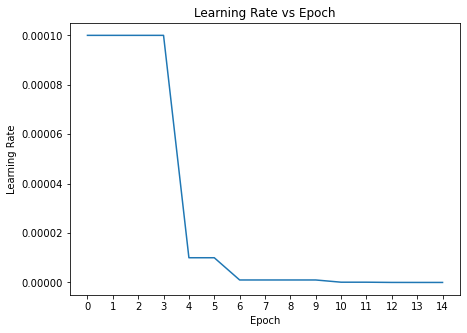

In [18]:
plot_learning_rate(history_dict)

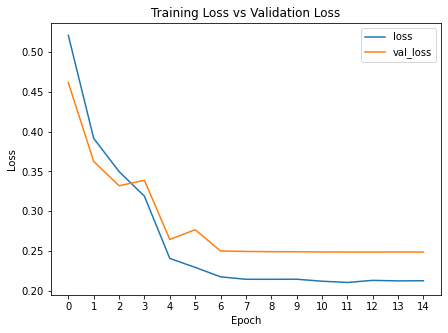

In [19]:
plot_metric(history_dict, 'loss')

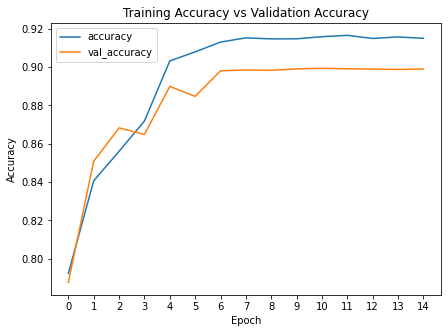

In [20]:
plot_metric(history_dict, 'accuracy')

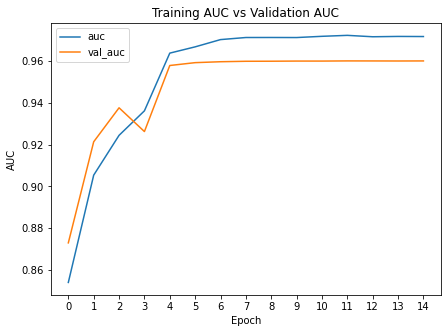

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/129 [..............................] - ETA: 11s - loss: 0.2241 - accuracy: 0.8906 - auc: 0.9722

  8/129 [>.............................] - ETA: 0s - loss: 0.2343 - accuracy: 0.8926 - auc: 0.9648 

 15/129 [==>...........................] - ETA: 0s - loss: 0.2572 - accuracy: 0.8844 - auc: 0.9575

 22/129 [====>.........................] - ETA: 0s - loss: 0.2591 - accuracy: 0.8913 - auc: 0.9579

 29/129 [=====>........................] - ETA: 0s - loss: 0.2578 - accuracy: 0.8933 - auc: 0.9582

 36/129 [=======>......................] - ETA: 0s - loss: 0.2609 - accuracy: 0.8928 - auc: 0.9565

 43/129 [=========>....................] - ETA: 0s - loss: 0.2595 - accuracy: 0.8924 - auc: 0.9572

 50/129 [==========>...................] - ETA: 0s - loss: 0.2624 - accuracy: 0.8900 - auc: 0.9562

 57/129 [============>.................] - ETA: 0s - loss: 0.2615 - accuracy: 0.8904 - auc: 0.9564

 64/129 [=============>................] - ETA: 0s - loss: 0.2593 - accuracy: 0.8901 - auc: 0.9572

 71/129 [===============>..............] - ETA: 0s - loss: 0.2571 - accuracy: 0.8913 - auc: 0.9579

 78/129 [=================>............] - ETA: 0s - loss: 0.2564 - accuracy: 0.8928 - auc: 0.9581

 85/129 [==================>...........] - ETA: 0s - loss: 0.2575 - accuracy: 0.8919 - auc: 0.9576

 92/129 [====================>.........] - ETA: 0s - loss: 0.2576 - accuracy: 0.8916 - auc: 0.9576

 99/129 [======================>.......] - ETA: 0s - loss: 0.2605 - accuracy: 0.8908 - auc: 0.9566

106/129 [=======================>......] - ETA: 0s - loss: 0.2626 - accuracy: 0.8902 - auc: 0.9558

113/129 [=========================>....] - ETA: 0s - loss: 0.2616 - accuracy: 0.8901 - auc: 0.9563

120/129 [==========================>...] - ETA: 0s - loss: 0.2626 - accuracy: 0.8895 - auc: 0.9561

127/129 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.8893 - auc: 0.9561

129/129 [==============================] - 1s 8ms/step - loss: 0.2630 - accuracy: 0.8893 - auc: 0.9559


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---